Experimentation on the CIFAR simmulated annotators
* batch = 128
* delta convergence = 1e-2
* Optimizer = ADAM

* Our proposed: Pre-train base model with soft-MV (5 epochs?) as Rodrigues: https://github.com/fmpr/CrowdLayer/blob/master/demo-conll-ner-mturk.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2 #tolerance for relative variation of parameters

### Load Data and preprocess

In [3]:
folder = "."
X_train = np.loadtxt(folder+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(folder+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(folder+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(folder+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth

print("Input shape:",X_train.shape)

Input shape: (2457, 2)


In [4]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=True) #matrices sparse with_mean=False
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_train.shape

(2457, 2)

### Load annotations / Generate

In [5]:
scenario = 1
path = "."

In [9]:
from code.generate_data import SinteticData

GenerateData = SinteticData()

#CONFUSION MATRIX CHOOSE
if scenario == 1 or scenario == 3 or scenario == 4 or scenario == 5 or scenario == 6:
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_normal.csv',file_groups =path+'/synthetic/simple/groups_datasim_normal.csv')

elif scenario == 2 or scenario == 7: #bad MV
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')

real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
if scenario == 1 or scenario ==2 or scenario == 3:
    Tmax = 100
    T_data = 10 
elif scenario == 4 or scenario == 7:
    Tmax = 2000
    T_data = 20 
elif scenario == 5:
    Tmax = 5000
    T_data = 25
elif scenario == 6:
    Tmax = 10000
    T_data = 40
    
#GenerateData.set_probas(asfile=False,file_matrix=real_conf_matrix,file_groups =aux)

print("New Synthetic data is being generated...",flush=True,end='')
if scenario == 3: #soft
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
else:
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

acc_mv_train = np.mean(majority_voting(y_obs,repeats=False,onehot=False) == Z_train)
print("Accuracy of MV on train: ",acc_mv_train)

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.7769637769637769
Shape (data,annotators):  (2457, 100)
Classes:  3


In [10]:
GenerateData.prob_groups

array([0.2 , 0.45, 0.35])

#### Delta Convergence criteria

In [7]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model

In [18]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],8,1,BN=False,drop=0.2)
#model_UB = clone_model(raykarMC.base_model)

model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])

In [8]:
from code.representation import *
from code.utils import *

### Infer Labels (without predictive model)

In [33]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')
#label_I = LabelInference(y_obs_categorical,TOL, type_inf = 'all')

mv_onehot = label_I.mv_labels('onehot')
mv_probas = label_I.mv_labels('probas')

ds_labels,ds_conf_M = label_I.DS_labels()

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -29549.084767031174
2 	 -26178.657297875998 	0.6839	0.352059	0.114062
3 	 -25595.126519135338 	0.0832	0.218716	0.022290
4 	 -25385.45274967683 	0.0500	0.103388	0.008192
5 	 -25303.727117070186 	0.0235	0.043967	0.003219
6 	 -25271.376732632492 	0.0115	0.021592	0.001278
Class marginals
[0.46 0.33 0.21]


In [34]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.6109076109076109
ACC D&S on train: 0.8567358567358567


In [35]:
model_mvsoft = MLP_Keras(Xstd_train.shape[1:],mv_probas.shape[1],8,1,BN=False,drop=0.2)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV")

Trained model over soft-MV


In [36]:
model_mvhard = MLP_Keras(Xstd_train.shape[1:],mv_onehot.shape[1],8,1,BN=False,drop=0.2)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV")

Trained model over hard-MV


In [37]:
model_ds = MLP_Keras(Xstd_train.shape[1:],ds_labels.shape[1],8,1,BN=False,drop=0.2)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S")

Trained model over D&S


In [10]:
from code.baseline import RaykarMC

#get representation needed for Raykar
#y_obs_categorical = label_I.y_obs_categ
y_obs_categorical = set_representation(y_obs,'onehot') 

### Raykar Model (joint predict model)

In [90]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",8,1,BatchN=False,drop=0.2)

raykarMC.define_priors(np.ones((T,K))) #cada observador dijo al menos un dato
logL_hist = raykarMC.train(Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                           ,relative=True,val=False)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (2000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 21.91 sec)	logL: -34328.133	
Iter 2/50 
M step: done,  E step: done //  (in 0.50 sec)	logL: -31295.244	Tol1: 0.08835	Tol2: 0.22991	
Iter 3/50 
M step: done,  E step: done //  (in 0.51 sec)	logL: -30858.654	Tol1: 0.01395	Tol2: 0.05645	
Iter 4/50 
M step: done,  E step: done //  (in 0.49 sec)	logL: -30725.123	Tol1: 0.00433	Tol2: 0.01269	
Finished training!


In [16]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
#raykarMC.define_model("keras_shallow") 
raykarMC.define_model("mlp",8,1,BatchN=False,drop=0.2)

logL_hists,i = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (2000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 1.51 sec)	logL: -35028.352	
Iter 2/50 
M step: done,  E step: done //  (in 0.11 sec)	logL: -32475.736	Tol1: 0.07287	Tol2: 0.22402	
Iter 3/50 
M step: done,  E step: done //  (in 0.11 sec)	logL: -31868.795	Tol1: 0.01869	Tol2: 0.06683	
Iter 4/50 
M step: done,  E step: done //  (in 0.14 sec)	logL: -31605.061	Tol1: 0.00828	Tol2: 0.02931	
Finished training!
Initializing new EM...
Betas shape:  (2000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 1.72 sec)	logL: -34817.297	
Iter 2/50 
M step: done,  E step: done //  (in 0.13 sec)	logL: -32168.148	Tol1: 0.07609	Tol2: 0.21777	
Iter 3/50 
M step: done,  E step: done //  (in 0.16 sec)	logL: -31485.816	Tol1: 0.02121	Tol2: 0.07456	
Iter 4/50 
M step: done,  E step: done //  (in 0.12 sec)	logL: -31259.438	Tol1: 0.00719	Tol2: 0.02561	
Finished traini

### Our Proposed

In [11]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
r_obs = set_representation(y_obs_categorical,"repeat")
#r_obs = set_representation(y_obs,"repeat")
print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[ 3  0  7]
 [ 2  4  3]
 [ 3  0 10]
 ...
 [ 2  0  4]
 [ 9  0  4]
 [ 7  1  1]]
shape: (2457, 3)


In [41]:
%%time

#pre analysis
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
print("Annotators PCA of annotations shape: ",annotators_pca.shape)

mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Bayesian gaussian mixture say is 18 clusters 


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


DBSCAN say is 2 clusters
Affinity Propagation say is 1 clusters
Annotators PCA of annotations shape:  (2000, 4)
Normalized entropy (0-1) of repeats annotations: 0.647916212093615
CPU times: user 1min, sys: 5.31 s, total: 1min 5s
Wall time: 5.23 s


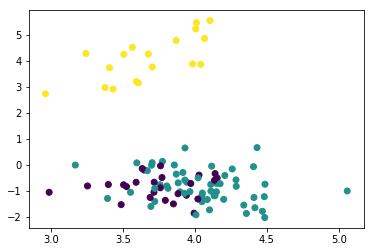

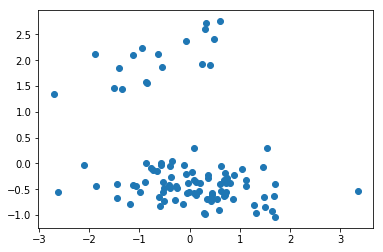

In [119]:
plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c=groups_annot.argmax(axis=1))
plt.show()

std = StandardScaler()
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

In [11]:
M_seted = 3

In [42]:
gMixture1 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture1.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture1.lambda_random = False #lambda=1     
logL_hists,i_r = gMixture1.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.003375 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 8.97 sec)	logL: -48511.162	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -48054.513	Tol1: 0.00941	Tol2: 0.06404	Tol3: 0.01810	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -47719.367	Tol1: 0.00697	Tol2: 0.04276	Tol3: 0.00032	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -47344.273	Tol1: 0.00786	Tol2: 0.05259	Tol3: 0.00106	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -46911.728	Tol1: 0.00914	Tol2: 0.06177	Tol3: 0.00122	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -46431.422	Tol1: 0.01024	Tol2: 0.07072	Tol3: 0.00161	
Iter 7/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -45893.800	Tol1: 0.011

M step: done,  E step: done //  (in 0.13 sec)	logL: -40500.523	Tol1: 0.00336	Tol2: 0.03107	Tol3: 0.00041	
Iter 19/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -40375.309	Tol1: 0.00309	Tol2: 0.03119	Tol3: 0.00003	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -40266.392	Tol1: 0.00270	Tol2: 0.03275	Tol3: 0.00064	
Iter 21/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -40161.242	Tol1: 0.00261	Tol2: 0.03302	Tol3: 0.00076	
Iter 22/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -40067.662	Tol1: 0.00233	Tol2: 0.03353	Tol3: 0.00131	
Iter 23/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -39975.181	Tol1: 0.00231	Tol2: 0.03280	Tol3: 0.00107	
Iter 24/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -39889.418	Tol1: 0.00215	Tol2: 0.03240	Tol3: 0.00166	
Iter 25/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39812.441	Tol1: 0.00193	Tol2: 0.03166	Tol3: 0.00144	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39740.333	T

M step: done,  E step: done //  (in 8.47 sec)	logL: -49135.408	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -48382.749	Tol1: 0.01532	Tol2: 0.13605	Tol3: 0.03467	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -47998.183	Tol1: 0.00795	Tol2: 0.06941	Tol3: 0.00420	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47577.439	Tol1: 0.00877	Tol2: 0.06598	Tol3: 0.00077	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -47106.562	Tol1: 0.00990	Tol2: 0.06873	Tol3: 0.00060	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -46584.205	Tol1: 0.01109	Tol2: 0.07345	Tol3: 0.00056	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -46019.388	Tol1: 0.01212	Tol2: 0.07792	Tol3: 0.00051	
Iter 8/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -45407.361	Tol1: 0.01330	Tol2: 0.08330	Tol3: 0.00064	
Iter 9/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -44747.044	Tol1: 0.01454	Tol2: 0.09046	Tol3: 0.00070	
Iter 10/

M step: done,  E step: done //  (in 0.16 sec)	logL: -48244.150	Tol1: 0.00553	Tol2: 0.04804	Tol3: 0.00598	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47954.478	Tol1: 0.00600	Tol2: 0.04707	Tol3: 0.00112	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47611.460	Tol1: 0.00715	Tol2: 0.04711	Tol3: 0.00064	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -47209.364	Tol1: 0.00845	Tol2: 0.04988	Tol3: 0.00063	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -46739.023	Tol1: 0.00996	Tol2: 0.05583	Tol3: 0.00058	
Iter 8/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -46193.662	Tol1: 0.01167	Tol2: 0.06258	Tol3: 0.00053	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -45584.213	Tol1: 0.01319	Tol2: 0.07322	Tol3: 0.00056	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -44919.751	Tol1: 0.01458	Tol2: 0.08386	Tol3: 0.00064	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -44224.556	Tol1: 0

M step: done,  E step: done //  (in 0.16 sec)	logL: -42283.403	Tol1: 0.01175	Tol2: 0.11120	Tol3: 0.00060	
Iter 9/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41824.165	Tol1: 0.01086	Tol2: 0.10770	Tol3: 0.00130	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41413.208	Tol1: 0.00983	Tol2: 0.10170	Tol3: 0.00200	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -41056.437	Tol1: 0.00861	Tol2: 0.09417	Tol3: 0.00259	
Iter 12/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -40767.489	Tol1: 0.00704	Tol2: 0.08402	Tol3: 0.00271	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40523.278	Tol1: 0.00599	Tol2: 0.07335	Tol3: 0.00323	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40321.524	Tol1: 0.00498	Tol2: 0.06457	Tol3: 0.00367	
Iter 15/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40144.798	Tol1: 0.00438	Tol2: 0.06029	Tol3: 0.00368	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39996.980	To

In [43]:
gMixture2 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture2.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture2.lambda_random = True #lambda random
logL_hists,i_r = gMixture2.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.004671 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.03 0.04 0.58]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.81 sec)	logL: -47893.726	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -46795.137	Tol1: 0.02294	Tol2: 0.15603	Tol3: 0.00846	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -45904.463	Tol1: 0.01903	Tol2: 0.09954	Tol3: 0.00415	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -45109.323	Tol1: 0.01732	Tol2: 0.07261	Tol3: 0.00299	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -44392.581	Tol1: 0.01589	Tol2: 0.05718	Tol3: 0.00357	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -43708.633	Tol1: 0.01541	Tol2: 0.05617	Tol3: 0.00500	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -43069.263	Tol1

M step: done,  E step: done //  (in 0.15 sec)	logL: -48770.686	Tol1: 0.00974	Tol2: 0.07563	Tol3: 0.00499	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -48406.007	Tol1: 0.00748	Tol2: 0.05467	Tol3: 0.00362	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -48069.493	Tol1: 0.00695	Tol2: 0.04935	Tol3: 0.00274	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47732.295	Tol1: 0.00701	Tol2: 0.05420	Tol3: 0.00252	
Iter 11/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47333.491	Tol1: 0.00836	Tol2: 0.06116	Tol3: 0.00215	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -46855.429	Tol1: 0.01010	Tol2: 0.06882	Tol3: 0.00216	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -46295.906	Tol1: 0.01194	Tol2: 0.07610	Tol3: 0.00239	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -45646.641	Tol1: 0.01402	Tol2: 0.08199	Tol3: 0.00308	
Iter 15/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -44952.155	Tol

M step: done,  E step: done //  (in 0.18 sec)	logL: -40289.915	Tol1: 0.00271	Tol2: 0.05575	Tol3: 0.00840	
Iter 20/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40192.618	Tol1: 0.00241	Tol2: 0.05083	Tol3: 0.00726	
Iter 21/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -40103.468	Tol1: 0.00222	Tol2: 0.04976	Tol3: 0.00659	
Iter 22/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40029.086	Tol1: 0.00185	Tol2: 0.05052	Tol3: 0.00604	
Iter 23/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39956.745	Tol1: 0.00181	Tol2: 0.04935	Tol3: 0.00534	
Iter 24/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39905.880	Tol1: 0.00127	Tol2: 0.05053	Tol3: 0.00486	
Iter 25/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39845.243	Tol1: 0.00152	Tol2: 0.05038	Tol3: 0.00447	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39808.231	Tol1: 0.00093	Tol2: 0.04456	Tol3: 0.00320	
Iter 27/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39760.909	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -41961.675	Tol1: 0.00751	Tol2: 0.08604	Tol3: 0.00386	
Iter 15/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41686.885	Tol1: 0.00655	Tol2: 0.07965	Tol3: 0.00240	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41460.262	Tol1: 0.00544	Tol2: 0.07395	Tol3: 0.00117	
Iter 17/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41273.626	Tol1: 0.00450	Tol2: 0.06717	Tol3: 0.00071	
Iter 18/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41125.304	Tol1: 0.00359	Tol2: 0.06025	Tol3: 0.00030	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41001.670	Tol1: 0.00301	Tol2: 0.05130	Tol3: 0.00033	
Iter 20/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40896.557	Tol1: 0.00256	Tol2: 0.04271	Tol3: 0.00021	
Iter 21/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -40806.601	Tol1: 0.00220	Tol2: 0.03370	Tol3: 0.00024	
Iter 22/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40726.650	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -42921.141	Tol1: 0.01195	Tol2: 0.08532	Tol3: 0.00436	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -42443.260	Tol1: 0.01113	Tol2: 0.08519	Tol3: 0.00419	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41984.028	Tol1: 0.01082	Tol2: 0.08290	Tol3: 0.00392	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41564.574	Tol1: 0.00999	Tol2: 0.07971	Tol3: 0.00355	
Iter 15/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -41203.304	Tol1: 0.00869	Tol2: 0.07501	Tol3: 0.00312	
Iter 16/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -40899.236	Tol1: 0.00738	Tol2: 0.06956	Tol3: 0.00263	
Iter 17/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40626.465	Tol1: 0.00667	Tol2: 0.06359	Tol3: 0.00220	
Iter 18/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40401.971	Tol1: 0.00553	Tol2: 0.05685	Tol3: 0.00186	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40222.830	T

In [12]:
gMixture3 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture3.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture3.lambda_random = True #with lambda random --necessary
logL_hists,i_r = gMixture3.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)

Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002818 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.1398386  0.90918684 0.6024439 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.83 sec)	logL: -98378.883	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -94402.110	Tol1: 0.04042	Tol2: 0.52193	Tol3: 0.16546	
Iter 3/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -92564.384	Tol1: 0.01947	Tol2: 0.26349	Tol3: 0.05675	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -91155.677	Tol1: 0.01522	Tol2: 0.18934	Tol3: 0.04341	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -89985.965	Tol1: 0.01283	Tol2: 0.16121	Tol3: 0.03796	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -89005.119	Tol1: 0.01090	Tol2: 0.14148	Tol3: 0.03489	
Iter 7/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.09 sec)	logL: -83962.300	Tol1: 0.00471	Tol2: 0.07322	Tol3: 0.01887	
Iter 18/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -83602.164	Tol1: 0.00429	Tol2: 0.06505	Tol3: 0.01931	
Iter 19/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -83289.094	Tol1: 0.00374	Tol2: 0.05660	Tol3: 0.01933	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -83003.124	Tol1: 0.00343	Tol2: 0.04992	Tol3: 0.01945	
Iter 21/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -82745.199	Tol1: 0.00311	Tol2: 0.04525	Tol3: 0.01964	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -82516.483	Tol1: 0.00276	Tol2: 0.04316	Tol3: 0.01944	
Iter 23/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -82313.923	Tol1: 0.00245	Tol2: 0.04442	Tol3: 0.01882	
Iter 24/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -82100.403	Tol1: 0.00259	Tol2: 0.04688	Tol3: 0.01798	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -81936.799	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -81136.551	Tol1: 0.00084	Tol2: 0.03061	Tol3: 0.00458	
Iter 43/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -81048.887	Tol1: 0.00108	Tol2: 0.02877	Tol3: 0.00469	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6406088  0.31953025 0.5493014 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.77 sec)	logL: -100736.474	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -95382.825	Tol1: 0.05315	Tol2: 0.57195	Tol3: 0.13630	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -93734.606	Tol1: 0.01728	Tol2: 0.26455	Tol3: 0.03377	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -92555.438	Tol1: 0.01258	Tol2: 0.18321	Tol3: 0.02250	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -91529.701	Tol1: 0.01108	Tol2: 0.14688	Tol3: 0.01791	
Iter 6/50
M step: done,

M step: done,  E step: done //  (in 0.10 sec)	logL: -90152.211	Tol1: 0.01198	Tol2: 0.10964	Tol3: 0.00662	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -89178.248	Tol1: 0.01080	Tol2: 0.09867	Tol3: 0.00371	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -88350.611	Tol1: 0.00928	Tol2: 0.08916	Tol3: 0.00216	
Iter 13/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -87620.965	Tol1: 0.00826	Tol2: 0.08200	Tol3: 0.00363	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -87024.320	Tol1: 0.00681	Tol2: 0.07523	Tol3: 0.00515	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -86512.187	Tol1: 0.00588	Tol2: 0.06876	Tol3: 0.00597	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -86087.500	Tol1: 0.00491	Tol2: 0.06504	Tol3: 0.00625	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -85723.679	Tol1: 0.00423	Tol2: 0.06176	Tol3: 0.00615	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -85421.700	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -84325.093	Tol1: 0.00049	Tol2: 0.03225	Tol3: 0.00381	
Iter 38/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -84281.469	Tol1: 0.00052	Tol2: 0.03164	Tol3: 0.00370	
Iter 39/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -84233.755	Tol1: 0.00057	Tol2: 0.03021	Tol3: 0.00322	
Iter 40/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -84184.397	Tol1: 0.00059	Tol2: 0.03104	Tol3: 0.00387	
Iter 41/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -84132.279	Tol1: 0.00062	Tol2: 0.03083	Tol3: 0.00365	
Iter 42/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -84088.838	Tol1: 0.00052	Tol2: 0.03154	Tol3: 0.00336	
Iter 43/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -84033.178	Tol1: 0.00066	Tol2: 0.03108	Tol3: 0.00397	
Iter 44/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -83983.854	Tol1: 0.00059	Tol2: 0.03180	Tol3: 0.00369	
Iter 45/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -83925.900	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -101201.465	Tol1: 0.00470	Tol2: 0.08782	Tol3: 0.00789	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -100759.250	Tol1: 0.00437	Tol2: 0.07303	Tol3: 0.00870	
Iter 8/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -100323.988	Tol1: 0.00432	Tol2: 0.06360	Tol3: 0.00925	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -99886.225	Tol1: 0.00436	Tol2: 0.05669	Tol3: 0.00993	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -99392.273	Tol1: 0.00495	Tol2: 0.05458	Tol3: 0.00966	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -98858.821	Tol1: 0.00537	Tol2: 0.05931	Tol3: 0.01056	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -98257.418	Tol1: 0.00608	Tol2: 0.06575	Tol3: 0.01068	
Iter 13/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -97564.610	Tol1: 0.00705	Tol2: 0.07498	Tol3: 0.01075	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -96783.536	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -90358.195	Tol1: 0.01263	Tol2: 0.11935	Tol3: 0.00241	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -89326.500	Tol1: 0.01142	Tol2: 0.11737	Tol3: 0.00266	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -88433.404	Tol1: 0.01000	Tol2: 0.11252	Tol3: 0.00295	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -87666.312	Tol1: 0.00867	Tol2: 0.10430	Tol3: 0.00320	
Iter 13/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -87022.294	Tol1: 0.00735	Tol2: 0.09340	Tol3: 0.00334	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -86497.255	Tol1: 0.00603	Tol2: 0.08125	Tol3: 0.00341	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -86079.164	Tol1: 0.00483	Tol2: 0.06983	Tol3: 0.00344	
Iter 16/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -85704.835	Tol1: 0.00435	Tol2: 0.06009	Tol3: 0.00348	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -85407.135	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -84416.462	Tol1: 0.00073	Tol2: 0.03202	Tol3: 0.00097	
Iter 28/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -84348.648	Tol1: 0.00080	Tol2: 0.03008	Tol3: 0.00112	
Iter 29/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -84299.850	Tol1: 0.00058	Tol2: 0.02993	Tol3: 0.00143	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.03670068 0.6584772  0.46749535]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 1.58 sec)	logL: -112771.489	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -107712.902	Tol1: 0.04486	Tol2: 0.55960	Tol3: 0.16551	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -105189.132	Tol1: 0.02343	Tol2: 0.25692	Tol3: 0.04305	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -103282.107	Tol1: 0.01813	Tol2: 0.16866	Tol3: 0.01763	
Iter 5/50
M step: d

M step: done,  E step: done //  (in 0.15 sec)	logL: -88490.601	Tol1: 0.01009	Tol2: 0.09081	Tol3: 0.01269	
Iter 16/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -87689.752	Tol1: 0.00905	Tol2: 0.08244	Tol3: 0.01217	
Iter 17/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -86990.926	Tol1: 0.00797	Tol2: 0.07319	Tol3: 0.01113	
Iter 18/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -86433.910	Tol1: 0.00640	Tol2: 0.06476	Tol3: 0.00984	
Iter 19/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -85965.935	Tol1: 0.00541	Tol2: 0.06061	Tol3: 0.00879	
Iter 20/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -85583.624	Tol1: 0.00445	Tol2: 0.06038	Tol3: 0.00698	
Iter 21/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -85273.387	Tol1: 0.00362	Tol2: 0.05923	Tol3: 0.00552	
Iter 22/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -85049.840	Tol1: 0.00262	Tol2: 0.05848	Tol3: 0.00417	
Iter 23/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -84854.039	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -95346.862	Tol1: 0.01051	Tol2: 0.09308	Tol3: 0.00711	
Iter 8/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -94315.273	Tol1: 0.01082	Tol2: 0.09692	Tol3: 0.00825	
Iter 9/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -93224.646	Tol1: 0.01156	Tol2: 0.10269	Tol3: 0.00929	
Iter 10/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -92142.352	Tol1: 0.01161	Tol2: 0.10906	Tol3: 0.01043	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -91046.943	Tol1: 0.01189	Tol2: 0.11353	Tol3: 0.01138	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -89985.611	Tol1: 0.01166	Tol2: 0.11522	Tol3: 0.01203	
Iter 13/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -89014.653	Tol1: 0.01079	Tol2: 0.11484	Tol3: 0.01288	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -88137.563	Tol1: 0.00985	Tol2: 0.10906	Tol3: 0.01317	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -87355.864	Tol

M step: done,  E step: done //  (in 0.09 sec)	logL: -81236.407	Tol1: 0.00228	Tol2: 0.06759	Tol3: 0.01267	
Iter 26/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -81088.005	Tol1: 0.00183	Tol2: 0.06848	Tol3: 0.01192	
Iter 27/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -80971.697	Tol1: 0.00143	Tol2: 0.06818	Tol3: 0.01161	
Iter 28/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -80863.395	Tol1: 0.00134	Tol2: 0.06668	Tol3: 0.01024	
Iter 29/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -80766.285	Tol1: 0.00120	Tol2: 0.06421	Tol3: 0.01010	
Iter 30/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -80668.658	Tol1: 0.00121	Tol2: 0.06153	Tol3: 0.00981	
Iter 31/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -80608.294	Tol1: 0.00075	Tol2: 0.05966	Tol3: 0.00939	
Iter 32/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -80551.333	Tol1: 0.00071	Tol2: 0.05676	Tol3: 0.00882	
Iter 33/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -80493.614	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -81692.769	Tol1: 0.00068	Tol2: 0.03751	Tol3: 0.00387	
Iter 49/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -81630.661	Tol1: 0.00076	Tol2: 0.03540	Tol3: 0.00396	
Iter 50/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -81568.614	Tol1: 0.00076	Tol2: 0.03406	Tol3: 0.00400	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.863998   0.22564706 0.13700563]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 2.59 sec)	logL: -102572.069	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -99387.645	Tol1: 0.03105	Tol2: 0.50849	Tol3: 0.13812	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -97794.381	Tol1: 0.01603	Tol2: 0.18917	Tol3: 0.02393	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -96324.447	Tol1: 0.01503	Tol2: 0.13434	Tol3: 0.01861	
Iter 5/50
M step: done

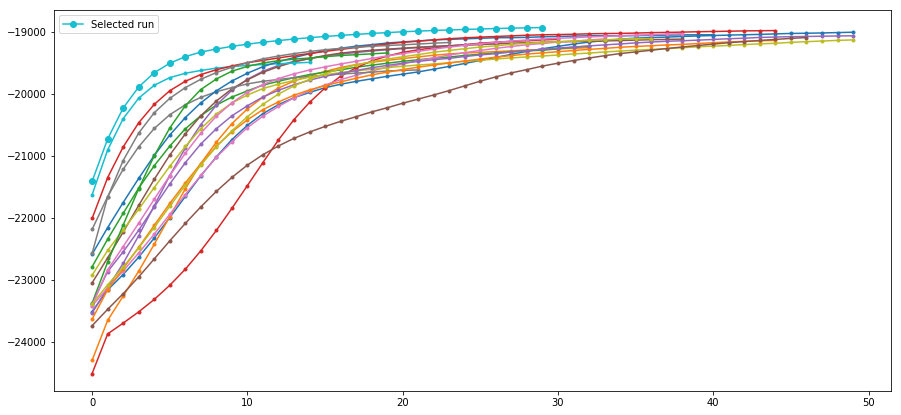

In [74]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',label="Selected run")
plt.legend()
plt.show()

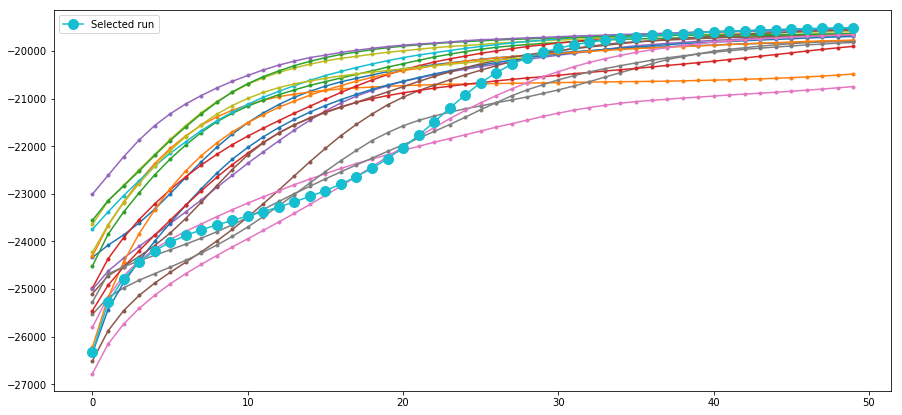

In [52]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [13]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [25]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
Z_train_pred = model_UB.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = model_UB.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.912495      0.912495
====  ======  ==========  ============
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.91453       0.91453
====  ======  ==========  ============


#### 1st configuration: Normal ($T$ = 100, $T_{max}$ = 10 )

In [27]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7663817663817664


*** Soft-Majority (Train with softMV) ***
Train


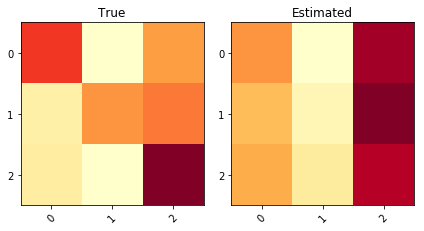

KL divergence: 0.2830	Pearson Correlation between diagonals: 0.9917


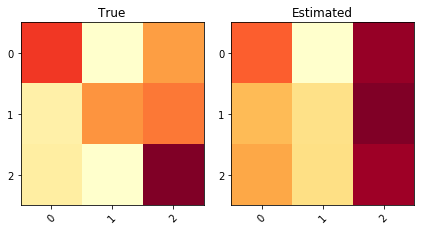

KL divergence: 0.2486	Pearson Correlation between diagonals: 0.9857


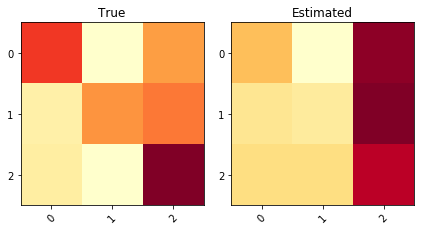

KL divergence: 0.2754	Pearson Correlation between diagonals: 0.9909


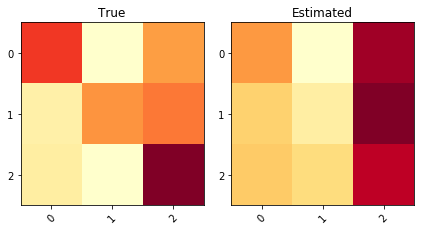

KL divergence: 0.2758	Pearson Correlation between diagonals: 0.9972


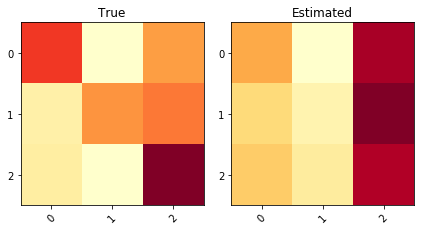

KL divergence: 0.2636	Pearson Correlation between diagonals: 1.0000


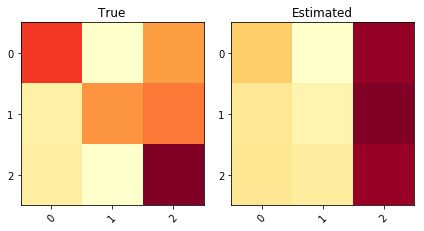

KL divergence: 0.2655	Pearson Correlation between diagonals: 0.9850


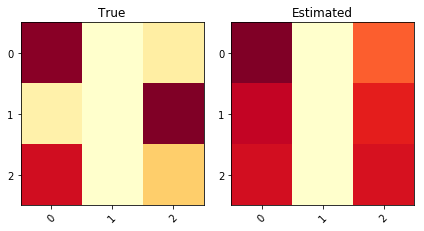

KL divergence: 0.2543	Pearson Correlation between diagonals: 0.8458


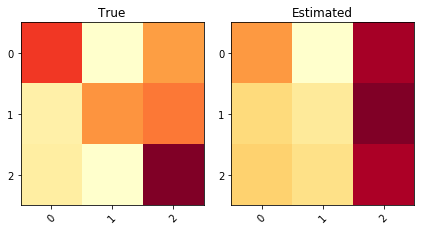

KL divergence: 0.2516	Pearson Correlation between diagonals: 0.9996


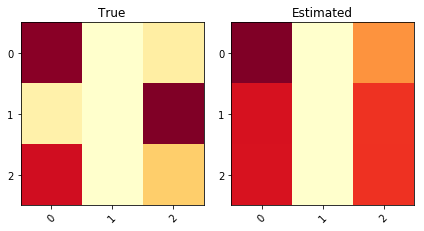

KL divergence: 0.2281	Pearson Correlation between diagonals: 0.8974


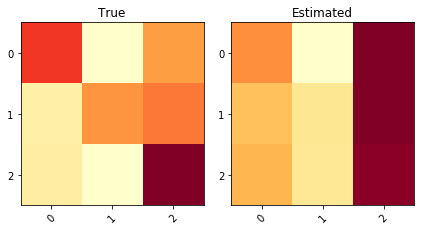

KL divergence: 0.2418	Pearson Correlation between diagonals: 0.9999


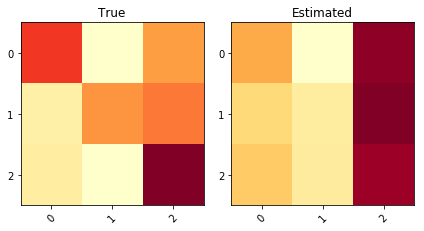

KL divergence: 0.2494	Pearson Correlation between diagonals: 0.9983


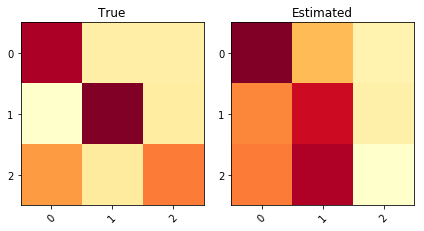

KL divergence: 0.3745	Pearson Correlation between diagonals: 0.9351


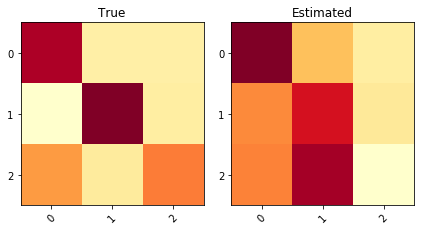

KL divergence: 0.3844	Pearson Correlation between diagonals: 0.9249


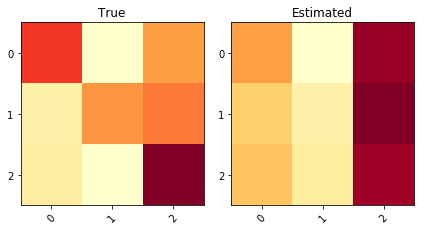

KL divergence: 0.2577	Pearson Correlation between diagonals: 0.9999


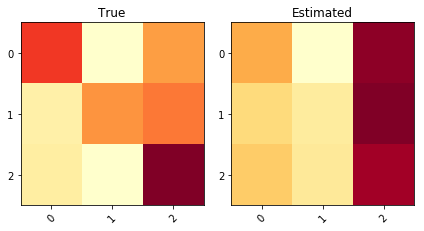

KL divergence: 0.2522	Pearson Correlation between diagonals: 0.9977
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.457061      0.457061   0.287433  0.0794692            0.930672
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.47619       0.47619
====  ======  ==========  ============


In [28]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


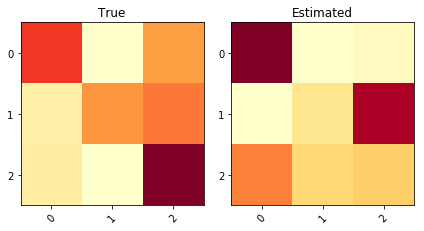

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006


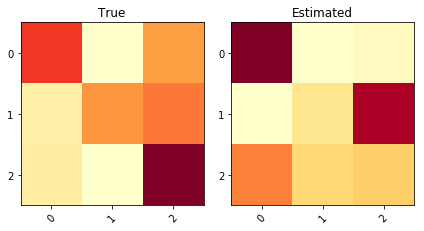

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006


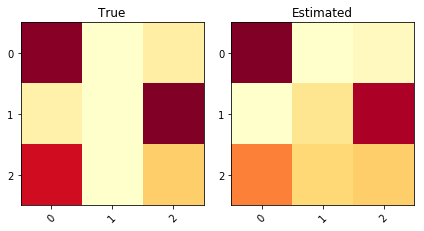

KL divergence: 0.6981	Pearson Correlation between diagonals: 0.9875


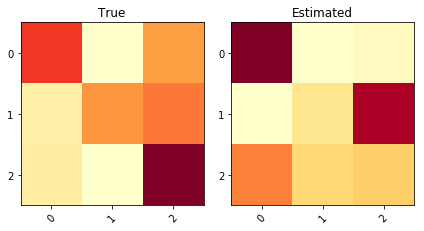

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006


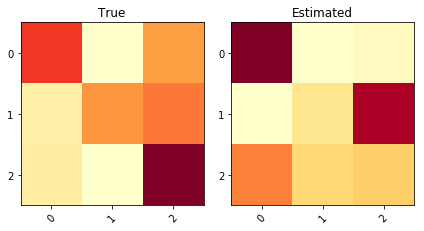

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006


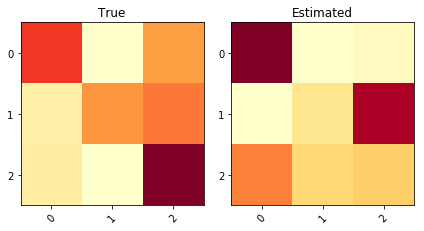

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006


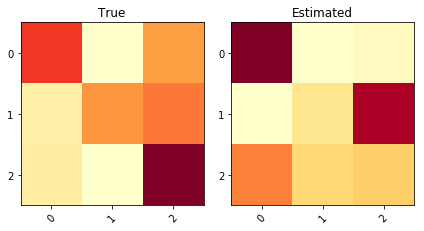

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006


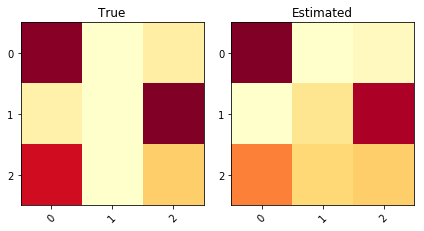

KL divergence: 0.6981	Pearson Correlation between diagonals: 0.9875


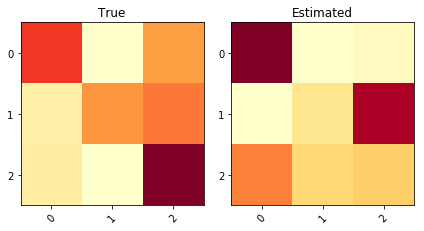

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006


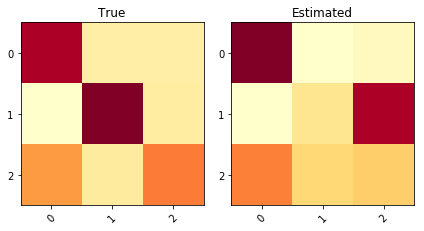

KL divergence: 0.4550	Pearson Correlation between diagonals: 0.2018


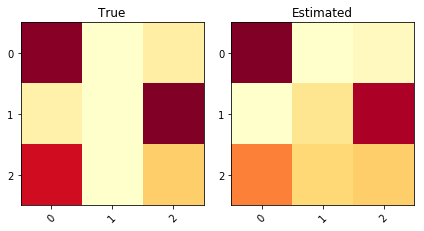

KL divergence: 0.6981	Pearson Correlation between diagonals: 0.9875


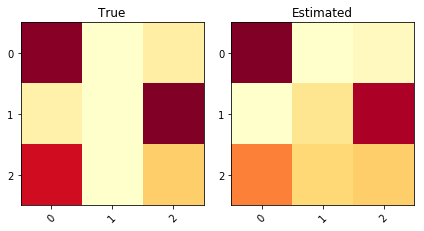

KL divergence: 0.6981	Pearson Correlation between diagonals: 0.9875


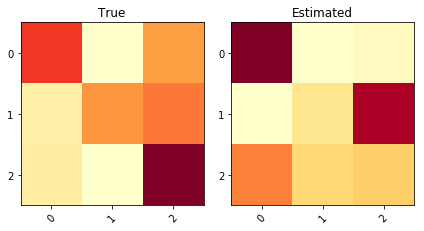

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006


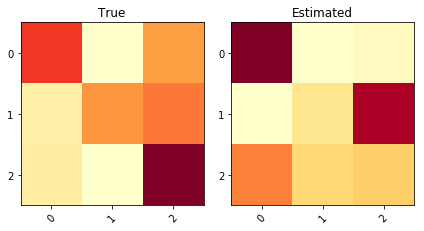

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006


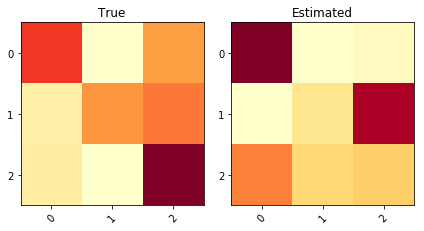

KL divergence: 0.4520	Pearson Correlation between diagonals: -0.0006
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.457061      0.457061   0.509418   0.172515            0.281329
====  ======  ==========  ============  =========  =========  ==================


In [29]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


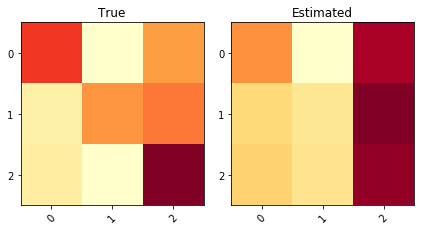

KL divergence: 0.2252	Pearson Correlation between diagonals: 0.9997


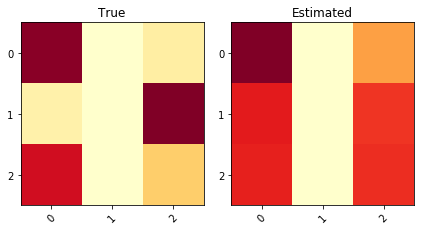

KL divergence: 0.2202	Pearson Correlation between diagonals: 0.8928


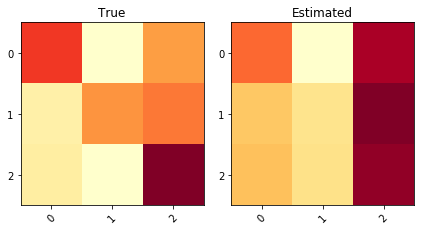

KL divergence: 0.2230	Pearson Correlation between diagonals: 0.9922


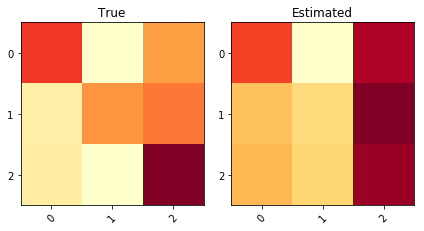

KL divergence: 0.2293	Pearson Correlation between diagonals: 0.9731


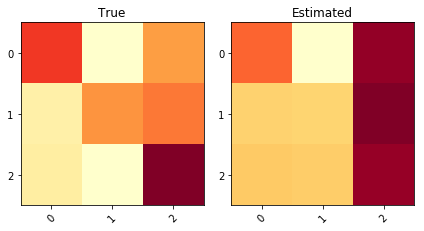

KL divergence: 0.2288	Pearson Correlation between diagonals: 0.9970


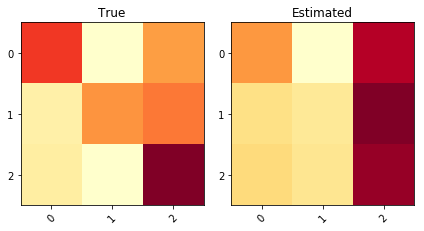

KL divergence: 0.2163	Pearson Correlation between diagonals: 1.0000


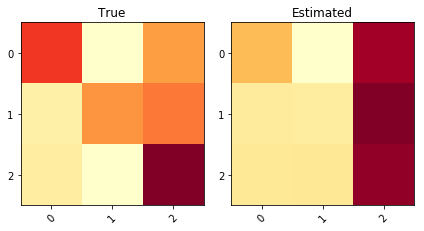

KL divergence: 0.2352	Pearson Correlation between diagonals: 0.9889


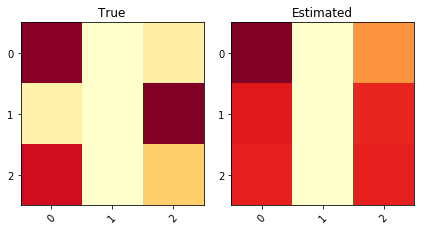

KL divergence: 0.2243	Pearson Correlation between diagonals: 0.8742


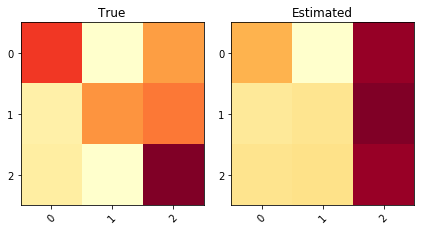

KL divergence: 0.2340	Pearson Correlation between diagonals: 0.9886


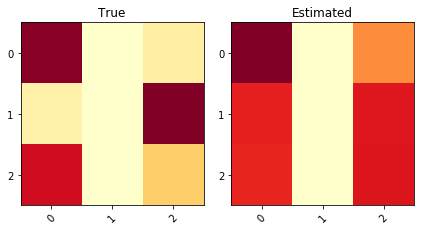

KL divergence: 0.2206	Pearson Correlation between diagonals: 0.8565


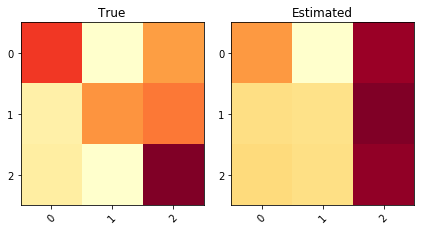

KL divergence: 0.2267	Pearson Correlation between diagonals: 0.9988


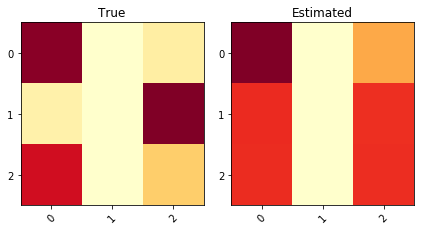

KL divergence: 0.2090	Pearson Correlation between diagonals: 0.8924


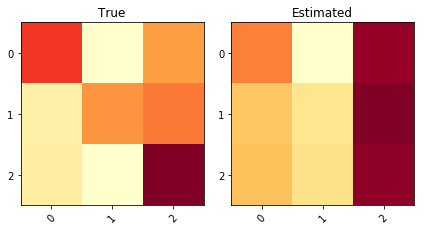

KL divergence: 0.2287	Pearson Correlation between diagonals: 0.9979


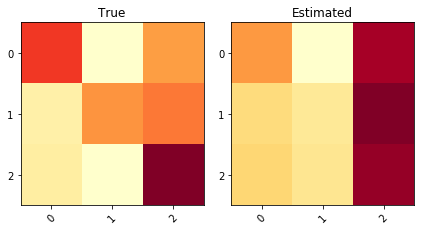

KL divergence: 0.2278	Pearson Correlation between diagonals: 1.0000


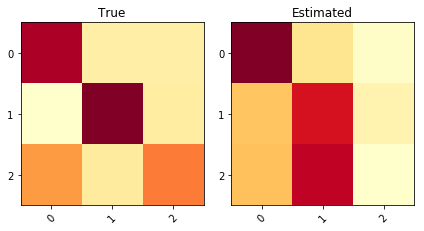

KL divergence: 0.3506	Pearson Correlation between diagonals: 0.9233
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.496133      0.496133   0.259383  0.0725451            0.932226
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.500611      0.500611
====  ======  ==========  ============


In [30]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


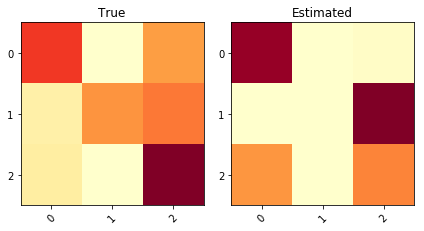

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333


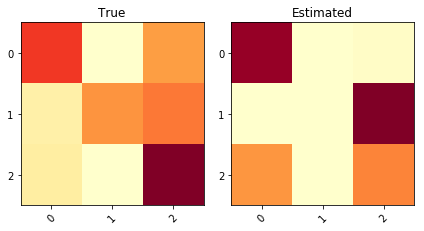

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333


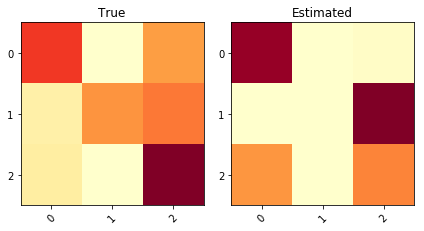

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333


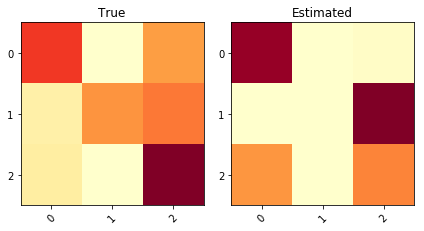

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333


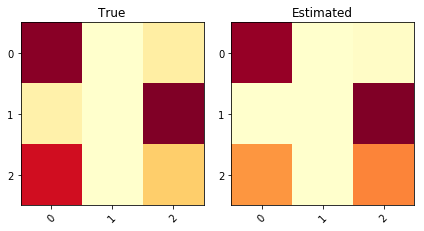

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.9580


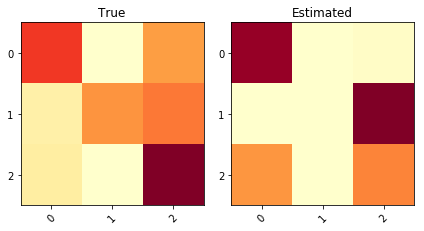

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333


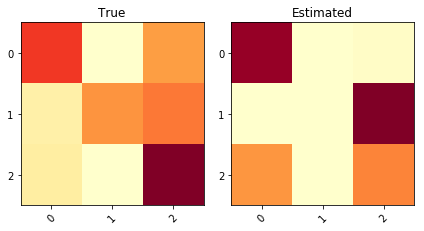

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333


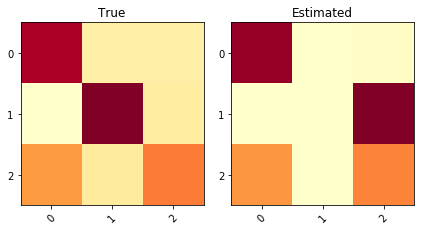

KL divergence: 5.5035	Pearson Correlation between diagonals: -0.2431


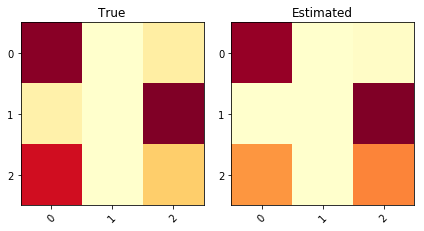

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.9580


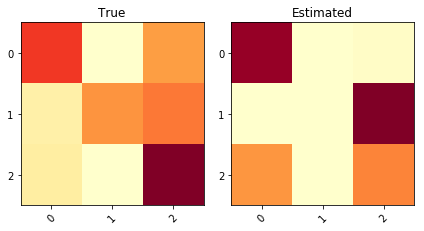

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333


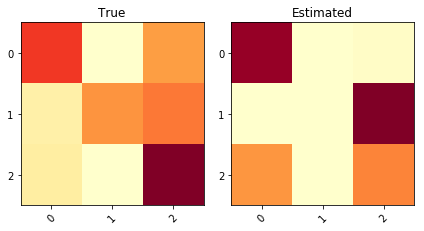

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333


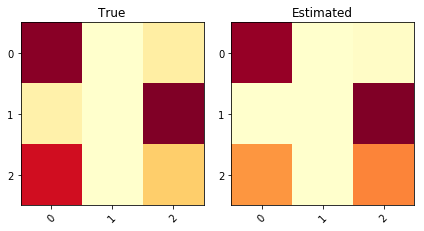

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.9580


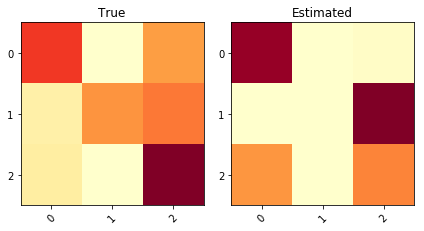

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333


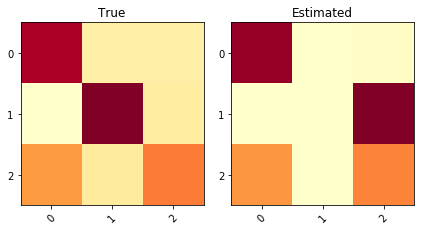

KL divergence: 5.5035	Pearson Correlation between diagonals: -0.2431


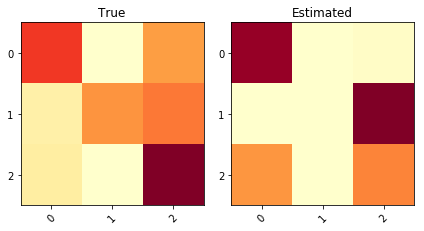

KL divergence: 2.4595	Pearson Correlation between diagonals: 0.4333
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.496133      0.496133    2.81409   0.186959             0.37137
====  ======  ==========  ============  =========  =========  ==================


In [31]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


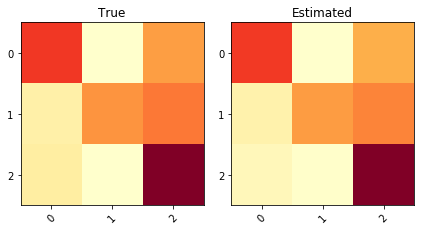

KL divergence: 0.0104	Pearson Correlation between diagonals: 0.9997


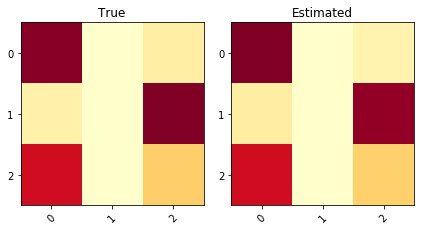

KL divergence: 0.0030	Pearson Correlation between diagonals: 0.9999


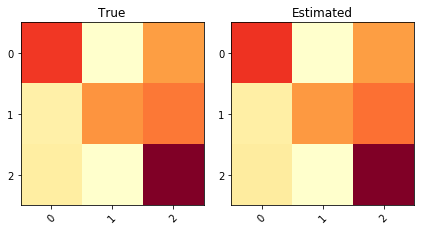

KL divergence: 0.0004	Pearson Correlation between diagonals: 0.9991


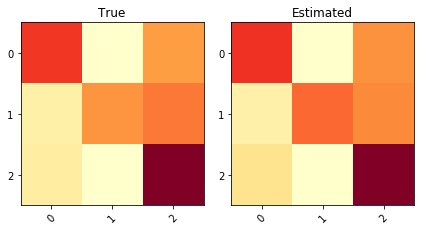

KL divergence: 0.0057	Pearson Correlation between diagonals: 0.9933


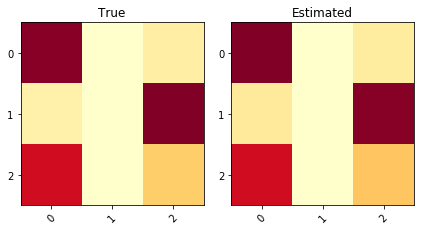

KL divergence: 0.0031	Pearson Correlation between diagonals: 0.9996


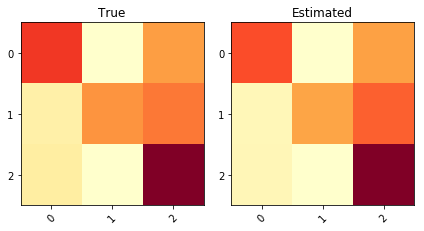

KL divergence: 0.0120	Pearson Correlation between diagonals: 0.9996


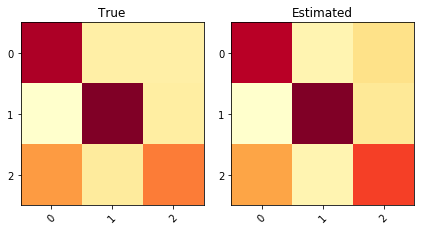

KL divergence: 0.0192	Pearson Correlation between diagonals: 0.9884


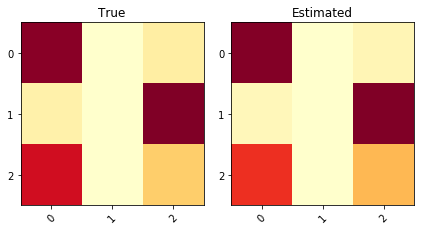

KL divergence: 0.0132	Pearson Correlation between diagonals: 0.9971


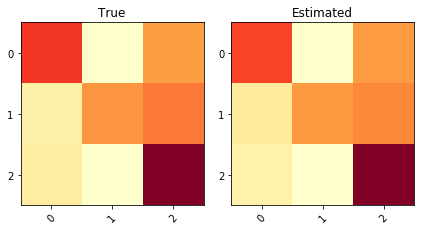

KL divergence: 0.0024	Pearson Correlation between diagonals: 0.9992


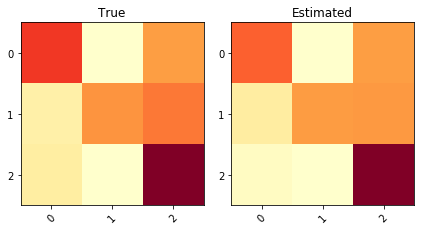

KL divergence: 0.0255	Pearson Correlation between diagonals: 0.9887


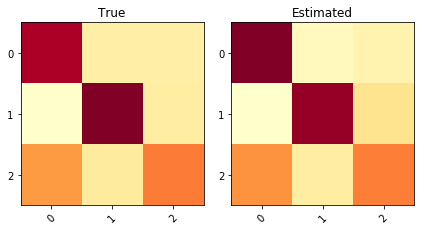

KL divergence: 0.0174	Pearson Correlation between diagonals: 0.9578


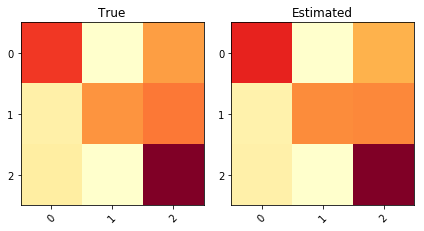

KL divergence: 0.0031	Pearson Correlation between diagonals: 0.9971


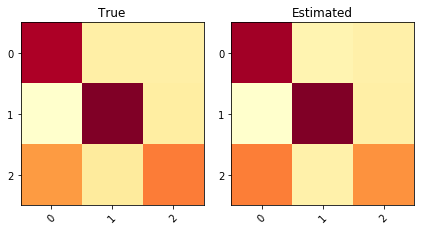

KL divergence: 0.0062	Pearson Correlation between diagonals: 0.9977


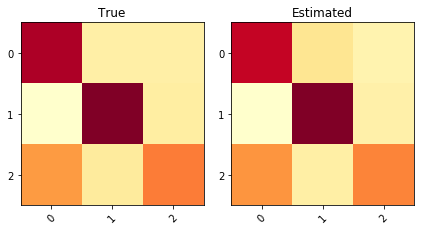

KL divergence: 0.0064	Pearson Correlation between diagonals: 0.9938


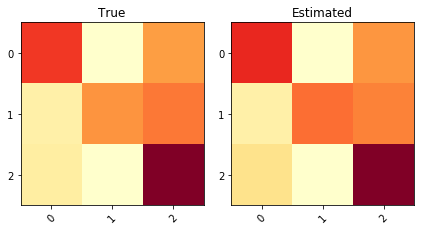

KL divergence: 0.0052	Pearson Correlation between diagonals: 0.9993
A result
 ====  ======  ==========  ============  ==========  ==========  ==================
  ..            Accuracy    F1 (micro)     Mean KL     Mean JS    Mean PearsonCorr
====  ======  ==========  ============  ==========  ==========  ==================
   0  Global    0.619455      0.619455  0.00992152  0.00239135            0.988719
====  ======  ==========  ============  ==========  ==========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.595849      0.595849
====  ======  ==========  ============


In [32]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


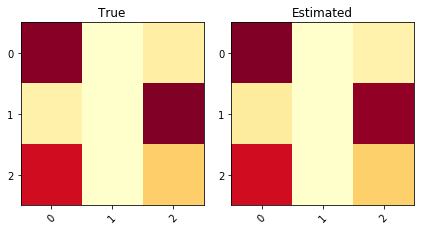

KL divergence: 0.0162	Pearson Correlation between diagonals: 0.9999


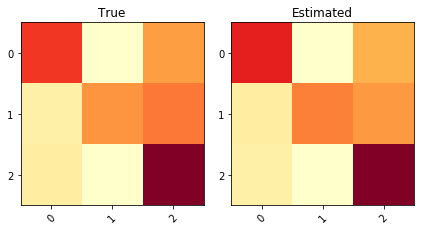

KL divergence: 0.0145	Pearson Correlation between diagonals: 0.9980


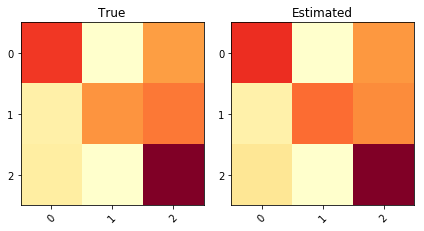

KL divergence: 0.0130	Pearson Correlation between diagonals: 0.9959


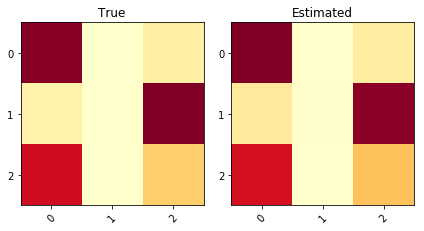

KL divergence: 0.0183	Pearson Correlation between diagonals: 0.9994


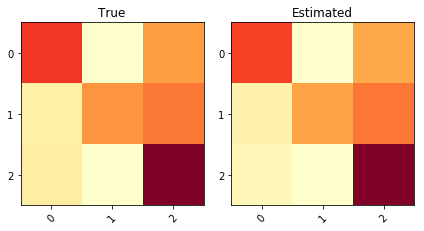

KL divergence: 0.0118	Pearson Correlation between diagonals: 1.0000


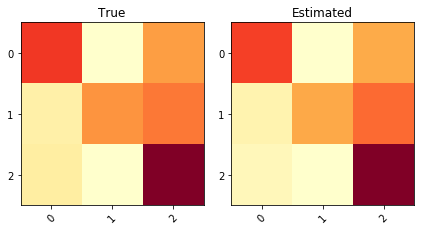

KL divergence: 0.0140	Pearson Correlation between diagonals: 0.9991


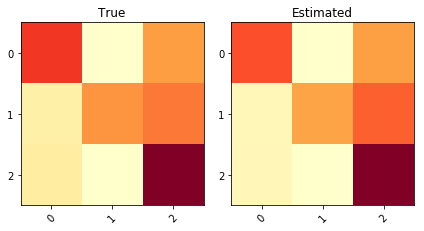

KL divergence: 0.0155	Pearson Correlation between diagonals: 0.9993


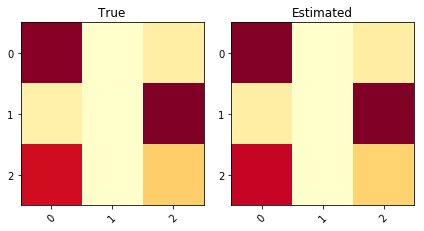

KL divergence: 0.0135	Pearson Correlation between diagonals: 0.9998


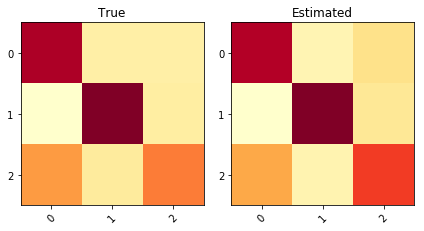

KL divergence: 0.0221	Pearson Correlation between diagonals: 0.9917


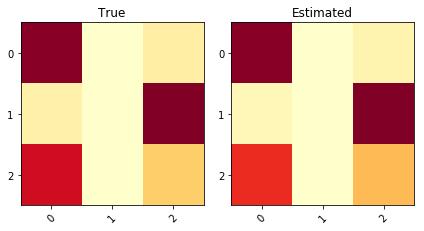

KL divergence: 0.0185	Pearson Correlation between diagonals: 0.9973


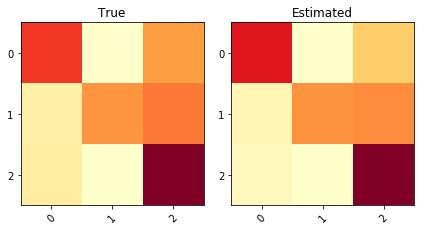

KL divergence: 0.0270	Pearson Correlation between diagonals: 0.9844


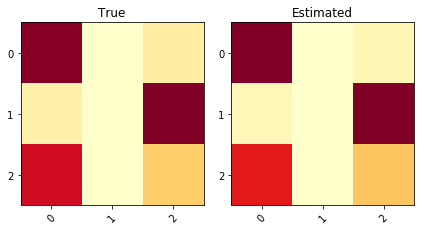

KL divergence: 0.0173	Pearson Correlation between diagonals: 0.9997


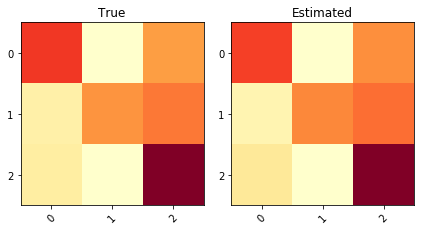

KL divergence: 0.0114	Pearson Correlation between diagonals: 0.9956


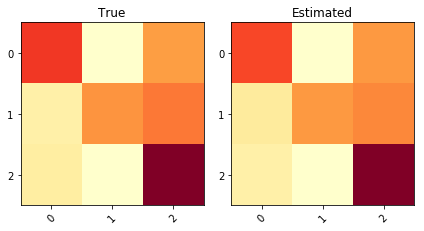

KL divergence: 0.0107	Pearson Correlation between diagonals: 0.9982


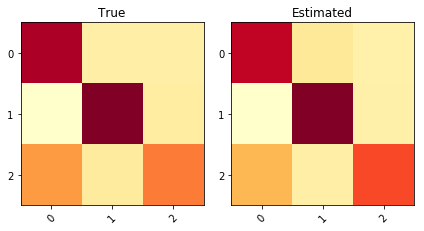

KL divergence: 0.0131	Pearson Correlation between diagonals: 0.9795
A result
 ====  ======  ==========  ============  =========  ==========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  ==========  ==================  ==============
   0  Global    0.908425      0.908425  0.0164586  0.00487151            0.988983        0.143644
====  ======  ==========  ============  =========  ==========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.663532                0.734662
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.91

In [33]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


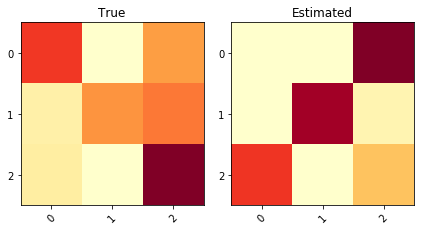

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


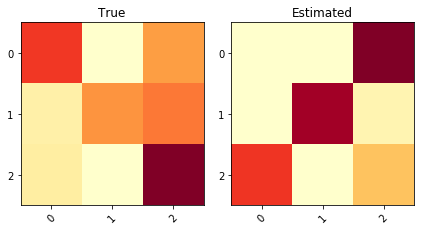

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


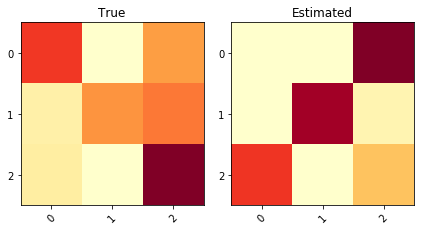

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


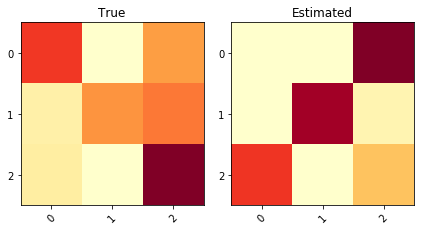

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


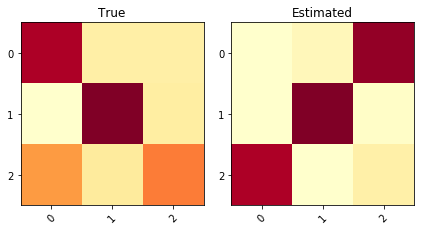

KL divergence: 1.5012	Pearson Correlation between diagonals: 0.5843


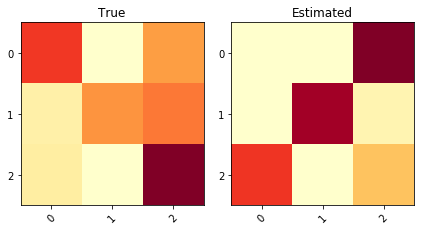

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


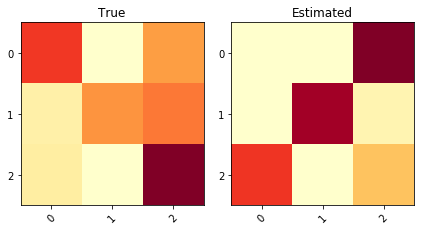

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


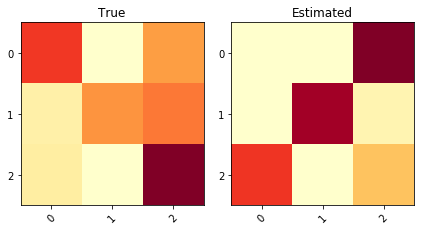

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


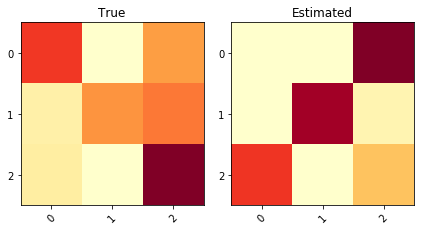

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


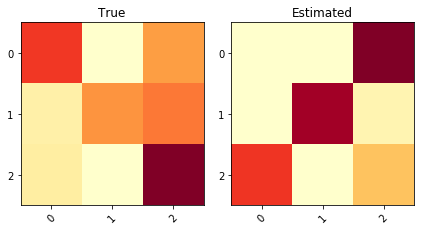

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


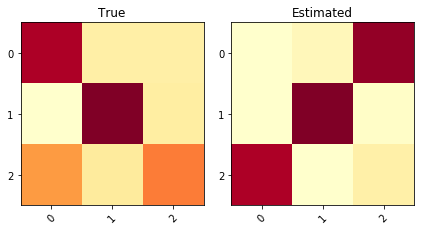

KL divergence: 1.5012	Pearson Correlation between diagonals: 0.5843


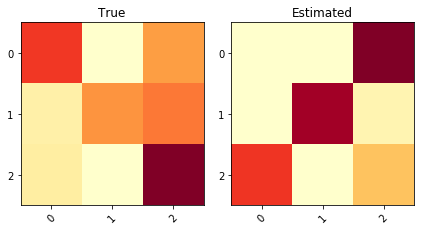

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


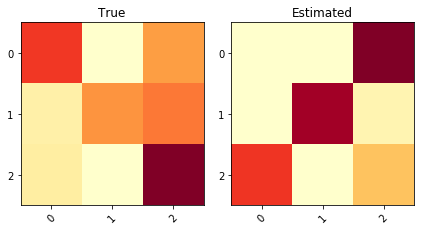

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


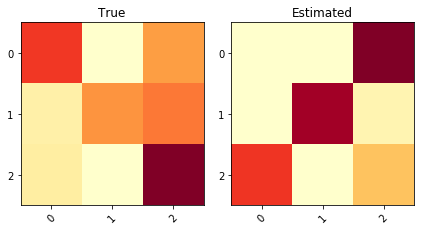

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


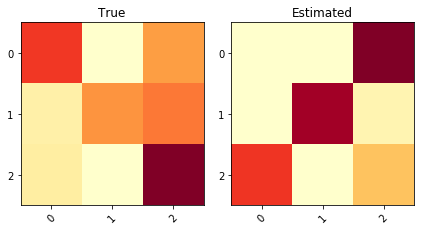

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.387464      0.387464    1.46138   0.203843           -0.344831       0.0975104
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.661312                0.727459
====  =======================  ======================
Test


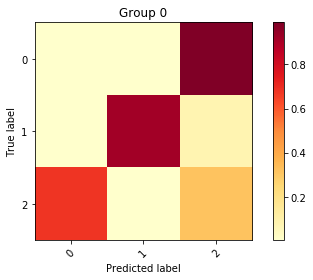

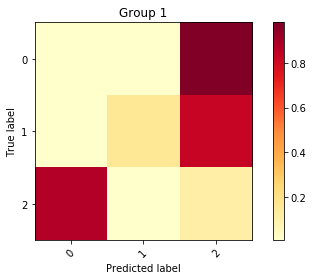

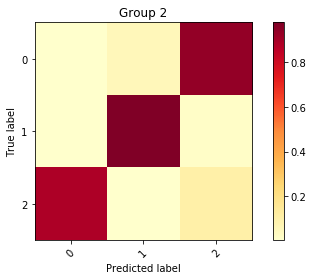

Inertia: 0.09433624582986037
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  0.548259      54   0.332222    0.413273     2.34267       0.499222   0.0799397    0.802198      0.802198
   1         1  0.16093       16   0.34057     0.0939899    2.8462        0.213318  -0.239343     0.630037      0.630037
   2         2  0.290811      29   0.252397    0.363872     2.39851       0.424208   0.0305391    0.882784      0.882784
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  

In [34]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#con tol 2
832723/ 0,612666 #pre init 5
862027 / 0,567259 #pre init 1
904762 / 0,480586 # pre init 0

In [ ]:
#con tol 3
873016/0,465721 #pre init 5
344322/1,2807 #pre init 1
882784/0,609833 #pre init 0

*** Ours (2) multiples runs***
Train


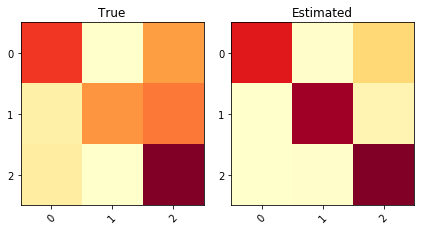

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


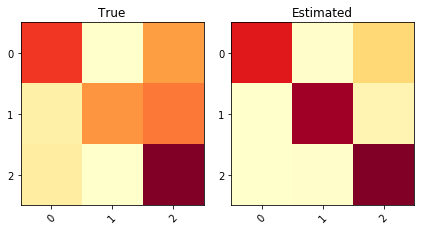

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


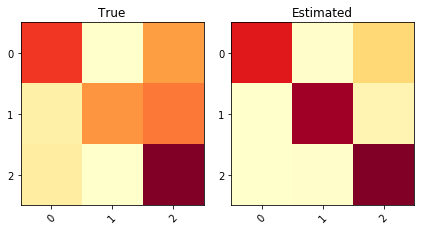

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


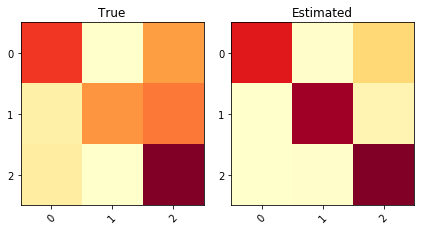

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


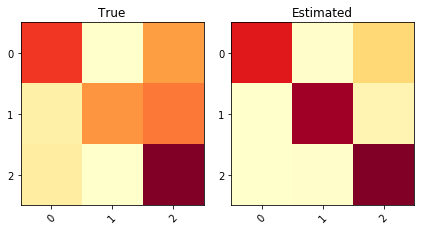

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


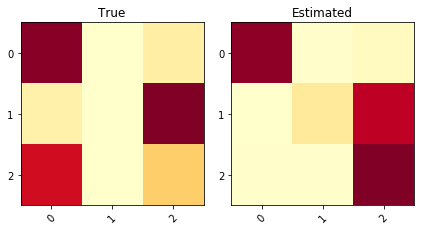

KL divergence: 1.1035	Pearson Correlation between diagonals: 0.6998


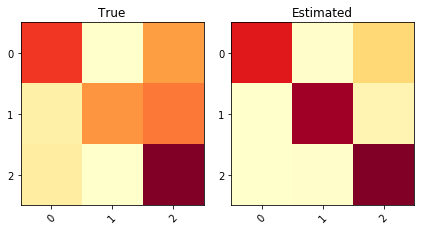

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


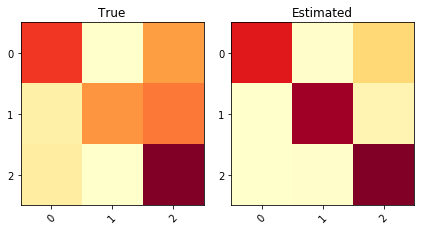

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


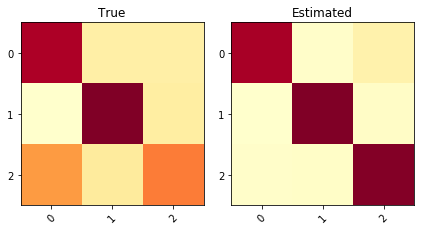

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431


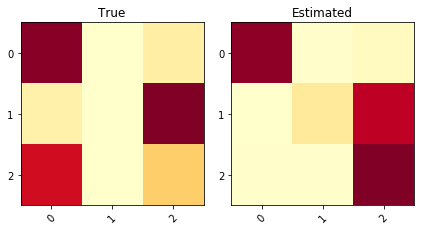

KL divergence: 1.1035	Pearson Correlation between diagonals: 0.6998


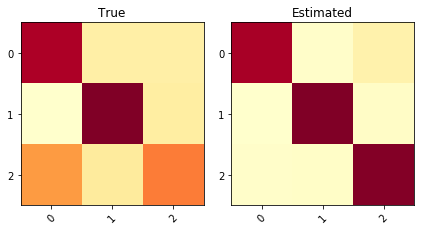

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431


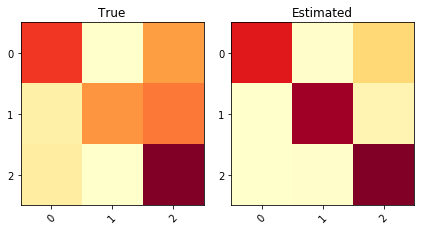

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


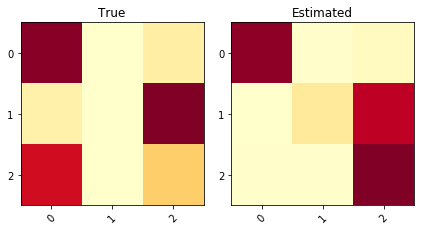

KL divergence: 1.1035	Pearson Correlation between diagonals: 0.6998


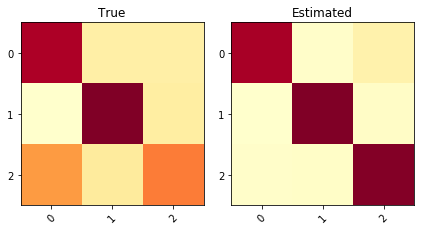

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431


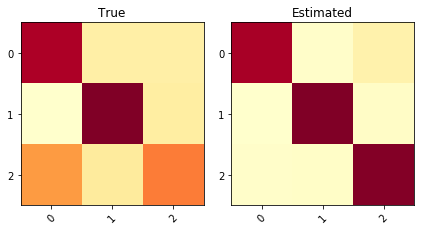

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.892552      0.892552   0.600229  0.0875265            0.289699       0.0963832
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.658511                 0.73373
====  =======================  ======================
Test


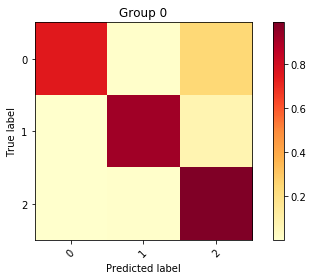

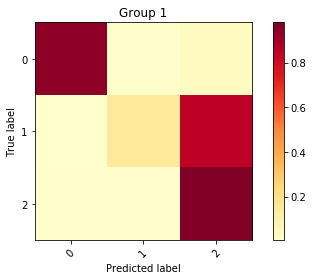

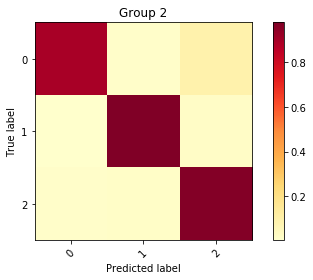

Inertia: 0.0972544342900316
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.544033      54   0.310449     0.8868    0.12712         0.938615   0.553466    0.84127       0.84127
   1         1  0.181161      18   0.261901     0.689919  0.675244        0.757545   0.356585    0.634921      0.634921
   2         2  0.274806      27   0.211517     0.948153  0.0540261       0.973305   0.614819    0.910867      0.910867
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =========

In [35]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

 870574 / 0,498641 #con tol2
942613 / 0,471945 #pre init 1
86569/0,579983 #pre init 0

In [ ]:
#con tol3
913309/ 0,539815 #pre init 5
879121/ 0,729936 #pre init 1
875458/ 0,663098 #pre init 0

*** Ours (3) multiples runs***
Train


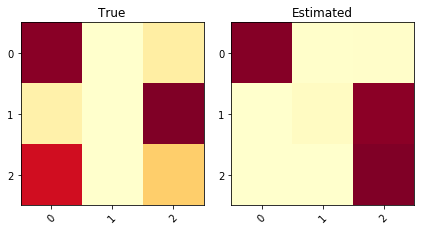

KL divergence: 1.1077	Pearson Correlation between diagonals: 0.7147


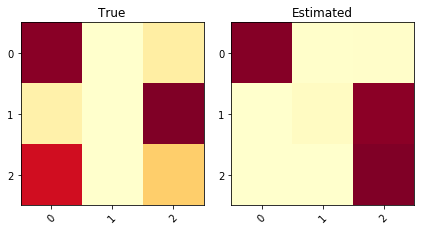

KL divergence: 1.1077	Pearson Correlation between diagonals: 0.7147


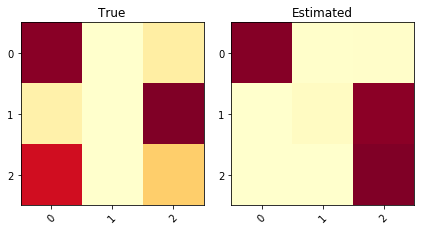

KL divergence: 1.1077	Pearson Correlation between diagonals: 0.7147


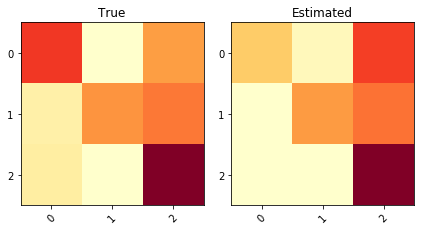

KL divergence: 0.1898	Pearson Correlation between diagonals: 0.8179


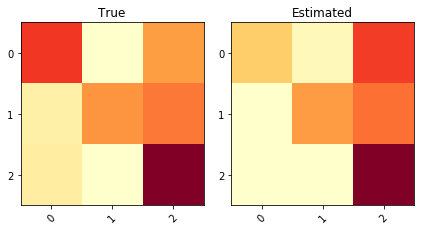

KL divergence: 0.1995	Pearson Correlation between diagonals: 0.8182


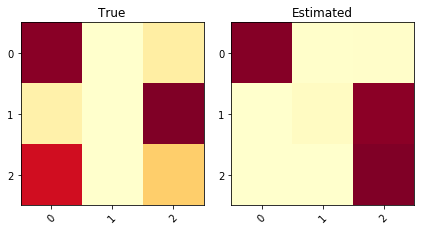

KL divergence: 1.1077	Pearson Correlation between diagonals: 0.7147


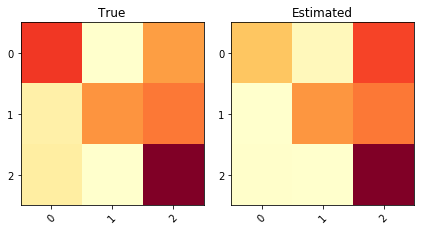

KL divergence: 0.1700	Pearson Correlation between diagonals: 0.8171


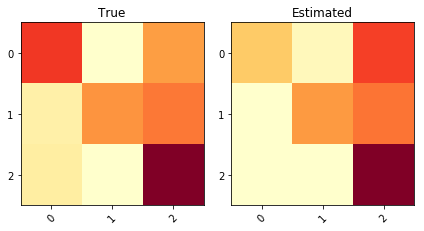

KL divergence: 0.1836	Pearson Correlation between diagonals: 0.8177


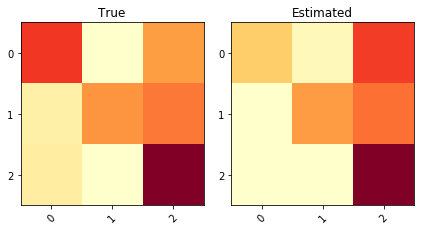

KL divergence: 0.1995	Pearson Correlation between diagonals: 0.8182


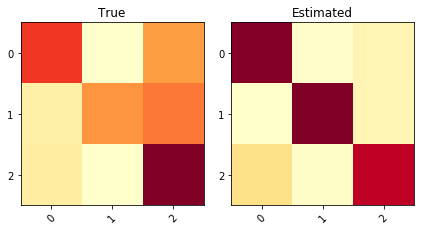

KL divergence: 0.4702	Pearson Correlation between diagonals: -0.9515


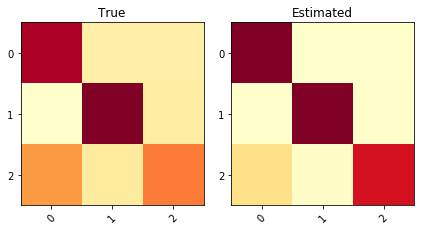

KL divergence: 0.3009	Pearson Correlation between diagonals: 0.9769


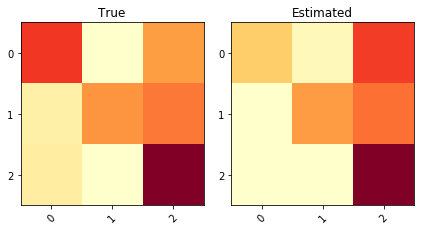

KL divergence: 0.1995	Pearson Correlation between diagonals: 0.8182


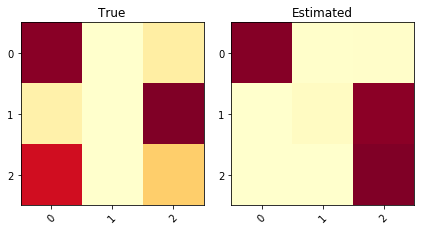

KL divergence: 1.1077	Pearson Correlation between diagonals: 0.7147


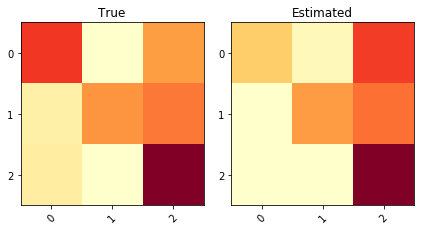

KL divergence: 0.1995	Pearson Correlation between diagonals: 0.8182


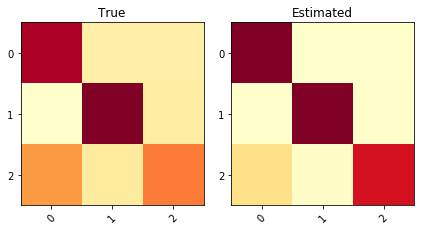

KL divergence: 0.3009	Pearson Correlation between diagonals: 0.9769
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.910867      0.910867   0.459293  0.0662452            0.716152        0.228595
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.640465                0.768422
====  =======================  ======================
Test


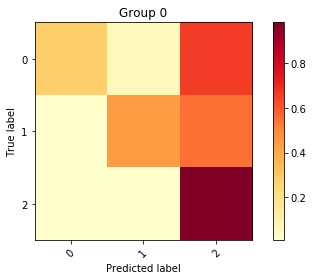

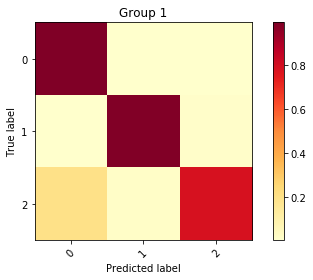

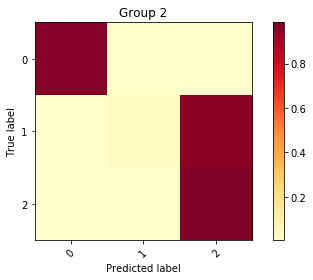

Inertia: 0.19025912011663118
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.162713      16   0.537339     0.57069   0.694911        0.708186   0.356035    0.333333      0.333333
   1         1  0.55725       55   0.2354       0.921022  0.0881624       0.957336   0.881533    0.832723      0.832723
   2         2  0.280036      28   0.137522     0.663131  1.15601         0.694186   0.494697    0.638584      0.638584
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [26]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


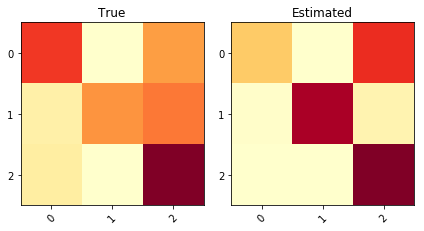

KL divergence: 0.3884	Pearson Correlation between diagonals: 0.2418


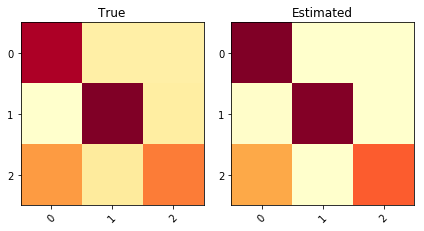

KL divergence: 0.2972	Pearson Correlation between diagonals: 0.9771


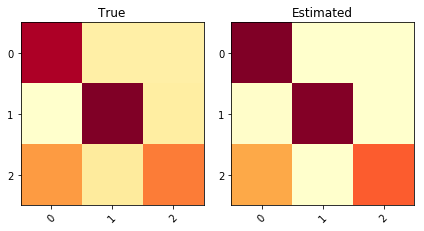

KL divergence: 0.2972	Pearson Correlation between diagonals: 0.9771


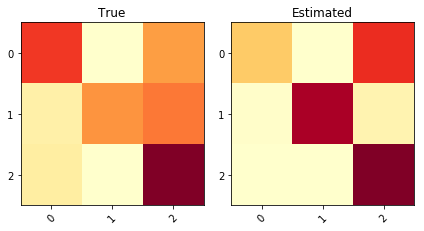

KL divergence: 0.3884	Pearson Correlation between diagonals: 0.2418


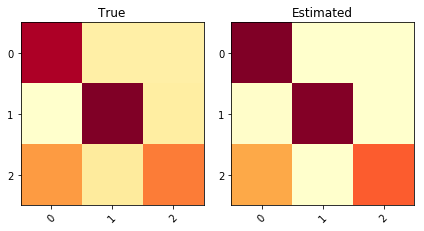

KL divergence: 0.2972	Pearson Correlation between diagonals: 0.9771


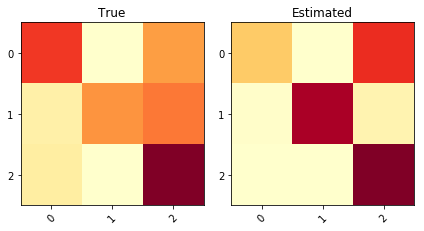

KL divergence: 0.3884	Pearson Correlation between diagonals: 0.2418


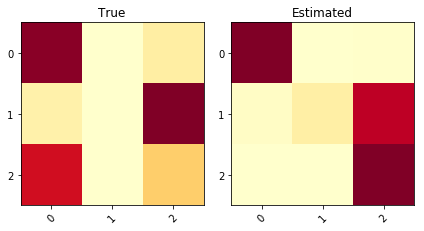

KL divergence: 1.3780	Pearson Correlation between diagonals: 0.7206


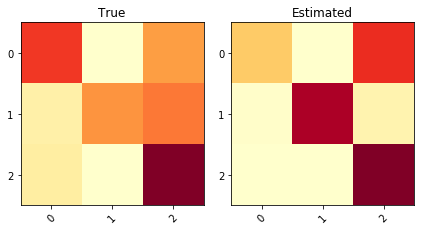

KL divergence: 0.3872	Pearson Correlation between diagonals: 0.2427


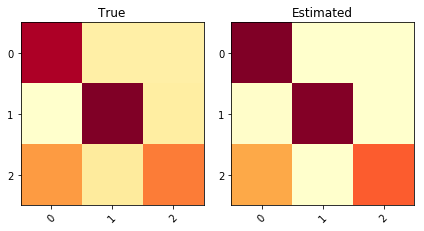

KL divergence: 0.2972	Pearson Correlation between diagonals: 0.9771


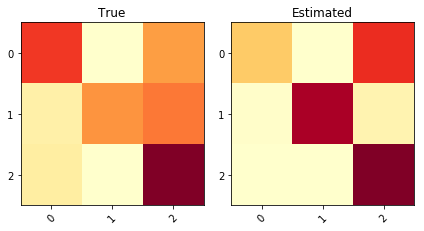

KL divergence: 0.3884	Pearson Correlation between diagonals: 0.2418


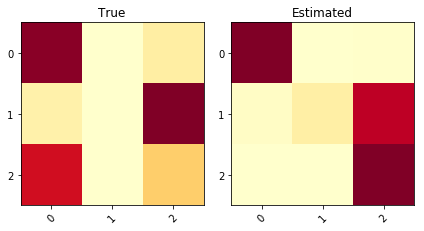

KL divergence: 1.3780	Pearson Correlation between diagonals: 0.7206


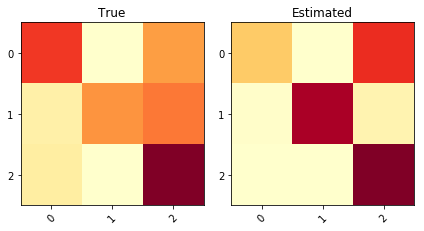

KL divergence: 0.3884	Pearson Correlation between diagonals: 0.2418


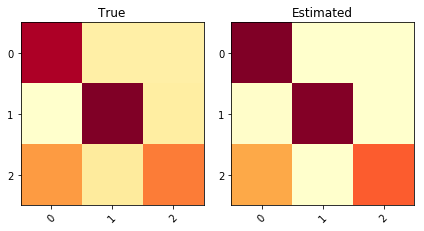

KL divergence: 0.2972	Pearson Correlation between diagonals: 0.9771


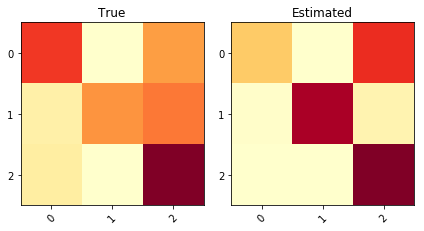

KL divergence: 0.3884	Pearson Correlation between diagonals: 0.2418


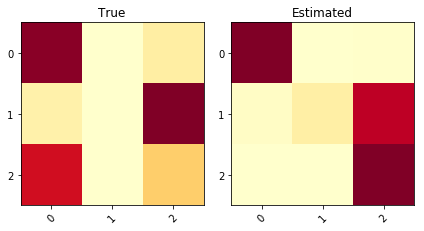

KL divergence: 1.3780	Pearson Correlation between diagonals: 0.7206
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.923891      0.923891    0.57712   0.081307            0.541391       0.0803617
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                  0.62676                0.787907
====  =======================  ======================
Test


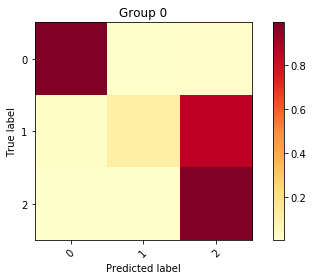

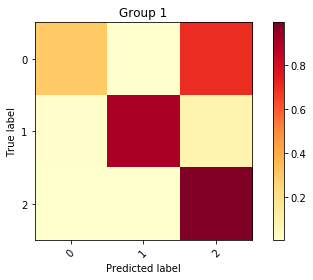

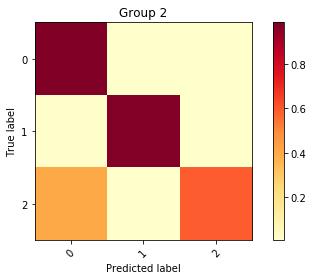

Inertia: 0.2033955380320549
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.444607      44   0.182219     0.699368   0.736557       0.751375   0.549052    0.64591       0.64591
   1         1  0.28917       28   0.345951     0.730698   0.442753       0.816051   0.596047    0.606838      0.606838
   2         2  0.266223      26   0.292072     0.854036   0.184655       0.91432    0.781054    0.655678      0.655678
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =========

In [18]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
#con tol2
84127 /  0,944489
875458 / 0,695265 #pre init 1
935287 / 0,411736 #pre init 0

In [ ]:
#con tol3
923077 / 0,579925 #pre init 5
925519 / 0,433611 #pre init 1
369963 / 1,47762 #pre init 0

#### 2) configuration: very bad MV ($T$ = 100, $T_{max}$ = 10 )

In [52]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.6581196581196581


*** Soft-Majority (Train with softMV) ***
Train


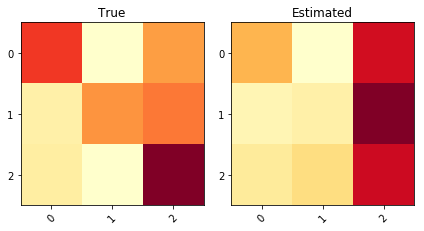

KL divergence: 0.2514	Pearson Correlation between diagonals: 0.9996


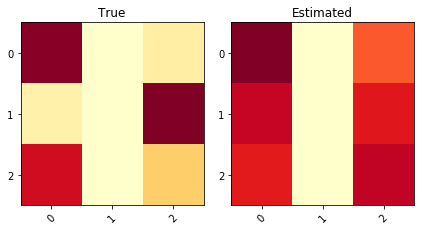

KL divergence: 0.2643	Pearson Correlation between diagonals: 0.8072


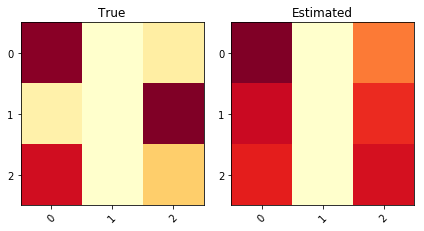

KL divergence: 0.2560	Pearson Correlation between diagonals: 0.8426


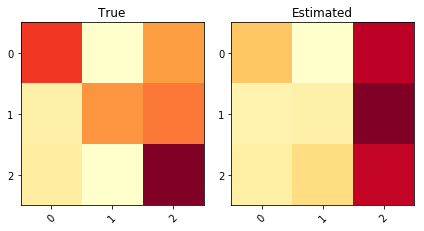

KL divergence: 0.2651	Pearson Correlation between diagonals: 0.9924


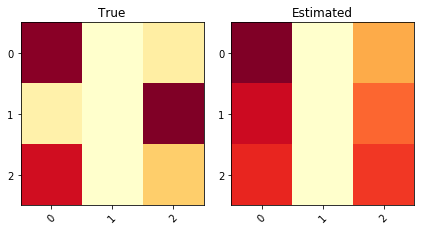

KL divergence: 0.2546	Pearson Correlation between diagonals: 0.9044


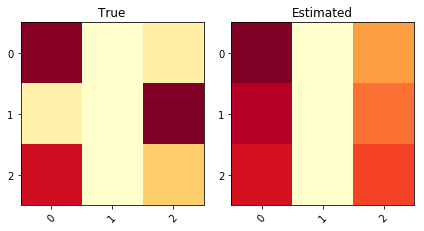

KL divergence: 0.2712	Pearson Correlation between diagonals: 0.9170


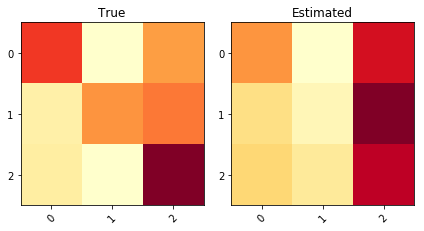

KL divergence: 0.2525	Pearson Correlation between diagonals: 0.9912


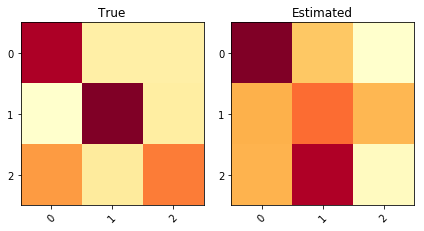

KL divergence: 0.3978	Pearson Correlation between diagonals: 0.7899


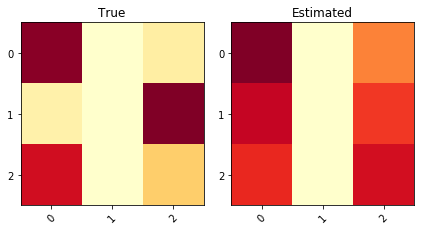

KL divergence: 0.2663	Pearson Correlation between diagonals: 0.8391


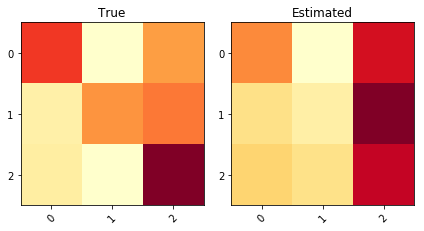

KL divergence: 0.2458	Pearson Correlation between diagonals: 0.9852


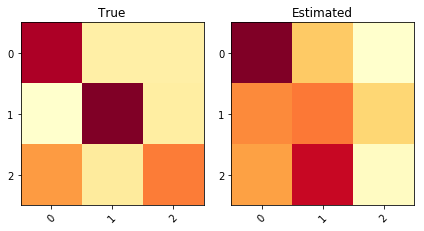

KL divergence: 0.4023	Pearson Correlation between diagonals: 0.7746


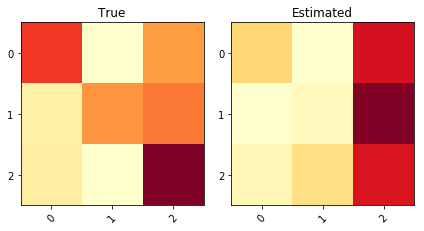

KL divergence: 0.2859	Pearson Correlation between diagonals: 0.9935


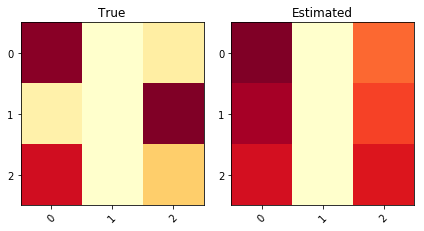

KL divergence: 0.2814	Pearson Correlation between diagonals: 0.8554


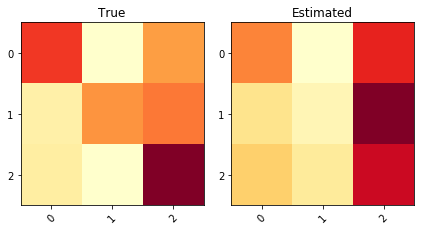

KL divergence: 0.2463	Pearson Correlation between diagonals: 0.9718


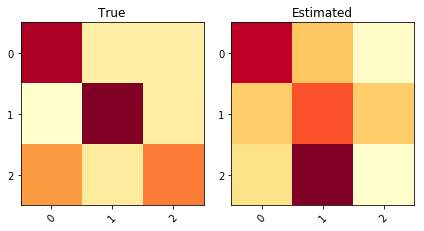

KL divergence: 0.4060	Pearson Correlation between diagonals: 0.8878
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.46398       0.46398   0.304018  0.0837234            0.890157
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.498168      0.498168
====  ======  ==========  ============


In [53]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


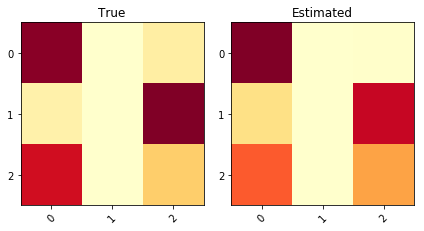

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9884


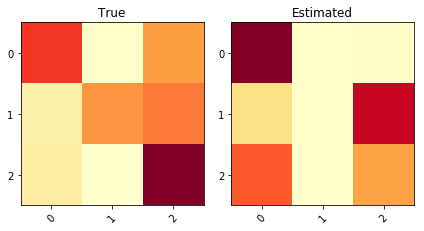

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.3049


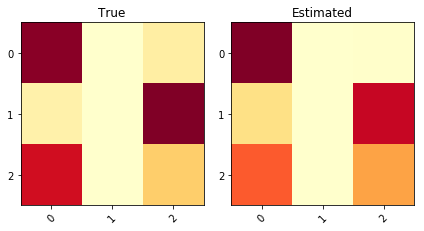

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9884


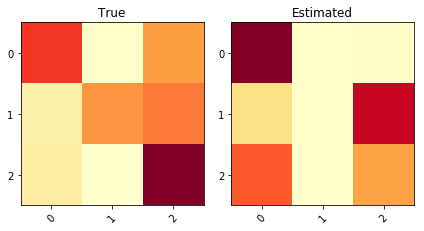

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.3049


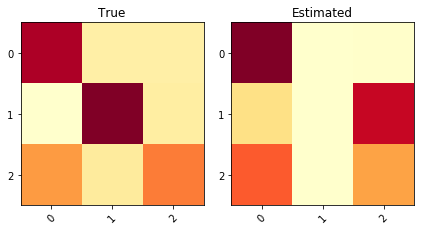

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.1070


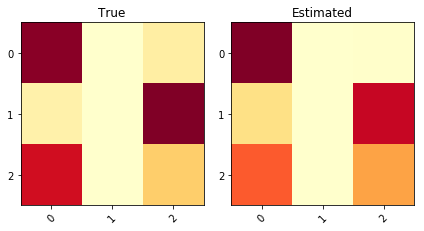

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9884


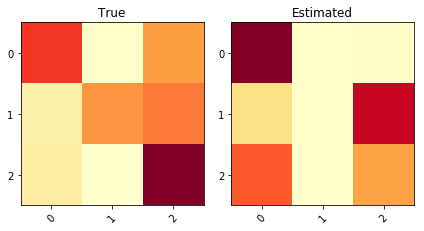

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.3049


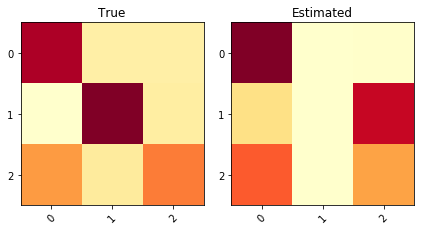

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.1070


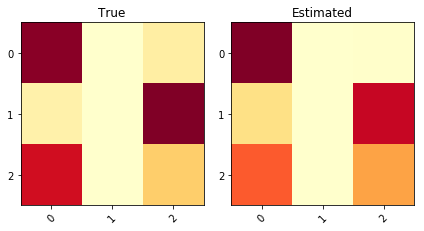

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9884


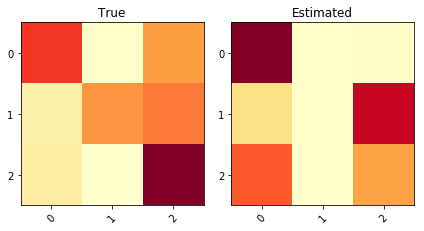

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.3049


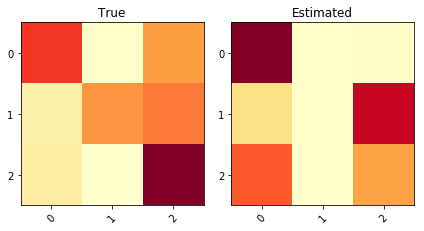

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.3049


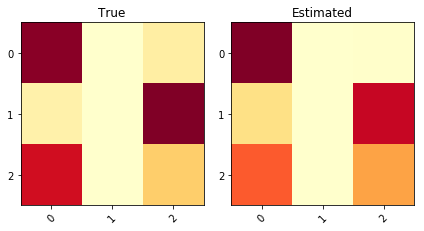

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9884


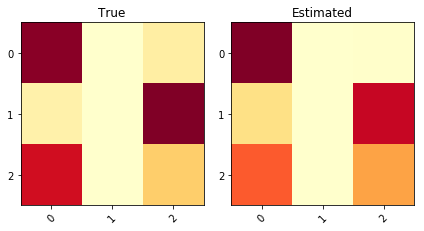

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9884


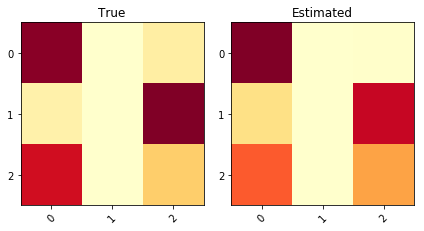

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9884


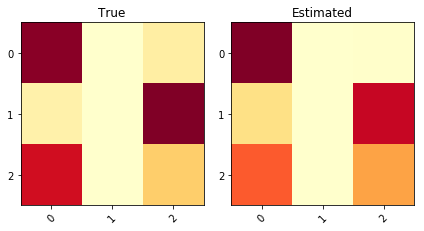

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9884
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.46398       0.46398    2.75888   0.153648            0.416436
====  ======  ==========  ============  =========  =========  ==================


In [54]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


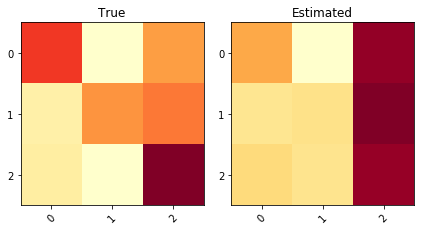

KL divergence: 0.2332	Pearson Correlation between diagonals: 0.9920


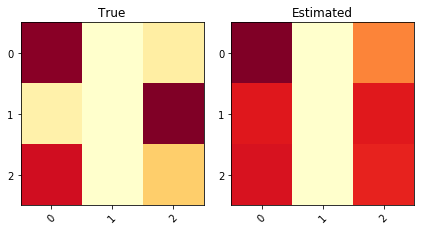

KL divergence: 0.2176	Pearson Correlation between diagonals: 0.8796


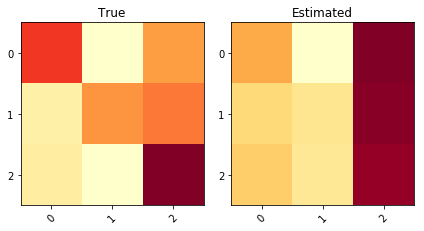

KL divergence: 0.2465	Pearson Correlation between diagonals: 0.9935


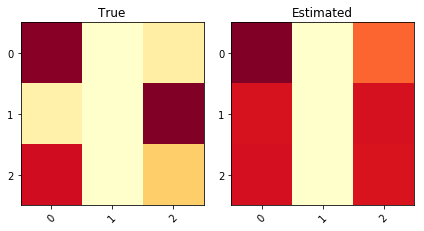

KL divergence: 0.2300	Pearson Correlation between diagonals: 0.8524


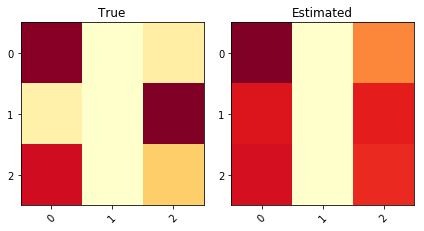

KL divergence: 0.2207	Pearson Correlation between diagonals: 0.8864


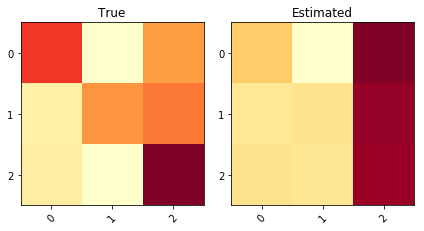

KL divergence: 0.2514	Pearson Correlation between diagonals: 0.9676


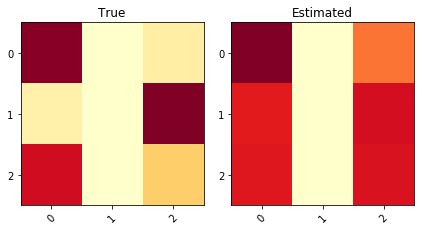

KL divergence: 0.2211	Pearson Correlation between diagonals: 0.8492


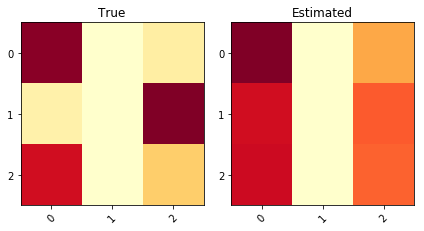

KL divergence: 0.2296	Pearson Correlation between diagonals: 0.9439


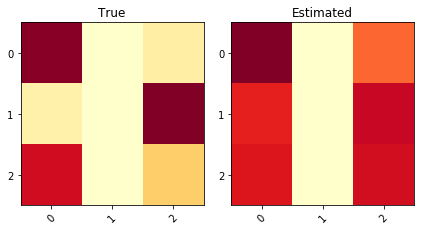

KL divergence: 0.2190	Pearson Correlation between diagonals: 0.8379


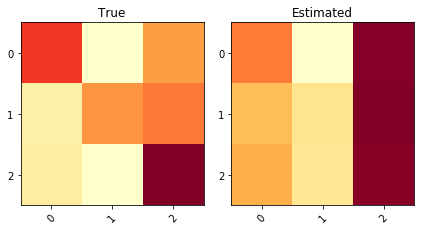

KL divergence: 0.2427	Pearson Correlation between diagonals: 0.9982


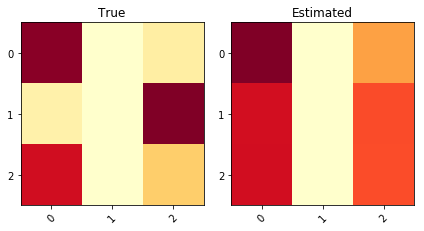

KL divergence: 0.2286	Pearson Correlation between diagonals: 0.9269


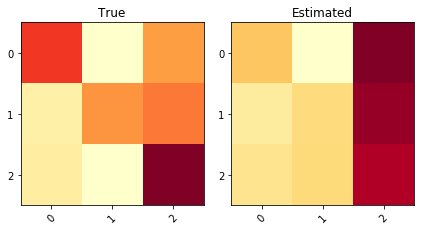

KL divergence: 0.2557	Pearson Correlation between diagonals: 0.9597


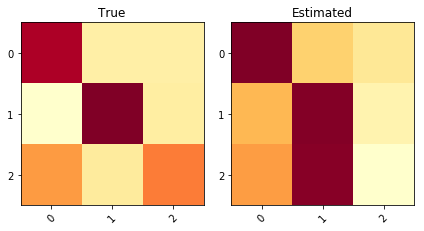

KL divergence: 0.3574	Pearson Correlation between diagonals: 0.9798


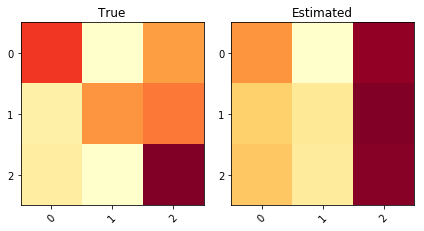

KL divergence: 0.2312	Pearson Correlation between diagonals: 1.0000


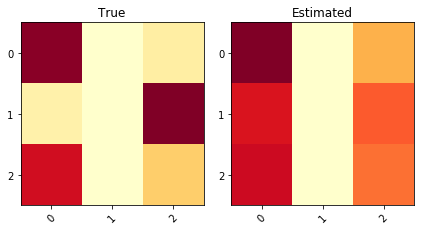

KL divergence: 0.2175	Pearson Correlation between diagonals: 0.9540
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.460317      0.460317   0.270593  0.0754019            0.938948
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.471306      0.471306
====  ======  ==========  ============


In [55]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


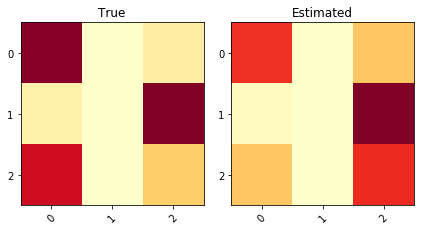

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7093


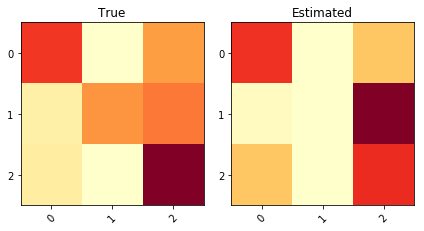

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.8074


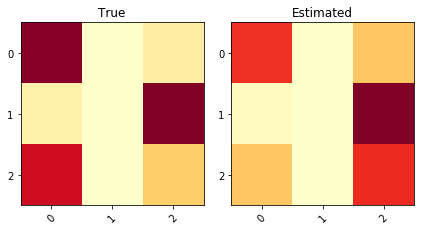

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7093


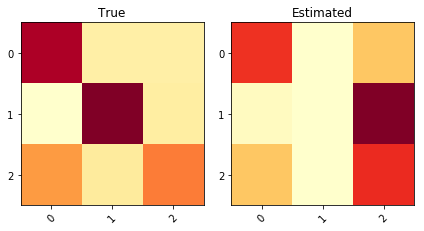

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.6722


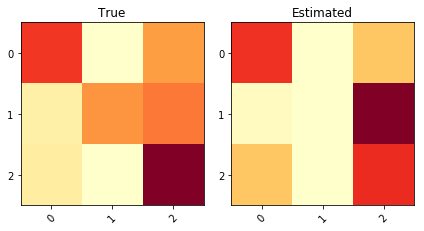

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.8074


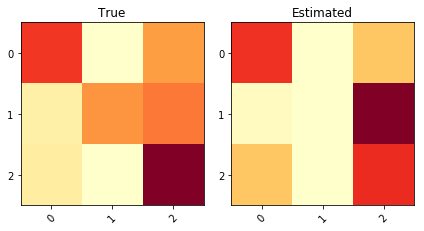

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.8074


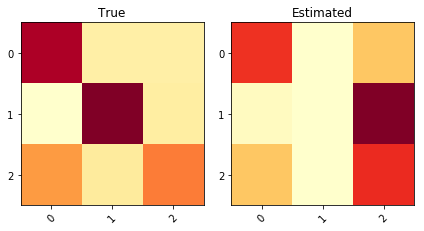

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.6722


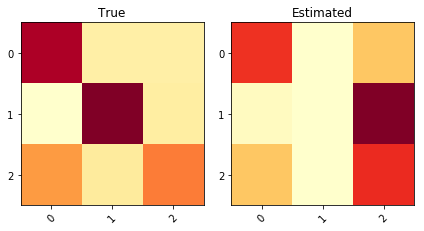

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.6722


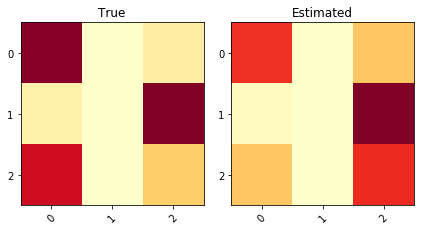

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7093


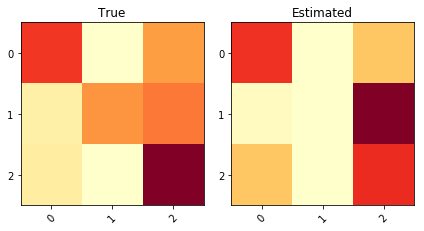

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.8074


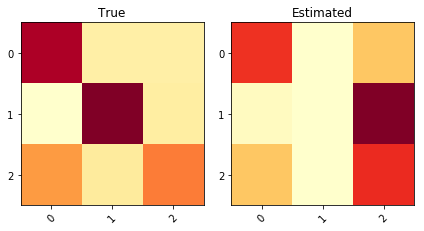

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.6722


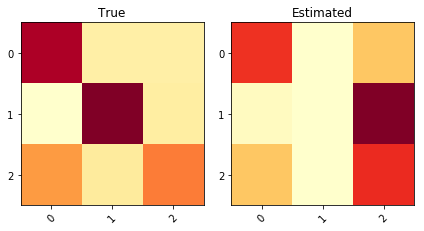

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.6722


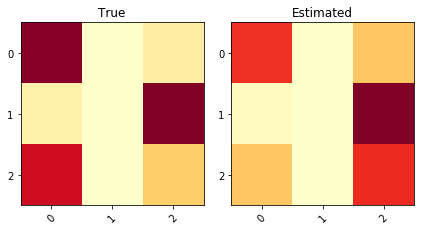

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7093


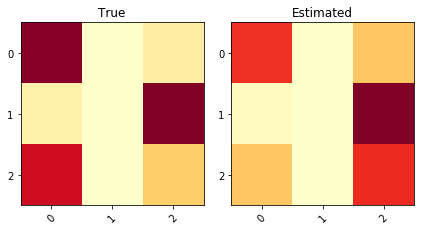

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7093


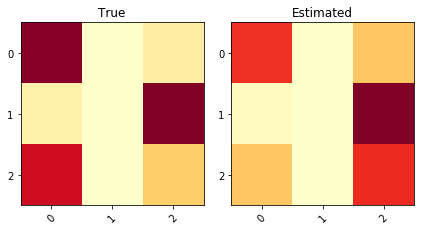

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.7093
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.460317      0.460317    2.75888   0.153648            0.314396
====  ======  ==========  ============  =========  =========  ==================


In [56]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


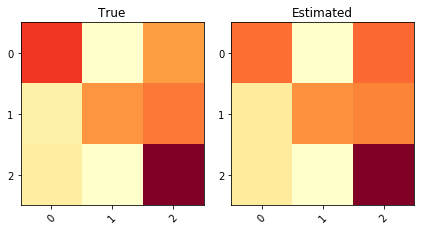

KL divergence: 0.0100	Pearson Correlation between diagonals: 0.9680


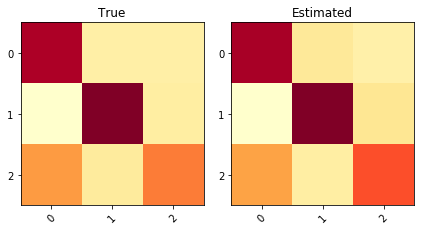

KL divergence: 0.0057	Pearson Correlation between diagonals: 0.9998


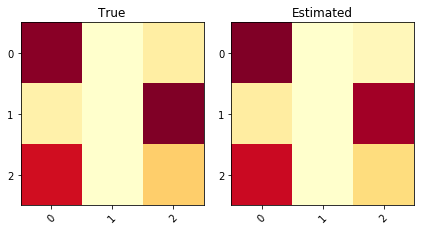

KL divergence: 0.0116	Pearson Correlation between diagonals: 0.9976


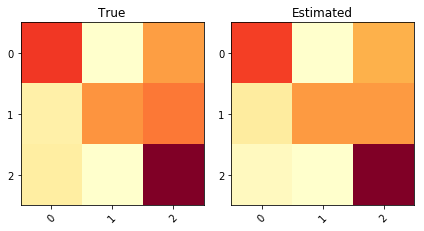

KL divergence: 0.0175	Pearson Correlation between diagonals: 0.9999


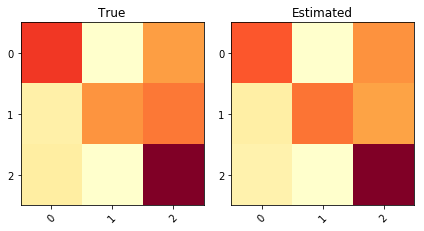

KL divergence: 0.0089	Pearson Correlation between diagonals: 0.9618


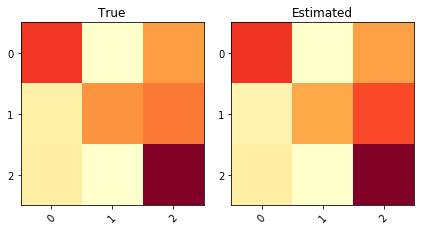

KL divergence: 0.0044	Pearson Correlation between diagonals: 0.9956


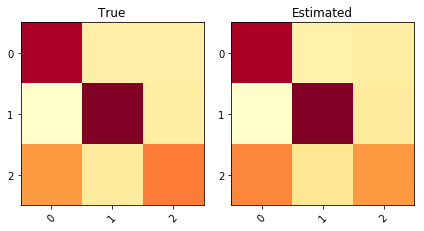

KL divergence: 0.0044	Pearson Correlation between diagonals: 0.9991


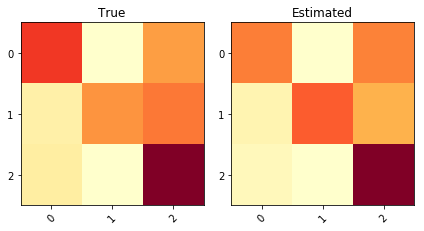

KL divergence: 0.0313	Pearson Correlation between diagonals: 0.8633


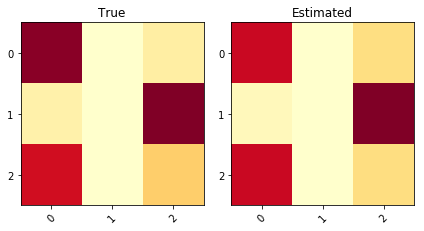

KL divergence: 0.0186	Pearson Correlation between diagonals: 0.9995


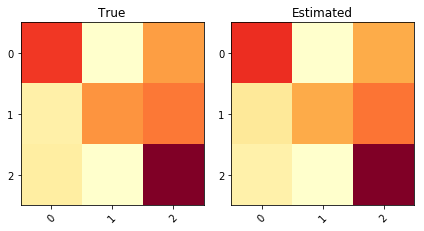

KL divergence: 0.0058	Pearson Correlation between diagonals: 0.9912


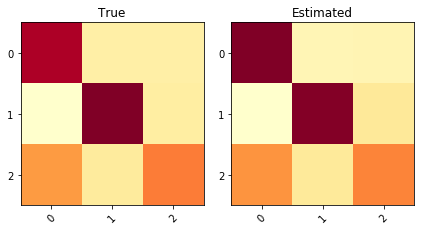

KL divergence: 0.0080	Pearson Correlation between diagonals: 0.9782


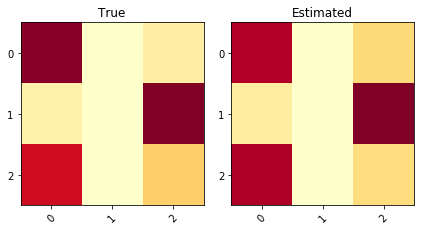

KL divergence: 0.0171	Pearson Correlation between diagonals: 0.9993


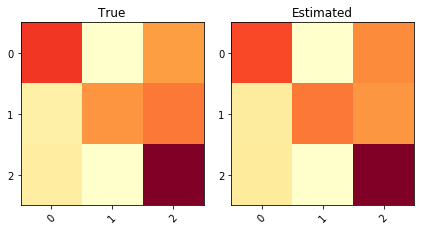

KL divergence: 0.0060	Pearson Correlation between diagonals: 0.9810


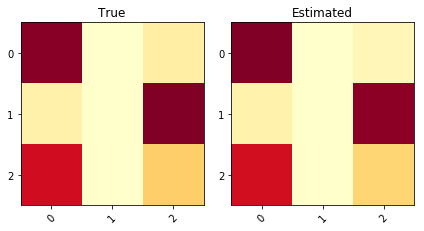

KL divergence: 0.0058	Pearson Correlation between diagonals: 0.9993


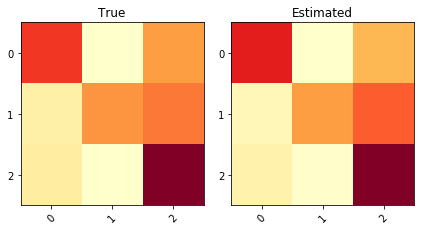

KL divergence: 0.0127	Pearson Correlation between diagonals: 0.9848
A result
 ====  ======  ==========  ============  =========  ==========  ==================
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  ==========  ==================
   0  Global    0.563696      0.563696  0.0132856  0.00254635             0.99066
====  ======  ==========  ============  =========  ==========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.556777      0.556777
====  ======  ==========  ============


In [57]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


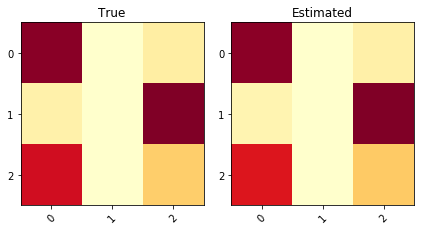

KL divergence: 0.0131	Pearson Correlation between diagonals: 0.9998


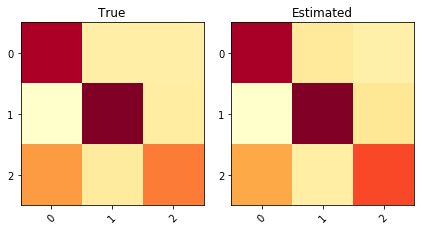

KL divergence: 0.0122	Pearson Correlation between diagonals: 0.9995


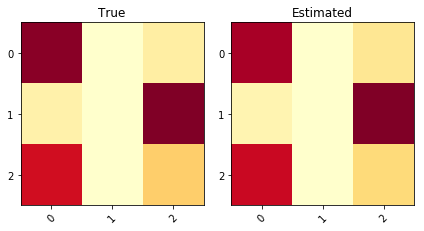

KL divergence: 0.0175	Pearson Correlation between diagonals: 0.9995


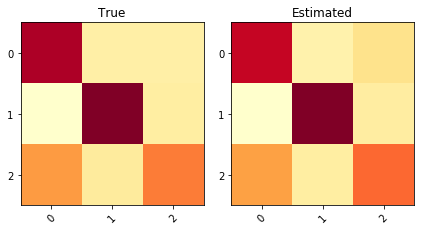

KL divergence: 0.0124	Pearson Correlation between diagonals: 0.9858


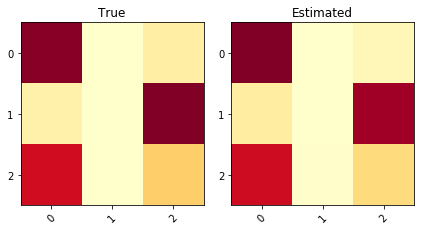

KL divergence: 0.0207	Pearson Correlation between diagonals: 0.9982


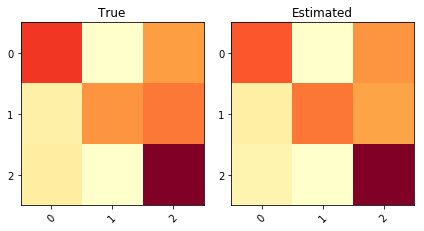

KL divergence: 0.0168	Pearson Correlation between diagonals: 0.9628


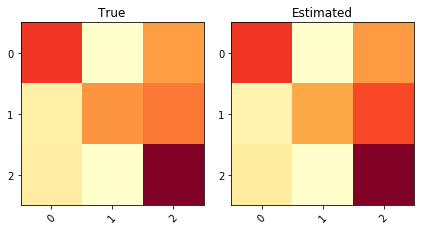

KL divergence: 0.0121	Pearson Correlation between diagonals: 0.9967


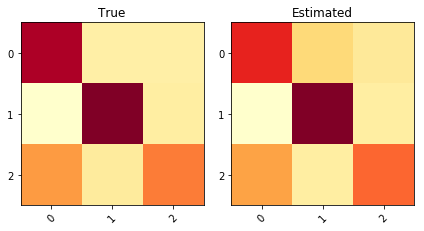

KL divergence: 0.0279	Pearson Correlation between diagonals: 0.8841


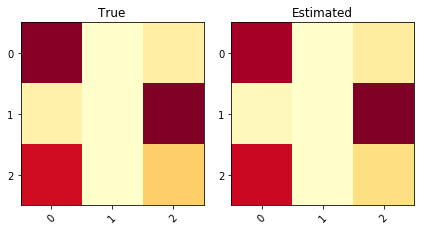

KL divergence: 0.0170	Pearson Correlation between diagonals: 0.9980


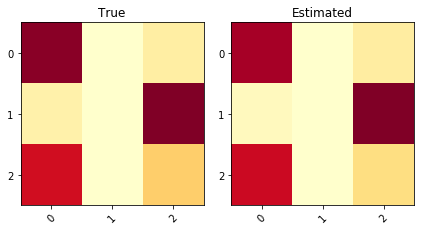

KL divergence: 0.0194	Pearson Correlation between diagonals: 0.9980


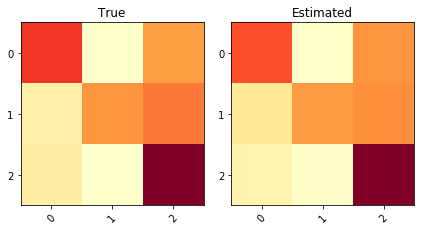

KL divergence: 0.0150	Pearson Correlation between diagonals: 0.9962


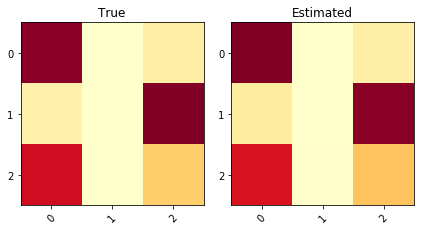

KL divergence: 0.0145	Pearson Correlation between diagonals: 0.9995


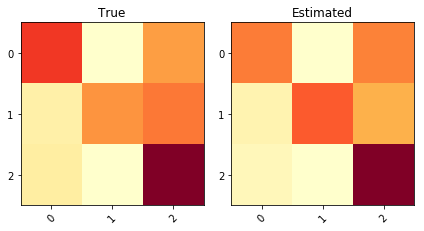

KL divergence: 0.0337	Pearson Correlation between diagonals: 0.8622


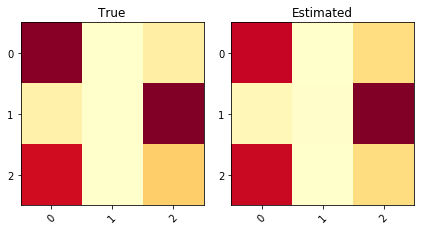

KL divergence: 0.0302	Pearson Correlation between diagonals: 0.9995


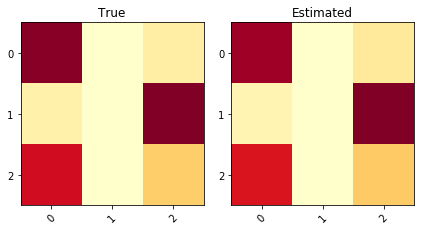

KL divergence: 0.0137	Pearson Correlation between diagonals: 0.9994
A result
 ====  ======  ==========  ============  =========  ==========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  ==========  ==================  ==============
   0  Global    0.869353      0.869353  0.0171091  0.00504889            0.989911         0.17495
====  ======  ==========  ============  =========  ==========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.705212                0.712247
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.

In [58]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


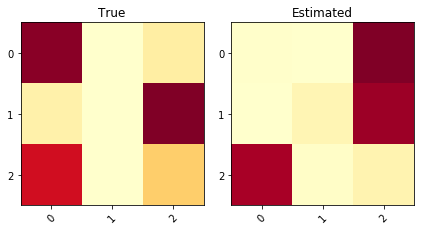

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


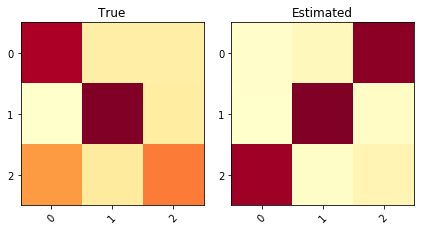

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093


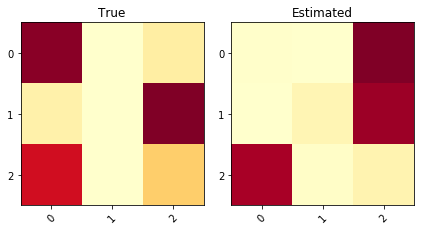

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


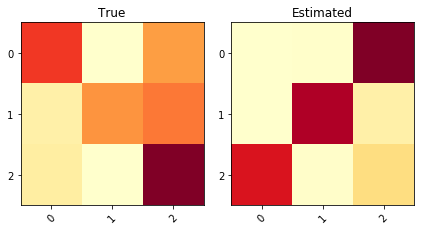

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


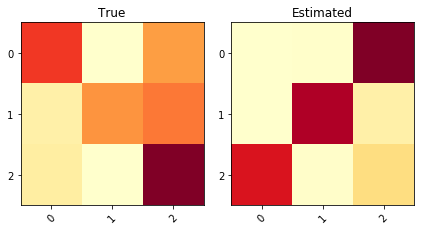

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


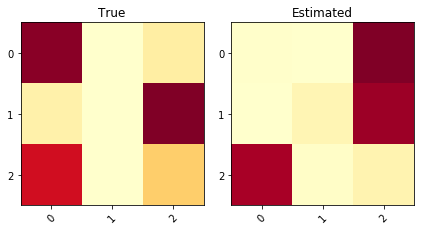

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


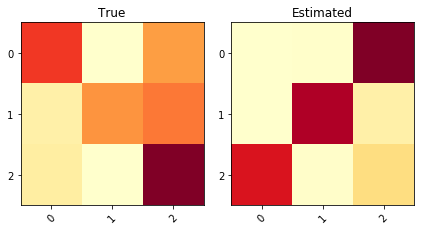

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


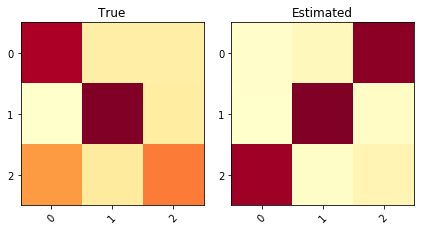

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093


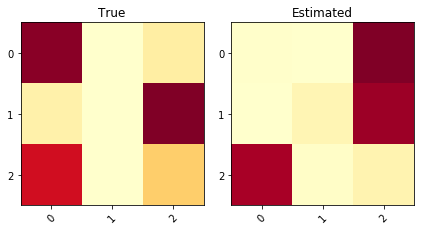

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


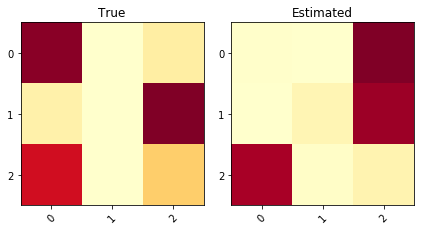

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


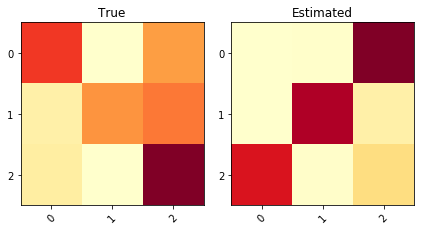

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


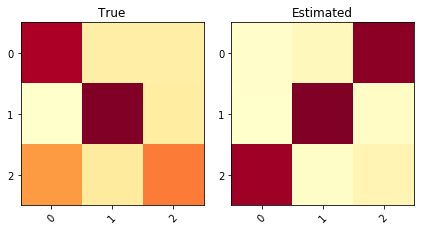

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093


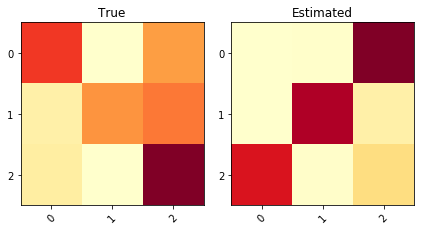

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


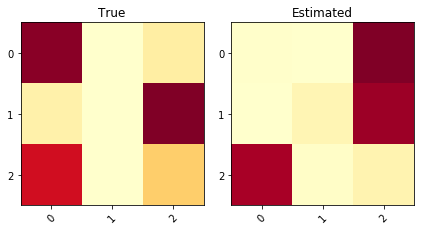

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


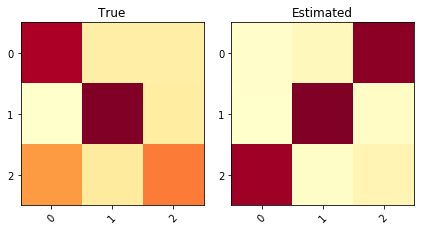

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.597884      0.597884     1.5097   0.208986           -0.348053        0.148848
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.680813                0.703747
====  =======================  ======================
Test


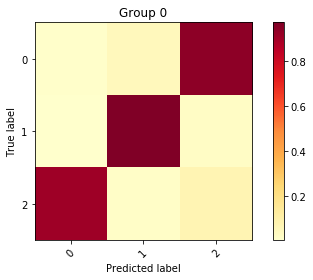

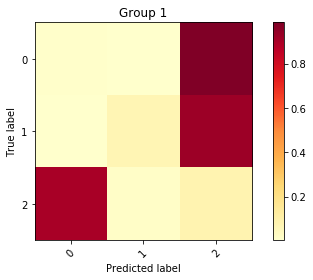

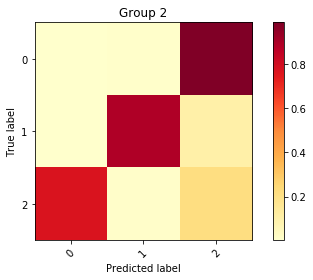

Inertia: 0.10848995065316558
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  0.326825      32   0.232576    0.351229     2.55813       0.402764   0.0178953    0.711844      0.711844
   1         1  0.286561      28   0.236939    0.0529269    3.31976       0.14267   -0.280406     0.565324      0.565324
   2         2  0.386613      38   0.336965    0.371128     2.42394       0.457802   0.0377947    0.896215      0.896215
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  

In [59]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


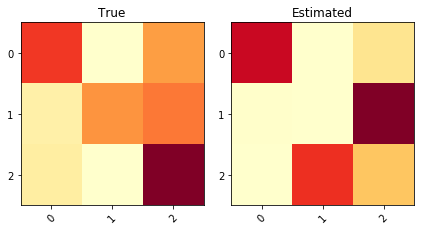

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


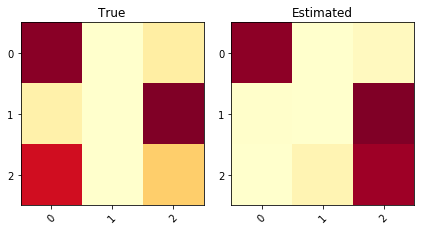

KL divergence: 1.3390	Pearson Correlation between diagonals: 0.7449


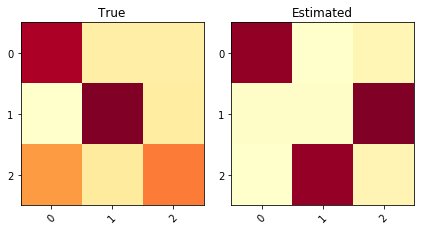

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


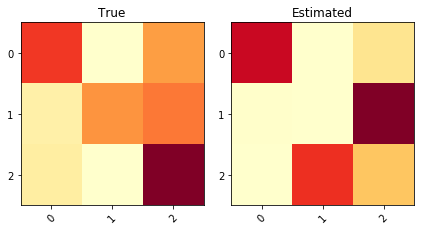

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


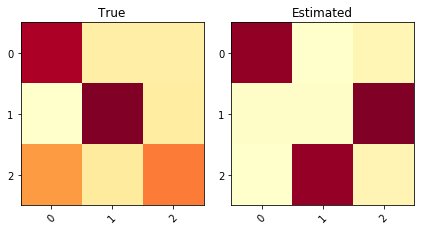

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


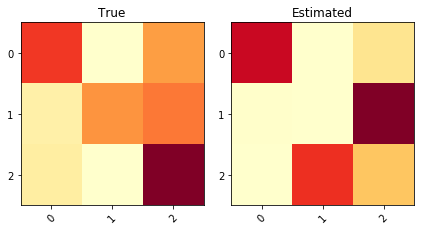

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


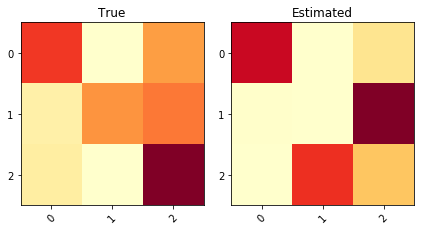

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


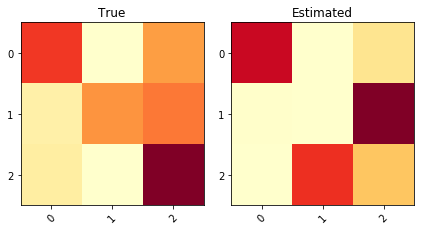

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


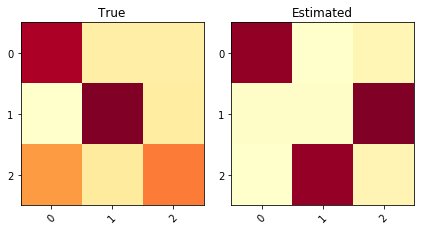

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


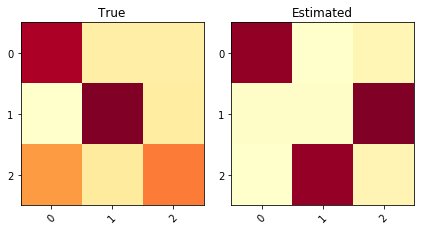

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


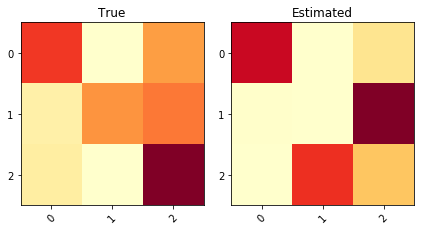

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


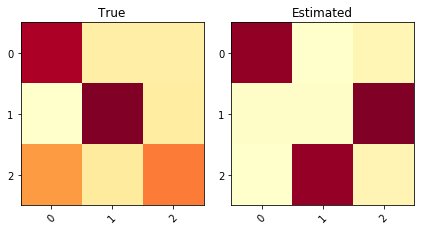

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


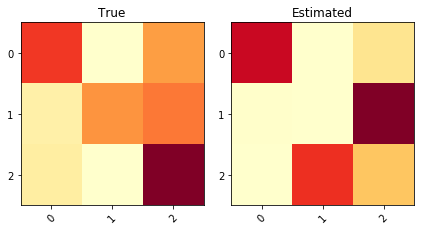

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


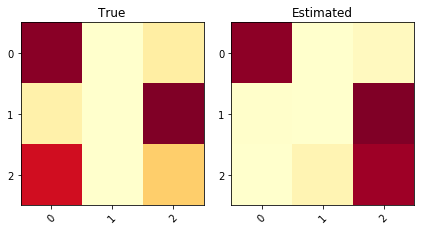

KL divergence: 1.3390	Pearson Correlation between diagonals: 0.7449


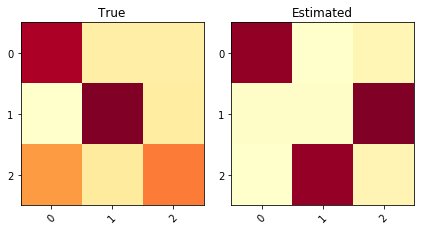

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.350834      0.350834     1.4957   0.205557            0.428808        0.150335
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.677046                0.699032
====  =======================  ======================
Test


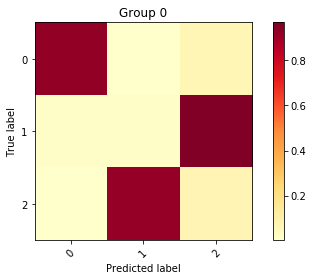

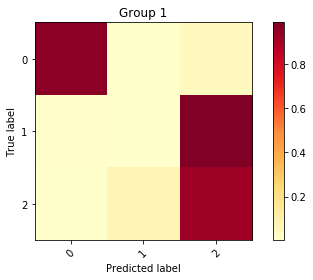

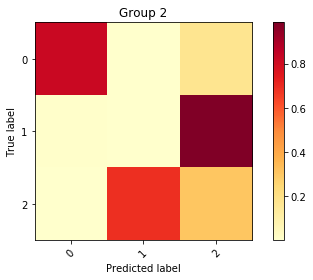

Inertia: 0.08358287128309409
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.300226      30   0.236477     0.338454    2.29225       0.403617  0.0051209    0.808303      0.808303
   1         1  0.337198      33   0.176395     0.628844    1.98815       0.651583  0.29551      0.579976      0.579976
   2         2  0.362576      36   0.398023     0.378613    2.25763       0.48055   0.0452801    0.796093      0.796093
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [60]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


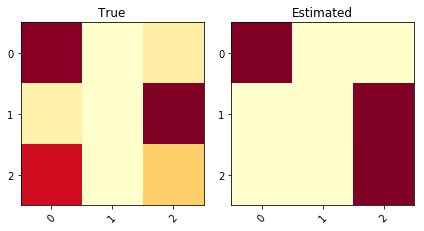

KL divergence: 1.3048	Pearson Correlation between diagonals: 0.7229


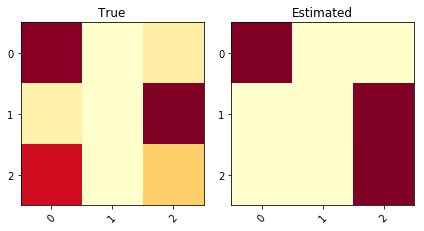

KL divergence: 1.3048	Pearson Correlation between diagonals: 0.7229


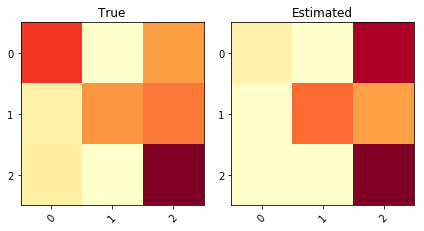

KL divergence: 0.3432	Pearson Correlation between diagonals: 0.5849


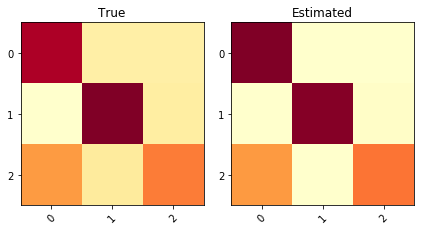

KL divergence: 0.3292	Pearson Correlation between diagonals: 0.9758


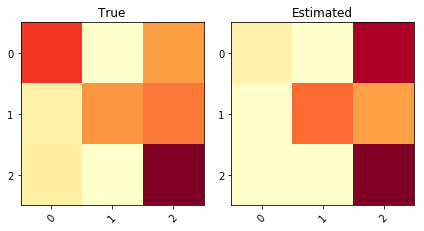

KL divergence: 0.3432	Pearson Correlation between diagonals: 0.5849


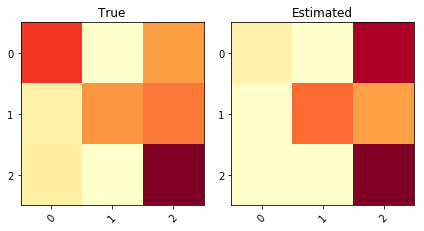

KL divergence: 0.3432	Pearson Correlation between diagonals: 0.5849


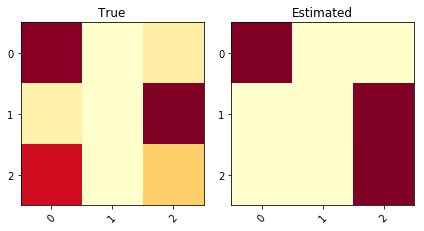

KL divergence: 1.3048	Pearson Correlation between diagonals: 0.7229


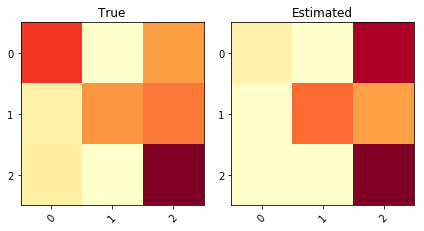

KL divergence: 0.3432	Pearson Correlation between diagonals: 0.5849


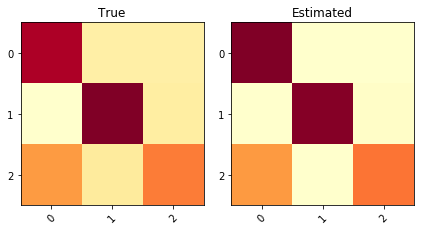

KL divergence: 0.3292	Pearson Correlation between diagonals: 0.9758


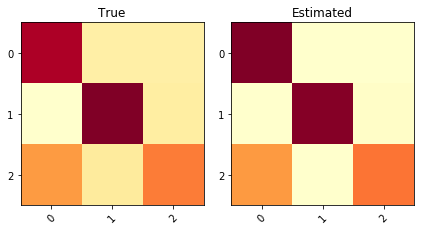

KL divergence: 0.3292	Pearson Correlation between diagonals: 0.9758


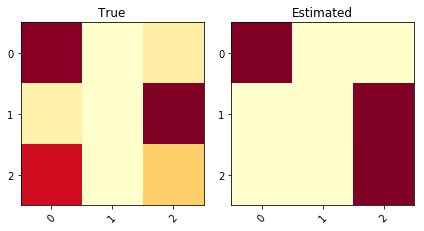

KL divergence: 1.3048	Pearson Correlation between diagonals: 0.7229


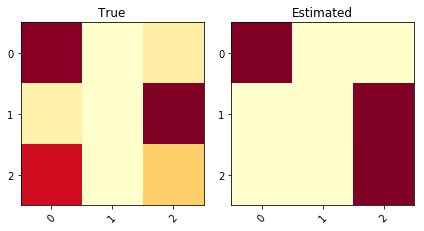

KL divergence: 1.3048	Pearson Correlation between diagonals: 0.7229


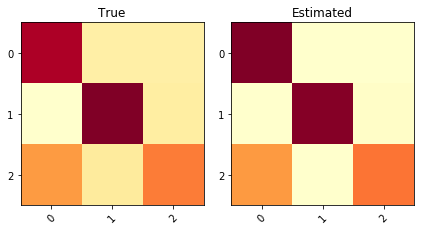

KL divergence: 0.3292	Pearson Correlation between diagonals: 0.9758


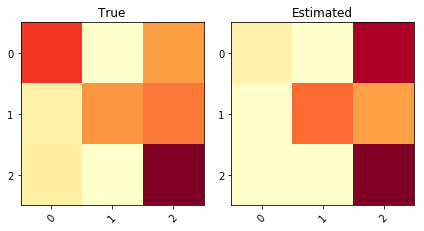

KL divergence: 0.3432	Pearson Correlation between diagonals: 0.5849


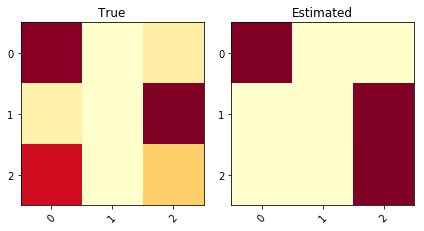

KL divergence: 1.3048	Pearson Correlation between diagonals: 0.7229
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.703297      0.703297   0.713709  0.0863449            0.763827        0.176454
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.665468                0.741963
====  =======================  ======================
Test


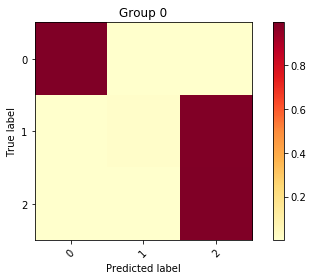

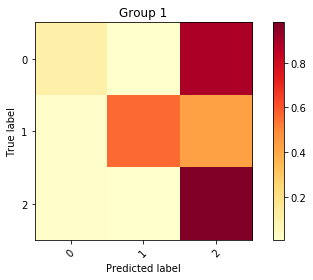

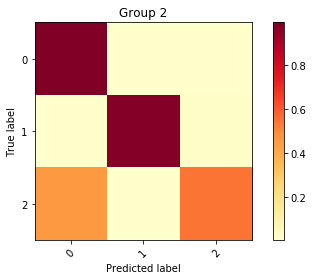

Inertia: 0.26256543149550754
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.487909      48  0.0519765     0.66575    1.56482        0.677321   0.498625    0.637363      0.637363
   1         1  0.135051      13  0.402072      0.548278   0.957684       0.657437   0.322416    0.384615      0.384615
   2         2  0.37704       37  0.284825      0.83972    0.210915       0.903512   0.759579    0.661783      0.661783
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [47]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


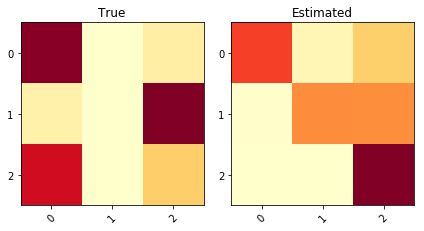

KL divergence: 1.0796	Pearson Correlation between diagonals: 0.0734


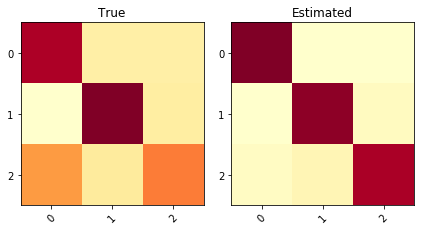

KL divergence: 0.4507	Pearson Correlation between diagonals: 0.8664


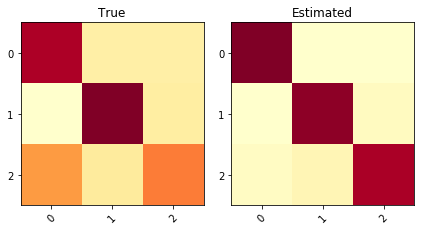

KL divergence: 0.4507	Pearson Correlation between diagonals: 0.8664


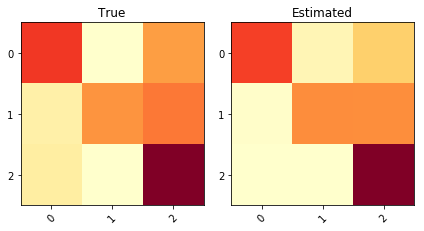

KL divergence: 0.0881	Pearson Correlation between diagonals: 0.9965


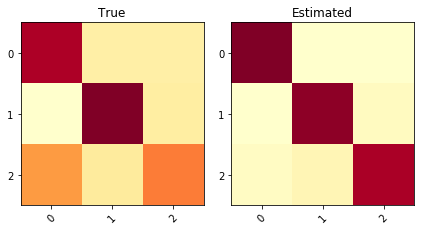

KL divergence: 0.4507	Pearson Correlation between diagonals: 0.8664


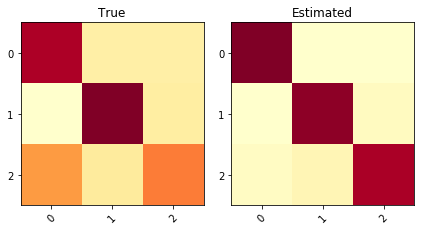

KL divergence: 0.4507	Pearson Correlation between diagonals: 0.8664


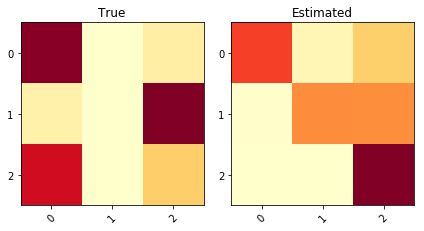

KL divergence: 1.0796	Pearson Correlation between diagonals: 0.0734


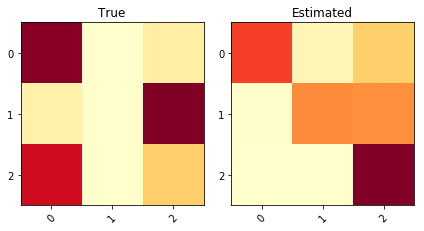

KL divergence: 1.0799	Pearson Correlation between diagonals: 0.0737


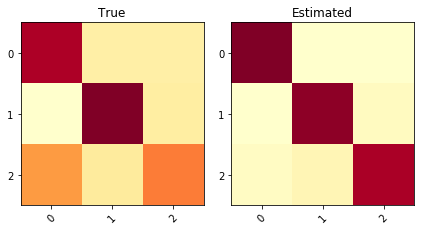

KL divergence: 0.4507	Pearson Correlation between diagonals: 0.8664


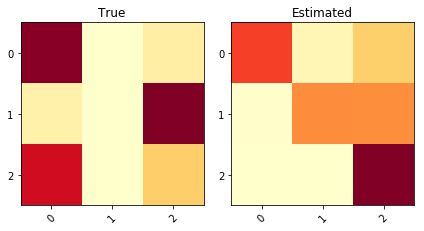

KL divergence: 1.0796	Pearson Correlation between diagonals: 0.0734


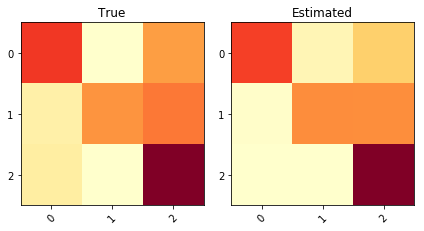

KL divergence: 0.0881	Pearson Correlation between diagonals: 0.9965


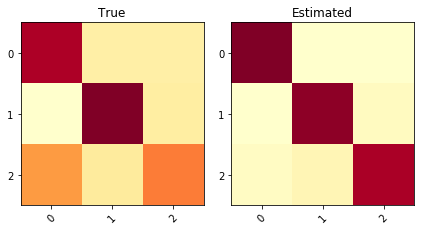

KL divergence: 0.4507	Pearson Correlation between diagonals: 0.8664


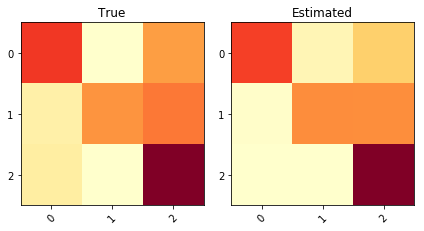

KL divergence: 0.0881	Pearson Correlation between diagonals: 0.9965


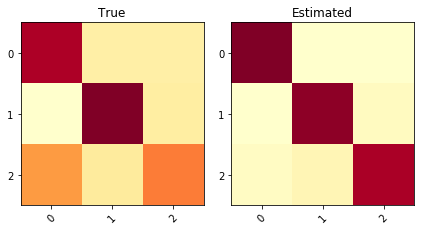

KL divergence: 0.4507	Pearson Correlation between diagonals: 0.8664


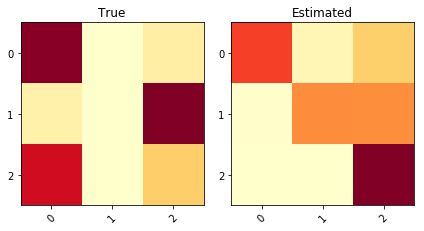

KL divergence: 1.0796	Pearson Correlation between diagonals: 0.0734
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.684575      0.684575   0.610547   0.111104            0.677797        0.116986
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.661664                0.783677
====  =======================  ======================
Test


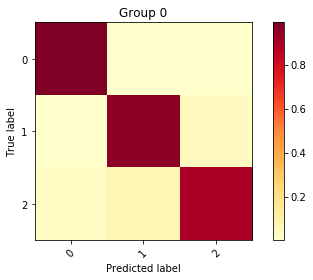

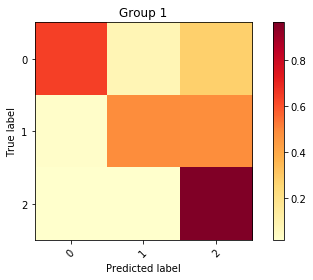

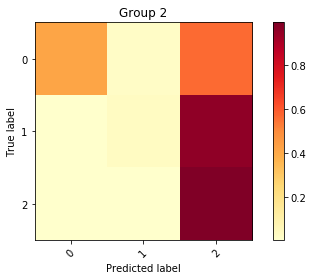

Inertia: 0.1483130088696877
A result
 ====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups       Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.617972       61   0.19536      0.953865  0.0479313       0.976295   0.930797    0.681319      0.681319
   1         1  0.0646778       6   0.610146     0.696576  0.400865        0.817007   0.544864    0.653236      0.653236
   2         2  0.31735        31   0.332586     0.479786  1.43188         0.572823   0.21968     0.333333      0.333333
====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =

In [23]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 3) configuration: normal soft ($T$ = 100, $T_{max}$ = 10, soft clustering )

In [77]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7806267806267806


*** Soft-Majority (Train with softMV) ***
Train


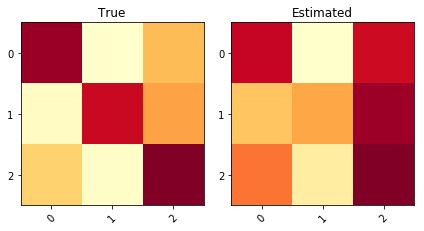

KL divergence: 0.2169	Pearson Correlation between diagonals: 0.9963


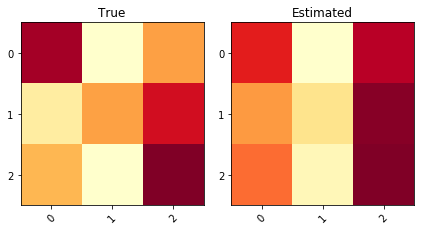

KL divergence: 0.1727	Pearson Correlation between diagonals: 0.9825


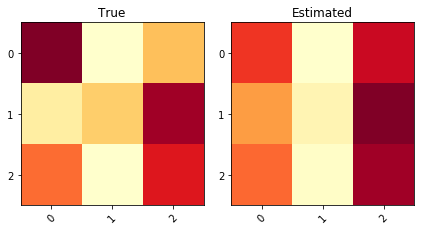

KL divergence: 0.1565	Pearson Correlation between diagonals: 0.8226


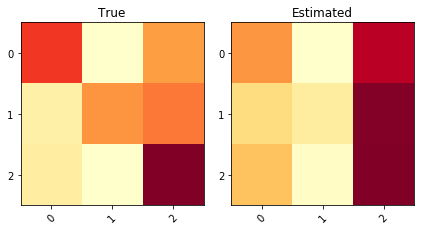

KL divergence: 0.2177	Pearson Correlation between diagonals: 1.0000


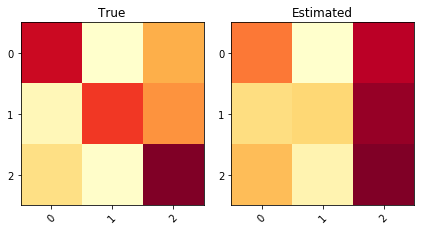

KL divergence: 0.2077	Pearson Correlation between diagonals: 0.9957


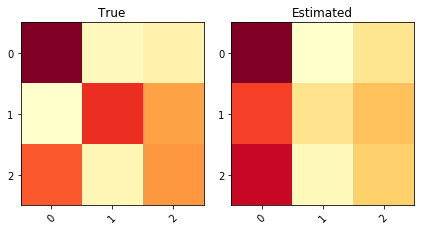

KL divergence: 0.2400	Pearson Correlation between diagonals: 0.8442


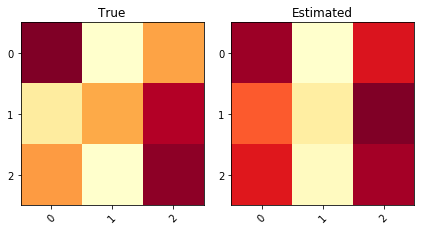

KL divergence: 0.1730	Pearson Correlation between diagonals: 0.9997


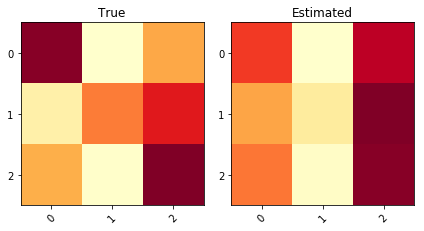

KL divergence: 0.1757	Pearson Correlation between diagonals: 0.9462


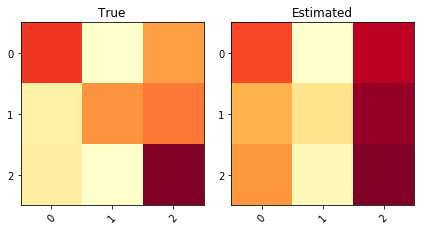

KL divergence: 0.2220	Pearson Correlation between diagonals: 0.9810


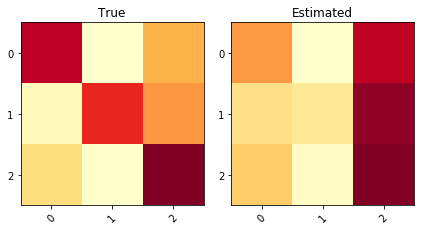

KL divergence: 0.2332	Pearson Correlation between diagonals: 0.9857


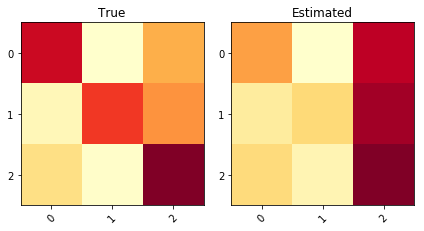

KL divergence: 0.2075	Pearson Correlation between diagonals: 0.9716


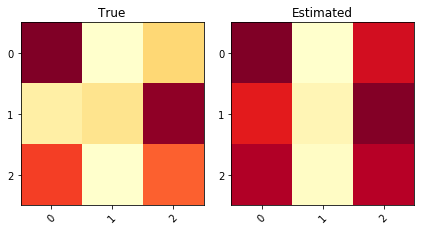

KL divergence: 0.1659	Pearson Correlation between diagonals: 0.9169


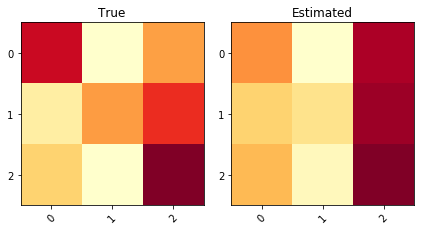

KL divergence: 0.1805	Pearson Correlation between diagonals: 0.9334


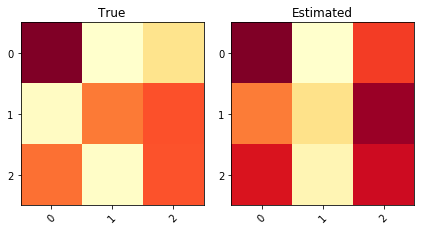

KL divergence: 0.1860	Pearson Correlation between diagonals: 0.7803


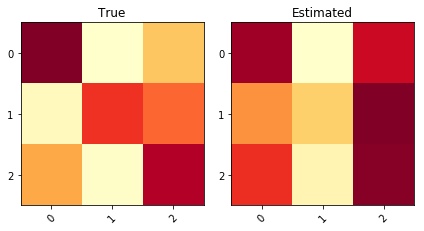

KL divergence: 0.1897	Pearson Correlation between diagonals: 0.9182
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.796907      0.796907   0.208223  0.0572833            0.896771
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.802198      0.802198
====  ======  ==========  ============


In [78]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


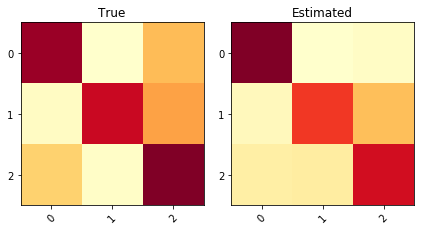

KL divergence: 0.4096	Pearson Correlation between diagonals: 0.5530


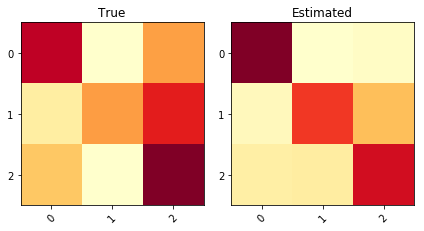

KL divergence: 0.2688	Pearson Correlation between diagonals: 0.6402


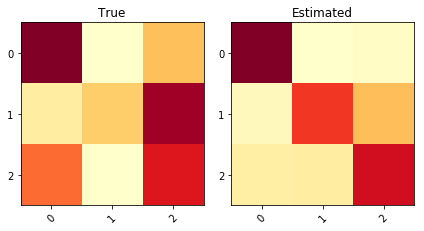

KL divergence: 0.2847	Pearson Correlation between diagonals: 0.9487


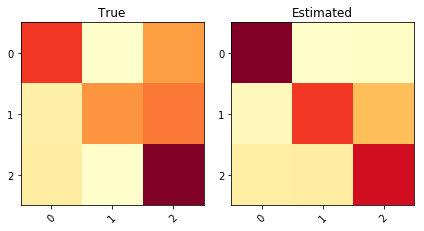

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


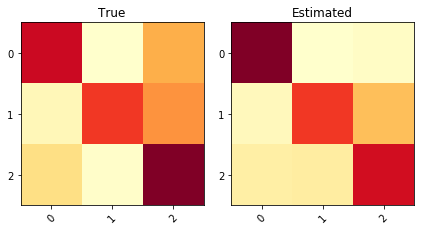

KL divergence: 0.3539	Pearson Correlation between diagonals: 0.3576


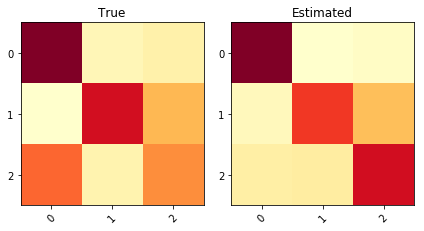

KL divergence: 0.6089	Pearson Correlation between diagonals: 0.4951


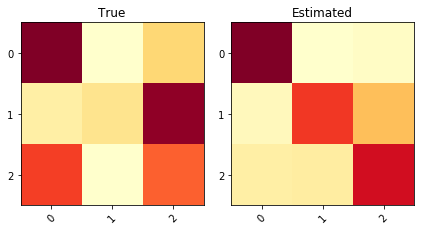

KL divergence: 0.3354	Pearson Correlation between diagonals: 0.9926


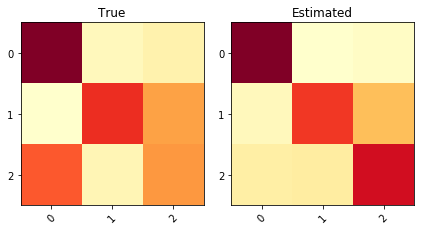

KL divergence: 0.5577	Pearson Correlation between diagonals: 0.6504


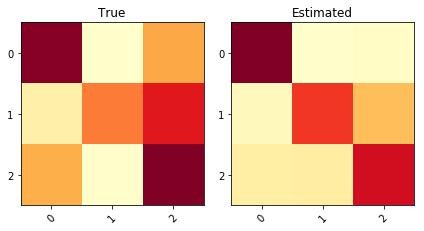

KL divergence: 0.2787	Pearson Correlation between diagonals: 0.7775


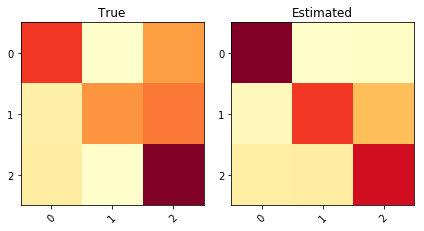

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


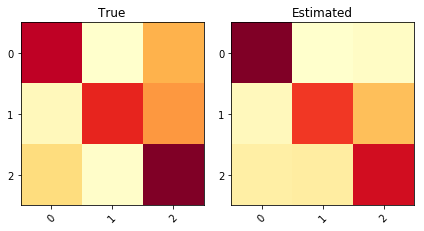

KL divergence: 0.3702	Pearson Correlation between diagonals: 0.3962


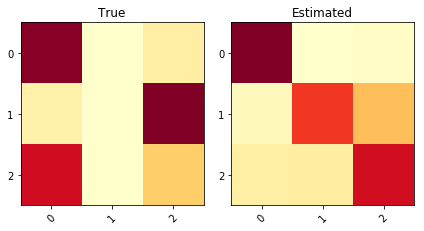

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.9930


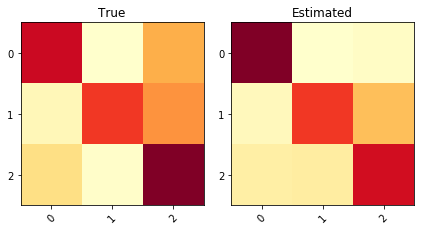

KL divergence: 0.3539	Pearson Correlation between diagonals: 0.3576


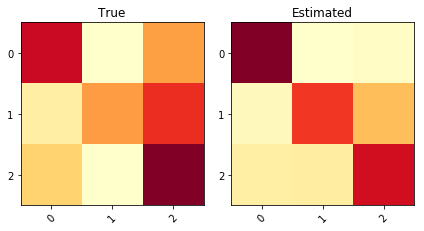

KL divergence: 0.2731	Pearson Correlation between diagonals: 0.5831


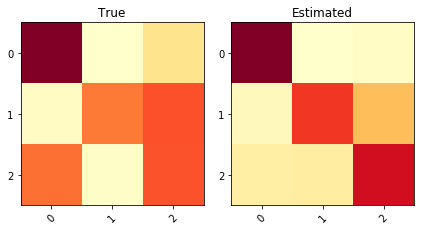

KL divergence: 0.3820	Pearson Correlation between diagonals: 0.9692
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.796907      0.796907    0.37778  0.0971699            0.617551
====  ======  ==========  ============  =========  =========  ==================


In [79]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


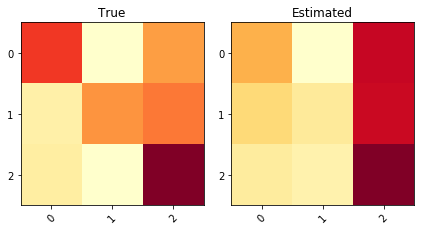

KL divergence: 0.2078	Pearson Correlation between diagonals: 0.9916


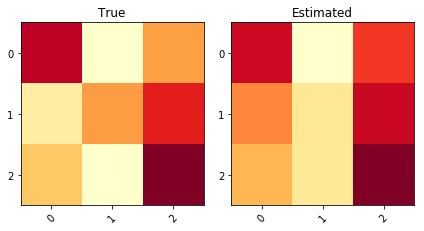

KL divergence: 0.1659	Pearson Correlation between diagonals: 0.9993


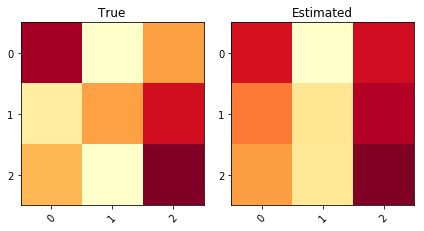

KL divergence: 0.1786	Pearson Correlation between diagonals: 0.9923


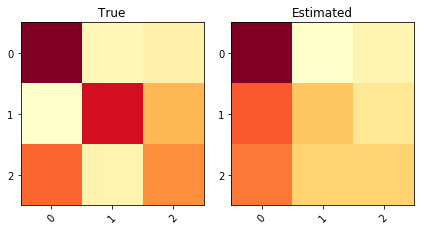

KL divergence: 0.2548	Pearson Correlation between diagonals: 0.8283


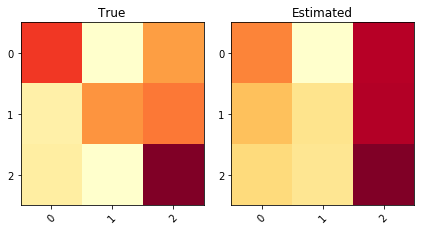

KL divergence: 0.2166	Pearson Correlation between diagonals: 0.9997


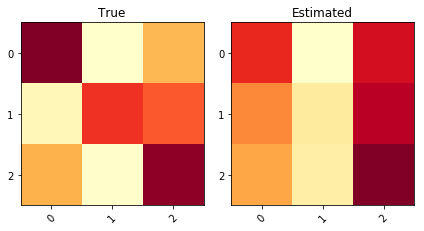

KL divergence: 0.2113	Pearson Correlation between diagonals: 0.9114


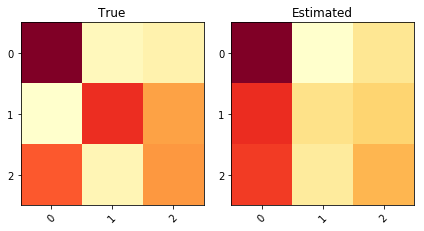

KL divergence: 0.2495	Pearson Correlation between diagonals: 0.7919


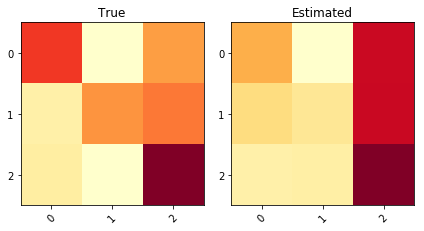

KL divergence: 0.2025	Pearson Correlation between diagonals: 0.9908


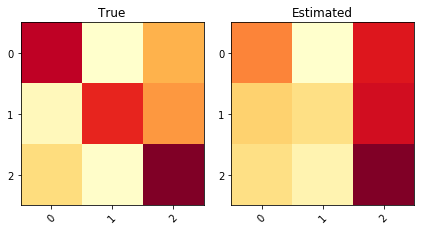

KL divergence: 0.2089	Pearson Correlation between diagonals: 0.9917


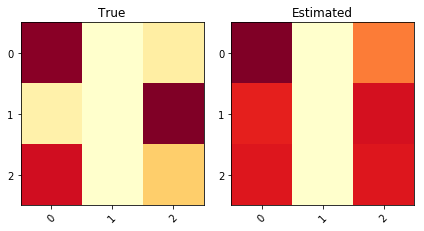

KL divergence: 0.2160	Pearson Correlation between diagonals: 0.8586


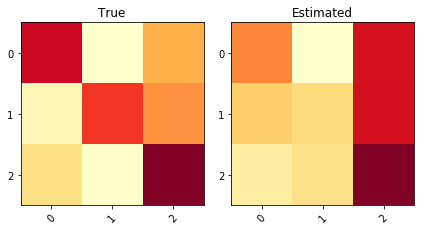

KL divergence: 0.2065	Pearson Correlation between diagonals: 0.9936


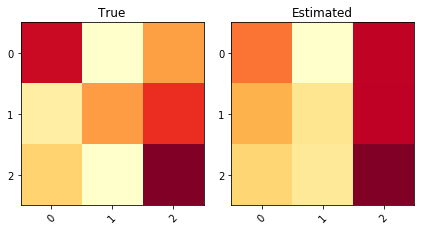

KL divergence: 0.1864	Pearson Correlation between diagonals: 0.9637


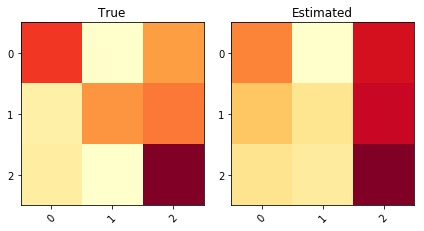

KL divergence: 0.2014	Pearson Correlation between diagonals: 0.9993


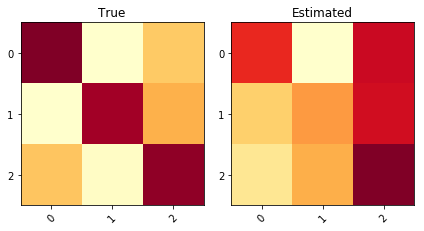

KL divergence: 0.2408	Pearson Correlation between diagonals: 0.5087


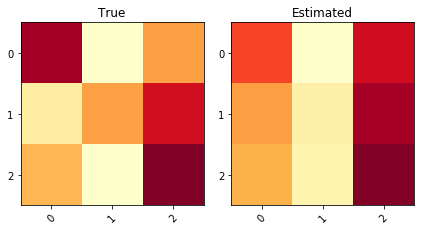

KL divergence: 0.1714	Pearson Correlation between diagonals: 0.9624
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.717135      0.717135   0.207053  0.0576954            0.893502
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.726496      0.726496
====  ======  ==========  ============


In [80]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


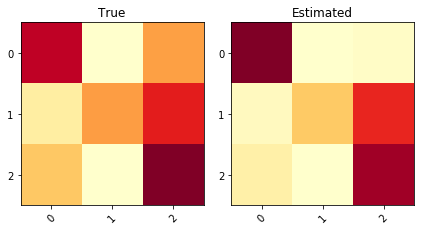

KL divergence: 0.2688	Pearson Correlation between diagonals: 0.9490


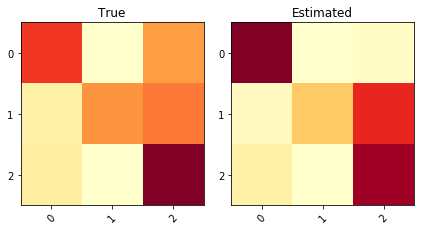

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.7388


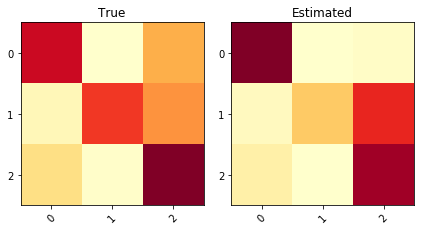

KL divergence: 0.3539	Pearson Correlation between diagonals: 0.7963


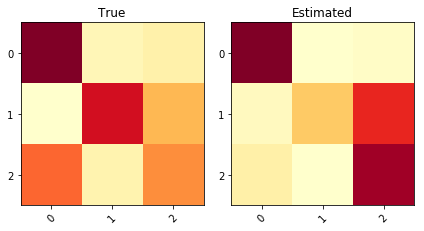

KL divergence: 0.6089	Pearson Correlation between diagonals: -0.0375


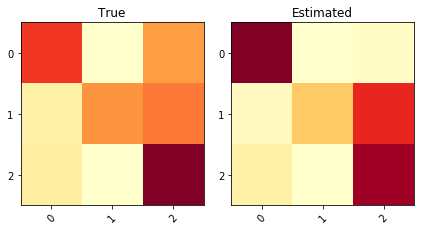

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.7388


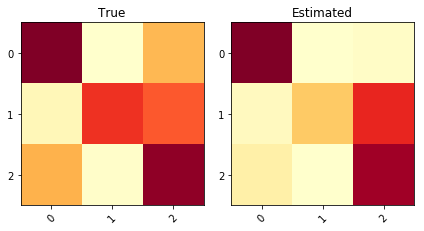

KL divergence: 0.3381	Pearson Correlation between diagonals: 1.0000


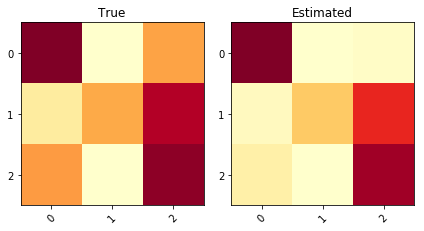

KL divergence: 0.2640	Pearson Correlation between diagonals: 0.9990


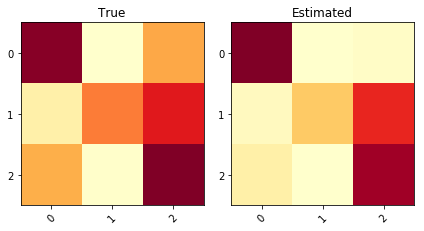

KL divergence: 0.2787	Pearson Correlation between diagonals: 0.9922


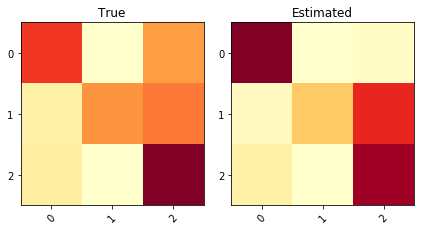

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.7388


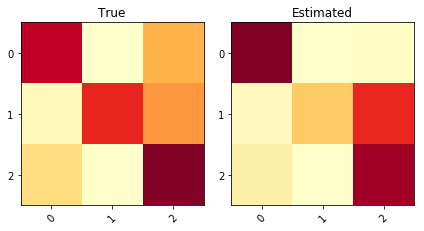

KL divergence: 0.3702	Pearson Correlation between diagonals: 0.8208


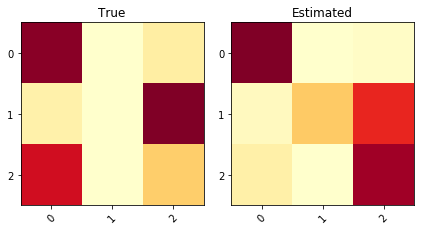

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.7814


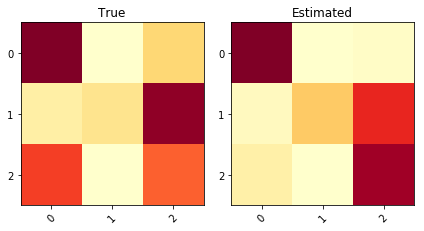

KL divergence: 0.3354	Pearson Correlation between diagonals: 0.9073


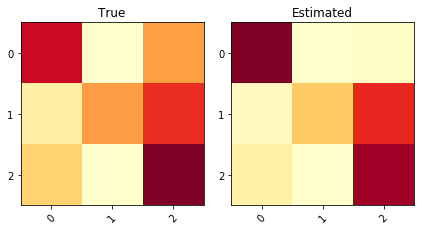

KL divergence: 0.2731	Pearson Correlation between diagonals: 0.9238


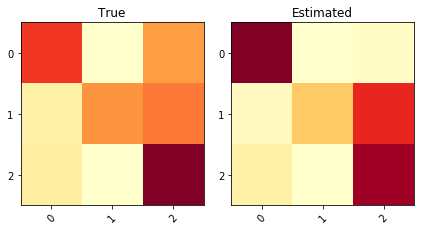

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.7388


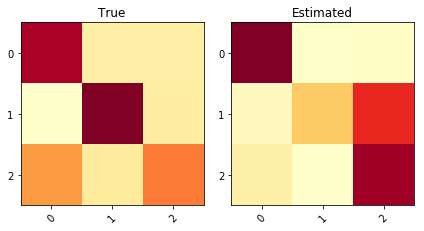

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.5881
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.717135      0.717135    0.37778  0.0971699            0.719782
====  ======  ==========  ============  =========  =========  ==================


In [81]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


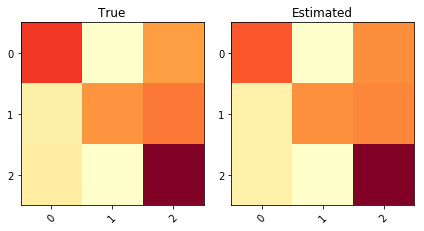

KL divergence: 0.0031	Pearson Correlation between diagonals: 0.9838


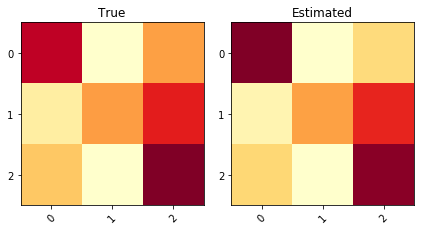

KL divergence: 0.0233	Pearson Correlation between diagonals: 0.9652


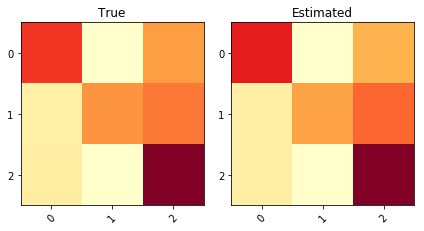

KL divergence: 0.0037	Pearson Correlation between diagonals: 0.9836


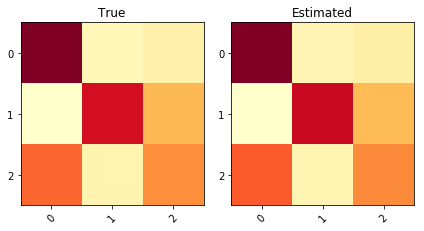

KL divergence: 0.0833	Pearson Correlation between diagonals: 0.9979


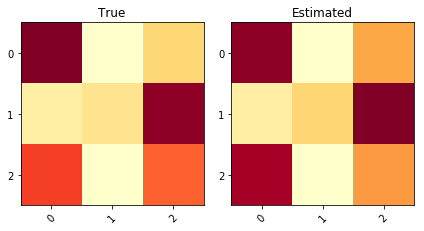

KL divergence: 0.0242	Pearson Correlation between diagonals: 0.9688


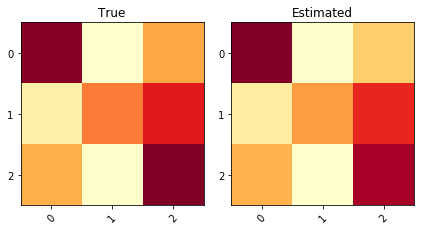

KL divergence: 0.0076	Pearson Correlation between diagonals: 0.9857


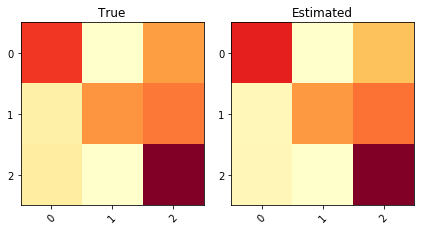

KL divergence: 0.0168	Pearson Correlation between diagonals: 0.9897


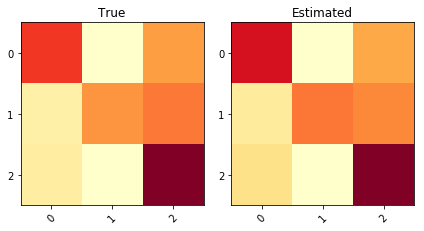

KL divergence: 0.0093	Pearson Correlation between diagonals: 0.9846


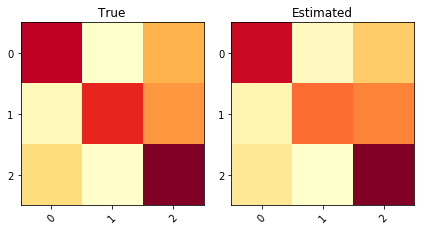

KL divergence: 0.0134	Pearson Correlation between diagonals: 0.9921


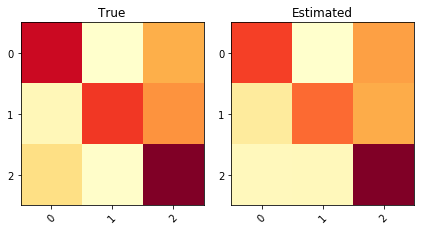

KL divergence: 0.0484	Pearson Correlation between diagonals: 0.9598


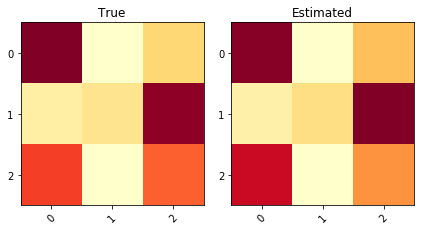

KL divergence: 0.0106	Pearson Correlation between diagonals: 0.9851


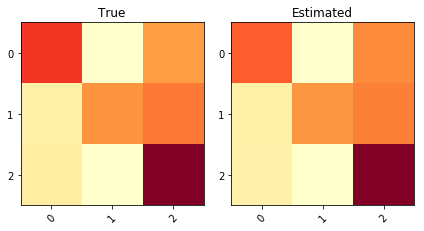

KL divergence: 0.0034	Pearson Correlation between diagonals: 0.9867


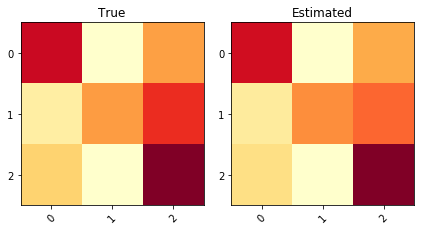

KL divergence: 0.0060	Pearson Correlation between diagonals: 0.9970


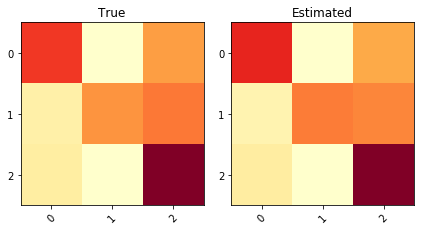

KL divergence: 0.0033	Pearson Correlation between diagonals: 0.9997


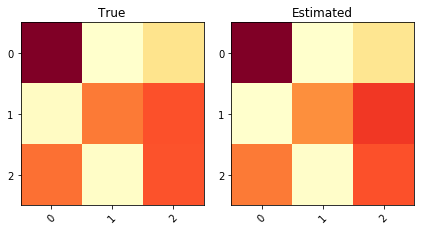

KL divergence: 0.0022	Pearson Correlation between diagonals: 0.9960
A result
 ====  ======  ==========  ============  =========  ==========  ==================
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  ==========  ==================
   0  Global    0.885226      0.885226  0.0184842  0.00325279            0.943187
====  ======  ==========  ============  =========  ==========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.881563      0.881563
====  ======  ==========  ============


In [82]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


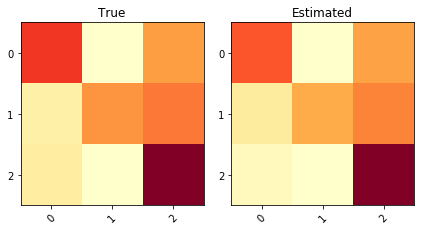

KL divergence: 0.0199	Pearson Correlation between diagonals: 0.9996


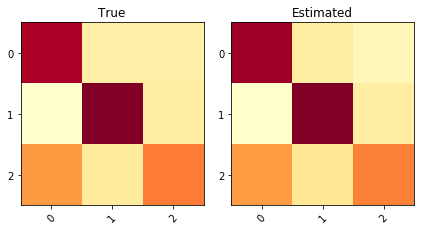

KL divergence: 0.0083	Pearson Correlation between diagonals: 0.9972


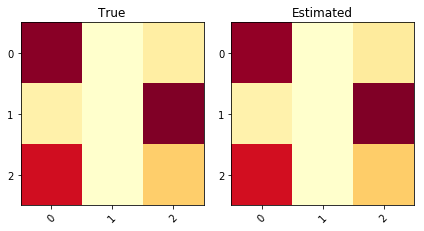

KL divergence: 0.0138	Pearson Correlation between diagonals: 0.9999


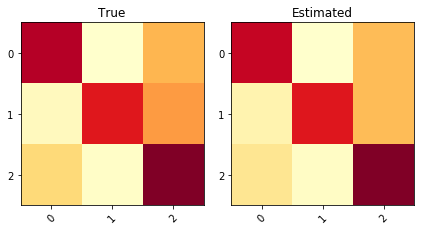

KL divergence: 0.0075	Pearson Correlation between diagonals: 0.9769


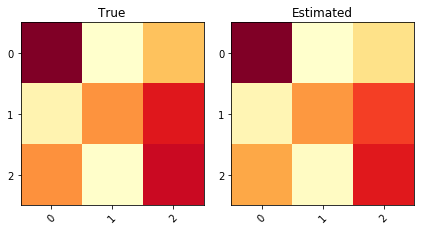

KL divergence: 0.0088	Pearson Correlation between diagonals: 0.9907


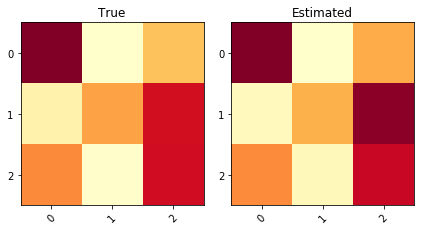

KL divergence: 0.0146	Pearson Correlation between diagonals: 0.9971


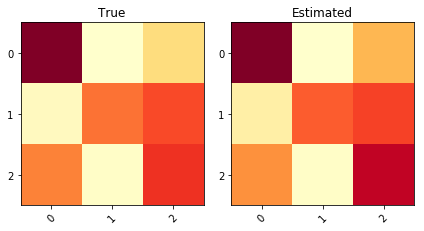

KL divergence: 0.0121	Pearson Correlation between diagonals: 0.9281


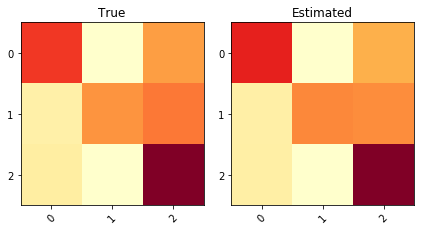

KL divergence: 0.0112	Pearson Correlation between diagonals: 0.9973


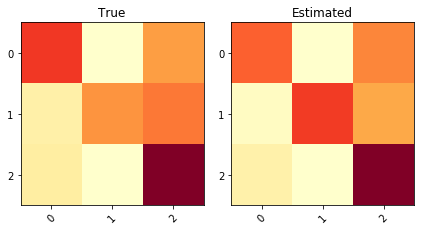

KL divergence: 0.0379	Pearson Correlation between diagonals: 0.8348


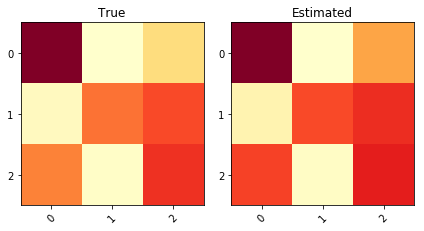

KL divergence: 0.0104	Pearson Correlation between diagonals: 0.9998


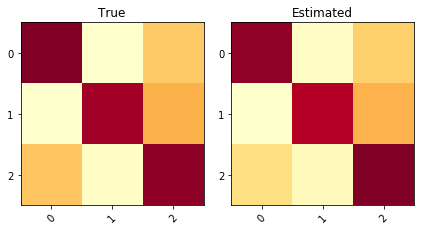

KL divergence: 0.0055	Pearson Correlation between diagonals: 0.6911


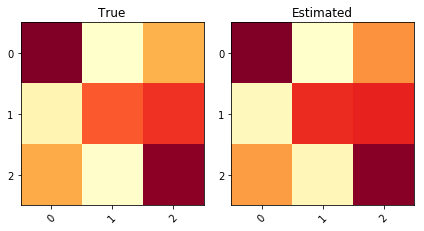

KL divergence: 0.0098	Pearson Correlation between diagonals: 1.0000


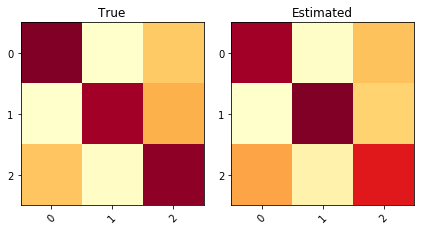

KL divergence: 0.0159	Pearson Correlation between diagonals: -0.3234


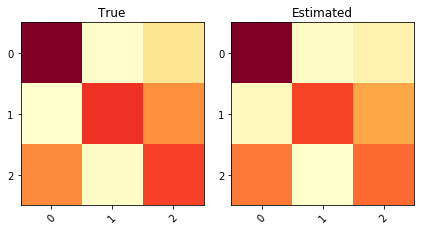

KL divergence: 0.0127	Pearson Correlation between diagonals: 0.9972


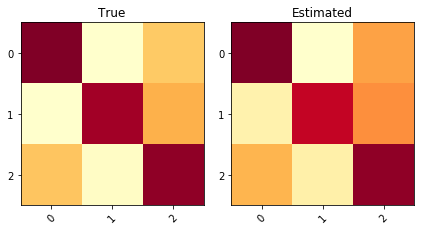

KL divergence: 0.0138	Pearson Correlation between diagonals: 0.9607
A result
 ====  ======  ==========  ============  =========  ==========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  ==========  ==================  ==============
   0  Global    0.858364      0.858364  0.0156616  0.00416836            0.883169       0.0800129
====  ======  ==========  ============  =========  ==========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.618361                0.850753
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.85

In [12]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


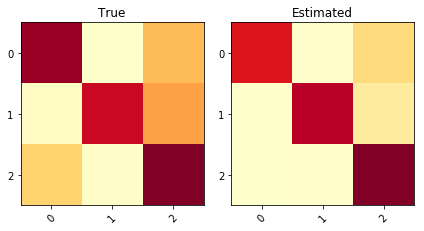

KL divergence: 0.3232	Pearson Correlation between diagonals: 0.3613


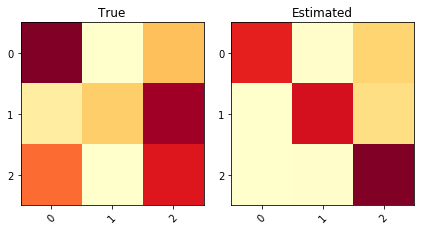

KL divergence: 0.8276	Pearson Correlation between diagonals: -0.0154


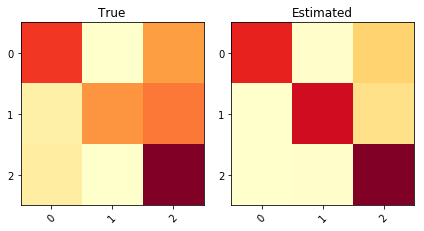

KL divergence: 0.2438	Pearson Correlation between diagonals: 0.7721


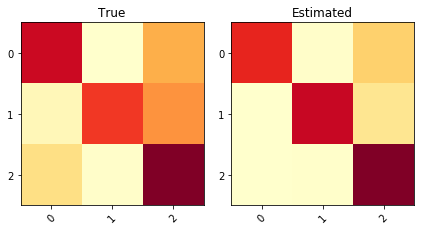

KL divergence: 0.2599	Pearson Correlation between diagonals: 0.6147


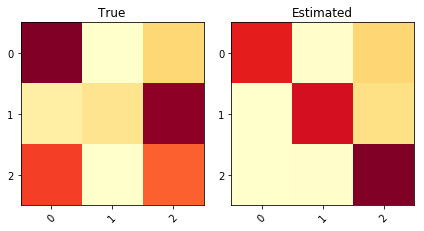

KL divergence: 1.0898	Pearson Correlation between diagonals: -0.2214


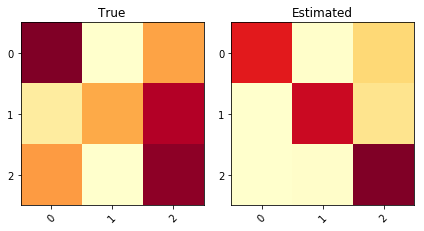

KL divergence: 0.6288	Pearson Correlation between diagonals: 0.1700


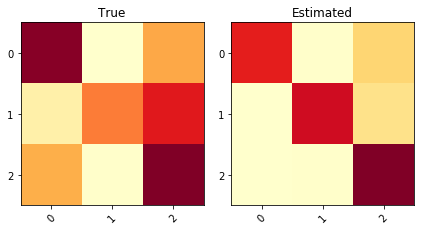

KL divergence: 0.4777	Pearson Correlation between diagonals: 0.2675


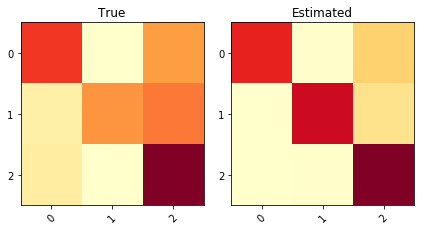

KL divergence: 0.2488	Pearson Correlation between diagonals: 0.7393


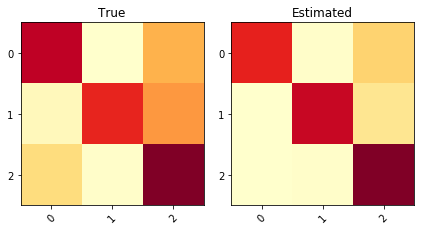

KL divergence: 0.2724	Pearson Correlation between diagonals: 0.6012


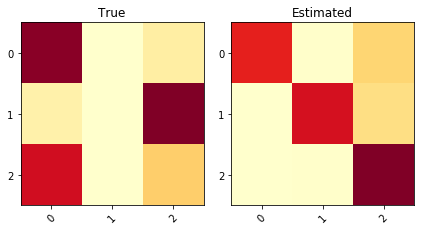

KL divergence: 1.7259	Pearson Correlation between diagonals: -0.4344


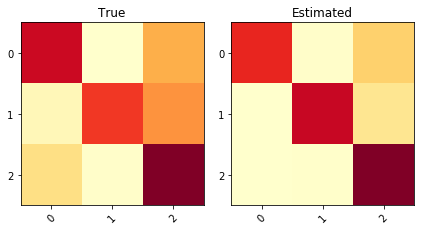

KL divergence: 0.2591	Pearson Correlation between diagonals: 0.6131


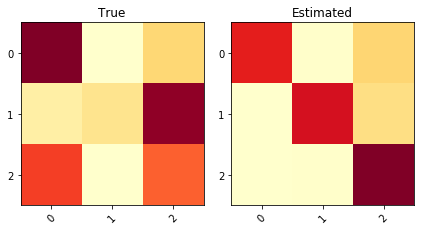

KL divergence: 1.0866	Pearson Correlation between diagonals: -0.2120


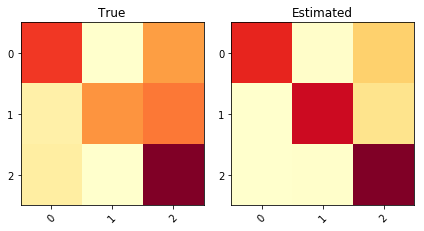

KL divergence: 0.2478	Pearson Correlation between diagonals: 0.7236


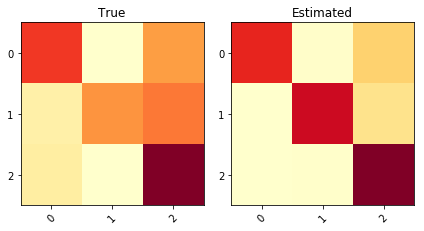

KL divergence: 0.2480	Pearson Correlation between diagonals: 0.7300


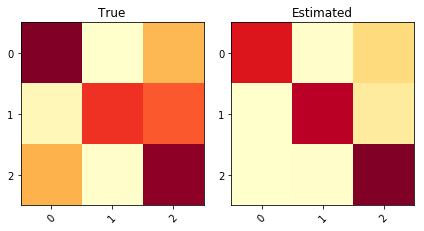

KL divergence: 0.4554	Pearson Correlation between diagonals: -0.0444
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.820513      0.820513   0.520173  0.0737737           0.0394929       0.0691972
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.620714                0.792509
====  =======================  ======================
Test


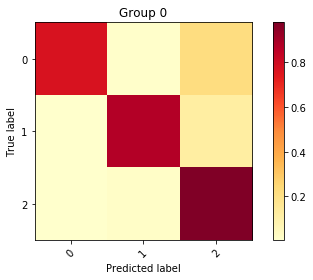

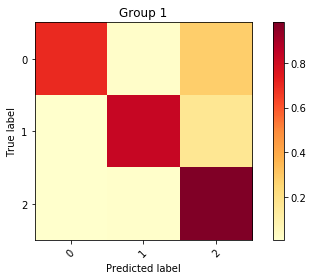

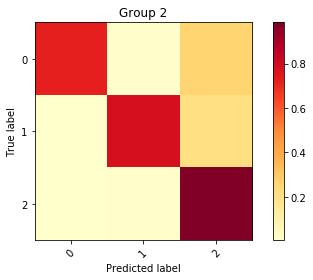

Inertia: 0.001852757598195846
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.367625      36   0.364847     0.874186   0.139261       0.932436   0.540853    0.769231      0.769231
   1         1  0.268373      26   0.415645     0.838624   0.185258       0.911159   0.50529     0.688645      0.688645
   2         2  0.364003      36   0.42033      0.831836   0.192676       0.907515   0.498502    0.661783      0.661783
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [84]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


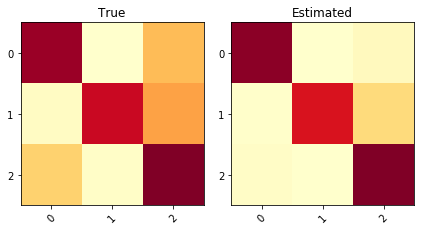

KL divergence: 0.3171	Pearson Correlation between diagonals: 0.9744


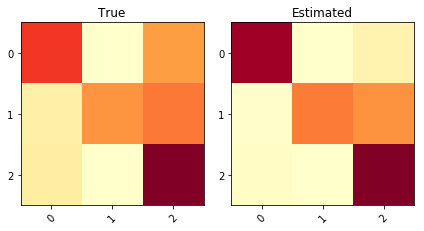

KL divergence: 0.1976	Pearson Correlation between diagonals: 0.8653


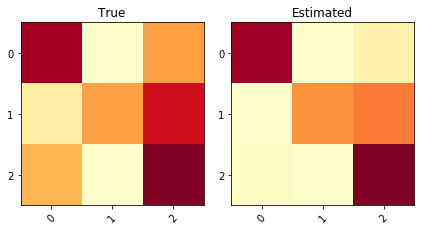

KL divergence: 0.2630	Pearson Correlation between diagonals: 1.0000


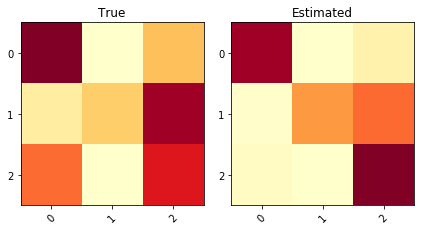

KL divergence: 0.3929	Pearson Correlation between diagonals: 0.9058


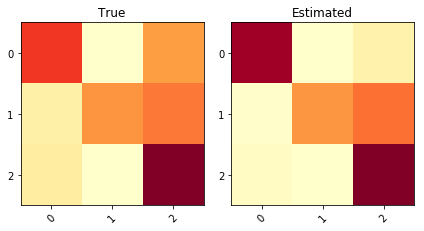

KL divergence: 0.1846	Pearson Correlation between diagonals: 0.8607


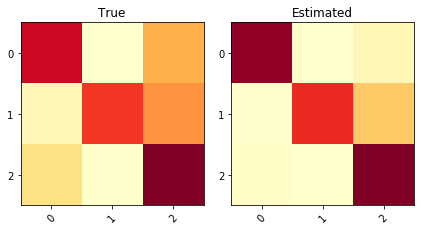

KL divergence: 0.2575	Pearson Correlation between diagonals: 0.9122


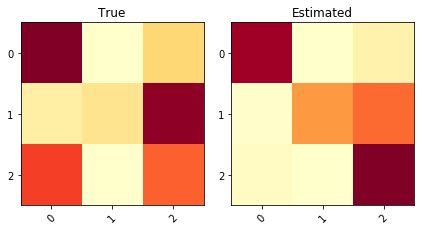

KL divergence: 0.5243	Pearson Correlation between diagonals: 0.8034


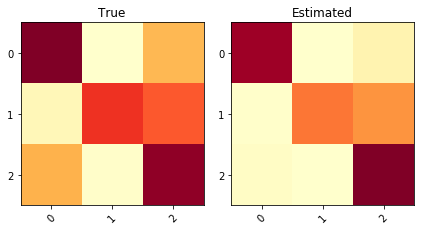

KL divergence: 0.2616	Pearson Correlation between diagonals: 0.9753


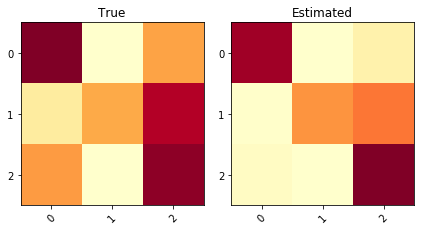

KL divergence: 0.3003	Pearson Correlation between diagonals: 0.9871


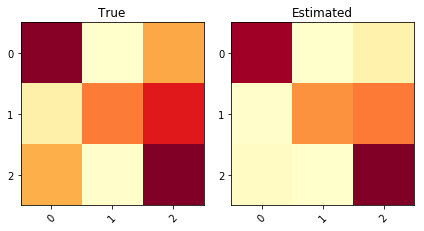

KL divergence: 0.2502	Pearson Correlation between diagonals: 0.9966


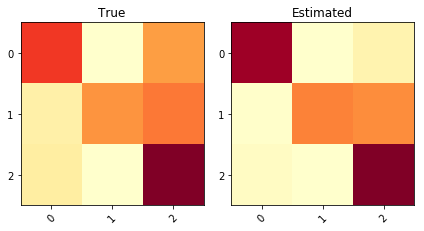

KL divergence: 0.1947	Pearson Correlation between diagonals: 0.8643


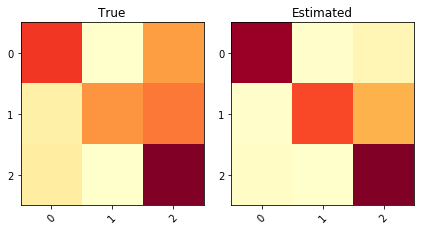

KL divergence: 0.2346	Pearson Correlation between diagonals: 0.8737


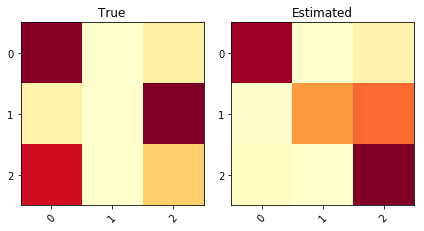

KL divergence: 0.9132	Pearson Correlation between diagonals: 0.6389


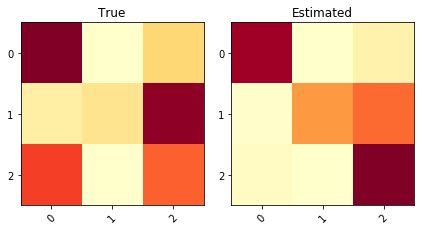

KL divergence: 0.5243	Pearson Correlation between diagonals: 0.8034


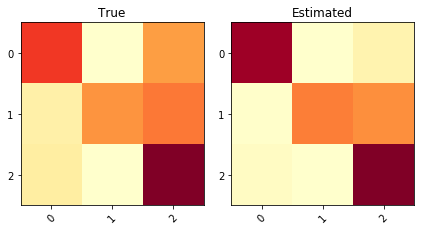

KL divergence: 0.1963	Pearson Correlation between diagonals: 0.8649
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.922263      0.922263   0.353131  0.0592165            0.703907       0.0559583
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.634365                0.789554
====  =======================  ======================
Test


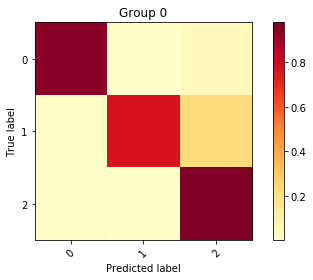

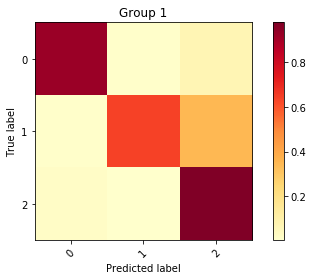

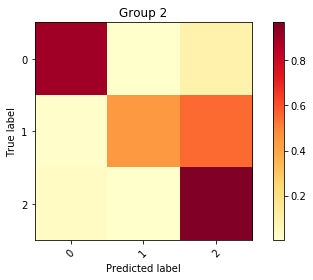

Inertia: 0.010852160902383426
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.389124      38   0.295749     0.899965   0.111069       0.946175   0.566631    0.879121      0.879121
   1         1  0.270756      27   0.367987     0.847832   0.18157        0.914092   0.514498    0.726496      0.726496
   2         2  0.34012       34   0.405299     0.770491   0.31794        0.857818   0.437158    0.649573      0.649573
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [85]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


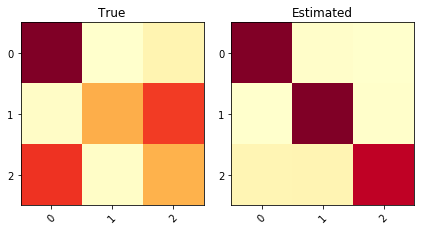

KL divergence: 1.1633	Pearson Correlation between diagonals: 0.4944


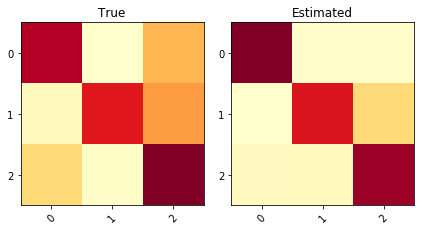

KL divergence: 0.3362	Pearson Correlation between diagonals: 0.7392


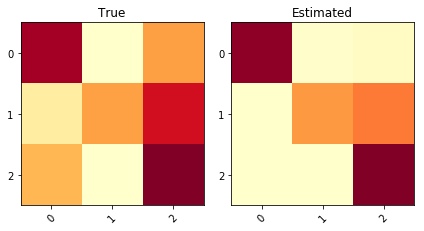

KL divergence: 0.5740	Pearson Correlation between diagonals: 0.9975


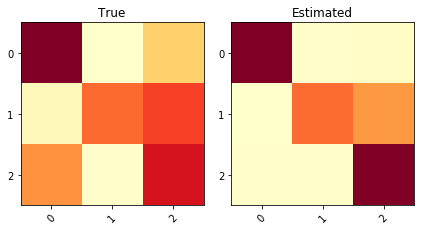

KL divergence: 0.4711	Pearson Correlation between diagonals: 0.8626


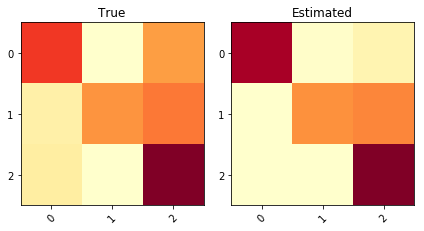

KL divergence: 0.2863	Pearson Correlation between diagonals: 0.8784


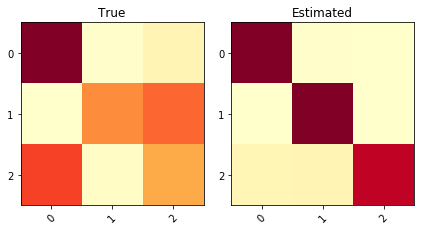

KL divergence: 1.0471	Pearson Correlation between diagonals: 0.5936


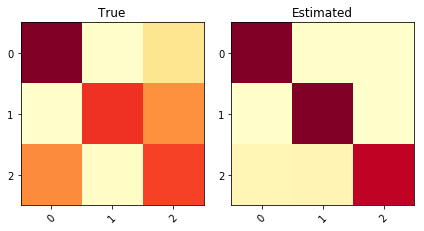

KL divergence: 0.8223	Pearson Correlation between diagonals: 0.5459


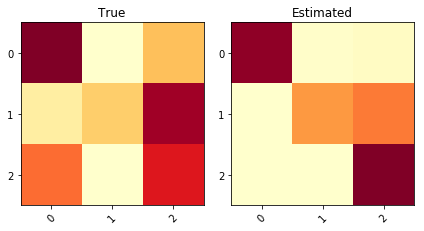

KL divergence: 0.8077	Pearson Correlation between diagonals: 0.9296


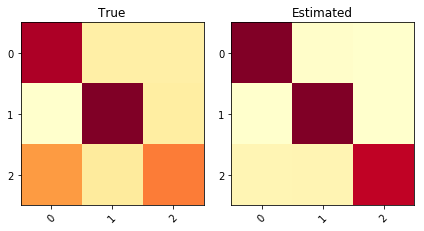

KL divergence: 0.3435	Pearson Correlation between diagonals: 0.9888


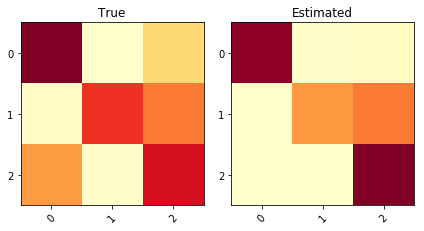

KL divergence: 0.6371	Pearson Correlation between diagonals: 0.7179


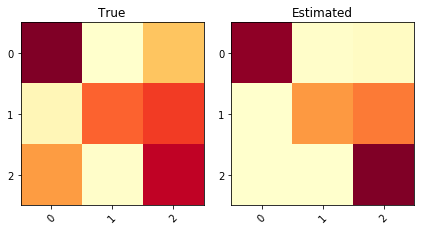

KL divergence: 0.6214	Pearson Correlation between diagonals: 0.9245


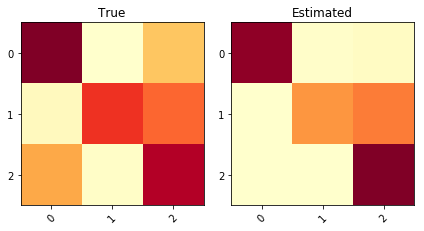

KL divergence: 0.5649	Pearson Correlation between diagonals: 0.9206


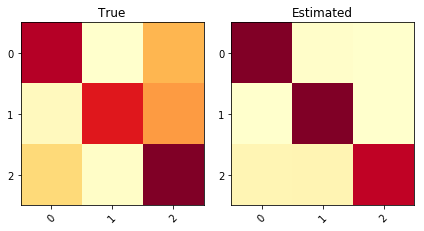

KL divergence: 0.8167	Pearson Correlation between diagonals: -0.8659


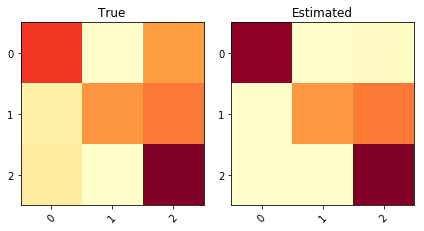

KL divergence: 0.4124	Pearson Correlation between diagonals: 0.8278


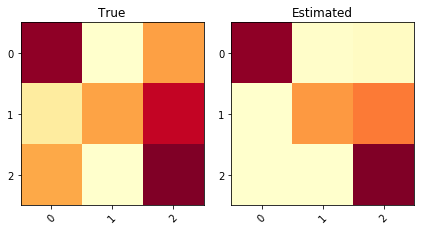

KL divergence: 0.6033	Pearson Correlation between diagonals: 1.0000
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.858771      0.858771    0.61993  0.0783716            0.587117       0.0675542
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                  0.60462                0.849751
====  =======================  ======================
Test


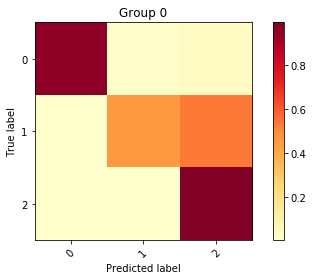

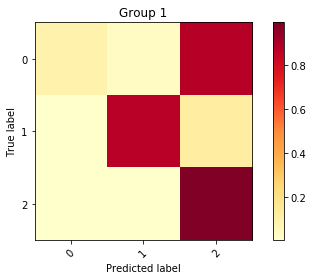

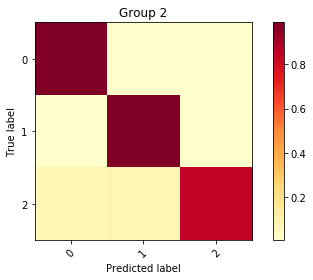

Inertia: 0.15803196529547373
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.387396      38   0.314055     0.805169  0.274157        0.877837   0.707754    0.611722      0.611722
   1         1  0.268363      26   0.292754     0.653625  0.840879        0.719835   0.480438    0.466422      0.466422
   2         2  0.344241      34   0.223857     0.942612  0.0613783       0.969905   0.913918    0.775336      0.775336
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [55]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 4) configuration: Manny annot v1 ($T$ = 2000, $T_{max}$ = 20 )

In [99]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7806267806267806


*** Soft-Majority (Train with softMV) ***
Train


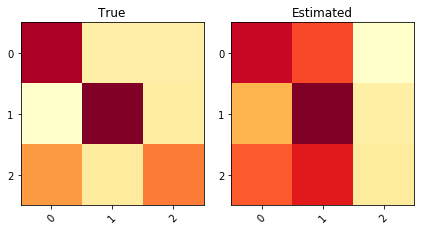

KL divergence: 0.3287	Pearson Correlation between diagonals: 0.9998


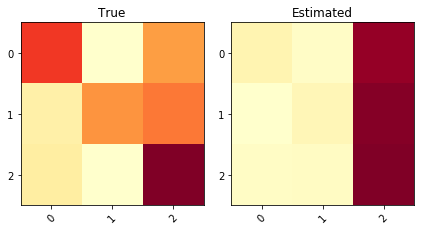

KL divergence: 0.3117	Pearson Correlation between diagonals: 0.9271


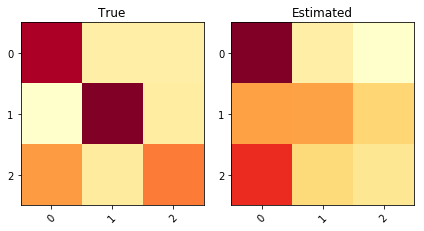

KL divergence: 0.3246	Pearson Correlation between diagonals: 0.5972


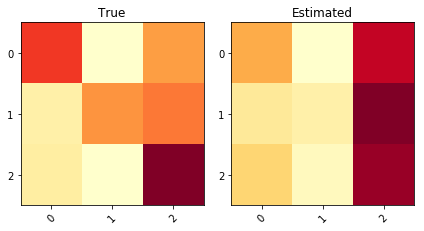

KL divergence: 0.2315	Pearson Correlation between diagonals: 0.9988


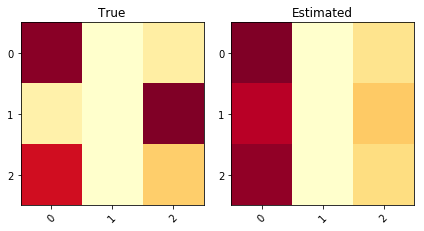

KL divergence: 0.3371	Pearson Correlation between diagonals: 0.9969


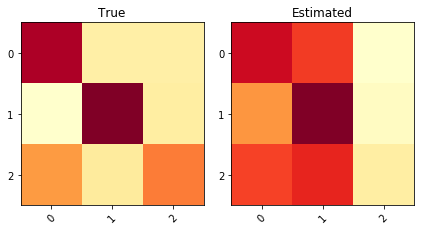

KL divergence: 0.3481	Pearson Correlation between diagonals: 1.0000


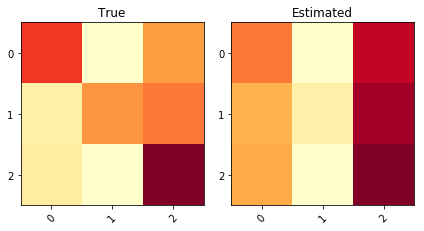

KL divergence: 0.2244	Pearson Correlation between diagonals: 0.9931


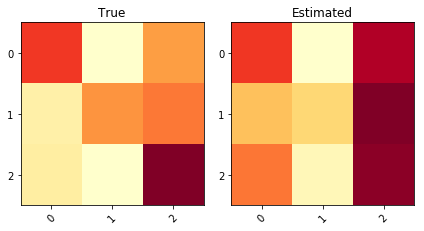

KL divergence: 0.2361	Pearson Correlation between diagonals: 0.9726


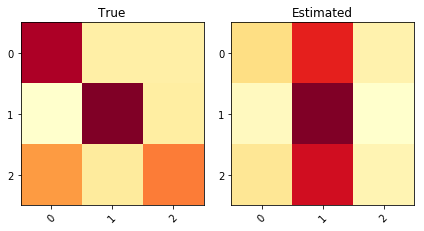

KL divergence: 0.4834	Pearson Correlation between diagonals: 0.7558


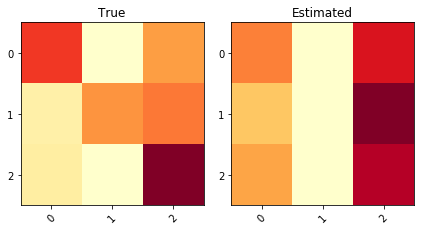

KL divergence: 2.1248	Pearson Correlation between diagonals: 0.9728


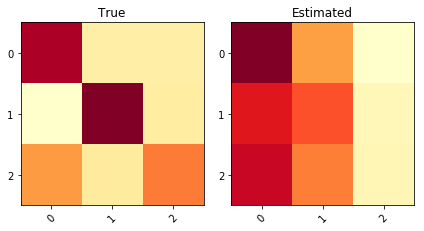

KL divergence: 0.3907	Pearson Correlation between diagonals: 0.8198


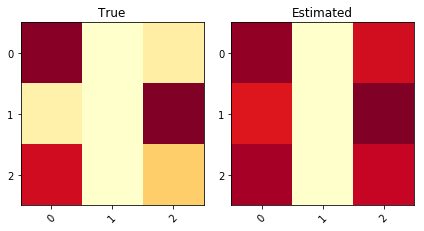

KL divergence: 0.2311	Pearson Correlation between diagonals: 0.7933


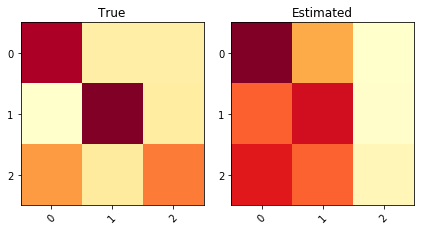

KL divergence: 0.3807	Pearson Correlation between diagonals: 0.9245


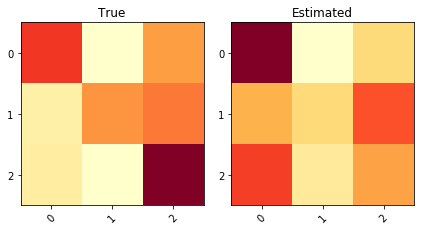

KL divergence: 0.3544	Pearson Correlation between diagonals: 0.1098


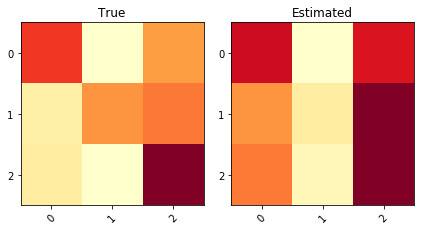

KL divergence: 0.2527	Pearson Correlation between diagonals: 0.8976
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.796907      0.796907   0.322981   0.077249            0.844747
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.802198      0.802198
====  ======  ==========  ============


In [100]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


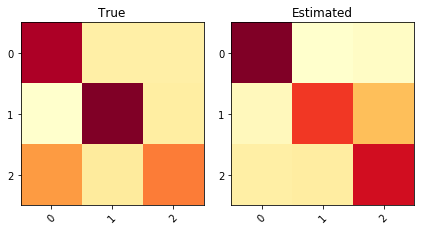

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.0732


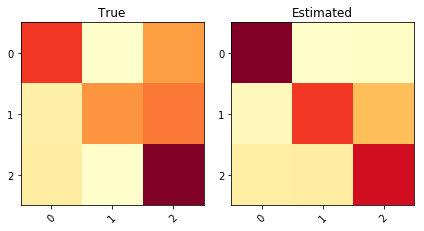

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


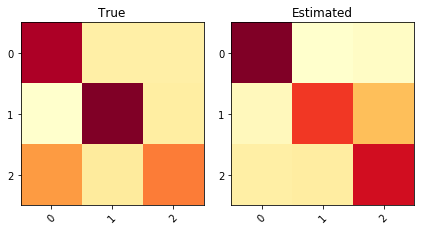

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.0732


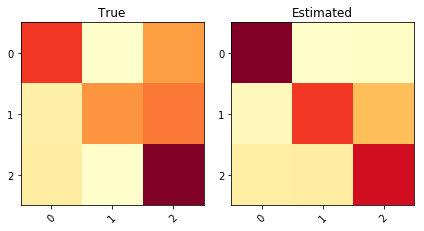

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


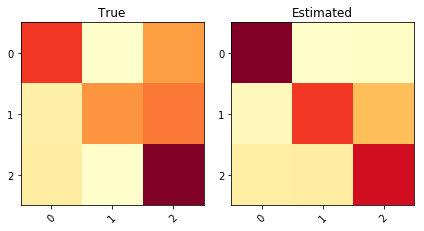

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


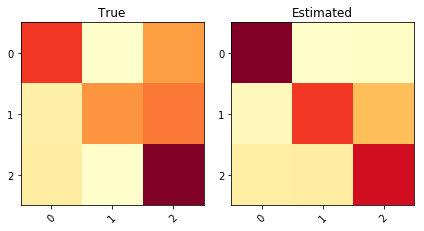

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


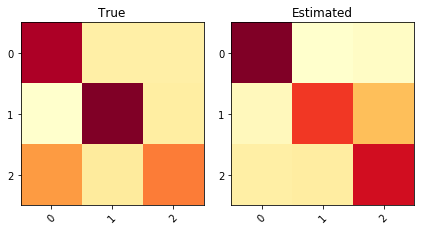

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.0732


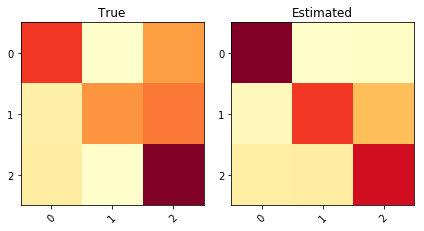

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


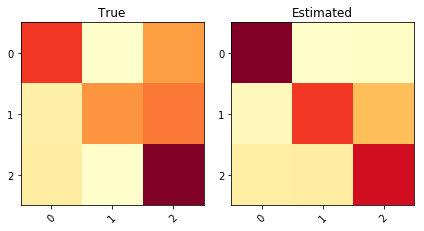

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


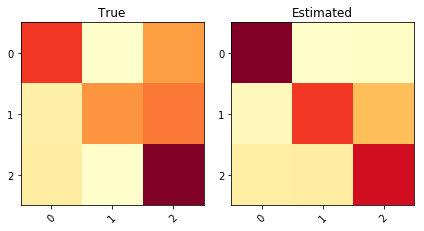

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


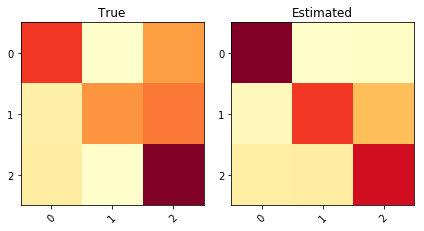

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


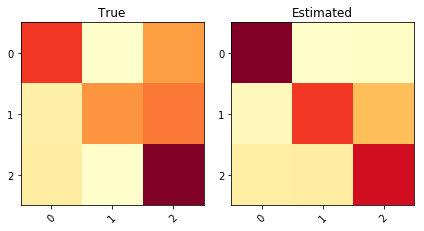

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


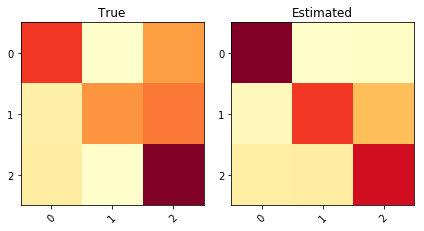

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


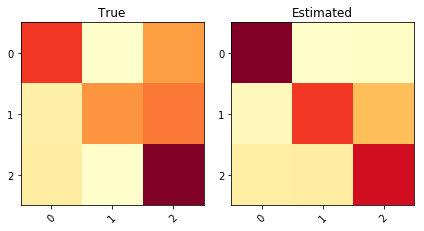

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.2724


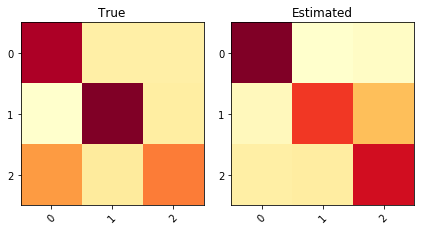

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.0732
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.796907      0.796907   0.495249   0.131144            0.320479
====  ======  ==========  ============  =========  =========  ==================


In [101]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


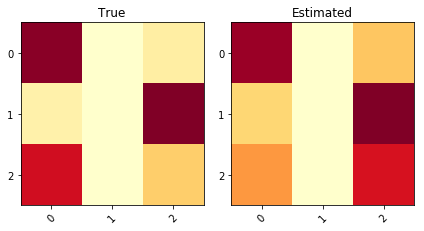

KL divergence: 0.1346	Pearson Correlation between diagonals: 0.8187


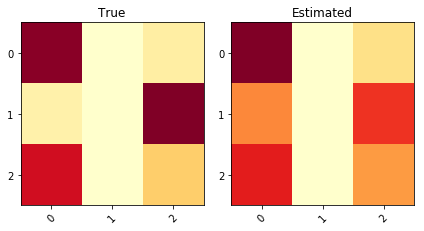

KL divergence: 0.1104	Pearson Correlation between diagonals: 0.9837


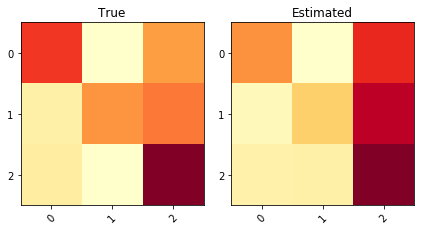

KL divergence: 0.1163	Pearson Correlation between diagonals: 0.9933


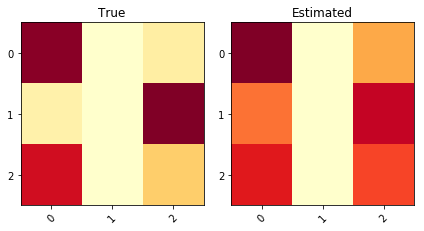

KL divergence: 0.1428	Pearson Correlation between diagonals: 0.9187


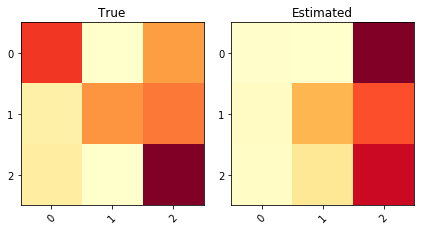

KL divergence: 0.3511	Pearson Correlation between diagonals: 0.6671


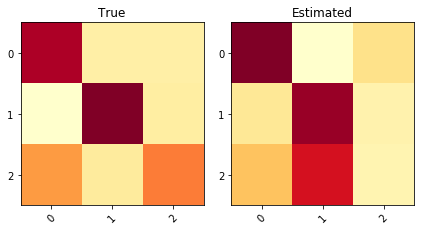

KL divergence: 0.2662	Pearson Correlation between diagonals: 0.9703


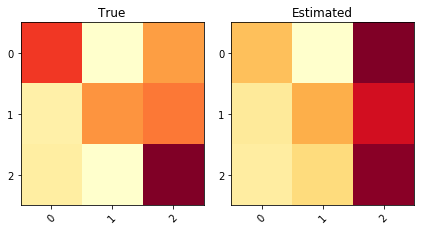

KL divergence: 0.1885	Pearson Correlation between diagonals: 0.8902


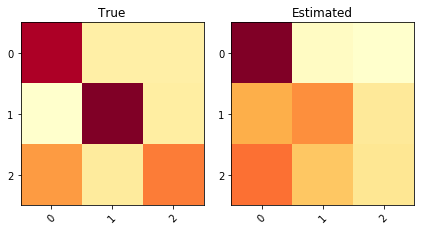

KL divergence: 0.2864	Pearson Correlation between diagonals: 0.6677


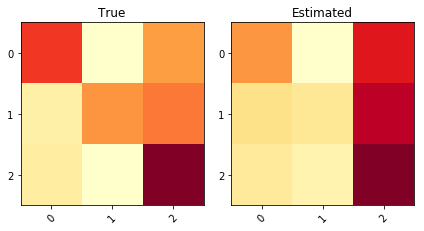

KL divergence: 0.1477	Pearson Correlation between diagonals: 0.9996


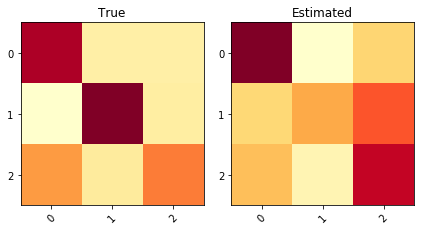

KL divergence: 0.2979	Pearson Correlation between diagonals: -0.4608


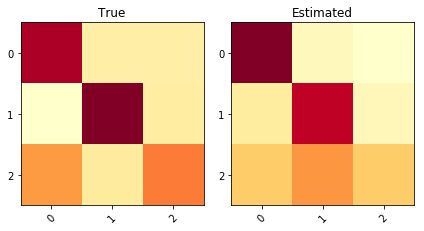

KL divergence: 0.1763	Pearson Correlation between diagonals: 0.9318


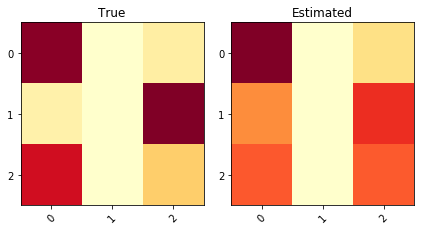

KL divergence: 0.1358	Pearson Correlation between diagonals: 0.9388


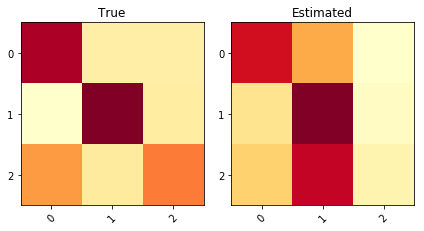

KL divergence: 0.4241	Pearson Correlation between diagonals: 1.0000


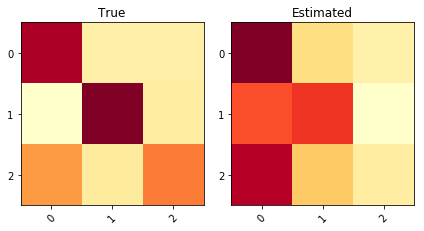

KL divergence: 0.3089	Pearson Correlation between diagonals: 0.8490


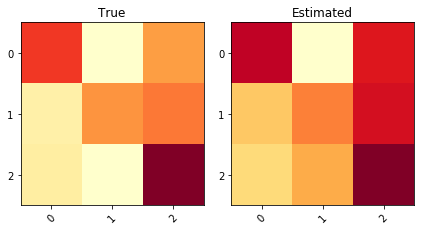

KL divergence: 0.1528	Pearson Correlation between diagonals: 0.9358
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.62963       0.62963   0.217562  0.0520236            0.833282
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.654457      0.654457
====  ======  ==========  ============


In [104]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


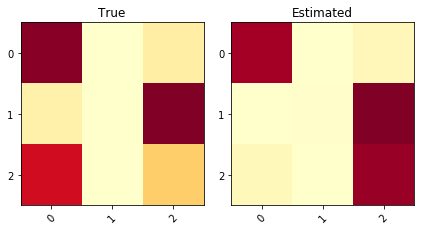

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7090


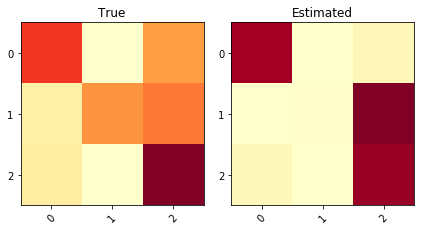

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8077


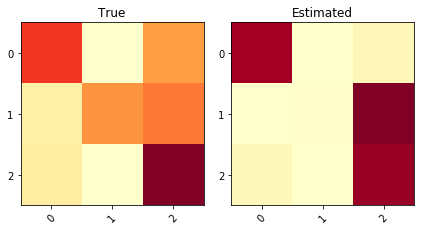

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8077


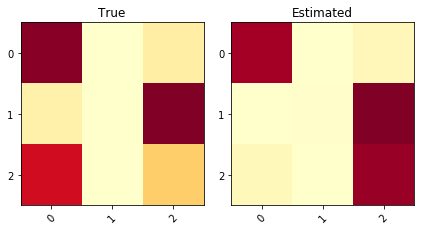

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7090


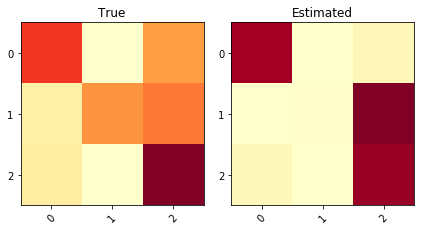

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8077


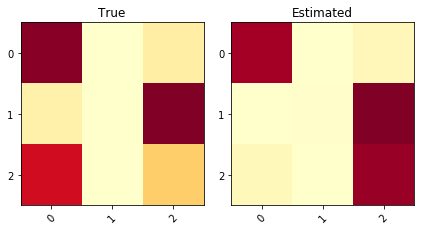

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7090


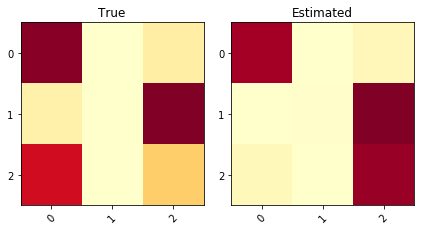

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7090


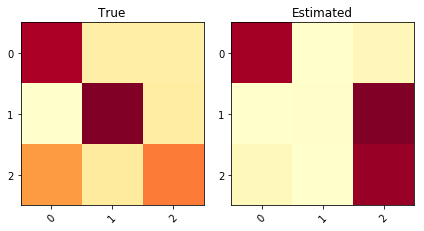

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6725


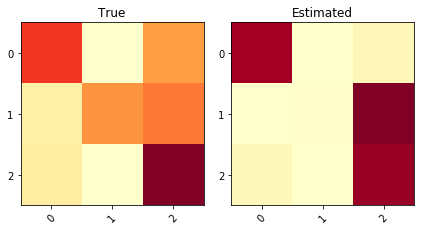

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8077


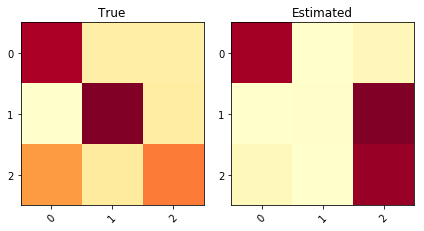

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6725


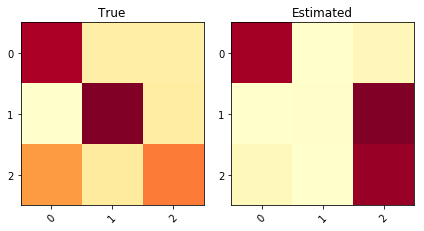

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6725


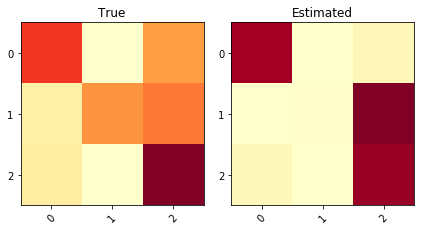

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8077


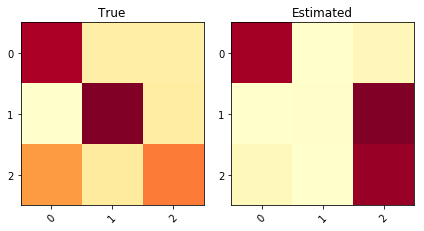

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6725


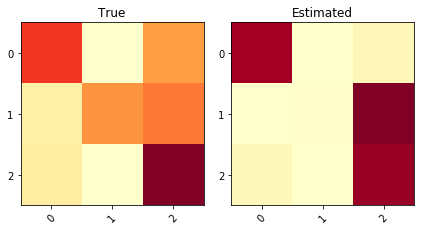

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8077


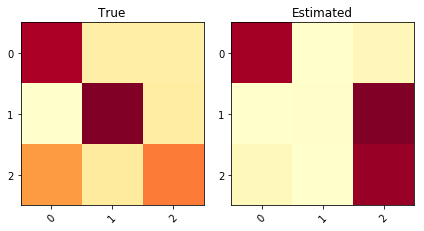

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6725
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.62963       0.62963   0.517084  0.0961229            0.428152
====  ======  ==========  ============  =========  =========  ==================


In [105]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


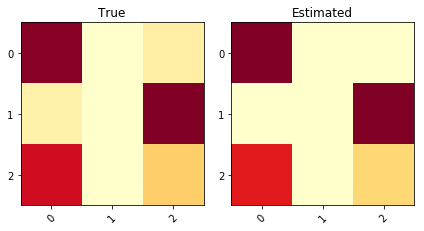

KL divergence: 0.8179	Pearson Correlation between diagonals: 0.9991


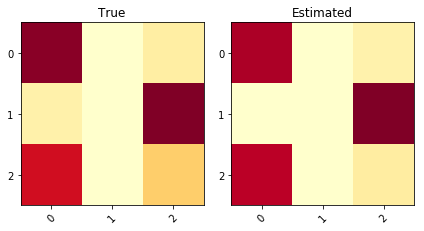

KL divergence: 0.3867	Pearson Correlation between diagonals: 0.9876


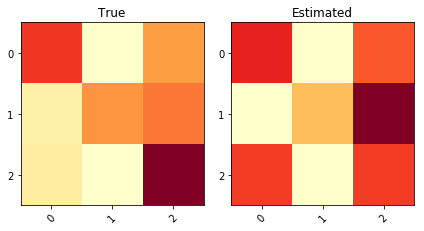

KL divergence: 0.5430	Pearson Correlation between diagonals: 0.7008


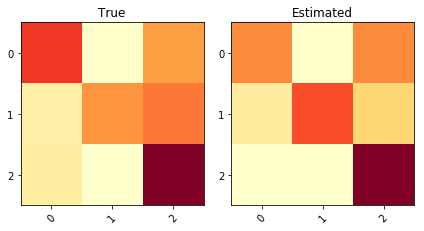

KL divergence: 0.5037	Pearson Correlation between diagonals: 0.8028


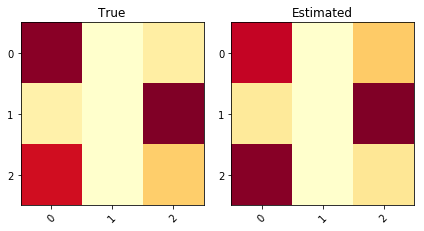

KL divergence: 0.0432	Pearson Correlation between diagonals: 0.9941


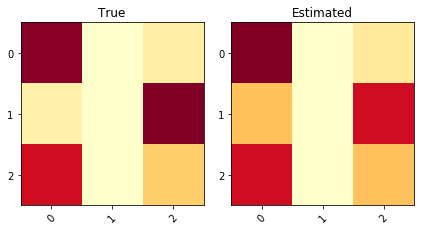

KL divergence: 0.0419	Pearson Correlation between diagonals: 0.9992


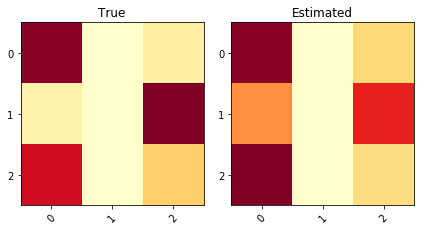

KL divergence: 0.1010	Pearson Correlation between diagonals: 0.9978


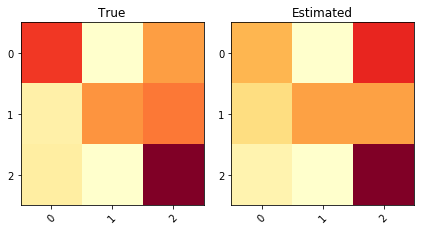

KL divergence: 0.0692	Pearson Correlation between diagonals: 0.8778


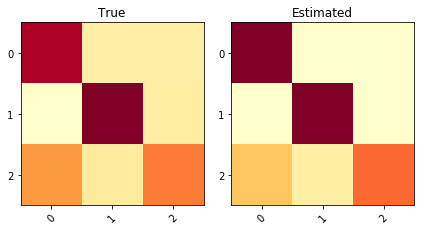

KL divergence: 1.2776	Pearson Correlation between diagonals: 0.9813


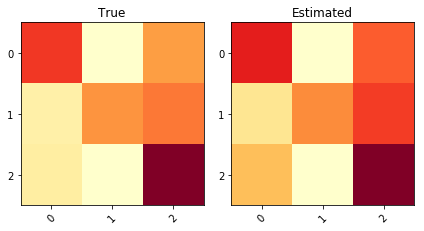

KL divergence: 0.0272	Pearson Correlation between diagonals: 0.9943


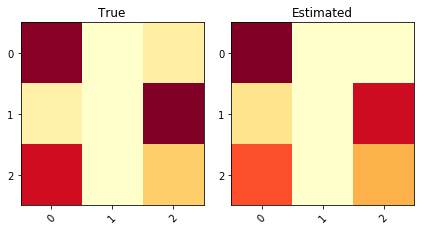

KL divergence: 0.4402	Pearson Correlation between diagonals: 0.9954


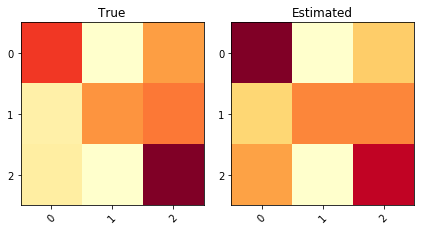

KL divergence: 0.0872	Pearson Correlation between diagonals: 0.5889


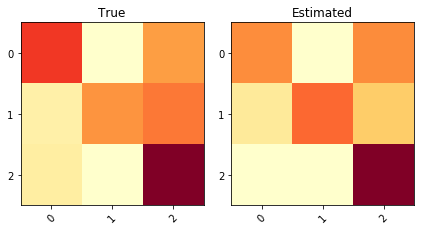

KL divergence: 0.4909	Pearson Correlation between diagonals: 0.8625


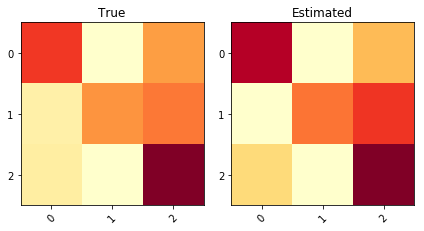

KL divergence: 0.4077	Pearson Correlation between diagonals: 0.9155


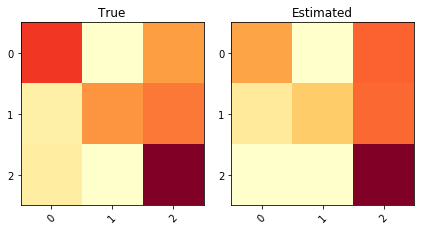

KL divergence: 0.4934	Pearson Correlation between diagonals: 0.9752
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.934473      0.934473   0.701537  0.0317218            0.854718
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.942613      0.942613
====  ======  ==========  ============


In [106]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


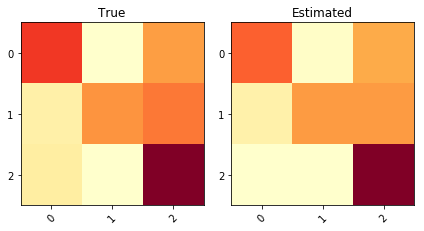

KL divergence: 0.0573	Pearson Correlation between diagonals: 0.9882


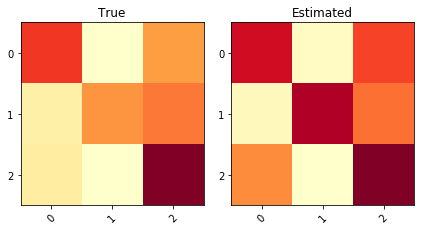

KL divergence: 0.1206	Pearson Correlation between diagonals: 0.6597


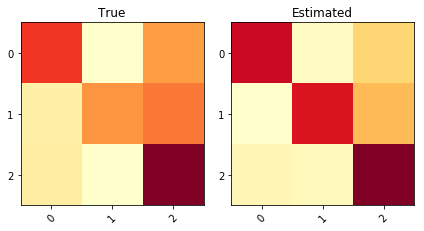

KL divergence: 0.1029	Pearson Correlation between diagonals: 0.9853


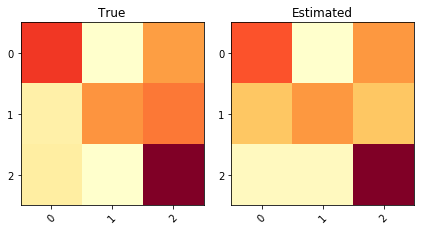

KL divergence: 0.1331	Pearson Correlation between diagonals: 0.9934


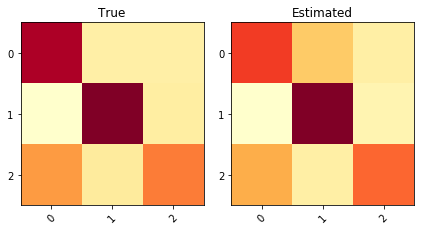

KL divergence: 0.0685	Pearson Correlation between diagonals: 0.8025


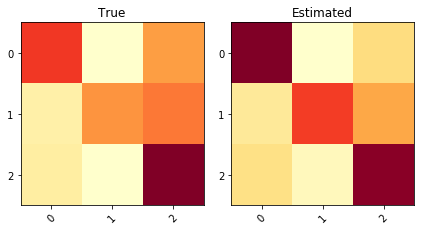

KL divergence: 0.1162	Pearson Correlation between diagonals: 0.7569


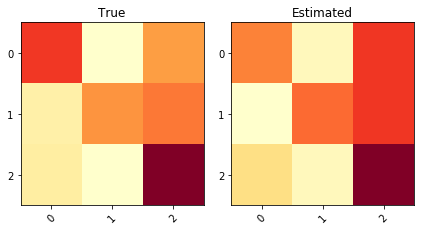

KL divergence: 0.1045	Pearson Correlation between diagonals: 0.8859


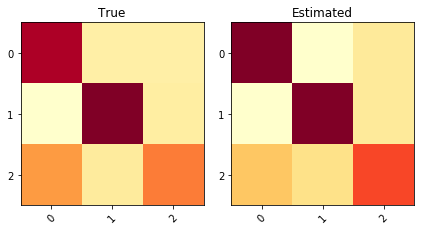

KL divergence: 0.0679	Pearson Correlation between diagonals: 0.9813


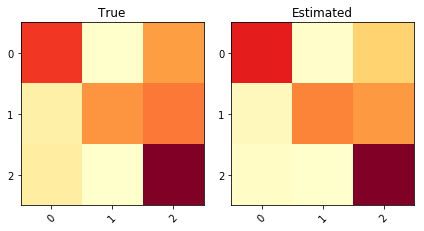

KL divergence: 0.0699	Pearson Correlation between diagonals: 0.9964


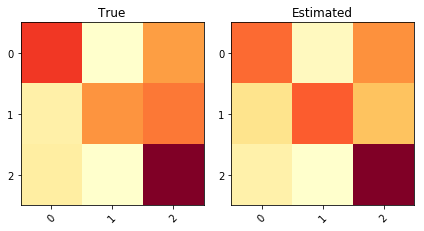

KL divergence: 0.0939	Pearson Correlation between diagonals: 0.9022


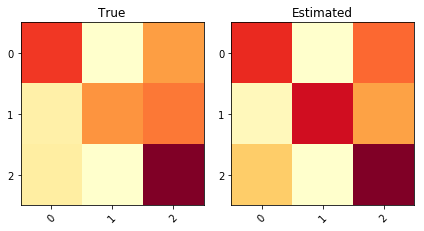

KL divergence: 0.1053	Pearson Correlation between diagonals: 0.7452


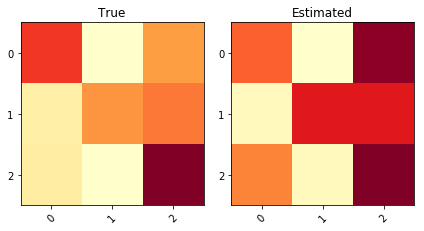

KL divergence: 0.1626	Pearson Correlation between diagonals: 0.6828


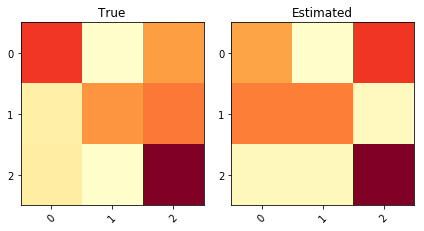

KL divergence: 0.2778	Pearson Correlation between diagonals: 0.8348


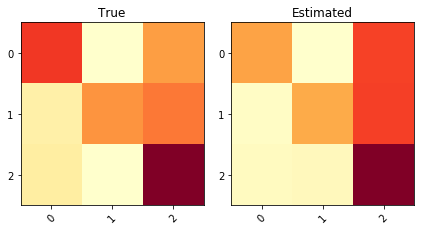

KL divergence: 0.0931	Pearson Correlation between diagonals: 0.9376


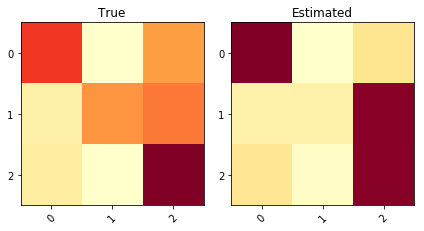

KL divergence: 0.1806	Pearson Correlation between diagonals: 0.7858
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.825397      0.825397   0.124283  0.0370282            0.877729        0.175853
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                  0.65289                0.826554
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.818071 

In [17]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


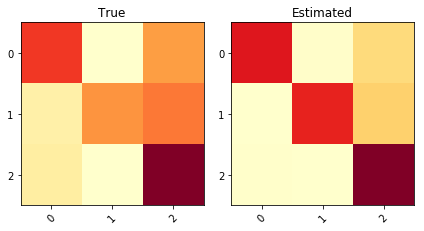

KL divergence: 0.2348	Pearson Correlation between diagonals: 0.9614


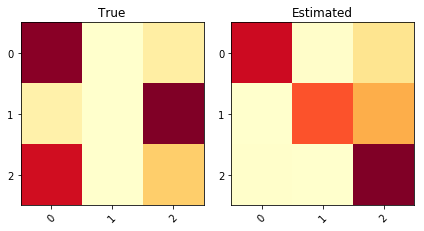

KL divergence: 1.3918	Pearson Correlation between diagonals: 0.3209


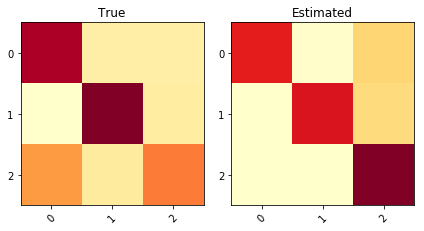

KL divergence: 0.7059	Pearson Correlation between diagonals: -0.9483


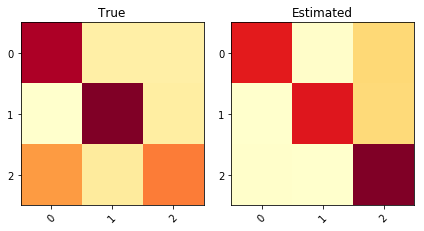

KL divergence: 0.7015	Pearson Correlation between diagonals: -0.9683


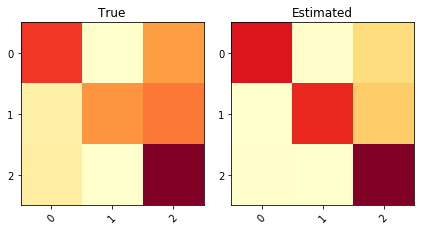

KL divergence: 0.2301	Pearson Correlation between diagonals: 0.9772


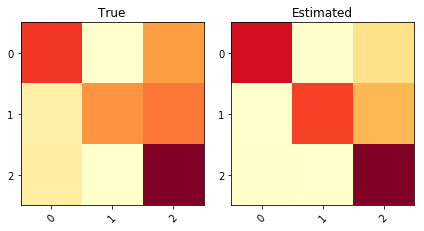

KL divergence: 0.2154	Pearson Correlation between diagonals: 0.9987


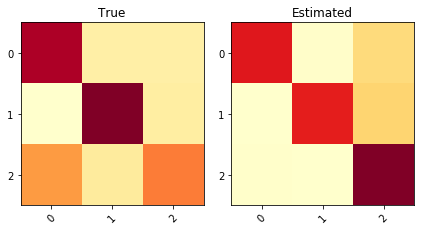

KL divergence: 0.6946	Pearson Correlation between diagonals: -0.9927


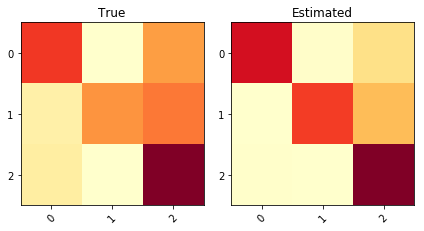

KL divergence: 0.2175	Pearson Correlation between diagonals: 1.0000


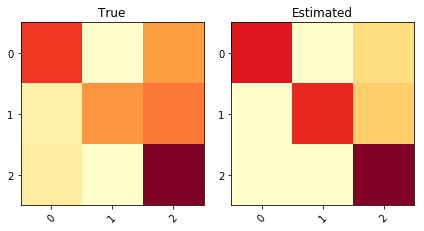

KL divergence: 0.2318	Pearson Correlation between diagonals: 0.9719


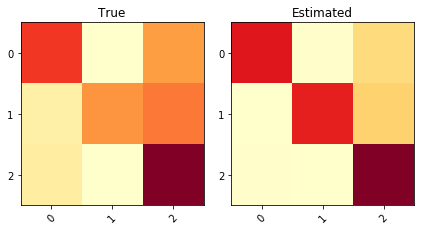

KL divergence: 0.2370	Pearson Correlation between diagonals: 0.9526


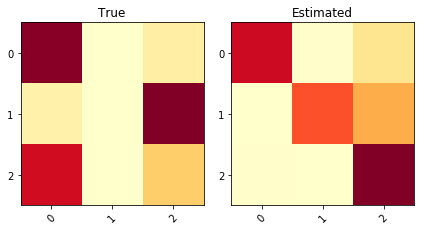

KL divergence: 1.3941	Pearson Correlation between diagonals: 0.3164


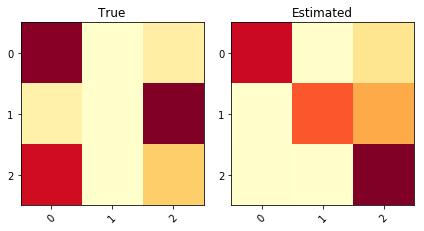

KL divergence: 1.3802	Pearson Correlation between diagonals: 0.3438


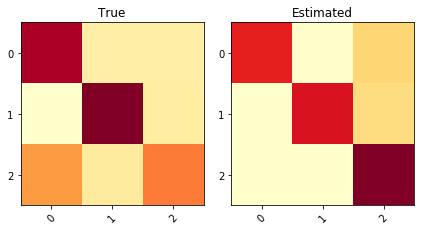

KL divergence: 0.7092	Pearson Correlation between diagonals: -0.9320


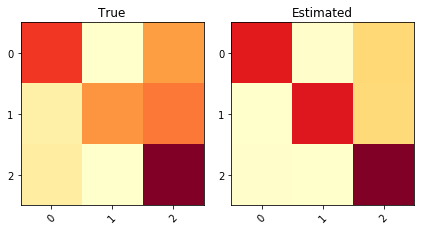

KL divergence: 0.2494	Pearson Correlation between diagonals: 0.8984


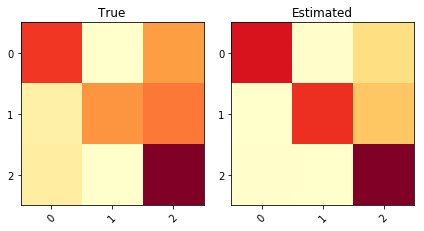

KL divergence: 0.2242	Pearson Correlation between diagonals: 0.9924
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.89825       0.89825   0.577248   0.084947            0.328995        0.151221
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.630185                0.786908
====  =======================  ======================
Test


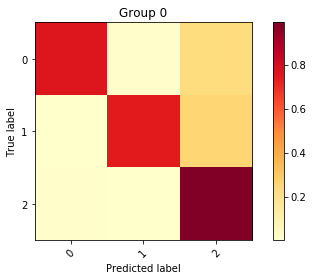

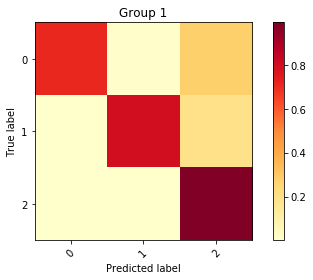

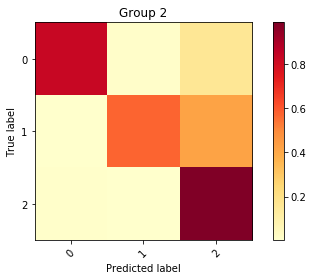

Inertia: 0.007227727444842458
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.29693      593   0.411571     0.831426   0.193448       0.907181   0.498093    0.715507      0.715507
   1         1  0.419679     839   0.398301     0.836052   0.18867        0.909572   0.502719    0.805861      0.805861
   2         2  0.283392     566   0.418249     0.798585   0.249393       0.883511   0.465252    0.648352      0.648352
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [103]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


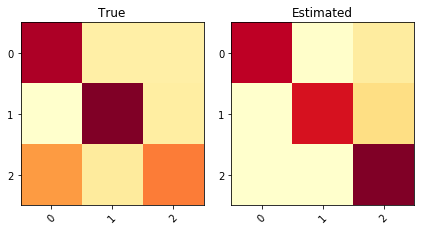

KL divergence: 0.8500	Pearson Correlation between diagonals: -0.9831


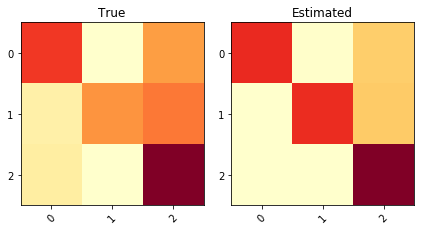

KL divergence: 0.2617	Pearson Correlation between diagonals: 0.9333


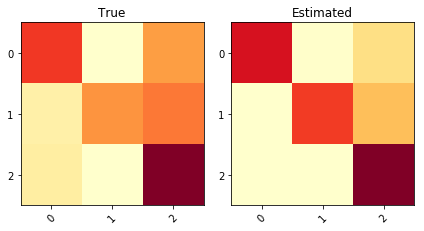

KL divergence: 0.2636	Pearson Correlation between diagonals: 0.9996


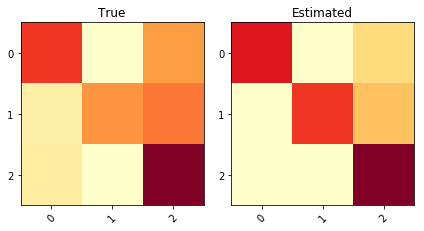

KL divergence: 0.2616	Pearson Correlation between diagonals: 0.9898


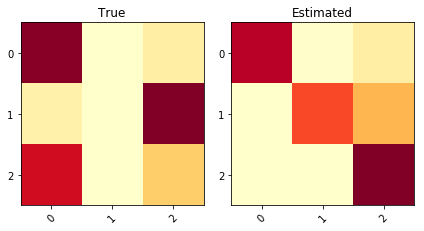

KL divergence: 1.7264	Pearson Correlation between diagonals: 0.4592


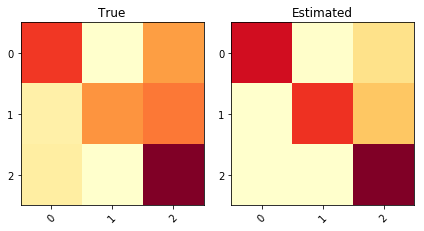

KL divergence: 0.2774	Pearson Correlation between diagonals: 0.9998


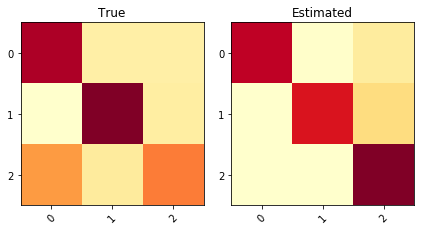

KL divergence: 0.8532	Pearson Correlation between diagonals: -0.9805


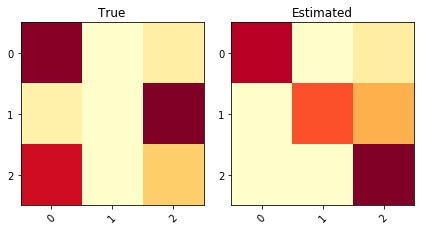

KL divergence: 1.7082	Pearson Correlation between diagonals: 0.4647


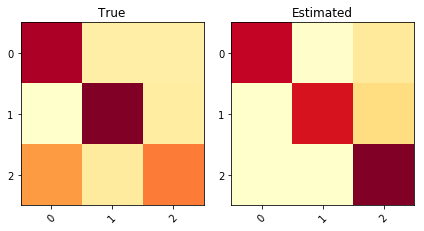

KL divergence: 0.8563	Pearson Correlation between diagonals: -0.9934


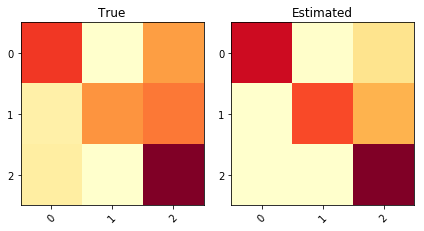

KL divergence: 0.2637	Pearson Correlation between diagonals: 0.9915


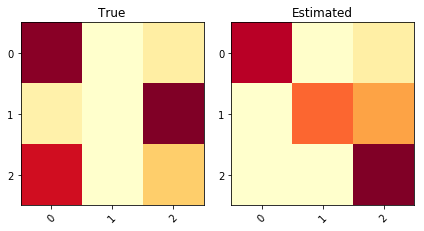

KL divergence: 1.6701	Pearson Correlation between diagonals: 0.5103


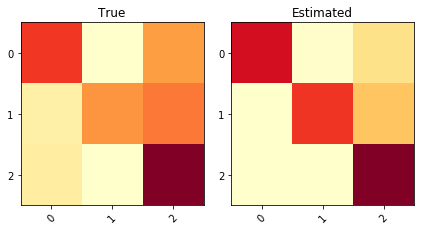

KL divergence: 0.2729	Pearson Correlation between diagonals: 0.9997


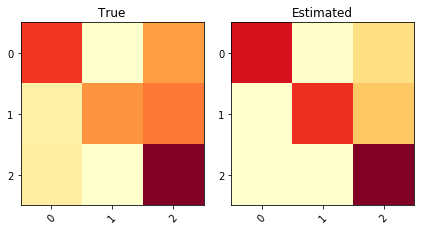

KL divergence: 0.2725	Pearson Correlation between diagonals: 0.9956


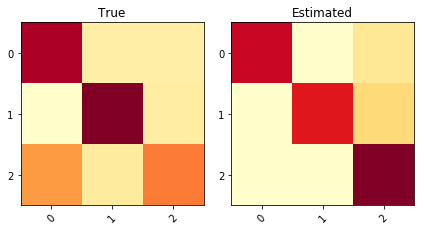

KL divergence: 0.8648	Pearson Correlation between diagonals: -0.9929


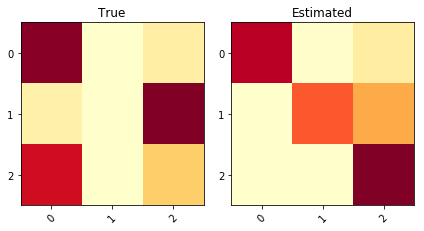

KL divergence: 1.6948	Pearson Correlation between diagonals: 0.4763
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.904762      0.904762   0.690459  0.0839284            0.382153        0.135871
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.647914                0.774467
====  =======================  ======================
Test


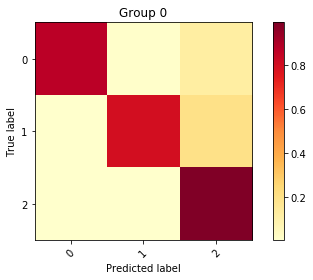

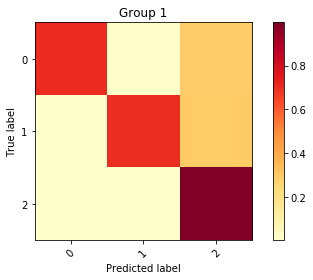

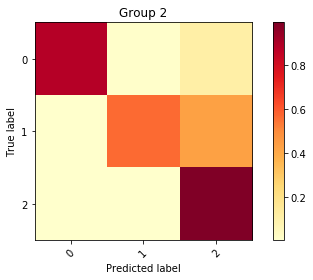

Inertia: 0.010683130628118912
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.308806     617   0.312619     0.890473   0.120068       0.941563   0.55714     0.837607      0.837607
   1         1  0.394164     788   0.422838     0.802826   0.233353       0.889142   0.469493    0.705739      0.705739
   2         2  0.29703      594   0.36901      0.815786   0.231375       0.892482   0.482453    0.648352      0.648352
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [104]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


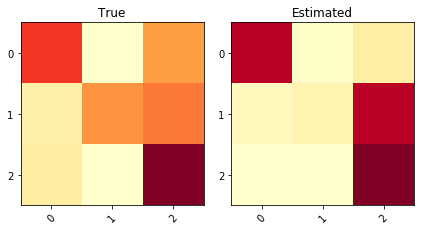

KL divergence: 0.3624	Pearson Correlation between diagonals: 0.8637


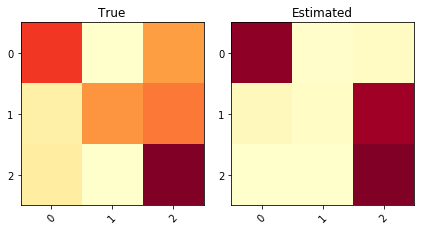

KL divergence: 0.6894	Pearson Correlation between diagonals: 0.8125


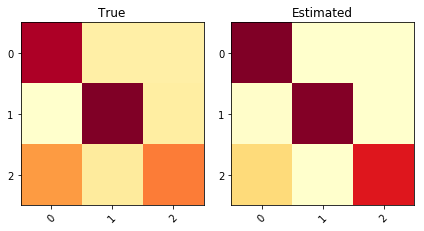

KL divergence: 0.3867	Pearson Correlation between diagonals: 0.9742


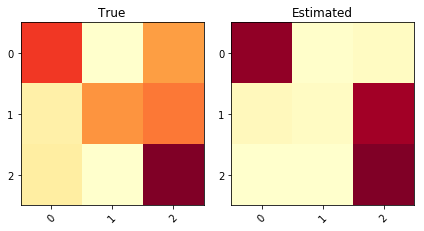

KL divergence: 0.6603	Pearson Correlation between diagonals: 0.8146


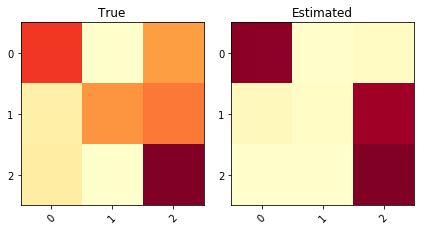

KL divergence: 0.7058	Pearson Correlation between diagonals: 0.8114


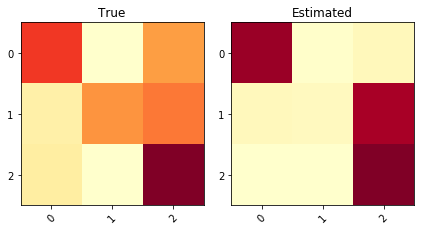

KL divergence: 0.5525	Pearson Correlation between diagonals: 0.8252


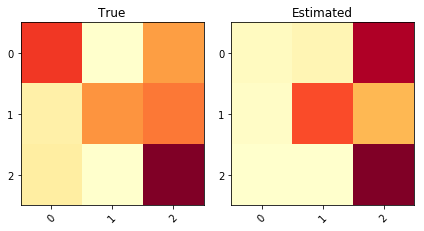

KL divergence: 0.6322	Pearson Correlation between diagonals: 0.4931


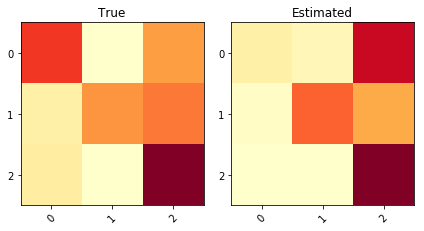

KL divergence: 0.3962	Pearson Correlation between diagonals: 0.5737


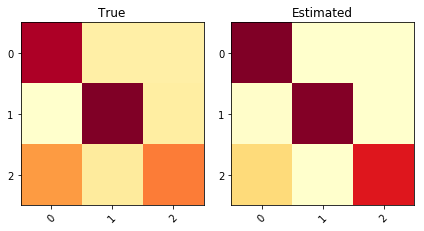

KL divergence: 0.3867	Pearson Correlation between diagonals: 0.9742


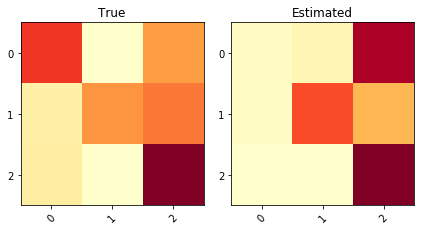

KL divergence: 0.6405	Pearson Correlation between diagonals: 0.4917


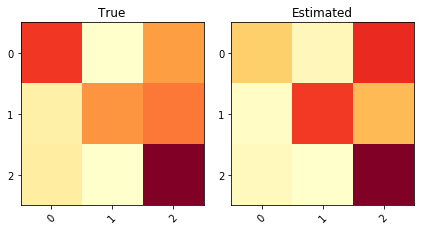

KL divergence: 0.1534	Pearson Correlation between diagonals: 0.5630


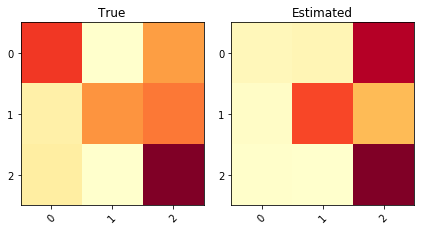

KL divergence: 0.5014	Pearson Correlation between diagonals: 0.4886


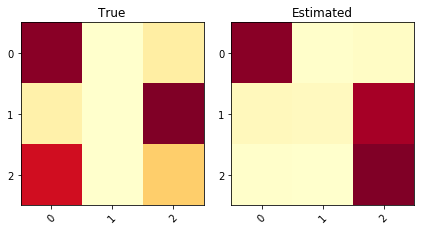

KL divergence: 1.1185	Pearson Correlation between diagonals: 0.7094


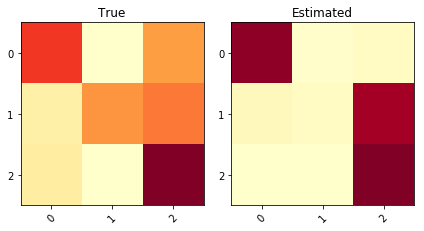

KL divergence: 0.6178	Pearson Correlation between diagonals: 0.8140


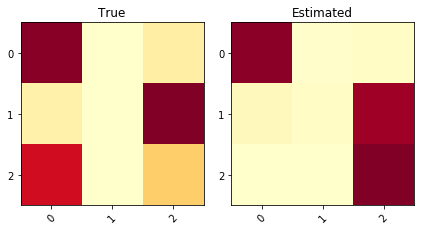

KL divergence: 1.4393	Pearson Correlation between diagonals: 0.7066
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.894587      0.894587   0.743548  0.0896523            0.510537        0.128849
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.649613                0.789168
====  =======================  ======================
Test


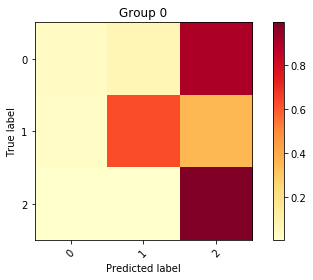

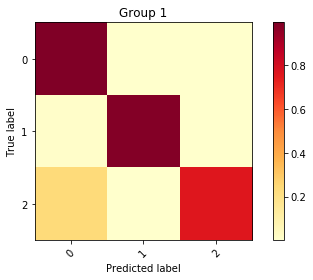

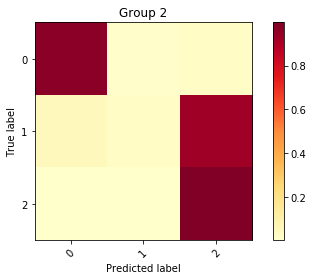

Inertia: 0.26021045198043186
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.268071     536   0.381196     0.552528  1.30696         0.628073   0.328793    0.495726      0.495726
   1         1  0.354952     709   0.235797     0.91206   0.0996091       0.952019   0.86809     0.660562      0.660562
   2         2  0.376977     753   0.1519       0.66309   1.2995          0.685887   0.494636    0.6337        0.6337
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =========

In [17]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


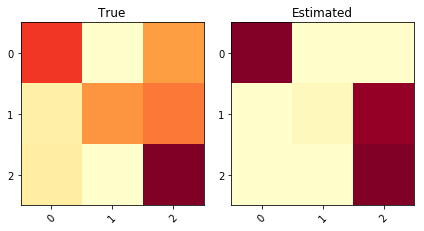

KL divergence: 0.8315	Pearson Correlation between diagonals: 0.8015


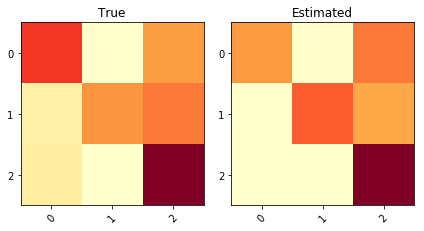

KL divergence: 0.2118	Pearson Correlation between diagonals: 0.7937


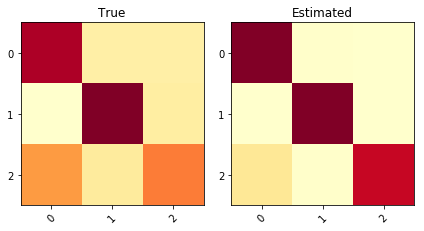

KL divergence: 0.3677	Pearson Correlation between diagonals: 0.9865


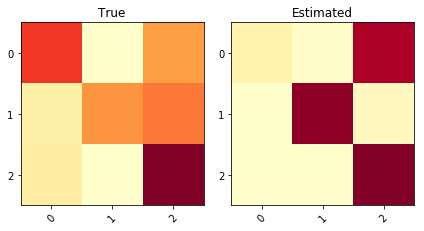

KL divergence: 0.8015	Pearson Correlation between diagonals: 0.1603


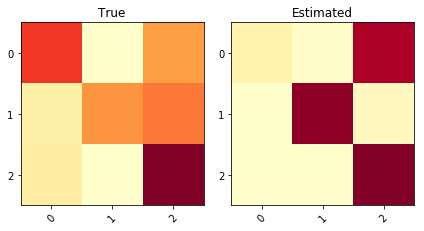

KL divergence: 0.8007	Pearson Correlation between diagonals: 0.1604


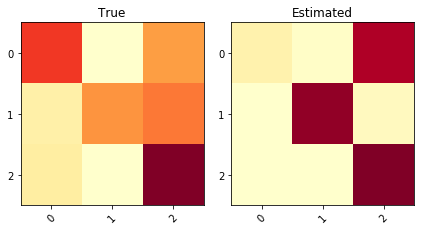

KL divergence: 0.7777	Pearson Correlation between diagonals: 0.1612


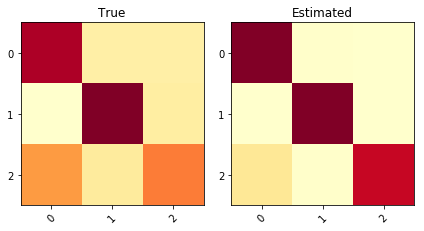

KL divergence: 0.3677	Pearson Correlation between diagonals: 0.9865


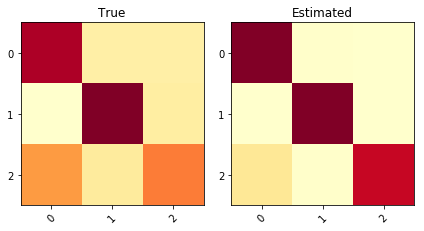

KL divergence: 0.3676	Pearson Correlation between diagonals: 0.9865


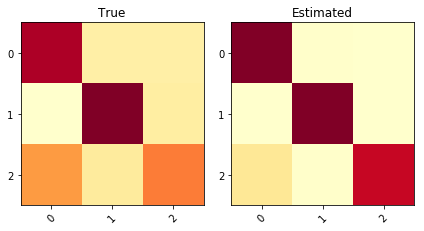

KL divergence: 0.3677	Pearson Correlation between diagonals: 0.9865


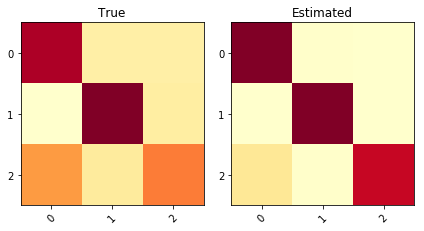

KL divergence: 0.3672	Pearson Correlation between diagonals: 0.9864


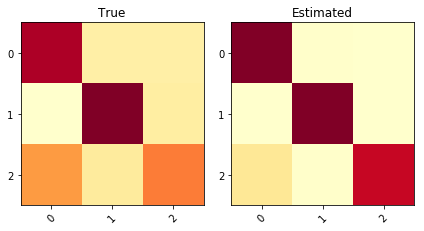

KL divergence: 0.3675	Pearson Correlation between diagonals: 0.9865


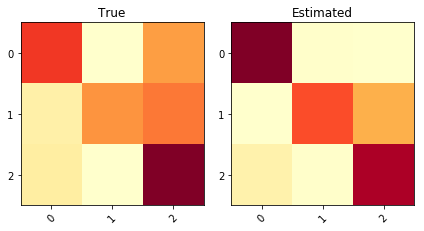

KL divergence: 0.5908	Pearson Correlation between diagonals: 0.6344


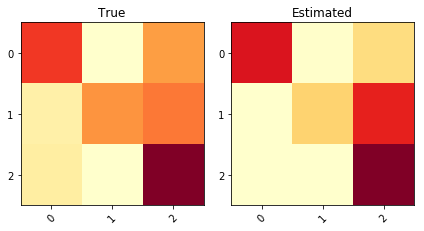

KL divergence: 0.2506	Pearson Correlation between diagonals: 0.9412


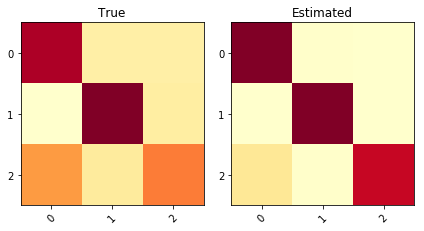

KL divergence: 0.3677	Pearson Correlation between diagonals: 0.9865


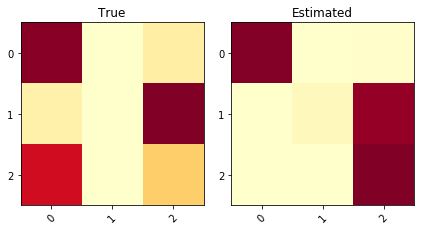

KL divergence: 1.5604	Pearson Correlation between diagonals: 0.7175
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.90639       0.90639   0.783399  0.0996352            0.567256        0.126013
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.668047                0.775712
====  =======================  ======================
Test


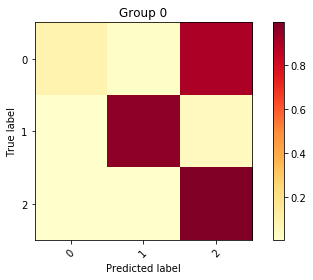

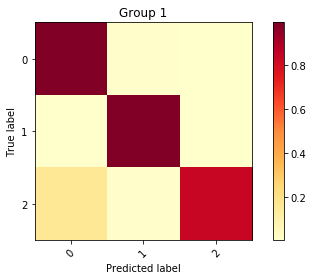

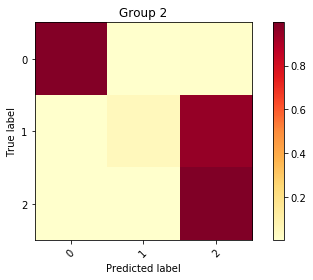

Inertia: 0.2521203060944875
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.278374     556  0.19107       0.680496  0.834011        0.731292   0.520744    0.616606      0.616606
   1         1  0.284927     569  0.193956      0.940364  0.0646429       0.968431   0.910545    0.661783      0.661783
   2         2  0.436699     873  0.0962621     0.676592  1.0417          0.708495   0.514888    0.634921      0.634921
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ========

In [16]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 5) configuration: Manny annot v2 ($T=5000, T_{data}=40$)

In [11]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.8131868131868132


evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 6) configuration: Manny annot v3 ($T$ = 10000, $T_{data}$ = 40 )

In [23]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.8298738298738298


*** Soft-Majority (Train with softMV) ***
Train


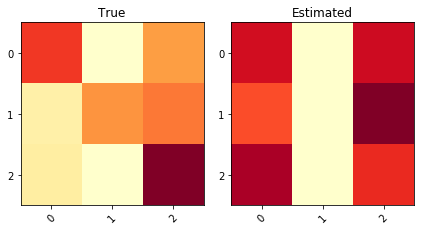

KL divergence: 2.2361	Pearson Correlation between diagonals: 0.7285


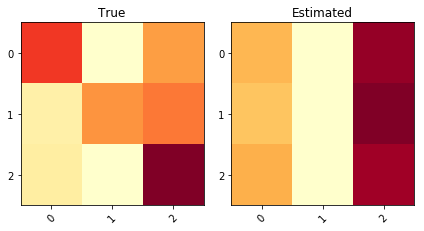

KL divergence: 2.1694	Pearson Correlation between diagonals: 1.0000


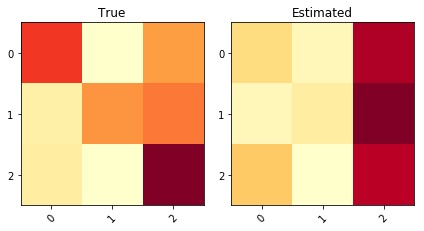

KL divergence: 0.2724	Pearson Correlation between diagonals: 0.9622


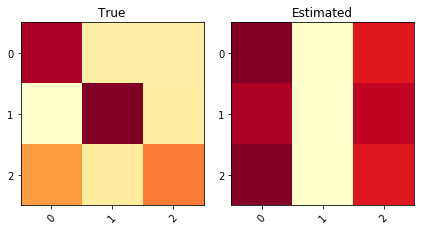

KL divergence: 5.7389	Pearson Correlation between diagonals: -0.4712


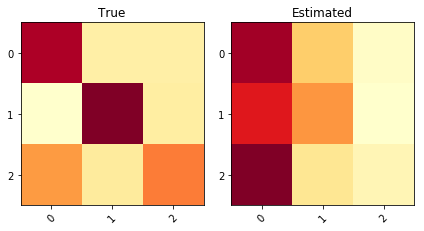

KL divergence: 0.3808	Pearson Correlation between diagonals: 0.7282


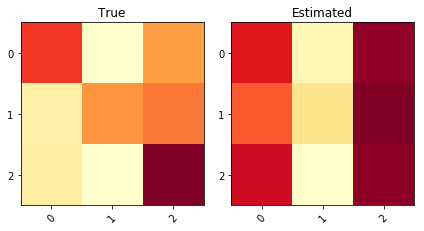

KL divergence: 0.2970	Pearson Correlation between diagonals: 0.9242


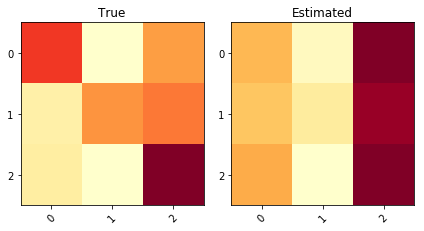

KL divergence: 0.2640	Pearson Correlation between diagonals: 0.9893


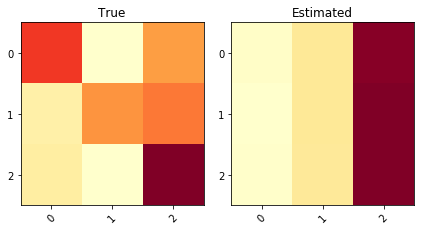

KL divergence: 0.4164	Pearson Correlation between diagonals: 0.8665


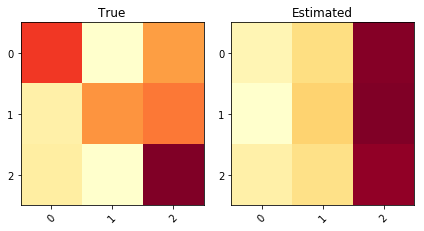

KL divergence: 0.3989	Pearson Correlation between diagonals: 0.8189


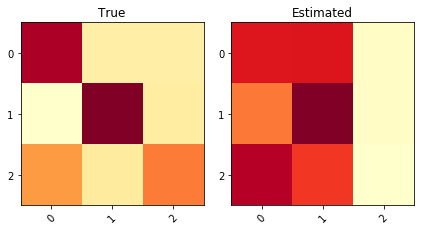

KL divergence: 0.3860	Pearson Correlation between diagonals: 0.9996


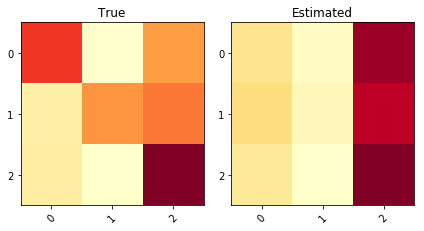

KL divergence: 0.2929	Pearson Correlation between diagonals: 0.9627


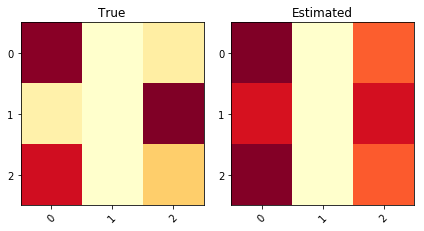

KL divergence: 0.2039	Pearson Correlation between diagonals: 0.9376


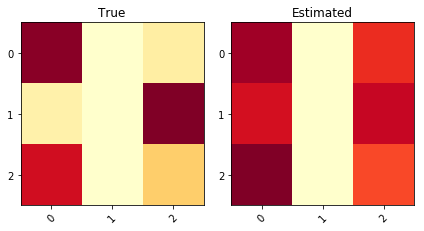

KL divergence: 0.2242	Pearson Correlation between diagonals: 0.9013


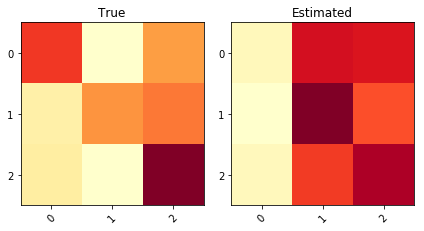

KL divergence: 0.4346	Pearson Correlation between diagonals: 0.0369


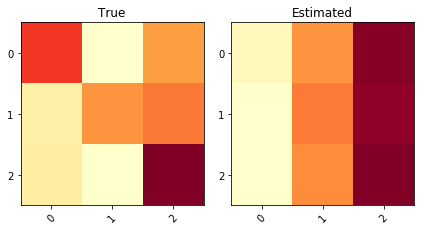

KL divergence: 0.3832	Pearson Correlation between diagonals: 0.5900
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.344729      0.344729   0.943795   0.106243            0.695869
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.343101      0.343101
====  ======  ==========  ============


In [24]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


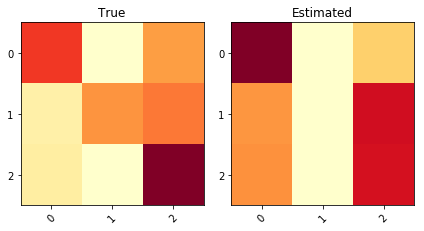

KL divergence: 2.1604	Pearson Correlation between diagonals: 0.6627


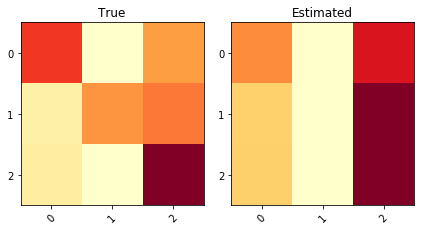

KL divergence: 2.0992	Pearson Correlation between diagonals: 0.9916


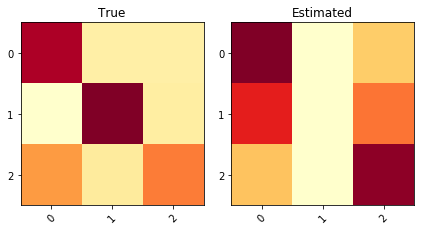

KL divergence: 5.7052	Pearson Correlation between diagonals: -0.6367


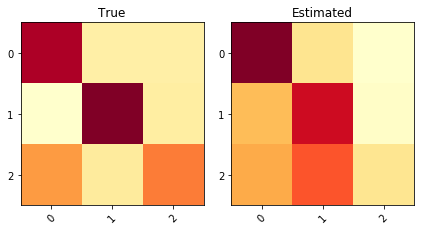

KL divergence: 0.2590	Pearson Correlation between diagonals: 0.9199


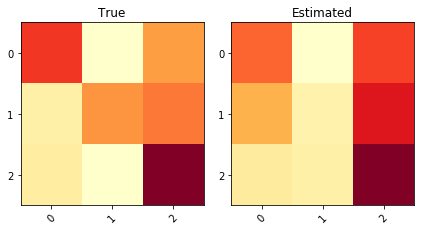

KL divergence: 0.2086	Pearson Correlation between diagonals: 0.9852


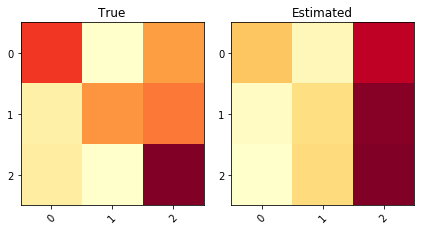

KL divergence: 0.2347	Pearson Correlation between diagonals: 0.9604


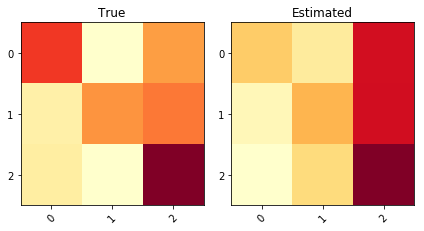

KL divergence: 0.2390	Pearson Correlation between diagonals: 0.8819


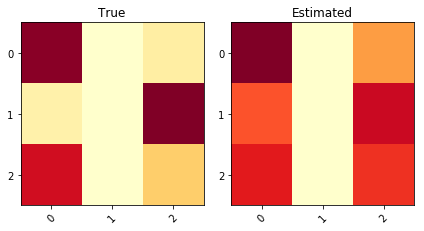

KL divergence: 0.1683	Pearson Correlation between diagonals: 0.8974


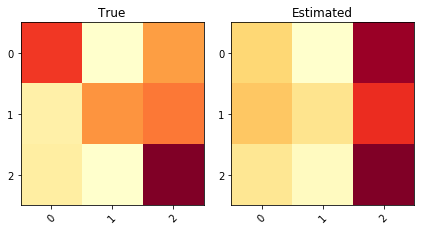

KL divergence: 0.2206	Pearson Correlation between diagonals: 0.9498


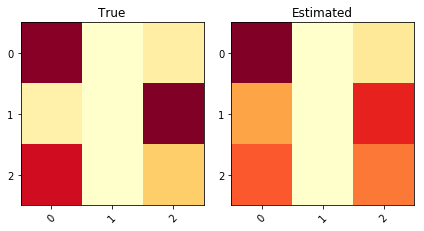

KL divergence: 0.1021	Pearson Correlation between diagonals: 0.9592


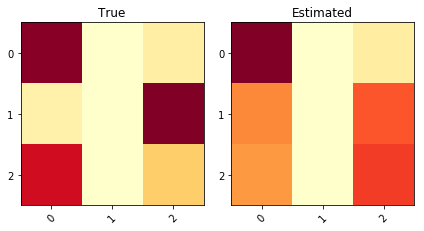

KL divergence: 0.1862	Pearson Correlation between diagonals: 0.9099


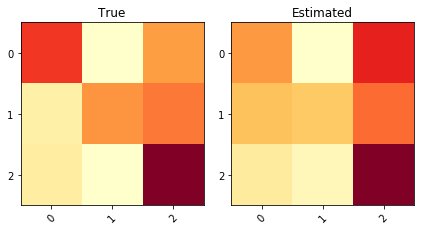

KL divergence: 0.1249	Pearson Correlation between diagonals: 0.9830


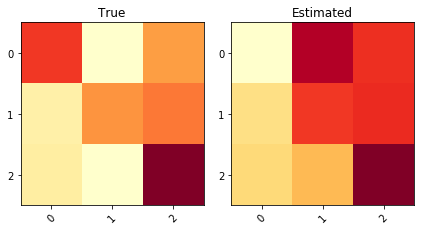

KL divergence: 0.5596	Pearson Correlation between diagonals: 0.4337


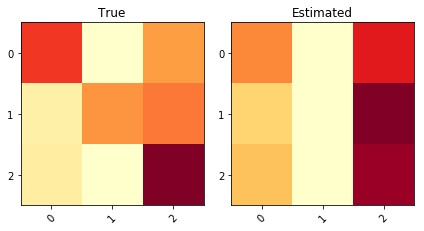

KL divergence: 2.1037	Pearson Correlation between diagonals: 0.9845


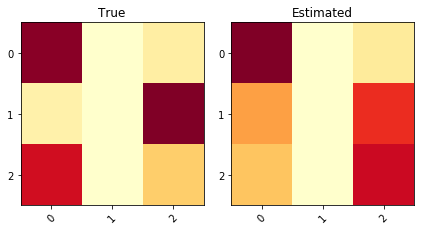

KL divergence: 0.2330	Pearson Correlation between diagonals: 0.8261
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.684575      0.684575   0.875637  0.0878307            0.692878
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.691087      0.691087
====  ======  ==========  ============


In [25]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


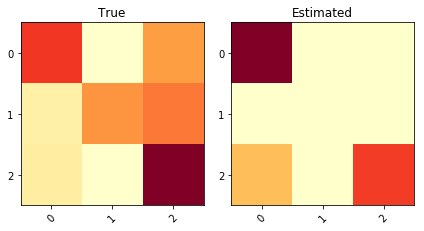

KL divergence: 1.9898	Pearson Correlation between diagonals: 0.5533


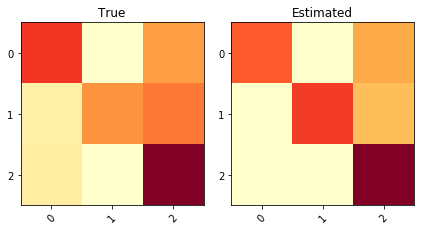

KL divergence: 0.8674	Pearson Correlation between diagonals: 0.8513


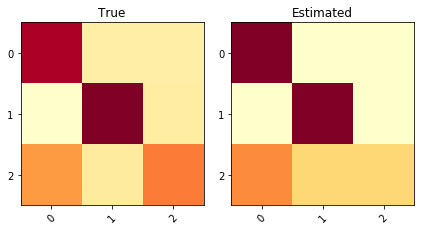

KL divergence: 1.3143	Pearson Correlation between diagonals: 0.9813


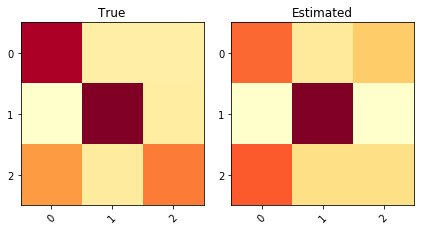

KL divergence: 0.5633	Pearson Correlation between diagonals: 0.9319


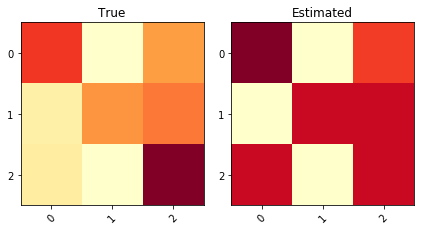

KL divergence: 0.5081	Pearson Correlation between diagonals: -0.1270


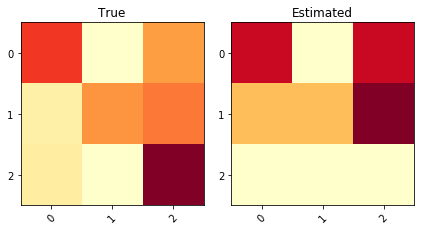

KL divergence: 0.3096	Pearson Correlation between diagonals: -0.5107


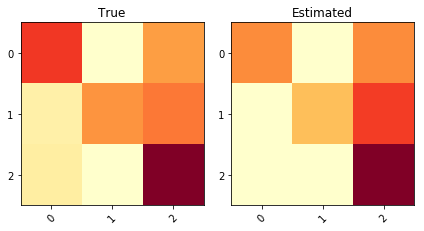

KL divergence: 0.8610	Pearson Correlation between diagonals: 0.9882


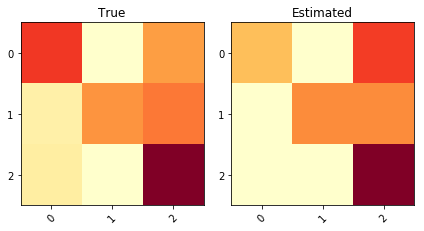

KL divergence: 0.8946	Pearson Correlation between diagonals: 0.8028


/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


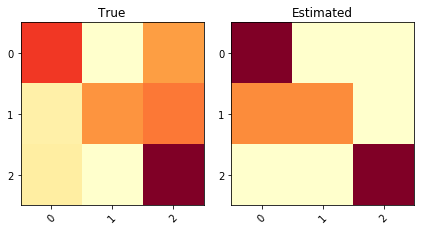

KL divergence: 4.7533	Pearson Correlation between diagonals: 0.7955


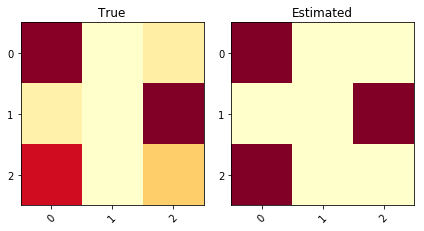

KL divergence: 2.0172	Pearson Correlation between diagonals: 0.9597


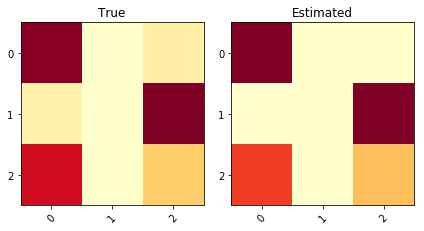

KL divergence: 0.8221	Pearson Correlation between diagonals: 0.9988


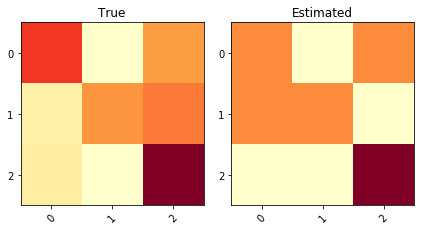

KL divergence: 2.8737	Pearson Correlation between diagonals: 0.9225


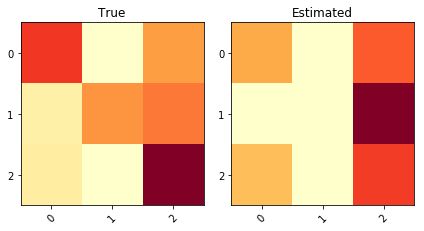

KL divergence: 2.5333	Pearson Correlation between diagonals: 0.9708


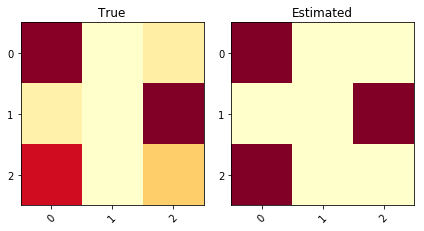

KL divergence: 2.0172	Pearson Correlation between diagonals: 0.9597


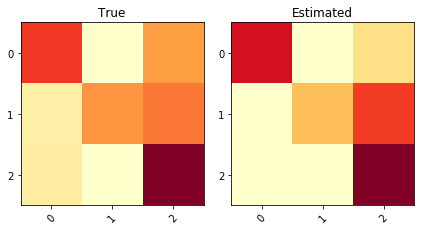

KL divergence: 0.8859	Pearson Correlation between diagonals: 0.9379
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.919007      0.919007    2.16296   0.126014                 nan
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.923077      0.923077
====  ======  ==========  ============


/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: divide by zero encountered in double_scalars
  r = r_num / r_den


In [26]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


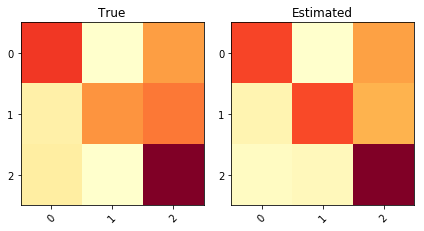

KL divergence: 0.1244	Pearson Correlation between diagonals: 0.9348


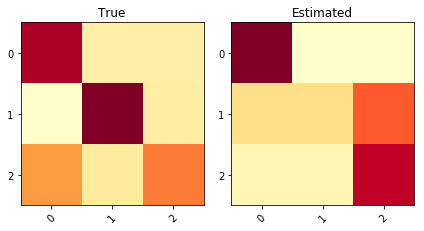

KL divergence: 0.3812	Pearson Correlation between diagonals: -0.5321


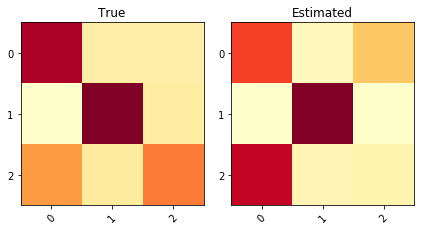

KL divergence: 0.2321	Pearson Correlation between diagonals: 0.9832


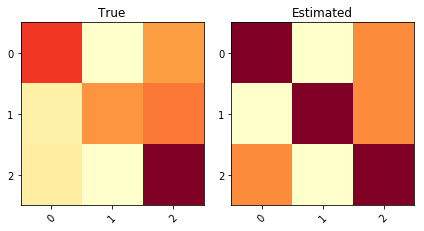

KL divergence: 0.2128	Pearson Correlation between diagonals: -0.7955


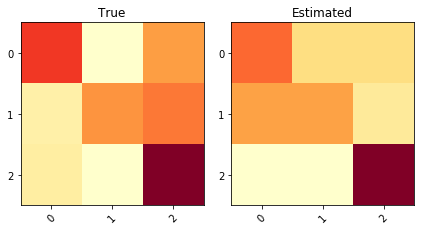

KL divergence: 0.2400	Pearson Correlation between diagonals: 0.9882


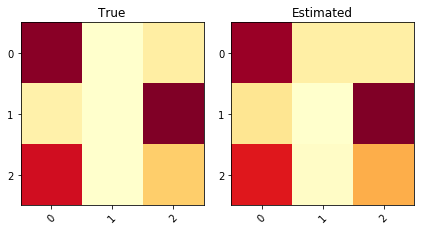

KL divergence: 0.1781	Pearson Correlation between diagonals: 0.9906


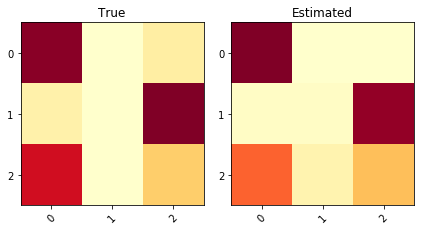

KL divergence: 0.1649	Pearson Correlation between diagonals: 0.9995


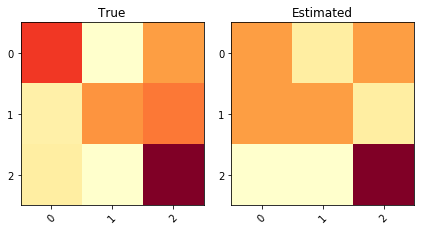

KL divergence: 0.2350	Pearson Correlation between diagonals: 0.9225


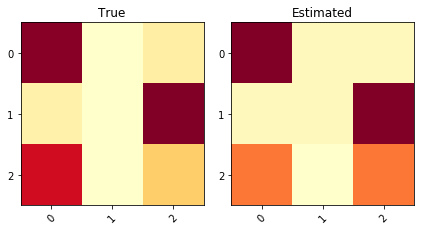

KL divergence: 0.2407	Pearson Correlation between diagonals: 0.9648


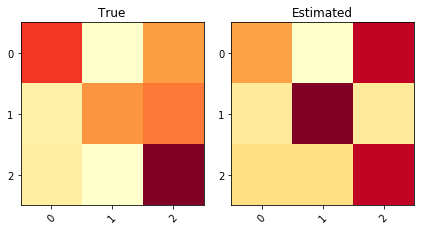

KL divergence: 0.2937	Pearson Correlation between diagonals: -0.1149


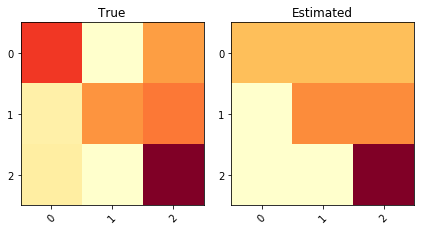

KL divergence: 0.3143	Pearson Correlation between diagonals: 0.8028


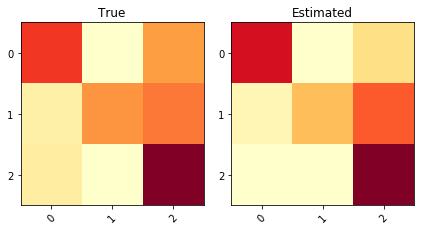

KL divergence: 0.1106	Pearson Correlation between diagonals: 0.9379


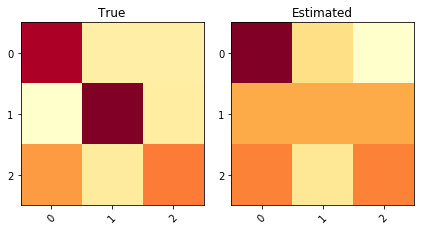

KL divergence: 0.2829	Pearson Correlation between diagonals: 0.1394


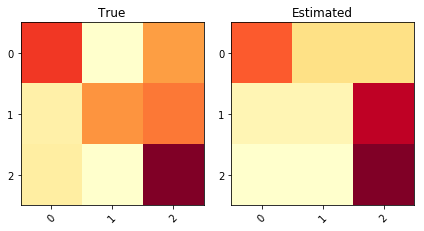

KL divergence: 0.2072	Pearson Correlation between diagonals: 0.9781


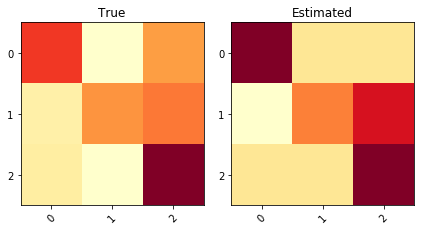

KL divergence: 0.1902	Pearson Correlation between diagonals: 0.7955


/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.664225      0.664225   0.236415  0.0692318                 nan        0.192318
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.671692                0.854101
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.680098      0.680098
====  ======  ==========  ============


In [27]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


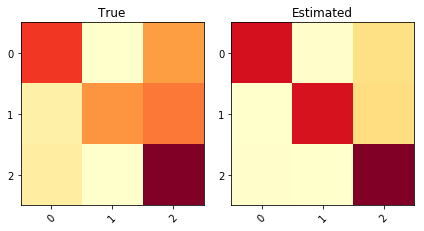

KL divergence: 0.2838	Pearson Correlation between diagonals: 0.9304


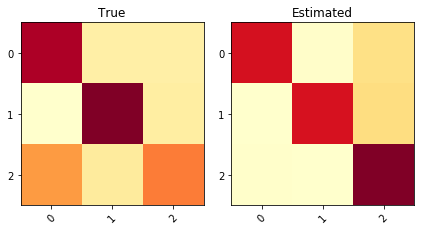

KL divergence: 0.6732	Pearson Correlation between diagonals: -0.9841


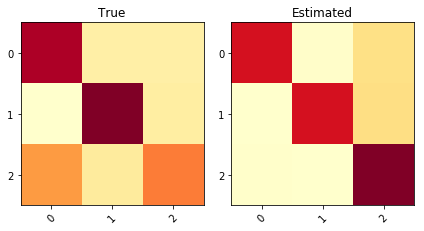

KL divergence: 0.6672	Pearson Correlation between diagonals: -0.9815


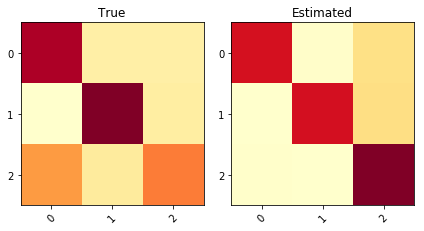

KL divergence: 0.6644	Pearson Correlation between diagonals: -0.9802


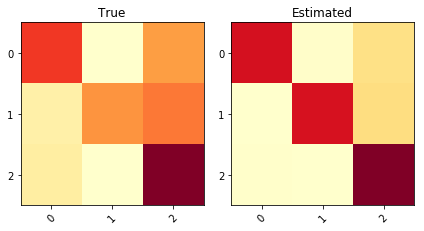

KL divergence: 0.2848	Pearson Correlation between diagonals: 0.9282


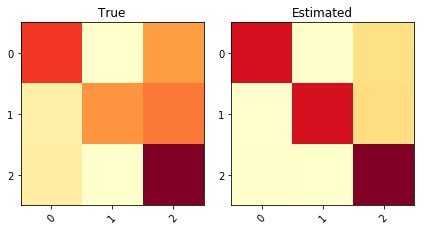

KL divergence: 0.2840	Pearson Correlation between diagonals: 0.9296


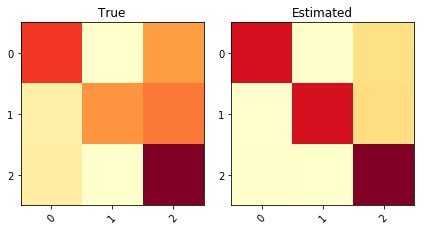

KL divergence: 0.2840	Pearson Correlation between diagonals: 0.9289


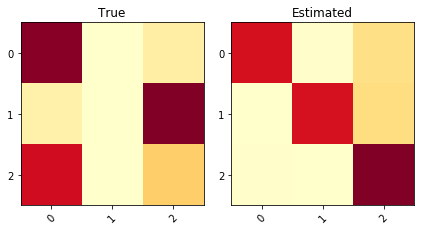

KL divergence: 1.6128	Pearson Correlation between diagonals: -0.2187


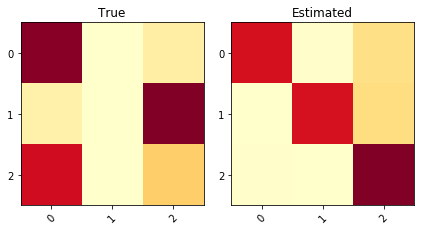

KL divergence: 1.6123	Pearson Correlation between diagonals: -0.2162


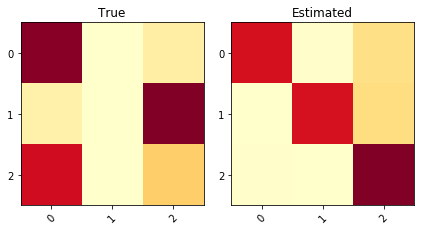

KL divergence: 1.6127	Pearson Correlation between diagonals: -0.2189


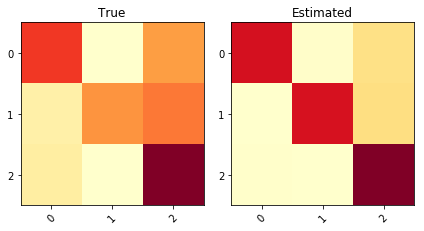

KL divergence: 0.2853	Pearson Correlation between diagonals: 0.9271


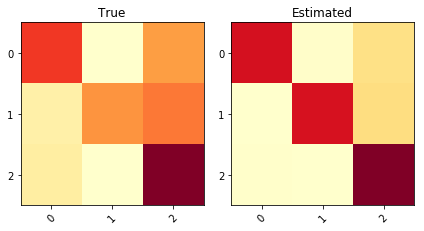

KL divergence: 0.2846	Pearson Correlation between diagonals: 0.9289


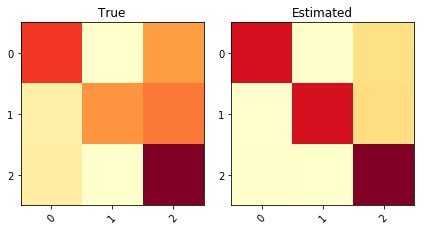

KL divergence: 0.2840	Pearson Correlation between diagonals: 0.9297


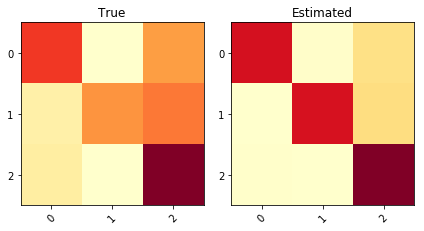

KL divergence: 0.2850	Pearson Correlation between diagonals: 0.9281


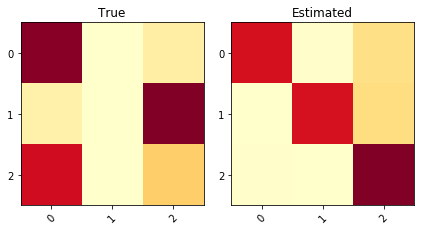

KL divergence: 1.6136	Pearson Correlation between diagonals: -0.2210
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.901099      0.901099   0.634778  0.0958811            0.227621        0.196777
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.601578                  0.8074
====  =======================  ======================
Test


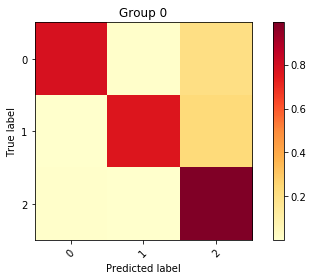

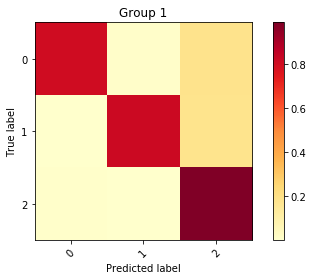

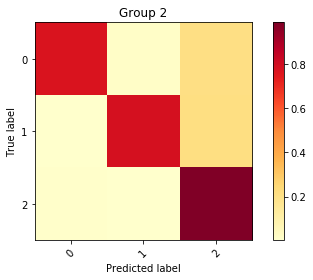

Inertia: 0.0006941696677434569
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.509769    5097   0.383405     0.847461   0.172483       0.91685    0.514128    0.664225      0.664225
   1         1  0.293071    2930   0.358103     0.871508   0.142037       0.931042   0.538174    0.714286      0.714286
   2         2  0.19716     1971   0.39276      0.850331   0.168667       0.918604   0.516998    0.684982      0.684982
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =====

In [28]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


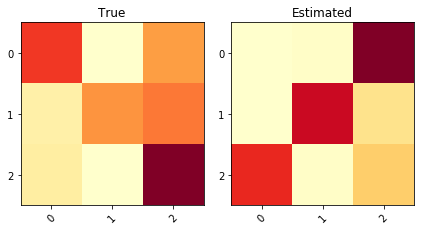

KL divergence: 1.7661	Pearson Correlation between diagonals: -0.5460


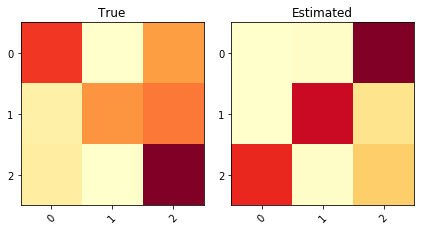

KL divergence: 1.7643	Pearson Correlation between diagonals: -0.5443


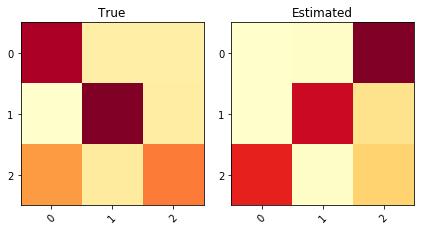

KL divergence: 2.0180	Pearson Correlation between diagonals: 0.3831


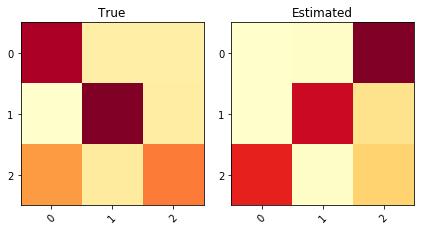

KL divergence: 2.0076	Pearson Correlation between diagonals: 0.3859


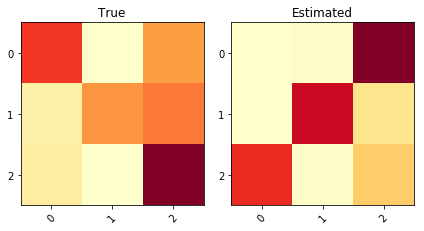

KL divergence: 1.7616	Pearson Correlation between diagonals: -0.5425


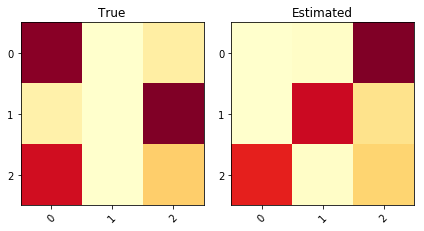

KL divergence: 2.7140	Pearson Correlation between diagonals: -0.9029


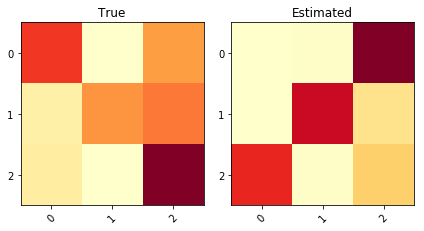

KL divergence: 1.7675	Pearson Correlation between diagonals: -0.5492


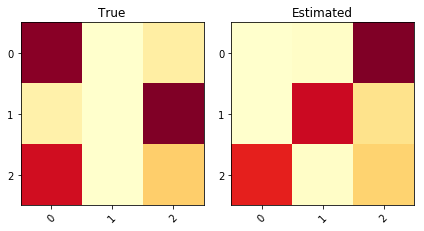

KL divergence: 2.7136	Pearson Correlation between diagonals: -0.9038


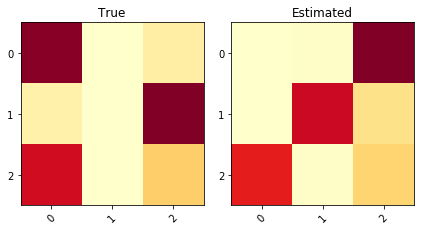

KL divergence: 2.7124	Pearson Correlation between diagonals: -0.9016


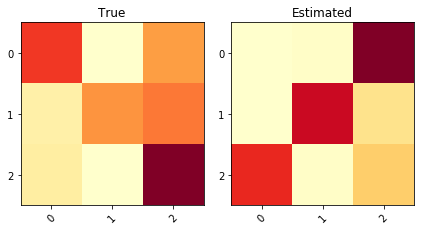

KL divergence: 1.7652	Pearson Correlation between diagonals: -0.5463


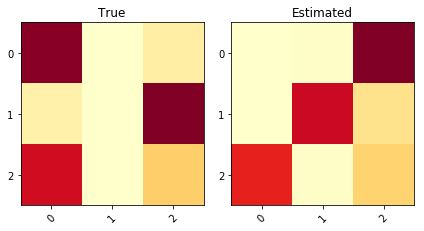

KL divergence: 2.7155	Pearson Correlation between diagonals: -0.9054


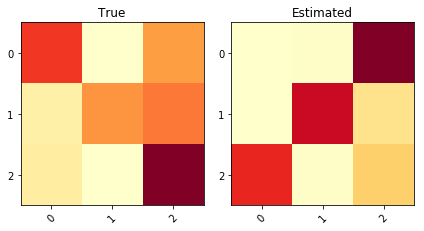

KL divergence: 1.7660	Pearson Correlation between diagonals: -0.5481


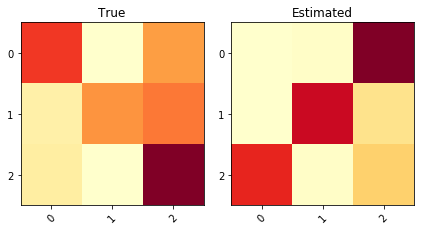

KL divergence: 1.7699	Pearson Correlation between diagonals: -0.5533


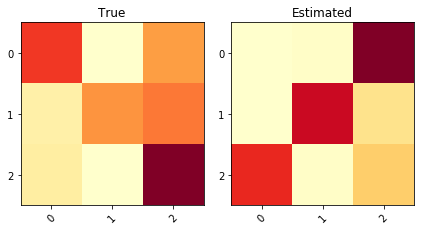

KL divergence: 1.7627	Pearson Correlation between diagonals: -0.5449


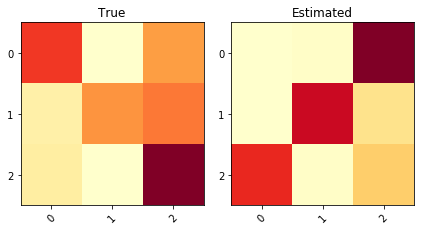

KL divergence: 1.7651	Pearson Correlation between diagonals: -0.5449
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.37851       0.37851    2.01078   0.219762            -0.38238        0.203455
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.599939                0.803456
====  =======================  ======================
Test


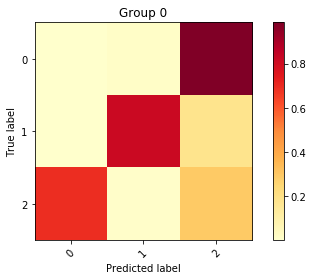

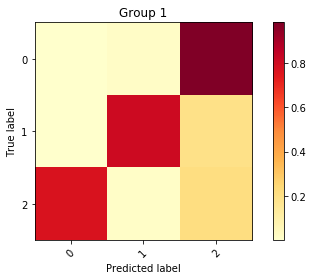

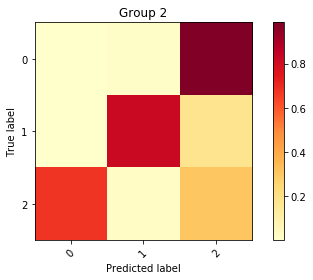

Inertia: 0.001275528554591195
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  0.502056    5020   0.402793     0.372082    3.05296       0.469439  0.0387491     0.67033       0.67033
   1         1  0.309751    3097   0.393764     0.340686    3.00726       0.436325  0.00735291    0.65812       0.65812
   2         2  0.188194    1881   0.417051     0.376822    2.72234       0.474936  0.0434882     0.671551      0.671551
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =

In [29]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


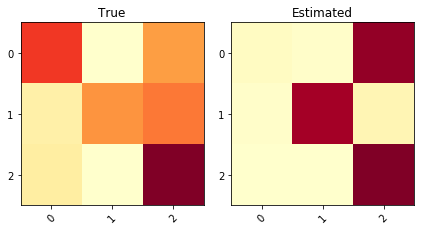

KL divergence: 0.8895	Pearson Correlation between diagonals: 0.1956


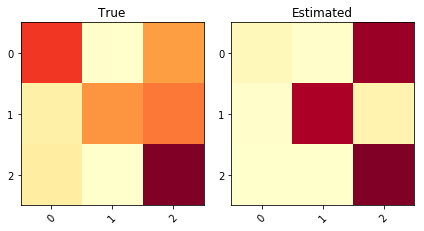

KL divergence: 0.7570	Pearson Correlation between diagonals: 0.2128


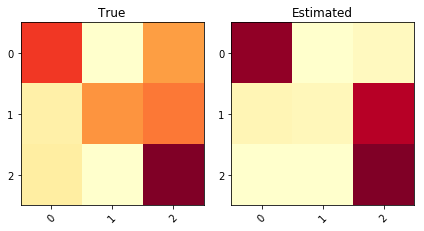

KL divergence: 0.5597	Pearson Correlation between diagonals: 0.8164


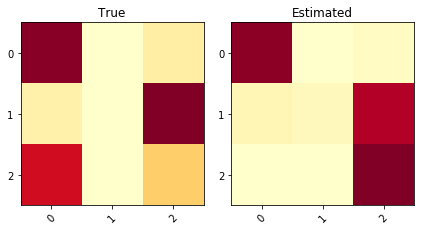

KL divergence: 1.5432	Pearson Correlation between diagonals: 0.7048


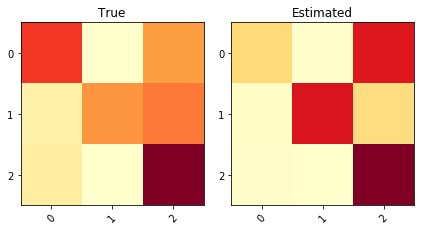

KL divergence: 0.2401	Pearson Correlation between diagonals: 0.4071


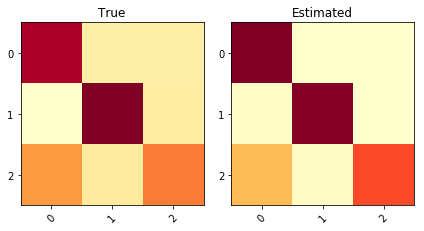

KL divergence: 0.3374	Pearson Correlation between diagonals: 0.9744


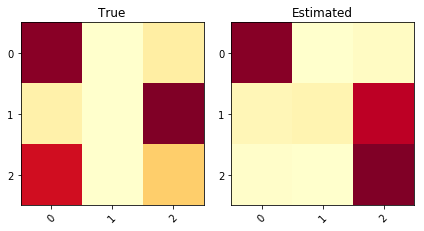

KL divergence: 0.9592	Pearson Correlation between diagonals: 0.7121


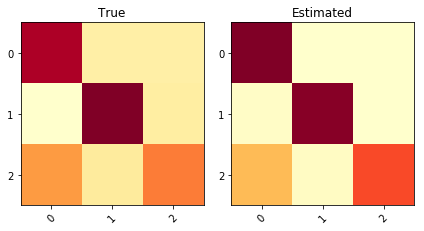

KL divergence: 0.3021	Pearson Correlation between diagonals: 0.9729


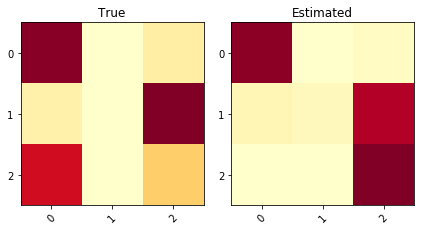

KL divergence: 1.4186	Pearson Correlation between diagonals: 0.7053


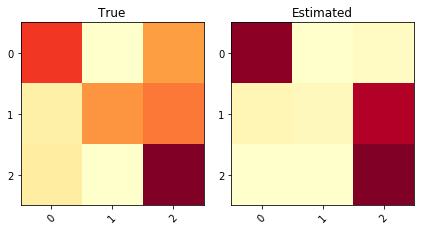

KL divergence: 0.6214	Pearson Correlation between diagonals: 0.8112


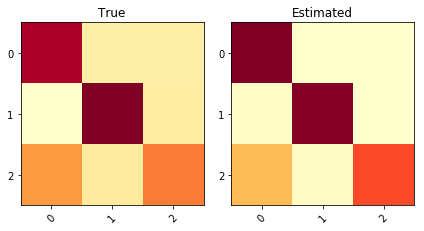

KL divergence: 0.3353	Pearson Correlation between diagonals: 0.9743


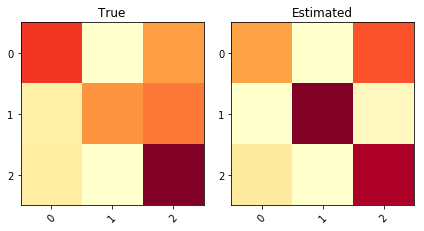

KL divergence: 0.3750	Pearson Correlation between diagonals: -0.0290


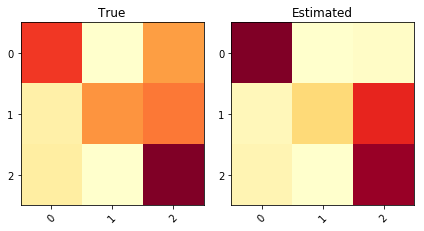

KL divergence: 0.3210	Pearson Correlation between diagonals: 0.7554


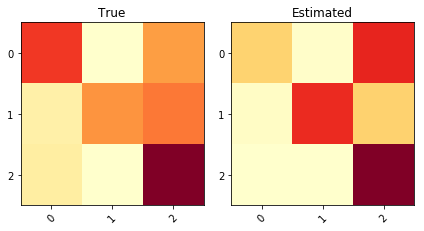

KL divergence: 0.2568	Pearson Correlation between diagonals: 0.5100


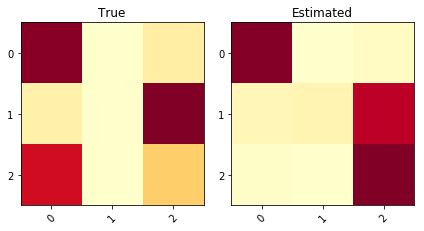

KL divergence: 0.9371	Pearson Correlation between diagonals: 0.7133
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.848596      0.848596   0.614026  0.0838562            0.546168        0.152531
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.699562                0.695094
====  =======================  ======================
Test


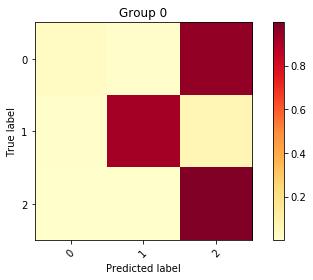

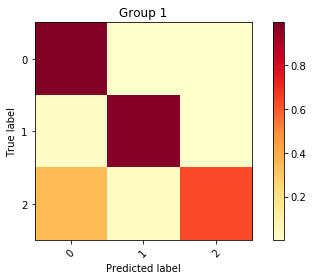

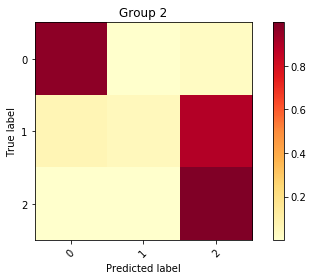

Inertia: 0.28160065909226734
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.278545    2785   0.169657     0.650655   1.1913         0.686204   0.475983    0.608059      0.608059
   1         1  0.298858    2988   0.298234     0.868274   0.162352       0.923966   0.802411    0.661783      0.661783
   2         2  0.422597    4225   0.191064     0.671076   1.04819        0.705622   0.506615    0.62149       0.62149
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ========

In [14]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


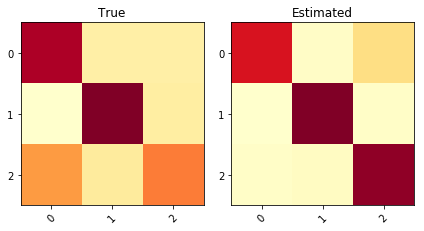

KL divergence: 0.4660	Pearson Correlation between diagonals: -0.1865


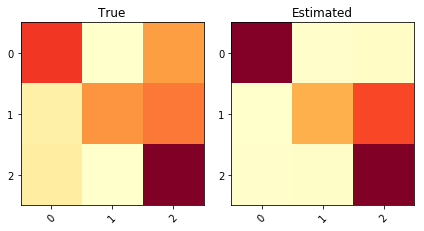

KL divergence: 0.4917	Pearson Correlation between diagonals: 0.8039


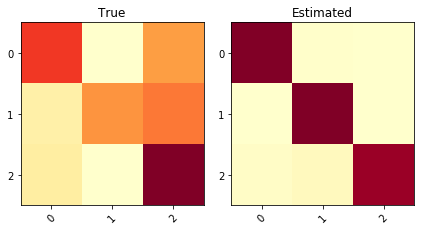

KL divergence: 1.6669	Pearson Correlation between diagonals: -0.9598


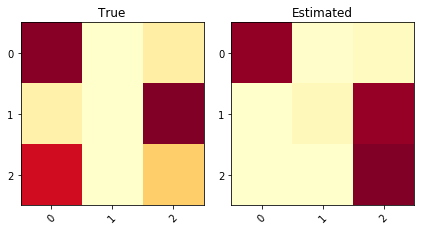

KL divergence: 1.7676	Pearson Correlation between diagonals: 0.6968


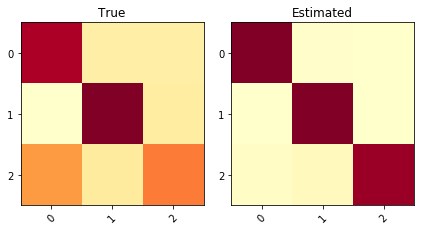

KL divergence: 0.6326	Pearson Correlation between diagonals: 0.9966


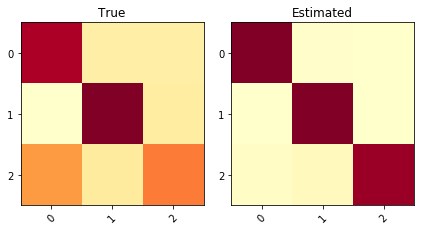

KL divergence: 0.6326	Pearson Correlation between diagonals: 0.9966


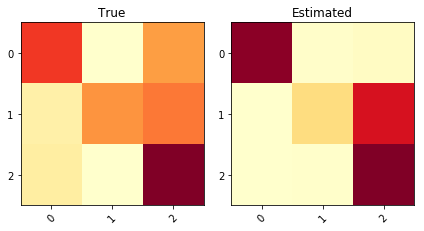

KL divergence: 0.5203	Pearson Correlation between diagonals: 0.8120


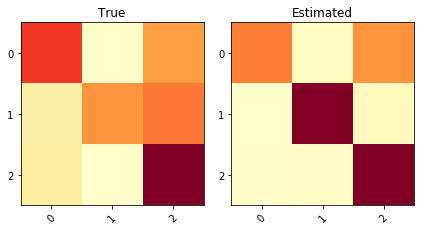

KL divergence: 0.5240	Pearson Correlation between diagonals: 0.1463


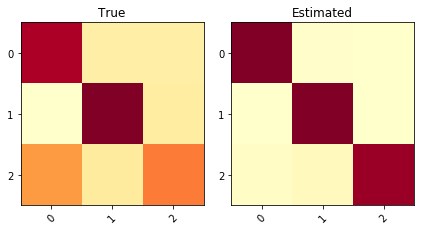

KL divergence: 0.6326	Pearson Correlation between diagonals: 0.9966


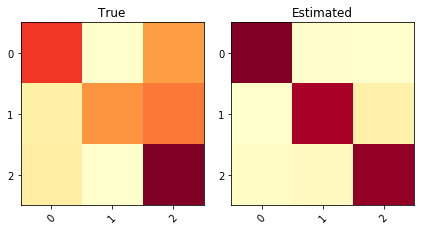

KL divergence: 0.8728	Pearson Correlation between diagonals: 0.3921


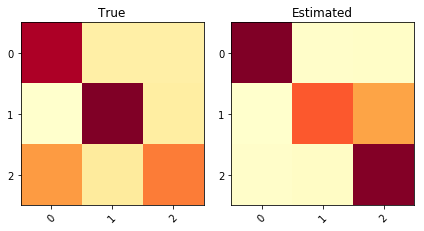

KL divergence: 0.5955	Pearson Correlation between diagonals: -0.6378


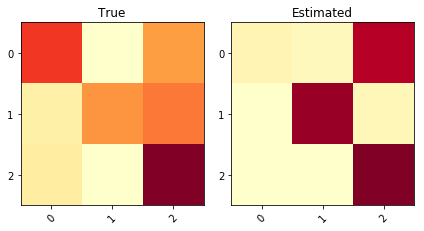

KL divergence: 0.8316	Pearson Correlation between diagonals: 0.1757


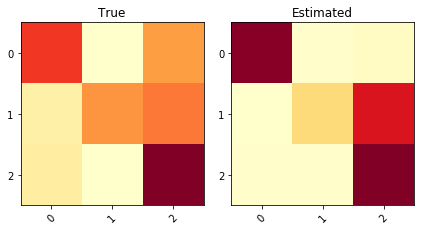

KL divergence: 0.5159	Pearson Correlation between diagonals: 0.8113


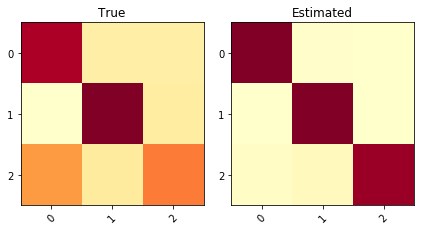

KL divergence: 0.6326	Pearson Correlation between diagonals: 0.9966


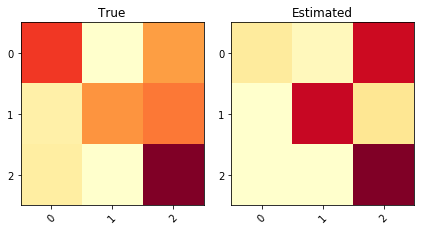

KL divergence: 0.5846	Pearson Correlation between diagonals: 0.2992
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.775336      0.775336   0.896283   0.106471             0.49454        0.147098
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.695271                0.706896
====  =======================  ======================
Test


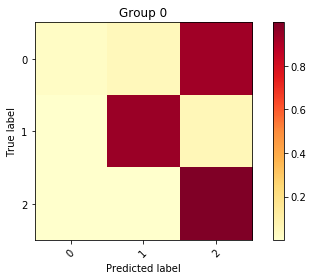

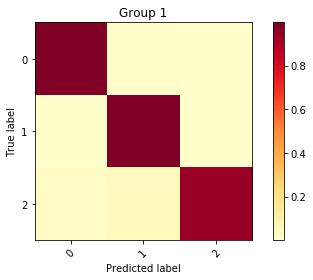

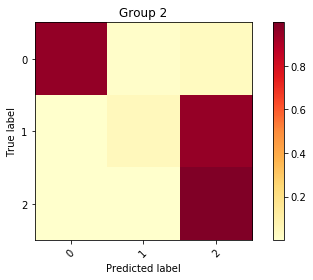

Inertia: 0.2583824594815572
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.294031    2939   0.17801      0.653783  1.30133         0.681466   0.480674    0.58486       0.58486
   1         1  0.357569    3574   0.110108     0.97672   0.0238969       0.98814    0.96508     0.765568      0.765568
   2         2  0.3484      3483   0.134039     0.668052  1.03218         0.705675   0.502078    0.565324      0.565324
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =========

In [14]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 7) configuration: Manny annot v1 bad MV ($T$ = 2000, $T_{max}$ = 20 )

In [45]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.6109076109076109


*** Raykar model multiples runs***
Train


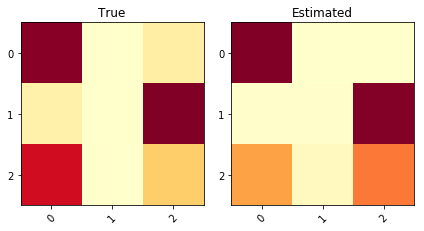

KL divergence: 0.1462	Pearson Correlation between diagonals: 0.9604


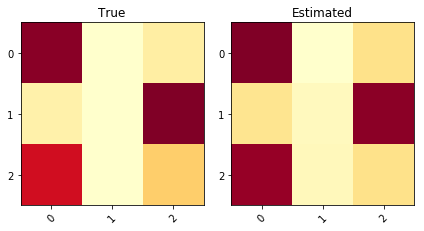

KL divergence: 0.1178	Pearson Correlation between diagonals: 0.9904


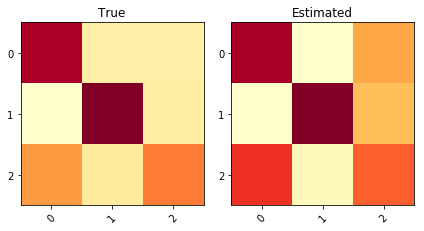

KL divergence: 0.1056	Pearson Correlation between diagonals: 1.0000


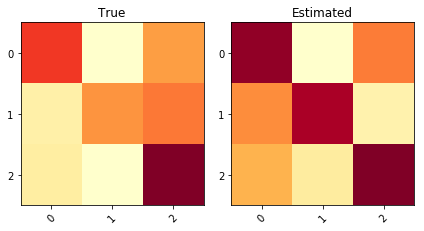

KL divergence: 0.2678	Pearson Correlation between diagonals: 0.9787


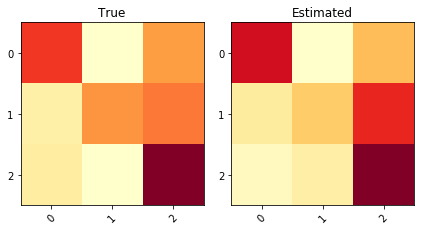

KL divergence: 0.1204	Pearson Correlation between diagonals: 0.9274


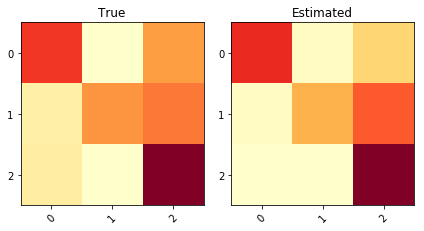

KL divergence: 0.1062	Pearson Correlation between diagonals: 0.9840


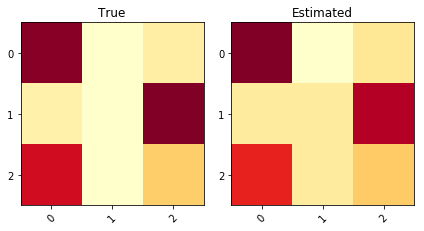

KL divergence: 0.1787	Pearson Correlation between diagonals: 0.9937


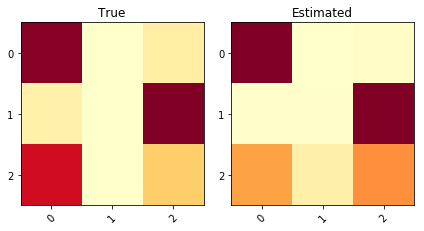

KL divergence: 0.1700	Pearson Correlation between diagonals: 0.9740


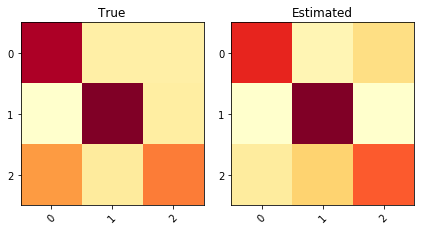

KL divergence: 0.1089	Pearson Correlation between diagonals: 0.8531


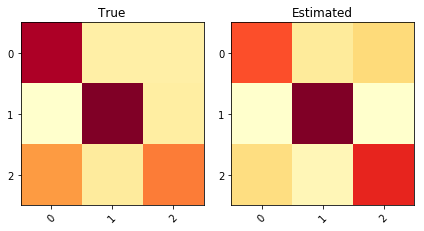

KL divergence: 0.0981	Pearson Correlation between diagonals: 0.4354


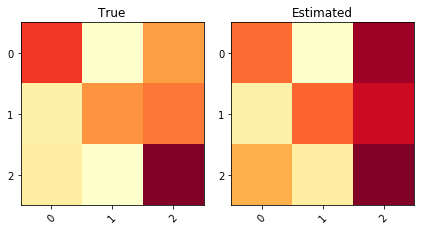

KL divergence: 0.1477	Pearson Correlation between diagonals: 0.9100


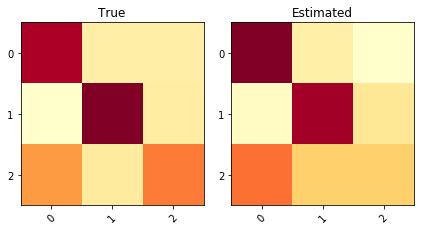

KL divergence: 0.0876	Pearson Correlation between diagonals: 0.9600


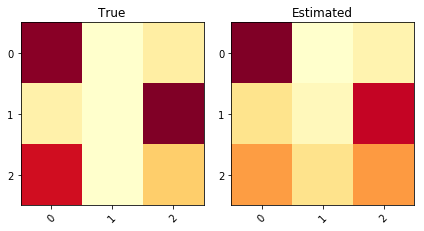

KL divergence: 0.1971	Pearson Correlation between diagonals: 0.9882


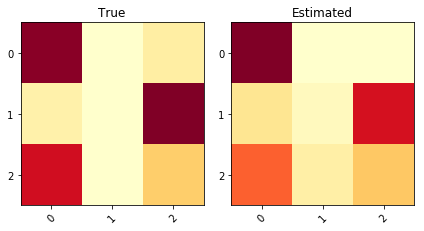

KL divergence: 0.1480	Pearson Correlation between diagonals: 0.9999


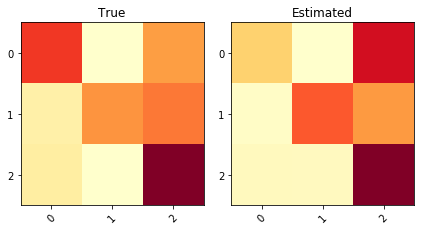

KL divergence: 0.1825	Pearson Correlation between diagonals: 0.6475
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.844933      0.844933   0.142337  0.0423729            0.865889        0.191244
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.664699                0.779589
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.849817 

In [46]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


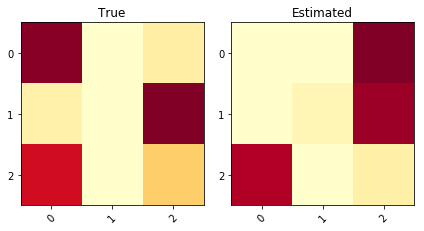

KL divergence: 1.6154	Pearson Correlation between diagonals: -0.7842


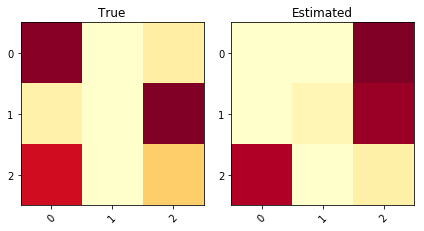

KL divergence: 1.6139	Pearson Correlation between diagonals: -0.7606


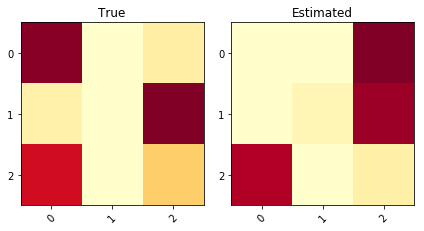

KL divergence: 1.6144	Pearson Correlation between diagonals: -0.7690


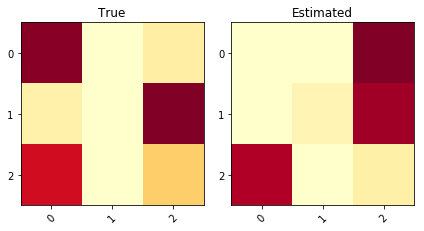

KL divergence: 1.6183	Pearson Correlation between diagonals: -0.8242


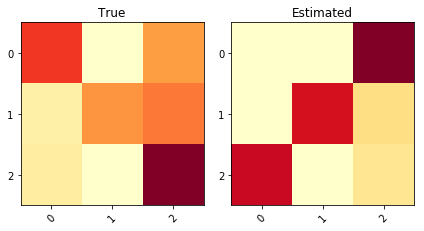

KL divergence: 1.5787	Pearson Correlation between diagonals: -0.6632


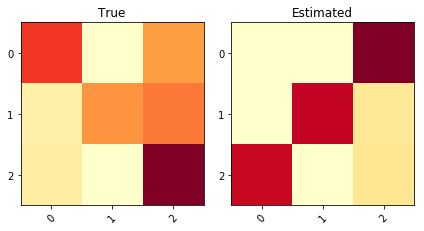

KL divergence: 1.6217	Pearson Correlation between diagonals: -0.6712


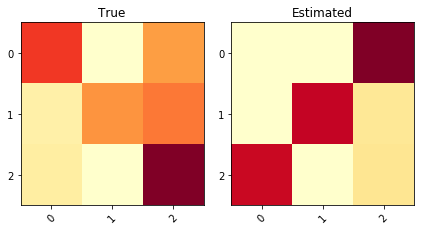

KL divergence: 1.6170	Pearson Correlation between diagonals: -0.6711


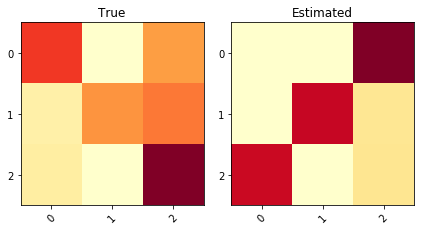

KL divergence: 1.6128	Pearson Correlation between diagonals: -0.6679


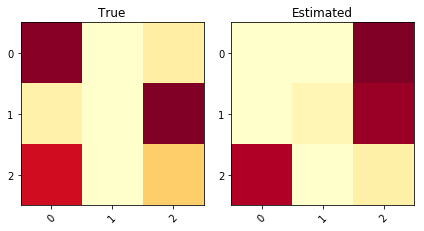

KL divergence: 1.6141	Pearson Correlation between diagonals: -0.7641


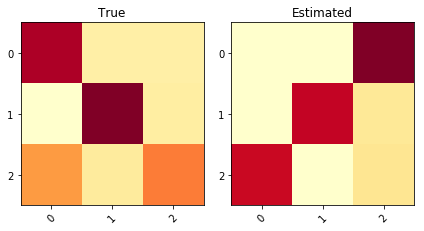

KL divergence: 1.7664	Pearson Correlation between diagonals: 0.5091


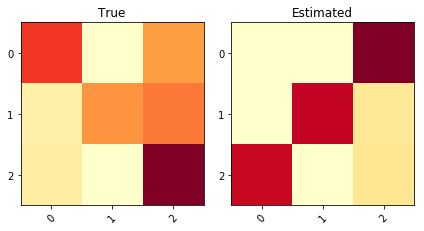

KL divergence: 1.6221	Pearson Correlation between diagonals: -0.6708


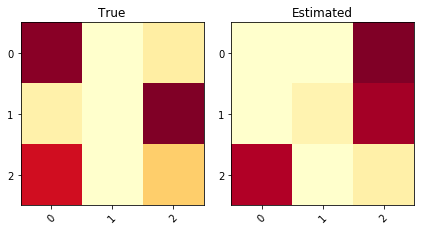

KL divergence: 1.6222	Pearson Correlation between diagonals: -0.8711


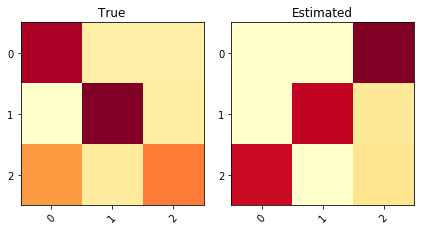

KL divergence: 1.7769	Pearson Correlation between diagonals: 0.5066


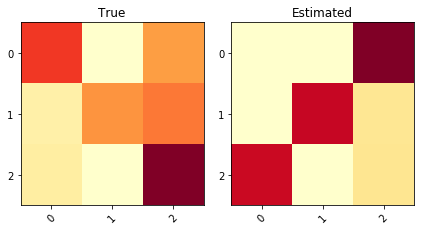

KL divergence: 1.6139	Pearson Correlation between diagonals: -0.6680


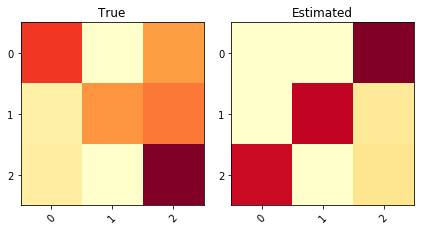

KL divergence: 1.6323	Pearson Correlation between diagonals: -0.6684
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.590151      0.590151     1.6541   0.208095             -0.4274        0.207612
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.650031                0.712605
====  =======================  ======================
Test


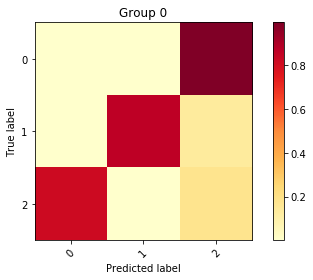

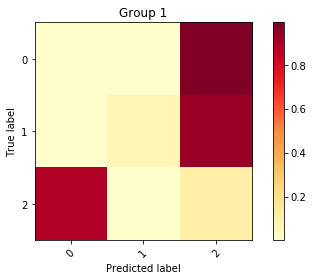

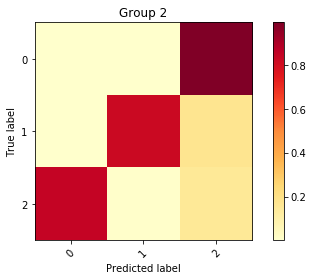

Inertia: 0.08025133436118874
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ===========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)      Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ===========  ==========  ============
   0         0  0.418226     836   0.310541    0.347827     2.63233       0.433638   0.0144936     0.778999      0.778999
   1         1  0.29645      592   0.21926     0.0575475    3.43965       0.148335  -0.275786      0.582418      0.582418
   2         2  0.285324     570   0.323744    0.326803     2.58821       0.415255  -0.00653005    0.691087      0.691087
====  ========  ========  ======  =========  ===========  =========  =============  ===========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  =====

In [47]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


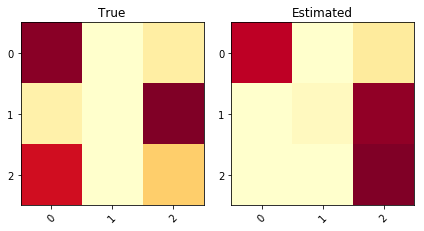

KL divergence: 1.3676	Pearson Correlation between diagonals: 0.6320


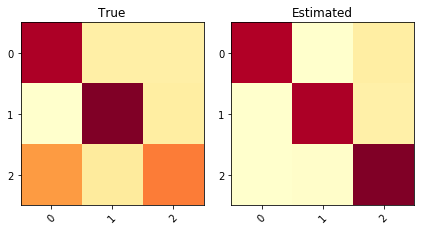

KL divergence: 0.8154	Pearson Correlation between diagonals: -0.9639


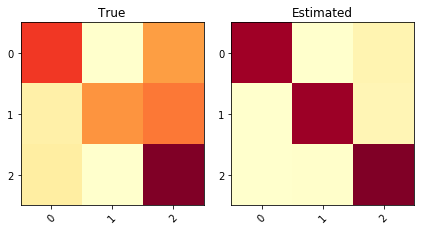

KL divergence: 0.5790	Pearson Correlation between diagonals: 0.8689


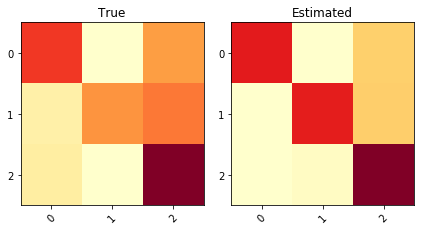

KL divergence: 0.2375	Pearson Correlation between diagonals: 0.9320


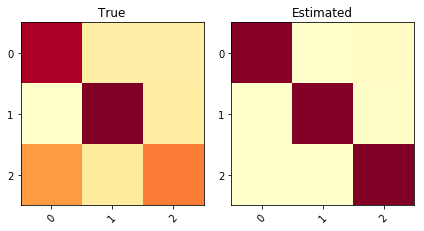

KL divergence: 0.9742	Pearson Correlation between diagonals: -0.8043


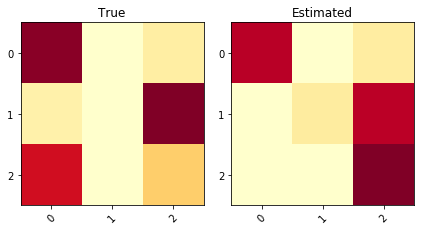

KL divergence: 1.4065	Pearson Correlation between diagonals: 0.6303


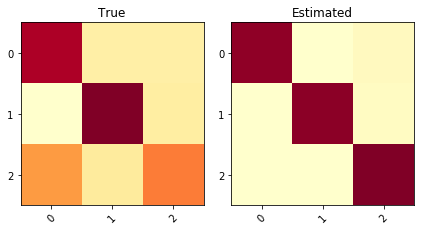

KL divergence: 0.9224	Pearson Correlation between diagonals: -0.8978


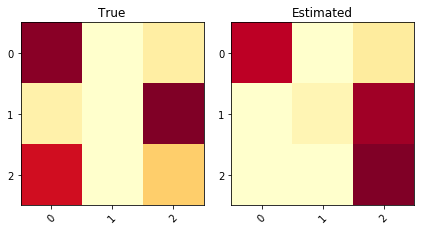

KL divergence: 1.3811	Pearson Correlation between diagonals: 0.6315


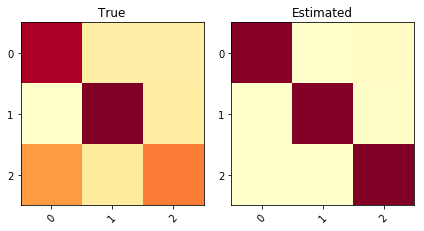

KL divergence: 0.9761	Pearson Correlation between diagonals: -0.7994


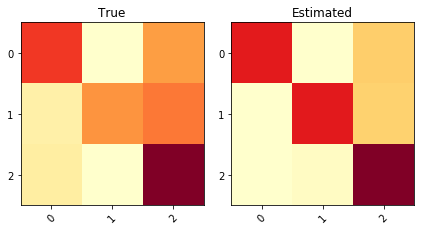

KL divergence: 0.2415	Pearson Correlation between diagonals: 0.9129


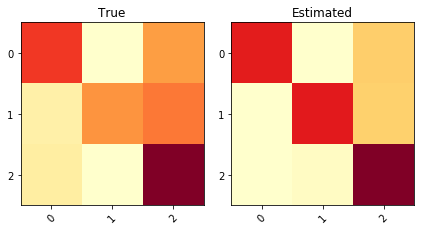

KL divergence: 0.2408	Pearson Correlation between diagonals: 0.9129


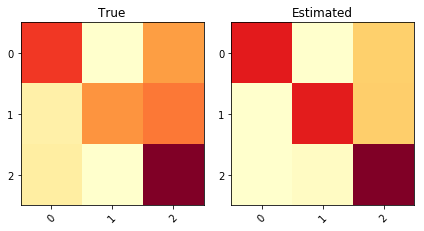

KL divergence: 0.2385	Pearson Correlation between diagonals: 0.9300


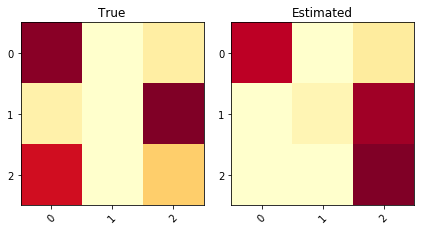

KL divergence: 1.3808	Pearson Correlation between diagonals: 0.6314


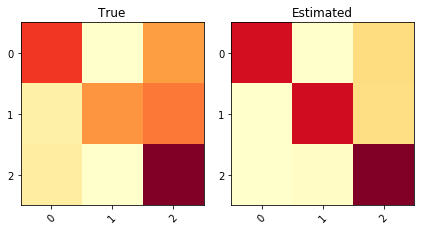

KL divergence: 0.2937	Pearson Correlation between diagonals: 0.9089


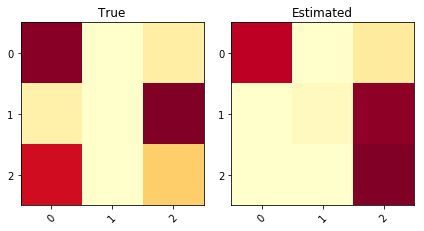

KL divergence: 1.3671	Pearson Correlation between diagonals: 0.6323
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.707367      0.707367   0.884005  0.0927332            0.357758        0.189364
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.672436                0.691652
====  =======================  ======================
Test


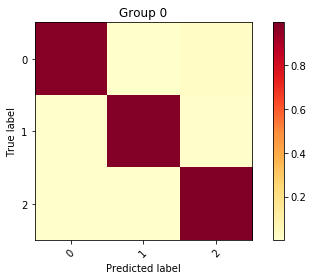

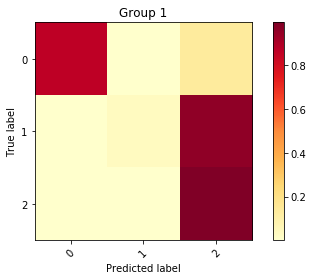

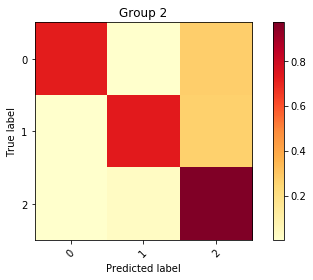

Inertia: 0.12115698804457982
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.400611     801  0.0703142     0.986921  0.0131917       0.993421   0.653588    0.737485      0.737485
   1         1  0.3475       695  0.200584      0.6322    1.16958         0.679036   0.298866    0.614164      0.614164
   2         2  0.251888     503  0.444244      0.808608  0.221968        0.893873   0.475275    0.652015      0.652015
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [48]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


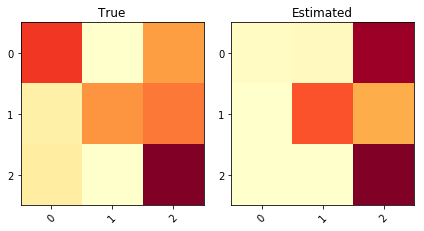

KL divergence: 0.6604	Pearson Correlation between diagonals: 0.5076


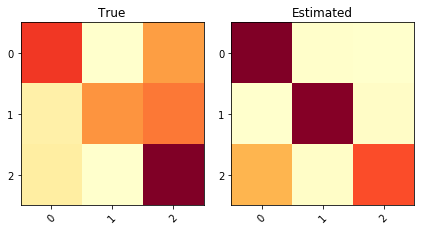

KL divergence: 1.1471	Pearson Correlation between diagonals: -0.9112


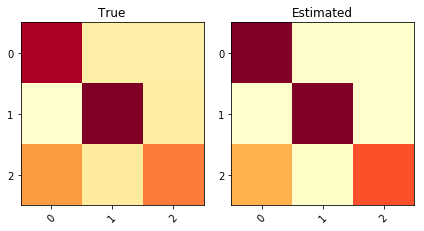

KL divergence: 0.2783	Pearson Correlation between diagonals: 0.9826


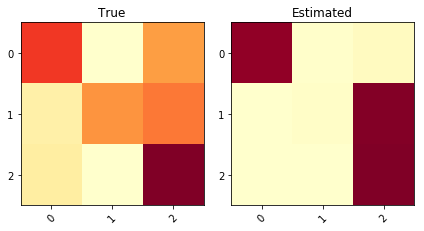

KL divergence: 0.8206	Pearson Correlation between diagonals: 0.8153


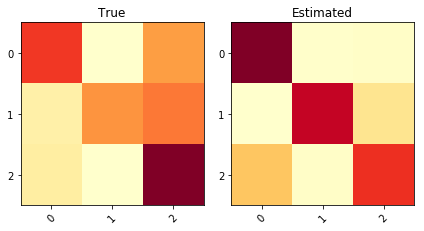

KL divergence: 0.5677	Pearson Correlation between diagonals: -0.6020


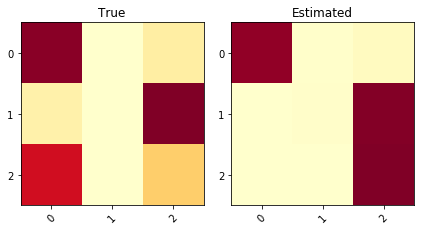

KL divergence: 1.4628	Pearson Correlation between diagonals: 0.6995


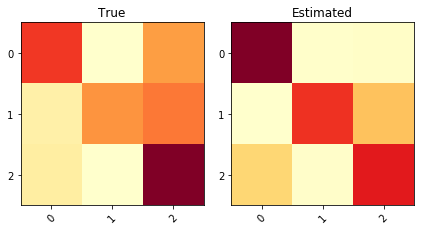

KL divergence: 0.4975	Pearson Correlation between diagonals: 0.0569


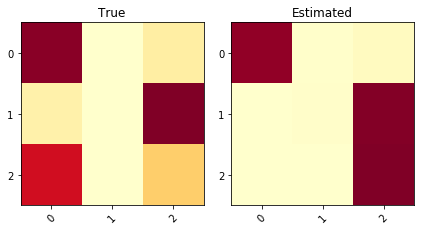

KL divergence: 1.4388	Pearson Correlation between diagonals: 0.6996


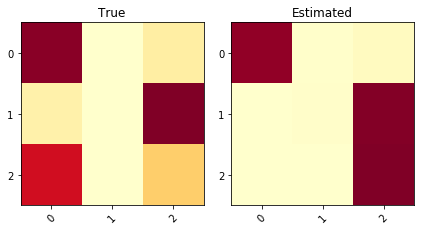

KL divergence: 1.4628	Pearson Correlation between diagonals: 0.6995


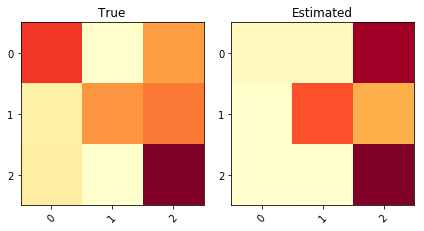

KL divergence: 0.5950	Pearson Correlation between diagonals: 0.5078


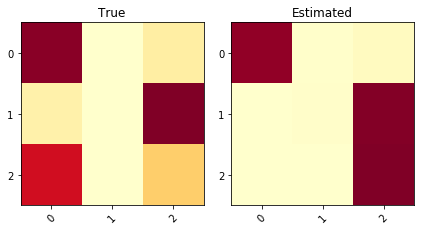

KL divergence: 1.4615	Pearson Correlation between diagonals: 0.6995


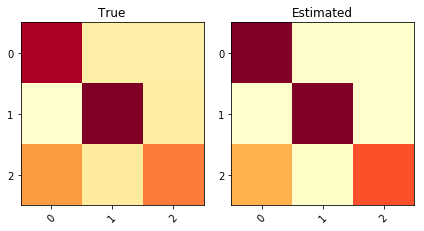

KL divergence: 0.2783	Pearson Correlation between diagonals: 0.9826


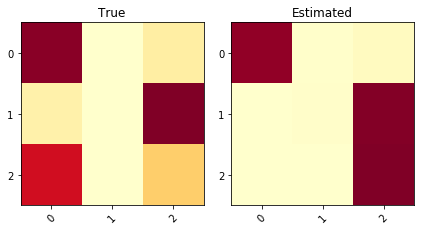

KL divergence: 1.4628	Pearson Correlation between diagonals: 0.6995


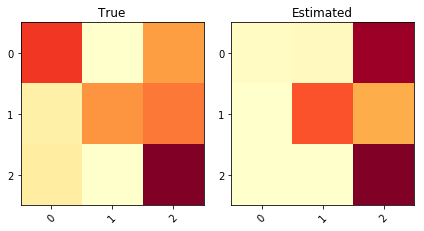

KL divergence: 0.6585	Pearson Correlation between diagonals: 0.5075


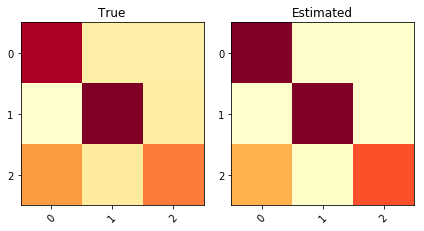

KL divergence: 0.2783	Pearson Correlation between diagonals: 0.9826
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.732601      0.732601   0.890005  0.0984732            0.628074        0.156993
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.671769                0.739202
====  =======================  ======================
Test


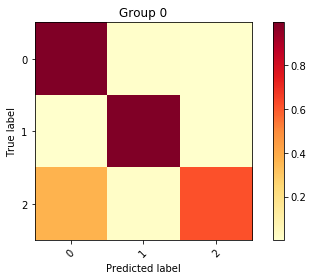

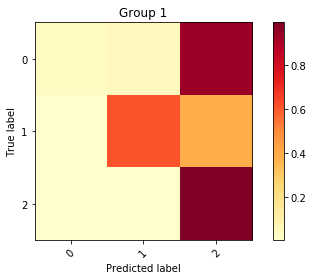

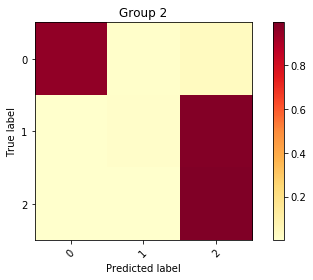

Inertia: 0.2770704651872317
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.359814     719  0.277033      0.867155   0.166234       0.922537   0.800733    0.65812       0.65812
   1         1  0.179363     358  0.342803      0.544894   1.32796        0.622455   0.317341    0.34188       0.34188
   2         2  0.460823     921  0.0941137     0.656086   1.49679        0.674693   0.48413     0.600733      0.600733
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ==========

In [23]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


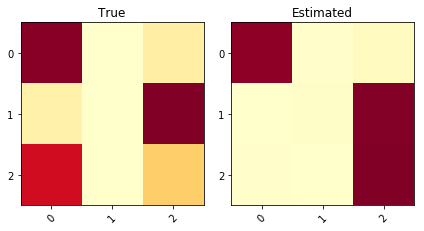

KL divergence: 1.2144	Pearson Correlation between diagonals: 0.7013


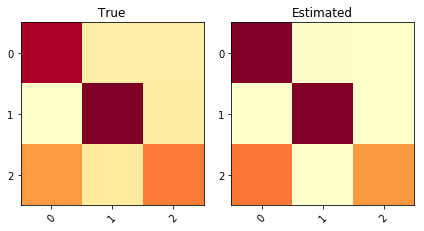

KL divergence: 0.3845	Pearson Correlation between diagonals: 0.9823


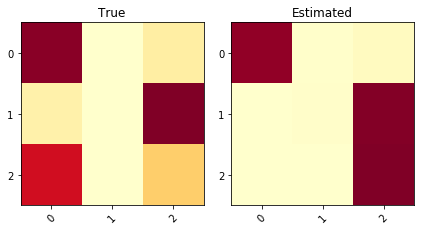

KL divergence: 1.3890	Pearson Correlation between diagonals: 0.6995


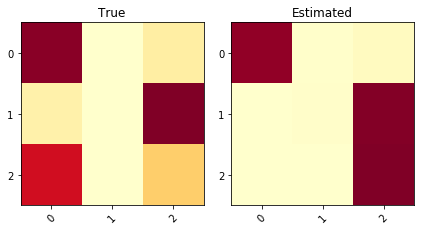

KL divergence: 1.3891	Pearson Correlation between diagonals: 0.6995


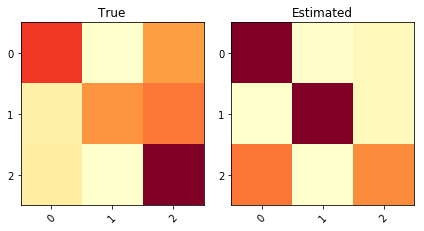

KL divergence: 0.7108	Pearson Correlation between diagonals: -0.9268


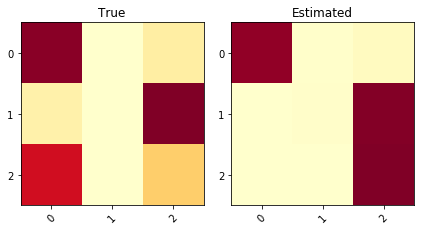

KL divergence: 1.3891	Pearson Correlation between diagonals: 0.6995


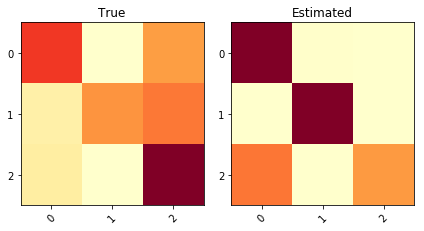

KL divergence: 1.5098	Pearson Correlation between diagonals: -0.9246


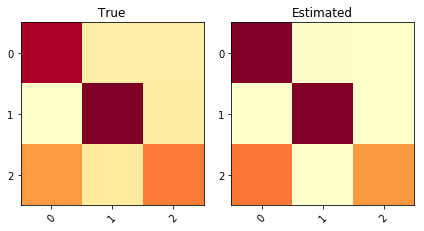

KL divergence: 0.3845	Pearson Correlation between diagonals: 0.9823


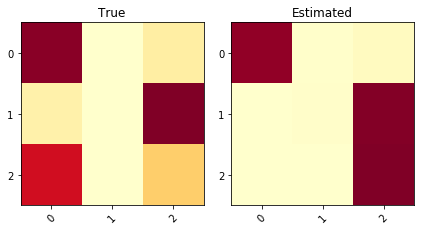

KL divergence: 1.3891	Pearson Correlation between diagonals: 0.6995


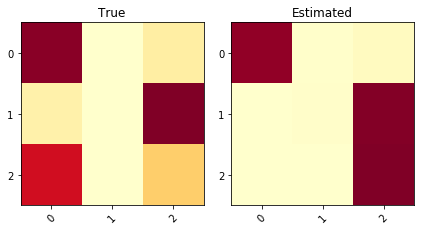

KL divergence: 1.3891	Pearson Correlation between diagonals: 0.6995


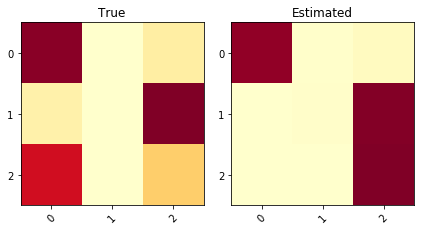

KL divergence: 1.3891	Pearson Correlation between diagonals: 0.6995


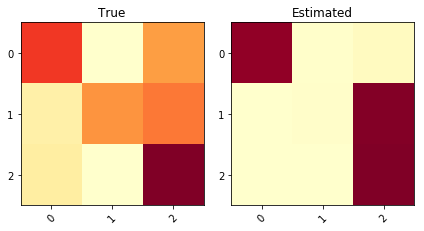

KL divergence: 0.8510	Pearson Correlation between diagonals: 0.8154


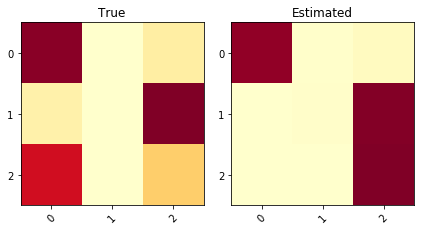

KL divergence: 1.3891	Pearson Correlation between diagonals: 0.6995


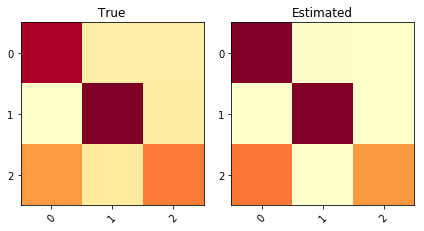

KL divergence: 0.3845	Pearson Correlation between diagonals: 0.9823


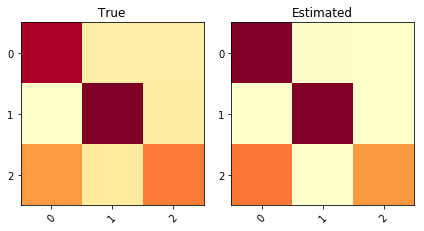

KL divergence: 0.3830	Pearson Correlation between diagonals: 0.9823
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.712658      0.712658   0.916634   0.103931            0.732009        0.165266
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.679502                0.784004
====  =======================  ======================
Test


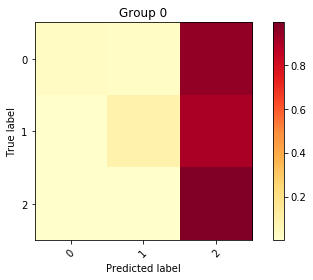

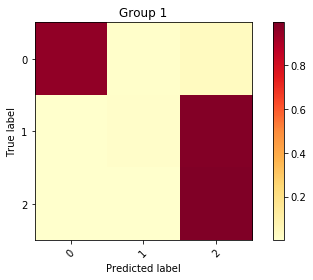

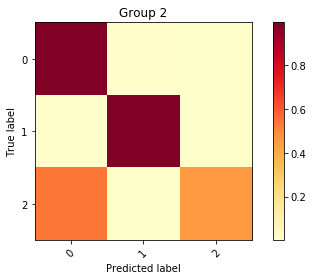

Inertia: 0.31346268951892853
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.180731     361  0.198219      0.370277   1.99037        0.438052  0.0554152    0.333333      0.333333
   1         1  0.430772     861  0.0939254     0.655429   1.52847        0.673397  0.483143     0.619048      0.619048
   2         2  0.388497     776  0.261701      0.813662   0.267509       0.88158   0.720493     0.660562      0.660562
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [28]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

## Variation $M$ = #Groups
---

In [12]:
from code.evaluation import Evaluation_metrics
import pickle

logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #KL
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

for M_seted in range(1,15+1):
    for _ in range(20):
        gMixture3 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
        gMixture3.define_model("mlp",8,1,BatchN=False,drop=0.2)
        gMixture3.lambda_random = True #with lambda random --necessary
        logL_hists,i_r = gMixture3.multiples_run(1,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                       ,cluster=True) #or without multiples runs???
        
    #gMixture3 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    #gMixture3.define_model("mlp",8,1,BatchN=False,drop=0.2)
    #gMixture3.lambda_random = True #with lambda random --necessary
    #logL_hists,i_r = gMixture3.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
    #                                   ,cluster=True) #or without multiples runs???
        print("Model with %d trained"%(M_seted))
        logL_Mchange.append(logL_hists[i_r])
        probas_Mchange.append(gMixture3.get_alpha())

        #measure metrics..
        evaluate = Evaluation_metrics(gMixture3,'our1',plot=False) 
        aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
        Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
        results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

        accTR_Mchange.append(results1[0]["Accuracy"][0])
        divergence1_Mchange.append(results1[0]["Mean KL"][0])
        divergence2_Mchange.append(results1[0]["Mean JS"][0])
        probGt_Mchange.append(prob_Gt)

        c_M = gMixture3.get_confusionM()
        y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
        Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
        results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

        best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
        accTE_Mchange.append(results2[1]["Accuracy"][0])
        inertia_Mchange.append(evaluate.inertia)

        del gMixture3
        gc.collect()
# cada 10 obtener promedio
T_models = 15
R = 20
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]

Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.003714 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3464223]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.77 sec)	logL: -27436.934	
Iter 2/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -26082.114	Tol1: 0.04938	Tol2: 0.28527	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -25332.448	Tol1: 0.02874	Tol2: 0.13377	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24813.718	Tol1: 0.02048	Tol2: 0.09357	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24369.597	Tol1: 0.01790	Tol2: 0.07976	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23963.664	Tol1: 0.01666	Tol2: 0.08348	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -235

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002471 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7337808]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.72 sec)	logL: -27468.787	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26322.885	Tol1: 0.04172	Tol2: 0.24841	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25941.482	Tol1: 0.01449	Tol2: 0.07471	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25680.549	Tol1: 0.01006	Tol2: 0.04885	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25467.533	Tol1: 0.00829	Tol2: 0.02956	Tol3: 0.00000	
Finished training!
Model with 1 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.003910 mins
Initializing new EM...
Pre-train ne

M step: done,  E step: done //  (in 0.09 sec)	logL: -20569.553	Tol1: 0.00542	Tol2: 0.05754	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20483.276	Tol1: 0.00419	Tol2: 0.04772	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20410.252	Tol1: 0.00357	Tol2: 0.04124	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20354.414	Tol1: 0.00274	Tol2: 0.03243	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20313.305	Tol1: 0.00202	Tol2: 0.02418	Tol3: 0.00000	
Finished training!
Model with 1 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002177 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.59234256]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 1.14 sec)	logL: -26556.405	
Iter 2/50
M step: done,  E step

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9711865]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 1.18 sec)	logL: -25782.824	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -25212.451	Tol1: 0.02212	Tol2: 0.11907	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24747.192	Tol1: 0.01845	Tol2: 0.10004	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24275.670	Tol1: 0.01905	Tol2: 0.10813	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23803.423	Tol1: 0.01945	Tol2: 0.11864	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23332.398	Tol1: 0.01979	Tol2: 0.12603	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22884.388	Tol1: 0.01920	Tol2: 0.13004	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22469.233	Tol1: 0

M step: done,  E step: done //  (in 0.11 sec)	logL: -26726.239	Tol1: 0.04332	Tol2: 0.23348	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -26039.698	Tol1: 0.02569	Tol2: 0.15564	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -25577.079	Tol1: 0.01777	Tol2: 0.12028	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25251.333	Tol1: 0.01274	Tol2: 0.09365	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -25002.040	Tol1: 0.00987	Tol2: 0.07299	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24797.347	Tol1: 0.00819	Tol2: 0.05682	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24610.110	Tol1: 0.00755	Tol2: 0.05147	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24409.667	Tol1: 0.00814	Tol2: 0.05597	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24180.183	Tol1: 0.

M step: done,  E step: done //  (in 0.09 sec)	logL: -20378.605	Tol1: 0.00242	Tol2: 0.03875	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20341.572	Tol1: 0.00182	Tol2: 0.03725	Tol3: 0.00000	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20308.399	Tol1: 0.00163	Tol2: 0.03530	Tol3: 0.00000	
Iter 24/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20277.582	Tol1: 0.00152	Tol2: 0.03699	Tol3: 0.00000	
Iter 25/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20252.496	Tol1: 0.00124	Tol2: 0.03169	Tol3: 0.00000	
Iter 26/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20228.069	Tol1: 0.00121	Tol2: 0.02945	Tol3: 0.00000	
Finished training!
Model with 1 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002623 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5750297]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457

M step: done,  E step: done //  (in 0.10 sec)	logL: -20802.209	Tol1: 0.00246	Tol2: 0.05406	Tol3: 0.00000	
Iter 26/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20757.782	Tol1: 0.00214	Tol2: 0.05423	Tol3: 0.00000	
Iter 27/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20715.977	Tol1: 0.00201	Tol2: 0.05389	Tol3: 0.00000	
Iter 28/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20681.606	Tol1: 0.00166	Tol2: 0.05282	Tol3: 0.00000	
Iter 29/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20646.902	Tol1: 0.00168	Tol2: 0.04809	Tol3: 0.00000	
Iter 30/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20609.845	Tol1: 0.00179	Tol2: 0.04764	Tol3: 0.00000	
Iter 31/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20572.012	Tol1: 0.00184	Tol2: 0.04636	Tol3: 0.00000	
Iter 32/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20540.039	Tol1: 0.00155	Tol2: 0.04071	Tol3: 0.00000	
Iter 33/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20509.893	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -20554.853	Tol1: 0.00141	Tol2: 0.07133	Tol3: 0.00000	
Iter 33/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20524.756	Tol1: 0.00146	Tol2: 0.06717	Tol3: 0.00000	
Iter 34/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20493.148	Tol1: 0.00154	Tol2: 0.06196	Tol3: 0.00000	
Iter 35/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20458.752	Tol1: 0.00168	Tol2: 0.05812	Tol3: 0.00000	
Iter 36/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20425.909	Tol1: 0.00161	Tol2: 0.05463	Tol3: 0.00000	
Iter 37/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20391.936	Tol1: 0.00166	Tol2: 0.05075	Tol3: 0.00000	
Iter 38/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20356.546	Tol1: 0.00174	Tol2: 0.04800	Tol3: 0.00000	
Iter 39/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20323.609	Tol1: 0.00162	Tol2: 0.04500	Tol3: 0.00000	
Iter 40/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20292.362	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -21960.276	Tol1: 0.01160	Tol2: 0.08997	Tol3: 0.00000	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21714.709	Tol1: 0.01118	Tol2: 0.08588	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21476.227	Tol1: 0.01098	Tol2: 0.08084	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21260.073	Tol1: 0.01006	Tol2: 0.07551	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21073.629	Tol1: 0.00877	Tol2: 0.06805	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20916.835	Tol1: 0.00744	Tol2: 0.06163	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20785.873	Tol1: 0.00626	Tol2: 0.05334	Tol3: 0.00000	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20674.619	Tol1: 0.00535	Tol2: 0.04819	Tol3: 0.00000	
Iter 24/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20589.348	T

M step: done,  E step: done //  (in 0.11 sec)	logL: -21230.188	Tol1: 0.00551	Tol2: 0.06360	Tol3: 0.00073	
Iter 22/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21133.169	Tol1: 0.00457	Tol2: 0.05583	Tol3: 0.00177	
Iter 23/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21046.848	Tol1: 0.00408	Tol2: 0.04761	Tol3: 0.00074	
Iter 24/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20972.959	Tol1: 0.00351	Tol2: 0.04017	Tol3: 0.00054	
Iter 25/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20908.763	Tol1: 0.00306	Tol2: 0.03373	Tol3: 0.00156	
Iter 26/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20853.039	Tol1: 0.00267	Tol2: 0.03585	Tol3: 0.00295	
Iter 27/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20803.452	Tol1: 0.00238	Tol2: 0.03770	Tol3: 0.00269	
Iter 28/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20754.214	Tol1: 0.00237	Tol2: 0.03858	Tol3: 0.00183	
Iter 29/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20714.103	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -24335.892	Tol1: 0.00818	Tol2: 0.08742	Tol3: 0.00637	
Iter 15/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24124.887	Tol1: 0.00867	Tol2: 0.09263	Tol3: 0.00347	
Iter 16/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23890.808	Tol1: 0.00970	Tol2: 0.09556	Tol3: 0.00067	
Iter 17/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23638.886	Tol1: 0.01054	Tol2: 0.09832	Tol3: 0.00172	
Iter 18/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23365.485	Tol1: 0.01157	Tol2: 0.09983	Tol3: 0.00404	
Iter 19/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23079.412	Tol1: 0.01224	Tol2: 0.09904	Tol3: 0.00624	
Iter 20/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22787.429	Tol1: 0.01265	Tol2: 0.09582	Tol3: 0.00823	
Iter 21/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22502.099	Tol1: 0.01252	Tol2: 0.09010	Tol3: 0.00987	
Iter 22/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22233.207	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -20696.718	Tol1: 0.00246	Tol2: 0.03001	Tol3: 0.00336	
Iter 31/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20647.294	Tol1: 0.00239	Tol2: 0.02775	Tol3: 0.00315	
Finished training!
Model with 2 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002437 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.92418253 0.6926179 ]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 2.69 sec)	logL: -25450.520	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -25090.275	Tol1: 0.01415	Tol2: 0.21477	Tol3: 0.03698	
Iter 3/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24833.210	Tol1: 0.01025	Tol2: 0.08992	Tol3: 0.00524	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24544.285	Tol1: 0.01163	Tol2: 0.07906	Tol3: 0.00562	
Iter 5/50
M step: done,

M step: done,  E step: done //  (in 0.10 sec)	logL: -20148.680	Tol1: 0.00055	Tol2: 0.04136	Tol3: 0.00917	
Iter 32/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20137.483	Tol1: 0.00056	Tol2: 0.04075	Tol3: 0.00922	
Iter 33/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20130.217	Tol1: 0.00036	Tol2: 0.03894	Tol3: 0.00852	
Iter 34/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20118.920	Tol1: 0.00056	Tol2: 0.03722	Tol3: 0.00739	
Iter 35/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20116.575	Tol1: 0.00012	Tol2: 0.03758	Tol3: 0.00794	
Iter 36/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20111.299	Tol1: 0.00026	Tol2: 0.03516	Tol3: 0.00647	
Iter 37/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20103.368	Tol1: 0.00039	Tol2: 0.03287	Tol3: 0.00522	
Iter 38/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20100.698	Tol1: 0.00013	Tol2: 0.03215	Tol3: 0.00648	
Iter 39/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20094.455	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -20217.658	Tol1: 0.00184	Tol2: 0.03089	Tol3: 0.00199	
Iter 33/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20185.756	Tol1: 0.00158	Tol2: 0.02892	Tol3: 0.00049	
Finished training!
Model with 2 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002376 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.01456367 0.37213928]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 3.34 sec)	logL: -33325.976	
Iter 2/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -30254.607	Tol1: 0.09216	Tol2: 1.65534	Tol3: 0.03529	
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -27263.986	Tol1: 0.09885	Tol2: 0.82041	Tol3: 0.05831	
Iter 4/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -25541.846	Tol1: 0.06317	Tol2: 0.34815	Tol3: 0.05707	
Iter 5/50
M step: done,

M step: done,  E step: done //  (in 0.12 sec)	logL: -20421.085	Tol1: 0.00412	Tol2: 0.03578	Tol3: 0.01335	
Iter 29/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20348.297	Tol1: 0.00356	Tol2: 0.03367	Tol3: 0.01361	
Iter 30/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20291.128	Tol1: 0.00281	Tol2: 0.03116	Tol3: 0.01219	
Iter 31/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20241.563	Tol1: 0.00244	Tol2: 0.02863	Tol3: 0.01169	
Finished training!
Model with 2 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002246 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8088791  0.46086714]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 3.80 sec)	logL: -24469.371	
Iter 2/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23057.248	Tol1: 0.05771	Tol2: 0.45871	Tol3: 0.03221	
Iter 3/50
M step: don

M step: done,  E step: done //  (in 0.11 sec)	logL: -20702.213	Tol1: 0.00401	Tol2: 0.03408	Tol3: 0.01721	
Iter 22/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20621.556	Tol1: 0.00390	Tol2: 0.03253	Tol3: 0.01670	
Iter 23/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20560.399	Tol1: 0.00297	Tol2: 0.03274	Tol3: 0.01611	
Iter 24/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20508.652	Tol1: 0.00252	Tol2: 0.03050	Tol3: 0.01388	
Iter 25/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20461.342	Tol1: 0.00231	Tol2: 0.02889	Tol3: 0.01250	
Finished training!
Model with 2 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002331 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6177778 0.908519 ]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 3.87 sec)	logL: -27814.336	
Iter 2/50
M step: done

M step: done,  E step: done //  (in 0.17 sec)	logL: -27737.425	Tol1: 0.08299	Tol2: 0.85775	Tol3: 0.13114	
Iter 3/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -26776.077	Tol1: 0.03466	Tol2: 0.30912	Tol3: 0.04161	
Iter 4/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -26220.580	Tol1: 0.02075	Tol2: 0.16511	Tol3: 0.00237	
Iter 5/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -25829.487	Tol1: 0.01492	Tol2: 0.11300	Tol3: 0.01054	
Iter 6/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -25538.612	Tol1: 0.01126	Tol2: 0.08594	Tol3: 0.00888	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -25299.435	Tol1: 0.00937	Tol2: 0.07018	Tol3: 0.00526	
Iter 8/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -25090.767	Tol1: 0.00825	Tol2: 0.06689	Tol3: 0.00167	
Iter 9/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24890.075	Tol1: 0.00800	Tol2: 0.06661	Tol3: 0.00059	
Iter 10/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24688.857	Tol1: 0.

M step: done,  E step: done //  (in 0.11 sec)	logL: -20351.931	Tol1: 0.00149	Tol2: 0.03286	Tol3: 0.00084	
Iter 41/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20326.316	Tol1: 0.00126	Tol2: 0.02960	Tol3: 0.00007	
Finished training!
Model with 2 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002798 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.84768194 0.39084035]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 5.42 sec)	logL: -25416.034	
Iter 2/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24641.657	Tol1: 0.03047	Tol2: 0.39828	Tol3: 0.04028	
Iter 3/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24389.380	Tol1: 0.01024	Tol2: 0.15496	Tol3: 0.01584	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24155.603	Tol1: 0.00959	Tol2: 0.10824	Tol3: 0.00704	
Iter 5/50
M step: done,

M step: done,  E step: done //  (in 0.12 sec)	logL: -20223.076	Tol1: 0.00067	Tol2: 0.03035	Tol3: 0.00536	
Iter 35/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20208.917	Tol1: 0.00070	Tol2: 0.02923	Tol3: 0.00501	
Finished training!
Model with 3 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002720 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9355391  0.22808732 0.10060956]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 4.52 sec)	logL: -26756.384	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -25760.298	Tol1: 0.03723	Tol2: 0.51450	Tol3: 0.12486	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -25333.065	Tol1: 0.01658	Tol2: 0.27213	Tol3: 0.03588	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24988.065	Tol1: 0.01362	Tol2: 0.20948	Tol3: 0.02649	
Iter 5/50
M 

M step: done,  E step: done //  (in 0.11 sec)	logL: -23503.237	Tol1: 0.01938	Tol2: 0.18384	Tol3: 0.03678	
Iter 4/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23063.687	Tol1: 0.01870	Tol2: 0.15048	Tol3: 0.02499	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22650.721	Tol1: 0.01791	Tol2: 0.13911	Tol3: 0.02495	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22292.403	Tol1: 0.01582	Tol2: 0.13508	Tol3: 0.02599	
Iter 7/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21958.272	Tol1: 0.01499	Tol2: 0.12871	Tol3: 0.02608	
Iter 8/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21685.689	Tol1: 0.01241	Tol2: 0.12177	Tol3: 0.02644	
Iter 9/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21447.222	Tol1: 0.01100	Tol2: 0.11034	Tol3: 0.02569	
Iter 10/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21246.350	Tol1: 0.00937	Tol2: 0.09760	Tol3: 0.02520	
Iter 11/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21074.250	Tol1: 0

M step: done,  E step: done //  (in 0.11 sec)	logL: -20082.323	Tol1: 0.00038	Tol2: 0.03736	Tol3: 0.00207	
Iter 38/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20069.101	Tol1: 0.00066	Tol2: 0.03475	Tol3: 0.00263	
Iter 39/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20066.953	Tol1: 0.00011	Tol2: 0.03371	Tol3: 0.00124	
Iter 40/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20060.376	Tol1: 0.00033	Tol2: 0.03046	Tol3: 0.00264	
Iter 41/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20055.302	Tol1: 0.00025	Tol2: 0.02802	Tol3: 0.00228	
Finished training!
Model with 3 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002560 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.02237039 0.5498704  0.19441296]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 5.09 sec)	logL: -26870.099	
Iter 2/50

M step: done,  E step: done //  (in 0.12 sec)	logL: -21622.239	Tol1: 0.00307	Tol2: 0.04156	Tol3: 0.00860	
Iter 21/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21551.652	Tol1: 0.00326	Tol2: 0.04190	Tol3: 0.00831	
Iter 22/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21482.537	Tol1: 0.00321	Tol2: 0.04199	Tol3: 0.00797	
Iter 23/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21411.589	Tol1: 0.00330	Tol2: 0.04275	Tol3: 0.00848	
Iter 24/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21336.123	Tol1: 0.00352	Tol2: 0.04151	Tol3: 0.00809	
Iter 25/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21259.505	Tol1: 0.00359	Tol2: 0.04121	Tol3: 0.00835	
Iter 26/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21176.014	Tol1: 0.00393	Tol2: 0.04060	Tol3: 0.00846	
Iter 27/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21095.791	Tol1: 0.00379	Tol2: 0.03936	Tol3: 0.00843	
Iter 28/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21016.554	T

M step: done,  E step: done //  (in 0.13 sec)	logL: -22645.537	Tol1: 0.01345	Tol2: 0.10020	Tol3: 0.01151	
Iter 11/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22356.381	Tol1: 0.01277	Tol2: 0.09971	Tol3: 0.00850	
Iter 12/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22094.767	Tol1: 0.01170	Tol2: 0.09809	Tol3: 0.00563	
Iter 13/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21865.252	Tol1: 0.01039	Tol2: 0.09564	Tol3: 0.00314	
Iter 14/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21667.903	Tol1: 0.00903	Tol2: 0.09189	Tol3: 0.00239	
Iter 15/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21497.023	Tol1: 0.00789	Tol2: 0.08659	Tol3: 0.00315	
Iter 16/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21354.997	Tol1: 0.00661	Tol2: 0.08016	Tol3: 0.00425	
Iter 17/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21234.850	Tol1: 0.00563	Tol2: 0.07331	Tol3: 0.00497	
Iter 18/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21138.552	T

M step: done,  E step: done //  (in 0.12 sec)	logL: -20519.369	Tol1: 0.00280	Tol2: 0.04809	Tol3: 0.01094	
Iter 17/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20474.737	Tol1: 0.00218	Tol2: 0.04599	Tol3: 0.01076	
Iter 18/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20435.178	Tol1: 0.00193	Tol2: 0.04485	Tol3: 0.00891	
Iter 19/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20394.067	Tol1: 0.00201	Tol2: 0.04355	Tol3: 0.00821	
Iter 20/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20360.932	Tol1: 0.00162	Tol2: 0.04339	Tol3: 0.00777	
Iter 21/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20329.673	Tol1: 0.00154	Tol2: 0.04212	Tol3: 0.00679	
Iter 22/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20303.919	Tol1: 0.00127	Tol2: 0.04257	Tol3: 0.00544	
Iter 23/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20279.981	Tol1: 0.00118	Tol2: 0.04305	Tol3: 0.00594	
Iter 24/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20254.475	T

M step: done,  E step: done //  (in 0.12 sec)	logL: -22009.744	Tol1: 0.00324	Tol2: 0.03120	Tol3: 0.00890	
Iter 17/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21949.202	Tol1: 0.00275	Tol2: 0.02784	Tol3: 0.00820	
Finished training!
Model with 3 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002603 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.49652964 0.32355633 0.05359341]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 5.19 sec)	logL: -28430.189	
Iter 2/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -26986.553	Tol1: 0.05078	Tol2: 0.59592	Tol3: 0.16340	
Iter 3/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -26212.850	Tol1: 0.02867	Tol2: 0.26125	Tol3: 0.04795	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -25624.316	Tol1: 0.02245	Tol2: 0.16645	Tol3: 0.02708	
Iter 5/50
M 

M step: done,  E step: done //  (in 0.13 sec)	logL: -20666.382	Tol1: 0.00415	Tol2: 0.04412	Tol3: 0.01554	
Iter 22/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20586.373	Tol1: 0.00387	Tol2: 0.04470	Tol3: 0.01501	
Iter 23/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20517.928	Tol1: 0.00332	Tol2: 0.04597	Tol3: 0.01391	
Iter 24/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20451.501	Tol1: 0.00324	Tol2: 0.04593	Tol3: 0.01274	
Iter 25/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20404.181	Tol1: 0.00231	Tol2: 0.04534	Tol3: 0.01159	
Iter 26/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20359.874	Tol1: 0.00217	Tol2: 0.04405	Tol3: 0.00912	
Iter 27/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20324.295	Tol1: 0.00175	Tol2: 0.04265	Tol3: 0.00884	
Iter 28/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20289.162	Tol1: 0.00173	Tol2: 0.04096	Tol3: 0.00837	
Iter 29/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20259.855	T

M step: done,  E step: done //  (in 6.13 sec)	logL: -26434.884	
Iter 2/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -25591.074	Tol1: 0.03192	Tol2: 0.43820	Tol3: 0.09795	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -25327.917	Tol1: 0.01028	Tol2: 0.18781	Tol3: 0.01467	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -25110.585	Tol1: 0.00858	Tol2: 0.13527	Tol3: 0.01719	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24894.882	Tol1: 0.00859	Tol2: 0.12155	Tol3: 0.01866	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24682.170	Tol1: 0.00854	Tol2: 0.11488	Tol3: 0.01907	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24477.352	Tol1: 0.00830	Tol2: 0.11109	Tol3: 0.01901	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24277.493	Tol1: 0.00817	Tol2: 0.10850	Tol3: 0.01860	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24091.976	Tol1: 0.00764	Tol2: 0.10604	Tol3: 0.01759	
Iter 10/

M step: done,  E step: done //  (in 0.14 sec)	logL: -25093.250	Tol1: 0.01880	Tol2: 0.22156	Tol3: 0.03532	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24706.963	Tol1: 0.01539	Tol2: 0.15729	Tol3: 0.02326	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24347.614	Tol1: 0.01454	Tol2: 0.12460	Tol3: 0.01875	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24003.034	Tol1: 0.01415	Tol2: 0.10873	Tol3: 0.01630	
Iter 7/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23662.924	Tol1: 0.01417	Tol2: 0.10303	Tol3: 0.01457	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23316.061	Tol1: 0.01466	Tol2: 0.10060	Tol3: 0.01282	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22983.736	Tol1: 0.01425	Tol2: 0.10204	Tol3: 0.01087	
Iter 10/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22669.981	Tol1: 0.01365	Tol2: 0.10360	Tol3: 0.00872	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22396.452	Tol1: 0

M step: done,  E step: done //  (in 0.12 sec)	logL: -20341.366	Tol1: 0.00112	Tol2: 0.03051	Tol3: 0.00812	
Iter 36/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20320.683	Tol1: 0.00102	Tol2: 0.02886	Tol3: 0.00784	
Finished training!
Model with 4 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002972 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7358508 0.9854758 0.744768  0.2533197]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 7.03 sec)	logL: -26822.581	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -25149.669	Tol1: 0.06237	Tol2: 0.52964	Tol3: 0.12016	
Iter 3/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24549.861	Tol1: 0.02385	Tol2: 0.22587	Tol3: 0.05092	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24170.837	Tol1: 0.01544	Tol2: 0.14138	Tol3: 0.02682	
Iter 

M step: done,  E step: done //  (in 0.14 sec)	logL: -24251.528	Tol1: 0.01216	Tol2: 0.11862	Tol3: 0.01829	
Iter 5/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23979.504	Tol1: 0.01122	Tol2: 0.09114	Tol3: 0.01634	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23718.971	Tol1: 0.01086	Tol2: 0.08192	Tol3: 0.01599	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23466.321	Tol1: 0.01065	Tol2: 0.08084	Tol3: 0.01626	
Iter 8/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23206.575	Tol1: 0.01107	Tol2: 0.08250	Tol3: 0.01664	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22944.515	Tol1: 0.01129	Tol2: 0.08427	Tol3: 0.01643	
Iter 10/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22673.071	Tol1: 0.01183	Tol2: 0.08571	Tol3: 0.01639	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22392.850	Tol1: 0.01236	Tol2: 0.08666	Tol3: 0.01650	
Iter 12/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22119.431	Tol1: 

M step: done,  E step: done //  (in 0.17 sec)	logL: -25932.999	Tol1: 0.05907	Tol2: 0.54262	Tol3: 0.09144	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25350.880	Tol1: 0.02245	Tol2: 0.22569	Tol3: 0.01976	
Iter 4/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -24952.775	Tol1: 0.01570	Tol2: 0.15593	Tol3: 0.00703	
Iter 5/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24604.811	Tol1: 0.01394	Tol2: 0.13159	Tol3: 0.01013	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24284.021	Tol1: 0.01304	Tol2: 0.11528	Tol3: 0.01042	
Iter 7/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23980.893	Tol1: 0.01248	Tol2: 0.10490	Tol3: 0.01051	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23691.653	Tol1: 0.01206	Tol2: 0.09842	Tol3: 0.01036	
Iter 9/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23402.133	Tol1: 0.01222	Tol2: 0.09380	Tol3: 0.01033	
Iter 10/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23117.286	Tol1: 0.

M step: done,  E step: done //  (in 0.14 sec)	logL: -22492.447	Tol1: 0.00969	Tol2: 0.06208	Tol3: 0.00360	
Iter 29/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22265.104	Tol1: 0.01011	Tol2: 0.06250	Tol3: 0.00311	
Iter 30/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22033.335	Tol1: 0.01041	Tol2: 0.06153	Tol3: 0.00326	
Iter 31/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21805.340	Tol1: 0.01035	Tol2: 0.05969	Tol3: 0.00351	
Iter 32/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21584.905	Tol1: 0.01011	Tol2: 0.05691	Tol3: 0.00319	
Iter 33/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21377.764	Tol1: 0.00960	Tol2: 0.05318	Tol3: 0.00344	
Iter 34/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21185.040	Tol1: 0.00902	Tol2: 0.04933	Tol3: 0.00268	
Iter 35/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21012.917	Tol1: 0.00812	Tol2: 0.04394	Tol3: 0.00244	
Iter 36/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20859.559	T

M step: done,  E step: done //  (in 0.13 sec)	logL: -20418.940	Tol1: 0.00111	Tol2: 0.02977	Tol3: 0.01309	
Finished training!
Model with 4 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002977 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.13889897 0.83808345 0.79087853 0.06944451]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 6.80 sec)	logL: -25693.398	
Iter 2/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24949.473	Tol1: 0.02895	Tol2: 0.42604	Tol3: 0.06449	
Iter 3/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24572.958	Tol1: 0.01509	Tol2: 0.19720	Tol3: 0.01780	
Iter 4/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24276.677	Tol1: 0.01206	Tol2: 0.14409	Tol3: 0.00954	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24009.226	Tol1: 0.01102	Tol2: 0.11841	Tol3: 0.00604	
It

M step: done,  E step: done //  (in 0.13 sec)	logL: -20474.366	Tol1: 0.00318	Tol2: 0.03857	Tol3: 0.01356	
Iter 26/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20416.543	Tol1: 0.00282	Tol2: 0.03961	Tol3: 0.01306	
Iter 27/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20363.738	Tol1: 0.00259	Tol2: 0.03716	Tol3: 0.01121	
Iter 28/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20319.281	Tol1: 0.00218	Tol2: 0.03355	Tol3: 0.00992	
Iter 29/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20284.188	Tol1: 0.00173	Tol2: 0.03346	Tol3: 0.00939	
Iter 30/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20252.699	Tol1: 0.00155	Tol2: 0.03021	Tol3: 0.00775	
Iter 31/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20223.765	Tol1: 0.00143	Tol2: 0.03071	Tol3: 0.00732	
Iter 32/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20203.541	Tol1: 0.00100	Tol2: 0.03083	Tol3: 0.00678	
Iter 33/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20186.635	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -20246.113	Tol1: 0.00089	Tol2: 0.03454	Tol3: 0.00453	
Iter 28/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20236.441	Tol1: 0.00048	Tol2: 0.03282	Tol3: 0.00435	
Iter 29/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20221.553	Tol1: 0.00074	Tol2: 0.03182	Tol3: 0.00418	
Iter 30/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20207.462	Tol1: 0.00070	Tol2: 0.02975	Tol3: 0.00403	
Finished training!
Model with 4 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002636 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.29844093 0.0639125  0.7202254  0.18732697]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 7.82 sec)	logL: -26313.988	
Iter 2/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24816.131	Tol1: 0.05692	Tol2: 0.54946	Tol3: 0.11151	

M step: done,  E step: done //  (in 0.15 sec)	logL: -25868.200	Tol1: 0.02592	Tol2: 0.21436	Tol3: 0.03421	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -25316.403	Tol1: 0.02133	Tol2: 0.14392	Tol3: 0.02239	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24814.889	Tol1: 0.01981	Tol2: 0.11564	Tol3: 0.01887	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24368.174	Tol1: 0.01800	Tol2: 0.10045	Tol3: 0.01628	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23955.896	Tol1: 0.01692	Tol2: 0.09688	Tol3: 0.01530	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23583.343	Tol1: 0.01555	Tol2: 0.10445	Tol3: 0.01514	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23247.206	Tol1: 0.01425	Tol2: 0.10867	Tol3: 0.01495	
Iter 10/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22945.928	Tol1: 0.01296	Tol2: 0.10845	Tol3: 0.01429	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22685.245	Tol1: 0

M step: done,  E step: done //  (in 0.13 sec)	logL: -20880.584	Tol1: 0.00546	Tol2: 0.04455	Tol3: 0.01335	
Iter 14/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20781.506	Tol1: 0.00475	Tol2: 0.04291	Tol3: 0.01175	
Iter 15/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20697.427	Tol1: 0.00405	Tol2: 0.04166	Tol3: 0.01041	
Iter 16/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20621.618	Tol1: 0.00366	Tol2: 0.04047	Tol3: 0.00972	
Iter 17/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20558.395	Tol1: 0.00307	Tol2: 0.03825	Tol3: 0.00964	
Iter 18/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20502.749	Tol1: 0.00271	Tol2: 0.03657	Tol3: 0.00804	
Iter 19/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20457.454	Tol1: 0.00221	Tol2: 0.03724	Tol3: 0.00693	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20417.772	Tol1: 0.00194	Tol2: 0.03766	Tol3: 0.00572	
Iter 21/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20379.066	T

M step: done,  E step: done //  (in 0.13 sec)	logL: -20246.834	Tol1: 0.00076	Tol2: 0.03021	Tol3: 0.00358	
Iter 32/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20233.773	Tol1: 0.00065	Tol2: 0.02885	Tol3: 0.00332	
Finished training!
Model with 4 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002481 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.536935   0.7496029  0.433038   0.85095763 0.8420918 ]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/50
M step: done,  E step: done //  (in 9.26 sec)	logL: -25259.710	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24488.714	Tol1: 0.03052	Tol2: 0.61790	Tol3: 0.15754	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24042.949	Tol1: 0.01820	Tol2: 0.26686	Tol3: 0.07363	
Iter 4/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23621.872	Tol1: 0.01751	Tol2: 0.17561	Tol3:

M step: done,  E step: done //  (in 9.93 sec)	logL: -24727.433	
Iter 2/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23859.450	Tol1: 0.03510	Tol2: 0.53842	Tol3: 0.15734	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23435.468	Tol1: 0.01777	Tol2: 0.22390	Tol3: 0.05788	
Iter 4/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -23045.524	Tol1: 0.01664	Tol2: 0.16840	Tol3: 0.04326	
Iter 5/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22685.396	Tol1: 0.01563	Tol2: 0.14992	Tol3: 0.04413	
Iter 6/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22355.238	Tol1: 0.01455	Tol2: 0.13774	Tol3: 0.04385	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22068.173	Tol1: 0.01284	Tol2: 0.12659	Tol3: 0.04175	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21815.778	Tol1: 0.01144	Tol2: 0.11446	Tol3: 0.03844	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21589.162	Tol1: 0.01039	Tol2: 0.10084	Tol3: 0.03439	
Iter 10/

M step: done,  E step: done //  (in 8.19 sec)	logL: -24185.511	
Iter 2/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23089.294	Tol1: 0.04533	Tol2: 0.66815	Tol3: 0.19298	
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22651.954	Tol1: 0.01894	Tol2: 0.29925	Tol3: 0.08428	
Iter 4/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -22350.653	Tol1: 0.01330	Tol2: 0.19561	Tol3: 0.04423	
Iter 5/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22112.141	Tol1: 0.01067	Tol2: 0.14201	Tol3: 0.02555	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21927.283	Tol1: 0.00836	Tol2: 0.10717	Tol3: 0.01568	
Iter 7/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21773.713	Tol1: 0.00700	Tol2: 0.08286	Tol3: 0.01015	
Iter 8/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21651.440	Tol1: 0.00562	Tol2: 0.06528	Tol3: 0.00753	
Iter 9/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21547.096	Tol1: 0.00482	Tol2: 0.05280	Tol3: 0.00643	
Iter 10/

M step: done,  E step: done //  (in 8.59 sec)	logL: -25774.703	
Iter 2/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24090.035	Tol1: 0.06536	Tol2: 0.86806	Tol3: 0.19113	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23552.927	Tol1: 0.02230	Tol2: 0.31207	Tol3: 0.09250	
Iter 4/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23221.089	Tol1: 0.01409	Tol2: 0.17284	Tol3: 0.05008	
Iter 5/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -22929.622	Tol1: 0.01255	Tol2: 0.11822	Tol3: 0.03675	
Iter 6/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22641.811	Tol1: 0.01255	Tol2: 0.09429	Tol3: 0.03339	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22365.305	Tol1: 0.01221	Tol2: 0.08058	Tol3: 0.03316	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22114.317	Tol1: 0.01122	Tol2: 0.07168	Tol3: 0.03310	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21880.027	Tol1: 0.01059	Tol2: 0.06566	Tol3: 0.03253	
Iter 10/

M step: done,  E step: done //  (in 0.14 sec)	logL: -21832.755	Tol1: 0.00721	Tol2: 0.06364	Tol3: 0.01282	
Iter 13/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21693.626	Tol1: 0.00637	Tol2: 0.05719	Tol3: 0.01358	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21563.917	Tol1: 0.00598	Tol2: 0.05089	Tol3: 0.01466	
Iter 15/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21442.028	Tol1: 0.00565	Tol2: 0.04749	Tol3: 0.01616	
Iter 16/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21331.870	Tol1: 0.00514	Tol2: 0.04632	Tol3: 0.01766	
Iter 17/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21229.538	Tol1: 0.00480	Tol2: 0.04486	Tol3: 0.01871	
Iter 18/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21125.791	Tol1: 0.00489	Tol2: 0.04592	Tol3: 0.02014	
Iter 19/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21030.307	Tol1: 0.00452	Tol2: 0.04521	Tol3: 0.02112	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20938.111	T

M step: done,  E step: done //  (in 0.17 sec)	logL: -20512.545	Tol1: 0.00215	Tol2: 0.03161	Tol3: 0.01266	
Iter 43/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20467.738	Tol1: 0.00218	Tol2: 0.03160	Tol3: 0.01236	
Iter 44/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20435.927	Tol1: 0.00155	Tol2: 0.03280	Tol3: 0.01111	
Iter 45/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20396.225	Tol1: 0.00194	Tol2: 0.02933	Tol3: 0.01107	
Finished training!
Model with 5 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.003282 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.16592403 0.8381448  0.92483765 0.4764062  0.03188652]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/50
M step: done,  E step: done //  (in 10.67 sec)	logL: -30420.052	
Iter 2/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -27494.296	Tol1: 0.09618	Tol2: 1.14307	To

M step: done,  E step: done //  (in 0.13 sec)	logL: -20069.418	Tol1: 0.00012	Tol2: 0.03179	Tol3: 0.01071	
Iter 37/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20066.955	Tol1: 0.00012	Tol2: 0.02985	Tol3: 0.01049	
Finished training!
Model with 5 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002536 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.02900517 0.36519104 0.7809003  0.5706742  0.5296439 ]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/50
M step: done,  E step: done //  (in 9.43 sec)	logL: -25265.017	
Iter 2/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24317.749	Tol1: 0.03749	Tol2: 0.57564	Tol3: 0.08447	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23811.124	Tol1: 0.02083	Tol2: 0.26732	Tol3: 0.06502	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23432.918	Tol1: 0.01588	Tol2: 0.18622	Tol3:

M step: done,  E step: done //  (in 0.14 sec)	logL: -20311.918	Tol1: 0.00271	Tol2: 0.05180	Tol3: 0.02122	
Iter 30/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20263.000	Tol1: 0.00241	Tol2: 0.04893	Tol3: 0.01993	
Iter 31/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20223.086	Tol1: 0.00197	Tol2: 0.04713	Tol3: 0.01848	
Iter 32/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20190.547	Tol1: 0.00161	Tol2: 0.04820	Tol3: 0.01690	
Iter 33/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20162.144	Tol1: 0.00141	Tol2: 0.04646	Tol3: 0.01567	
Iter 34/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20141.283	Tol1: 0.00103	Tol2: 0.04548	Tol3: 0.01396	
Iter 35/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20126.927	Tol1: 0.00071	Tol2: 0.04372	Tol3: 0.01286	
Iter 36/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20110.469	Tol1: 0.00082	Tol2: 0.04119	Tol3: 0.01155	
Iter 37/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20096.074	T

Clustering Done!
Get init alphas in 0.002340 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.40208244 0.00448073 0.4096876  0.22007416 0.62185836]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/50
M step: done,  E step: done //  (in 9.60 sec)	logL: -26463.611	
Iter 2/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25422.041	Tol1: 0.03936	Tol2: 0.57993	Tol3: 0.07198	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24900.222	Tol1: 0.02053	Tol2: 0.18554	Tol3: 0.01929	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24514.065	Tol1: 0.01551	Tol2: 0.11248	Tol3: 0.00594	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24181.070	Tol1: 0.01358	Tol2: 0.09147	Tol3: 0.00589	
Iter 6/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23869.570	Tol1: 0.01288	Tol2: 0.07792	Tol3: 0.00545	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23565.567	Tol1:

M step: done,  E step: done //  (in 0.14 sec)	logL: -22281.097	Tol1: 0.01346	Tol2: 0.10871	Tol3: 0.04380	
Iter 8/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22008.631	Tol1: 0.01223	Tol2: 0.09426	Tol3: 0.04017	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21764.722	Tol1: 0.01108	Tol2: 0.08192	Tol3: 0.03756	
Iter 10/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21543.870	Tol1: 0.01015	Tol2: 0.07133	Tol3: 0.03528	
Iter 11/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21356.963	Tol1: 0.00868	Tol2: 0.06330	Tol3: 0.03388	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21188.906	Tol1: 0.00787	Tol2: 0.05686	Tol3: 0.03275	
Iter 13/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21054.966	Tol1: 0.00632	Tol2: 0.05101	Tol3: 0.03140	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20933.842	Tol1: 0.00575	Tol2: 0.04526	Tol3: 0.03036	
Iter 15/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20832.821	Tol

M step: done,  E step: done //  (in 0.19 sec)	logL: -24329.501	Tol1: 0.00620	Tol2: 0.07135	Tol3: 0.00608	
Iter 12/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24174.530	Tol1: 0.00637	Tol2: 0.07474	Tol3: 0.00670	
Iter 13/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24010.410	Tol1: 0.00679	Tol2: 0.07807	Tol3: 0.00746	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23834.947	Tol1: 0.00731	Tol2: 0.08185	Tol3: 0.00864	
Iter 15/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23649.551	Tol1: 0.00778	Tol2: 0.08481	Tol3: 0.00973	
Iter 16/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23455.200	Tol1: 0.00822	Tol2: 0.08696	Tol3: 0.01043	
Iter 17/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23259.203	Tol1: 0.00836	Tol2: 0.08706	Tol3: 0.01110	
Iter 18/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23054.430	Tol1: 0.00880	Tol2: 0.08591	Tol3: 0.01108	
Iter 19/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22849.259	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -23907.607	Tol1: 0.01165	Tol2: 0.07652	Tol3: 0.01961	
Iter 11/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23608.696	Tol1: 0.01250	Tol2: 0.08265	Tol3: 0.02337	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23310.091	Tol1: 0.01265	Tol2: 0.08591	Tol3: 0.02557	
Iter 13/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23005.796	Tol1: 0.01305	Tol2: 0.08790	Tol3: 0.02708	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22703.132	Tol1: 0.01316	Tol2: 0.08813	Tol3: 0.02823	
Iter 15/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22419.955	Tol1: 0.01247	Tol2: 0.08586	Tol3: 0.02852	
Iter 16/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22161.205	Tol1: 0.01154	Tol2: 0.08275	Tol3: 0.02811	
Iter 17/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21931.441	Tol1: 0.01037	Tol2: 0.07803	Tol3: 0.02664	
Iter 18/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21724.561	T

M step: done,  E step: done //  (in 0.14 sec)	logL: -20709.703	Tol1: 0.00099	Tol2: 0.03380	Tol3: 0.00439	
Iter 40/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20686.086	Tol1: 0.00114	Tol2: 0.03108	Tol3: 0.00424	
Iter 41/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20661.593	Tol1: 0.00118	Tol2: 0.03033	Tol3: 0.00409	
Iter 42/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20639.396	Tol1: 0.00107	Tol2: 0.03046	Tol3: 0.00382	
Iter 43/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20611.418	Tol1: 0.00136	Tol2: 0.02813	Tol3: 0.00381	
Finished training!
Model with 6 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.003264 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.02948417 0.02768626 0.71654683 0.7530185  0.82748115 0.4971872 ]
Alphas:  (6,)
MV init:  (2457, 3)
Betas:  (6, 3, 3)
Q estimate:  (2457, 3, 6, 3)
Iter 1/50
M step: done,  E step: done //  (in 10.8

M step: done,  E step: done //  (in 0.14 sec)	logL: -20161.485	Tol1: 0.00043	Tol2: 0.02874	Tol3: 0.00302	
Finished training!
Model with 6 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.003143 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.58611363 0.08741159 0.25860187 0.57095826 0.13496432 0.174452  ]
Alphas:  (6,)
MV init:  (2457, 3)
Betas:  (6, 3, 3)
Q estimate:  (2457, 3, 6, 3)
Iter 1/50
M step: done,  E step: done //  (in 10.12 sec)	logL: -28210.220	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -25235.772	Tol1: 0.10544	Tol2: 0.77604	Tol3: 0.19222	
Iter 3/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24453.446	Tol1: 0.03100	Tol2: 0.26762	Tol3: 0.05003	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24003.124	Tol1: 0.01842	Tol2: 0.16942	Tol3: 0.03670	
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23651.320	Tol1: 0.01466	Tol2: 0.

M step: done,  E step: done //  (in 0.15 sec)	logL: -22301.613	Tol1: 0.00650	Tol2: 0.06738	Tol3: 0.01199	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22169.397	Tol1: 0.00593	Tol2: 0.06085	Tol3: 0.00961	
Iter 15/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22045.711	Tol1: 0.00558	Tol2: 0.05524	Tol3: 0.00867	
Iter 16/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21935.979	Tol1: 0.00498	Tol2: 0.05015	Tol3: 0.00854	
Iter 17/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21834.702	Tol1: 0.00462	Tol2: 0.04629	Tol3: 0.00804	
Iter 18/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21747.918	Tol1: 0.00397	Tol2: 0.04244	Tol3: 0.00755	
Iter 19/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21669.764	Tol1: 0.00359	Tol2: 0.03916	Tol3: 0.00685	
Iter 20/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21600.107	Tol1: 0.00321	Tol2: 0.03673	Tol3: 0.00632	
Iter 21/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21537.929	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -20203.383	Tol1: 0.00257	Tol2: 0.03501	Tol3: 0.00384	
Iter 31/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20157.783	Tol1: 0.00226	Tol2: 0.03304	Tol3: 0.00344	
Iter 32/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20121.445	Tol1: 0.00180	Tol2: 0.03172	Tol3: 0.00336	
Iter 33/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20091.055	Tol1: 0.00151	Tol2: 0.02994	Tol3: 0.00333	
Finished training!
Model with 6 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002995 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8236495  0.4611699  0.3851235  0.47904372 0.77681637 0.13047284]
Alphas:  (6,)
MV init:  (2457, 3)
Betas:  (6, 3, 3)
Q estimate:  (2457, 3, 6, 3)
Iter 1/50
M step: done,  E step: done //  (in 10.91 sec)	logL: -25900.052	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -25084.410	Tol1: 0.03149	Tol2:

M step: done,  E step: done //  (in 0.18 sec)	logL: -20798.072	Tol1: 0.00220	Tol2: 0.03405	Tol3: 0.01348	
Iter 21/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20760.456	Tol1: 0.00181	Tol2: 0.03584	Tol3: 0.01222	
Iter 22/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20729.067	Tol1: 0.00151	Tol2: 0.03668	Tol3: 0.01117	
Iter 23/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20699.841	Tol1: 0.00141	Tol2: 0.03668	Tol3: 0.01045	
Iter 24/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20675.198	Tol1: 0.00119	Tol2: 0.03626	Tol3: 0.00932	
Iter 25/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20652.958	Tol1: 0.00108	Tol2: 0.03571	Tol3: 0.00876	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20626.303	Tol1: 0.00129	Tol2: 0.03431	Tol3: 0.00823	
Iter 27/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20606.728	Tol1: 0.00095	Tol2: 0.03397	Tol3: 0.00761	
Iter 28/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20584.017	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -21707.128	Tol1: 0.00305	Tol2: 0.03065	Tol3: 0.00599	
Iter 23/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21645.580	Tol1: 0.00284	Tol2: 0.02763	Tol3: 0.00597	
Finished training!
Model with 6 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002980 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.794277   0.8117275  0.13689841 0.35461167 0.6362055  0.817861  ]
Alphas:  (6,)
MV init:  (2457, 3)
Betas:  (6, 3, 3)
Q estimate:  (2457, 3, 6, 3)
Iter 1/50
M step: done,  E step: done //  (in 10.89 sec)	logL: -26275.568	
Iter 2/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25293.931	Tol1: 0.03736	Tol2: 0.55757	Tol3: 0.10178	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24769.152	Tol1: 0.02075	Tol2: 0.29387	Tol3: 0.05310	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24378.295	Tol1: 0.01578	Tol2: 0

M step: done,  E step: done //  (in 0.21 sec)	logL: -21223.737	Tol1: 0.00075	Tol2: 0.03487	Tol3: 0.00284	
Iter 22/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21213.729	Tol1: 0.00047	Tol2: 0.03320	Tol3: 0.00236	
Iter 23/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21201.684	Tol1: 0.00057	Tol2: 0.03081	Tol3: 0.00203	
Iter 24/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21192.067	Tol1: 0.00045	Tol2: 0.03037	Tol3: 0.00202	
Iter 25/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21182.825	Tol1: 0.00044	Tol2: 0.02891	Tol3: 0.00207	
Finished training!
Model with 6 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002965 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.03084827 0.44419628 0.32298952 0.89642924 0.7215004  0.2847573 ]
Alphas:  (6,)
MV init:  (2457, 3)
Betas:  (6, 3, 3)
Q estimate:  (2457, 3, 6, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.2

M step: done,  E step: done //  (in 0.16 sec)	logL: -23327.634	Tol1: 0.01195	Tol2: 0.17834	Tol3: 0.02278	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23072.488	Tol1: 0.01094	Tol2: 0.15131	Tol3: 0.01730	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22846.879	Tol1: 0.00978	Tol2: 0.13238	Tol3: 0.01232	
Iter 8/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22645.756	Tol1: 0.00880	Tol2: 0.11733	Tol3: 0.00810	
Iter 9/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22455.799	Tol1: 0.00839	Tol2: 0.10574	Tol3: 0.00957	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22275.288	Tol1: 0.00804	Tol2: 0.09794	Tol3: 0.01071	
Iter 11/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22110.567	Tol1: 0.00739	Tol2: 0.09218	Tol3: 0.01173	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21952.747	Tol1: 0.00714	Tol2: 0.08624	Tol3: 0.01250	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21805.416	Tol1:

M step: done,  E step: done //  (in 0.20 sec)	logL: -24304.559	Tol1: 0.01217	Tol2: 0.11681	Tol3: 0.02293	
Iter 6/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -24001.808	Tol1: 0.01246	Tol2: 0.10358	Tol3: 0.02707	
Iter 7/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23692.857	Tol1: 0.01287	Tol2: 0.09893	Tol3: 0.03031	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23370.934	Tol1: 0.01359	Tol2: 0.09621	Tol3: 0.03266	
Iter 9/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23055.850	Tol1: 0.01348	Tol2: 0.09307	Tol3: 0.03410	
Iter 10/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -22744.687	Tol1: 0.01350	Tol2: 0.08846	Tol3: 0.03458	
Iter 11/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22459.085	Tol1: 0.01256	Tol2: 0.08315	Tol3: 0.03425	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22185.822	Tol1: 0.01217	Tol2: 0.07695	Tol3: 0.03366	
Iter 13/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21946.611	Tol1:

M step: done,  E step: done //  (in 0.16 sec)	logL: -21686.686	Tol1: 0.01213	Tol2: 0.06889	Tol3: 0.02579	
Iter 14/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21445.146	Tol1: 0.01114	Tol2: 0.06310	Tol3: 0.02521	
Iter 15/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21225.535	Tol1: 0.01024	Tol2: 0.05641	Tol3: 0.02424	
Iter 16/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21047.568	Tol1: 0.00838	Tol2: 0.05045	Tol3: 0.02330	
Iter 17/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20898.741	Tol1: 0.00707	Tol2: 0.04456	Tol3: 0.02211	
Iter 18/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20781.240	Tol1: 0.00562	Tol2: 0.04062	Tol3: 0.02115	
Iter 19/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20681.608	Tol1: 0.00479	Tol2: 0.03684	Tol3: 0.02018	
Iter 20/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20604.055	Tol1: 0.00375	Tol2: 0.03253	Tol3: 0.01912	
Iter 21/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20529.955	T

M step: done,  E step: done //  (in 0.17 sec)	logL: -22618.057	Tol1: 0.01587	Tol2: 0.15080	Tol3: 0.03713	
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22292.557	Tol1: 0.01439	Tol2: 0.12041	Tol3: 0.03372	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21986.836	Tol1: 0.01371	Tol2: 0.10399	Tol3: 0.03266	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21705.182	Tol1: 0.01281	Tol2: 0.09143	Tol3: 0.03124	
Iter 8/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21460.418	Tol1: 0.01128	Tol2: 0.08101	Tol3: 0.02920	
Iter 9/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21249.253	Tol1: 0.00984	Tol2: 0.07146	Tol3: 0.02704	
Iter 10/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21076.861	Tol1: 0.00811	Tol2: 0.06328	Tol3: 0.02436	
Iter 11/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20926.550	Tol1: 0.00713	Tol2: 0.05595	Tol3: 0.02181	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20814.453	Tol1: 

M step: done,  E step: done //  (in 0.17 sec)	logL: -20575.929	Tol1: 0.00301	Tol2: 0.03060	Tol3: 0.01568	
Iter 22/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20521.486	Tol1: 0.00265	Tol2: 0.02958	Tol3: 0.01515	
Finished training!
Model with 7 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.003882 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5157314  0.29384747 0.2628354  0.6954256  0.26213744 0.1244989
 0.71372396]
Alphas:  (7,)
MV init:  (2457, 3)
Betas:  (7, 3, 3)
Q estimate:  (2457, 3, 7, 3)
Iter 1/50
M step: done,  E step: done //  (in 12.51 sec)	logL: -25662.413	
Iter 2/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24477.305	Tol1: 0.04618	Tol2: 0.70453	Tol3: 0.18385	
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24140.285	Tol1: 0.01377	Tol2: 0.25544	Tol3: 0.06446	
Iter 4/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23890.257	Tol1: 0.01

M step: done,  E step: done //  (in 0.16 sec)	logL: -21036.127	Tol1: 0.00268	Tol2: 0.03688	Tol3: 0.01176	
Iter 31/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20975.732	Tol1: 0.00287	Tol2: 0.03732	Tol3: 0.01117	
Iter 32/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20911.002	Tol1: 0.00309	Tol2: 0.03713	Tol3: 0.01126	
Iter 33/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20838.298	Tol1: 0.00348	Tol2: 0.03768	Tol3: 0.01113	
Iter 34/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20764.048	Tol1: 0.00356	Tol2: 0.03921	Tol3: 0.01079	
Iter 35/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20689.951	Tol1: 0.00357	Tol2: 0.03977	Tol3: 0.01055	
Iter 36/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20615.876	Tol1: 0.00358	Tol2: 0.03995	Tol3: 0.00992	
Iter 37/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20545.441	Tol1: 0.00342	Tol2: 0.03963	Tol3: 0.00968	
Iter 38/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20477.506	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -21941.025	Tol1: 0.00740	Tol2: 0.06815	Tol3: 0.01092	
Iter 15/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21794.096	Tol1: 0.00670	Tol2: 0.06306	Tol3: 0.01024	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21656.121	Tol1: 0.00633	Tol2: 0.05851	Tol3: 0.01014	
Iter 17/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21527.239	Tol1: 0.00595	Tol2: 0.05528	Tol3: 0.00976	
Iter 18/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21406.241	Tol1: 0.00562	Tol2: 0.05121	Tol3: 0.00938	
Iter 19/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21300.604	Tol1: 0.00493	Tol2: 0.04789	Tol3: 0.00877	
Iter 20/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21201.769	Tol1: 0.00464	Tol2: 0.04507	Tol3: 0.00901	
Iter 21/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21112.044	Tol1: 0.00423	Tol2: 0.04198	Tol3: 0.00935	
Iter 22/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21031.394	T

M step: done,  E step: done //  (in 0.17 sec)	logL: -21080.107	Tol1: 0.00478	Tol2: 0.04520	Tol3: 0.01583	
Iter 24/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20975.459	Tol1: 0.00496	Tol2: 0.04530	Tol3: 0.01548	
Iter 25/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20873.137	Tol1: 0.00488	Tol2: 0.04381	Tol3: 0.01494	
Iter 26/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20765.301	Tol1: 0.00517	Tol2: 0.04372	Tol3: 0.01474	
Iter 27/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20660.459	Tol1: 0.00505	Tol2: 0.04392	Tol3: 0.01454	
Iter 28/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20559.048	Tol1: 0.00491	Tol2: 0.04315	Tol3: 0.01326	
Iter 29/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20470.454	Tol1: 0.00431	Tol2: 0.04251	Tol3: 0.01248	
Iter 30/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20387.200	Tol1: 0.00407	Tol2: 0.04066	Tol3: 0.01207	
Iter 31/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20312.585	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -20906.861	Tol1: 0.00660	Tol2: 0.05795	Tol3: 0.01152	
Iter 25/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20787.706	Tol1: 0.00570	Tol2: 0.05333	Tol3: 0.01098	
Iter 26/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20690.101	Tol1: 0.00470	Tol2: 0.04840	Tol3: 0.01017	
Iter 27/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20610.239	Tol1: 0.00386	Tol2: 0.04456	Tol3: 0.00947	
Iter 28/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20537.861	Tol1: 0.00351	Tol2: 0.04168	Tol3: 0.00882	
Iter 29/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20472.797	Tol1: 0.00317	Tol2: 0.04113	Tol3: 0.00826	
Iter 30/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20417.242	Tol1: 0.00271	Tol2: 0.03826	Tol3: 0.00794	
Iter 31/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20371.043	Tol1: 0.00226	Tol2: 0.03765	Tol3: 0.00773	
Iter 32/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20330.409	T

M step: done,  E step: done //  (in 0.20 sec)	logL: -20760.107	Tol1: 0.00159	Tol2: 0.03096	Tol3: 0.01190	
Iter 25/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20734.457	Tol1: 0.00124	Tol2: 0.02992	Tol3: 0.01125	
Finished training!
Model with 7 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.003493 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.48400018 0.72213393 0.73069274 0.67201304 0.16533999 0.8714692
 0.83434385]
Alphas:  (7,)
MV init:  (2457, 3)
Betas:  (7, 3, 3)
Q estimate:  (2457, 3, 7, 3)
Iter 1/50
M step: done,  E step: done //  (in 15.92 sec)	logL: -25893.018	
Iter 2/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -25153.076	Tol1: 0.02858	Tol2: 0.53352	Tol3: 0.10169	
Iter 3/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24743.834	Tol1: 0.01627	Tol2: 0.22064	Tol3: 0.02681	
Iter 4/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24355.647	Tol1: 0.01

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.49245894 0.9043691  0.05340937 0.04369152 0.7316454  0.49344388
 0.9191242  0.6319038 ]
Alphas:  (8,)
MV init:  (2457, 3)
Betas:  (8, 3, 3)
Q estimate:  (2457, 3, 8, 3)
Iter 1/50
M step: done,  E step: done //  (in 14.26 sec)	logL: -26327.004	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -25198.398	Tol1: 0.04287	Tol2: 0.57667	Tol3: 0.14425	
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24829.102	Tol1: 0.01466	Tol2: 0.22811	Tol3: 0.03778	
Iter 4/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24580.048	Tol1: 0.01003	Tol2: 0.15178	Tol3: 0.01422	
Iter 5/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24355.605	Tol1: 0.00913	Tol2: 0.12819	Tol3: 0.01794	
Iter 6/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24145.127	Tol1: 0.00864	Tol2: 0.11341	Tol3: 0.02055	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23945.169	Tol1: 0.00828	Tol2: 0.10252	Tol3: 0.02205	


M step: done,  E step: done //  (in 0.18 sec)	logL: -20903.282	Tol1: 0.00142	Tol2: 0.03974	Tol3: 0.00999	
Iter 24/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20879.509	Tol1: 0.00114	Tol2: 0.04066	Tol3: 0.00924	
Iter 25/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20855.864	Tol1: 0.00113	Tol2: 0.04077	Tol3: 0.00885	
Iter 26/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20838.304	Tol1: 0.00084	Tol2: 0.04023	Tol3: 0.00842	
Iter 27/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20820.572	Tol1: 0.00085	Tol2: 0.03772	Tol3: 0.00790	
Iter 28/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20802.094	Tol1: 0.00089	Tol2: 0.03586	Tol3: 0.00757	
Iter 29/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20786.492	Tol1: 0.00075	Tol2: 0.03357	Tol3: 0.00709	
Iter 30/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20766.355	Tol1: 0.00097	Tol2: 0.03159	Tol3: 0.00648	
Iter 31/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20745.803	T

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.43019885 0.9268034  0.7146428  0.3244096  0.9175599  0.26070508
 0.42743108 0.24025851]
Alphas:  (8,)
MV init:  (2457, 3)
Betas:  (8, 3, 3)
Q estimate:  (2457, 3, 8, 3)
Iter 1/50
M step: done,  E step: done //  (in 15.77 sec)	logL: -26083.530	
Iter 2/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -24763.955	Tol1: 0.05059	Tol2: 0.64597	Tol3: 0.20007	
Iter 3/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24332.164	Tol1: 0.01744	Tol2: 0.24474	Tol3: 0.05961	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23981.732	Tol1: 0.01440	Tol2: 0.16153	Tol3: 0.03468	
Iter 5/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23656.146	Tol1: 0.01358	Tol2: 0.12745	Tol3: 0.03039	
Iter 6/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23351.043	Tol1: 0.01290	Tol2: 0.11336	Tol3: 0.03031	
Iter 7/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23063.260	Tol1: 0.01232	Tol2: 0.10479	Tol3: 0.02982	


Pre-train network on 0 epochs... Done!
Lambda by group:  [0.07352474 0.31648186 0.64465374 0.15037492 0.49221078 0.21936911
 0.9601434  0.54724985]
Alphas:  (8,)
MV init:  (2457, 3)
Betas:  (8, 3, 3)
Q estimate:  (2457, 3, 8, 3)
Iter 1/50
M step: done,  E step: done //  (in 15.55 sec)	logL: -27494.890	
Iter 2/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -25972.372	Tol1: 0.05537	Tol2: 0.75623	Tol3: 0.18256	
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25658.797	Tol1: 0.01207	Tol2: 0.26800	Tol3: 0.04938	
Iter 4/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25495.765	Tol1: 0.00635	Tol2: 0.16547	Tol3: 0.02268	
Iter 5/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25358.657	Tol1: 0.00538	Tol2: 0.12779	Tol3: 0.01593	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25220.601	Tol1: 0.00544	Tol2: 0.11089	Tol3: 0.01302	
Iter 7/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -25071.718	Tol1: 0.00590	Tol2: 0.09988	Tol3: 0.01432	


M step: done,  E step: done //  (in 0.17 sec)	logL: -23821.966	Tol1: 0.00941	Tol2: 0.09600	Tol3: 0.02075	
Iter 7/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23601.493	Tol1: 0.00925	Tol2: 0.09084	Tol3: 0.02240	
Iter 8/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23378.399	Tol1: 0.00945	Tol2: 0.08750	Tol3: 0.02315	
Iter 9/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23164.541	Tol1: 0.00915	Tol2: 0.08446	Tol3: 0.02382	
Iter 10/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22960.925	Tol1: 0.00879	Tol2: 0.08081	Tol3: 0.02425	
Iter 11/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22764.938	Tol1: 0.00854	Tol2: 0.07667	Tol3: 0.02346	
Iter 12/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22579.706	Tol1: 0.00814	Tol2: 0.07126	Tol3: 0.02247	
Iter 13/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22397.987	Tol1: 0.00805	Tol2: 0.06531	Tol3: 0.02181	
Iter 14/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22224.191	Tol1

Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002870 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.22961381 0.8019704  0.09222253 0.36174315 0.22092809 0.47253346
 0.6910181  0.69092387]
Alphas:  (8,)
MV init:  (2457, 3)
Betas:  (8, 3, 3)
Q estimate:  (2457, 3, 8, 3)
Iter 1/50
M step: done,  E step: done //  (in 15.83 sec)	logL: -28942.655	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -27587.720	Tol1: 0.04681	Tol2: 0.73024	Tol3: 0.18042	
Iter 3/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -26790.103	Tol1: 0.02891	Tol2: 0.35348	Tol3: 0.08800	
Iter 4/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -26200.262	Tol1: 0.02202	Tol2: 0.24331	Tol3: 0.05651	
Iter 5/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -25769.183	Tol1: 0.01645	Tol2: 0.19043	Tol3: 0.03786	
Iter 6/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -25438.669	Tol1: 0.01283	Tol2: 0.15542	T

M step: done,  E step: done //  (in 0.17 sec)	logL: -21001.259	Tol1: 0.00102	Tol2: 0.03193	Tol3: 0.00294	
Iter 36/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20975.293	Tol1: 0.00124	Tol2: 0.02976	Tol3: 0.00311	
Finished training!
Model with 8 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002705 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.76502883 0.00954644 0.30002102 0.4547274  0.5808382  0.25079152
 0.2407848  0.80653095]
Alphas:  (8,)
MV init:  (2457, 3)
Betas:  (8, 3, 3)
Q estimate:  (2457, 3, 8, 3)
Iter 1/50
M step: done,  E step: done //  (in 16.03 sec)	logL: -26520.779	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -25214.780	Tol1: 0.04924	Tol2: 0.65962	Tol3: 0.10964	
Iter 3/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24753.061	Tol1: 0.01831	Tol2: 0.22342	Tol3: 0.02314	
Iter 4/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24387.82

Model with 8 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.003226 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.42739257 0.5476088  0.6432831  0.8346744  0.10385739 0.39197454
 0.69726676 0.4719339 ]
Alphas:  (8,)
MV init:  (2457, 3)
Betas:  (8, 3, 3)
Q estimate:  (2457, 3, 8, 3)
Iter 1/50
M step: done,  E step: done //  (in 16.25 sec)	logL: -26609.752	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24439.437	Tol1: 0.08156	Tol2: 0.83512	Tol3: 0.23338	
Iter 3/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23943.559	Tol1: 0.02029	Tol2: 0.28257	Tol3: 0.06608	
Iter 4/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -23634.347	Tol1: 0.01291	Tol2: 0.17160	Tol3: 0.03191	
Iter 5/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23369.758	Tol1: 0.01120	Tol2: 0.13338	Tol3: 0.02336	
Iter 6/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23128.176	Tol1: 0.

M step: done,  E step: done //  (in 0.19 sec)	logL: -22033.528	Tol1: 0.01216	Tol2: 0.10674	Tol3: 0.03099	
Iter 9/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21796.445	Tol1: 0.01076	Tol2: 0.09194	Tol3: 0.02871	
Iter 10/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21588.318	Tol1: 0.00955	Tol2: 0.07788	Tol3: 0.02664	
Iter 11/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21395.802	Tol1: 0.00892	Tol2: 0.06494	Tol3: 0.02531	
Iter 12/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21228.260	Tol1: 0.00783	Tol2: 0.05703	Tol3: 0.02426	
Iter 13/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21081.593	Tol1: 0.00691	Tol2: 0.05243	Tol3: 0.02307	
Iter 14/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20939.244	Tol1: 0.00675	Tol2: 0.05020	Tol3: 0.02248	
Iter 15/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20813.701	Tol1: 0.00600	Tol2: 0.04758	Tol3: 0.02199	
Iter 16/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20701.391	To

M step: done,  E step: done //  (in 0.21 sec)	logL: -24861.511	Tol1: 0.00422	Tol2: 0.06891	Tol3: 0.01044	
Iter 10/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24761.949	Tol1: 0.00400	Tol2: 0.06171	Tol3: 0.01080	
Iter 11/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24662.378	Tol1: 0.00402	Tol2: 0.05560	Tol3: 0.01102	
Iter 12/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24563.610	Tol1: 0.00400	Tol2: 0.05264	Tol3: 0.01144	
Iter 13/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24456.598	Tol1: 0.00436	Tol2: 0.05053	Tol3: 0.01182	
Iter 14/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24337.588	Tol1: 0.00487	Tol2: 0.05082	Tol3: 0.01273	
Iter 15/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24200.993	Tol1: 0.00561	Tol2: 0.05199	Tol3: 0.01372	
Iter 16/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24048.768	Tol1: 0.00629	Tol2: 0.05447	Tol3: 0.01482	
Iter 17/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23869.232	T

M step: done,  E step: done //  (in 0.20 sec)	logL: -21870.903	Tol1: 0.00607	Tol2: 0.04734	Tol3: 0.01747	
Iter 13/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21751.488	Tol1: 0.00546	Tol2: 0.04265	Tol3: 0.01620	
Iter 14/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21656.755	Tol1: 0.00436	Tol2: 0.03874	Tol3: 0.01525	
Iter 15/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21570.447	Tol1: 0.00399	Tol2: 0.03570	Tol3: 0.01444	
Iter 16/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21492.805	Tol1: 0.00360	Tol2: 0.03302	Tol3: 0.01390	
Iter 17/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21430.697	Tol1: 0.00289	Tol2: 0.03161	Tol3: 0.01336	
Iter 18/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21373.003	Tol1: 0.00269	Tol2: 0.02994	Tol3: 0.01296	
Finished training!
Model with 9 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002811 mins
Initializing new EM...
Pre-train network on 0

M step: done,  E step: done //  (in 0.19 sec)	logL: -25206.155	Tol1: 0.00808	Tol2: 0.10705	Tol3: 0.00685	
Iter 7/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24973.749	Tol1: 0.00922	Tol2: 0.09172	Tol3: 0.00475	
Iter 8/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24700.062	Tol1: 0.01096	Tol2: 0.08380	Tol3: 0.00491	
Iter 9/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24376.216	Tol1: 0.01311	Tol2: 0.08068	Tol3: 0.00718	
Iter 10/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24004.521	Tol1: 0.01525	Tol2: 0.08108	Tol3: 0.00986	
Iter 11/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23600.950	Tol1: 0.01681	Tol2: 0.08491	Tol3: 0.01262	
Iter 12/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23179.855	Tol1: 0.01784	Tol2: 0.08698	Tol3: 0.01467	
Iter 13/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22784.820	Tol1: 0.01704	Tol2: 0.08751	Tol3: 0.01567	
Iter 14/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22415.405	Tol1

M step: done,  E step: done //  (in 0.21 sec)	logL: -23653.486	Tol1: 0.00800	Tol2: 0.13366	Tol3: 0.03337	
Iter 7/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23476.082	Tol1: 0.00750	Tol2: 0.11834	Tol3: 0.03088	
Iter 8/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23299.087	Tol1: 0.00754	Tol2: 0.10586	Tol3: 0.02803	
Iter 9/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23132.608	Tol1: 0.00715	Tol2: 0.09546	Tol3: 0.02553	
Iter 10/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22969.490	Tol1: 0.00705	Tol2: 0.08528	Tol3: 0.02276	
Iter 11/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22816.369	Tol1: 0.00667	Tol2: 0.07566	Tol3: 0.02017	
Iter 12/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22670.687	Tol1: 0.00638	Tol2: 0.06621	Tol3: 0.01785	
Iter 13/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22531.953	Tol1: 0.00612	Tol2: 0.05773	Tol3: 0.01586	
Iter 14/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22407.995	Tol1

M step: done,  E step: done //  (in 0.24 sec)	logL: -21612.524	Tol1: 0.00828	Tol2: 0.06536	Tol3: 0.02890	
Iter 12/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21449.989	Tol1: 0.00752	Tol2: 0.05405	Tol3: 0.02776	
Iter 13/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21308.392	Tol1: 0.00660	Tol2: 0.04561	Tol3: 0.02706	
Iter 14/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21189.733	Tol1: 0.00557	Tol2: 0.03994	Tol3: 0.02634	
Iter 15/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21076.002	Tol1: 0.00537	Tol2: 0.03687	Tol3: 0.02559	
Iter 16/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20980.414	Tol1: 0.00454	Tol2: 0.03550	Tol3: 0.02491	
Iter 17/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20895.239	Tol1: 0.00406	Tol2: 0.03672	Tol3: 0.02429	
Iter 18/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20819.884	Tol1: 0.00361	Tol2: 0.03820	Tol3: 0.02341	
Iter 19/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20750.787	T

M step: done,  E step: done //  (in 0.21 sec)	logL: -20661.751	Tol1: 0.00213	Tol2: 0.04528	Tol3: 0.00788	
Iter 26/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20617.515	Tol1: 0.00214	Tol2: 0.04225	Tol3: 0.00793	
Iter 27/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20569.826	Tol1: 0.00231	Tol2: 0.04103	Tol3: 0.00770	
Iter 28/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20526.241	Tol1: 0.00212	Tol2: 0.03862	Tol3: 0.00776	
Iter 29/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20481.400	Tol1: 0.00218	Tol2: 0.03471	Tol3: 0.00815	
Iter 30/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20439.100	Tol1: 0.00207	Tol2: 0.03135	Tol3: 0.00859	
Iter 31/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -20399.459	Tol1: 0.00194	Tol2: 0.02927	Tol3: 0.00909	
Finished training!
Model with 9 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.003052 mins
Initializing new EM...
Pre-train network on 0

M step: done,  E step: done //  (in 0.19 sec)	logL: -22291.837	Tol1: 0.01405	Tol2: 0.09683	Tol3: 0.03685	
Iter 8/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21990.773	Tol1: 0.01351	Tol2: 0.08192	Tol3: 0.03551	
Iter 9/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21730.255	Tol1: 0.01185	Tol2: 0.07108	Tol3: 0.03431	
Iter 10/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21516.619	Tol1: 0.00983	Tol2: 0.06250	Tol3: 0.03284	
Iter 11/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21335.711	Tol1: 0.00841	Tol2: 0.05583	Tol3: 0.03093	
Iter 12/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21184.828	Tol1: 0.00707	Tol2: 0.04934	Tol3: 0.02846	
Iter 13/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21065.287	Tol1: 0.00564	Tol2: 0.04498	Tol3: 0.02632	
Iter 14/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20966.034	Tol1: 0.00471	Tol2: 0.04177	Tol3: 0.02413	
Iter 15/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20878.858	Tol

M step: done,  E step: done //  (in 0.20 sec)	logL: -23534.078	Tol1: 0.01006	Tol2: 0.08296	Tol3: 0.01041	
Iter 22/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23273.320	Tol1: 0.01108	Tol2: 0.08658	Tol3: 0.01134	
Iter 23/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22980.501	Tol1: 0.01258	Tol2: 0.08959	Tol3: 0.01245	
Iter 24/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22674.617	Tol1: 0.01331	Tol2: 0.09155	Tol3: 0.01362	
Iter 25/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22359.085	Tol1: 0.01392	Tol2: 0.09101	Tol3: 0.01443	
Iter 26/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22055.566	Tol1: 0.01357	Tol2: 0.08785	Tol3: 0.01480	
Iter 27/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -21784.676	Tol1: 0.01228	Tol2: 0.08120	Tol3: 0.01450	
Iter 28/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21544.437	Tol1: 0.01103	Tol2: 0.07364	Tol3: 0.01375	
Iter 29/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21340.819	T

M step: done,  E step: done //  (in 0.23 sec)	logL: -20530.203	Tol1: 0.00271	Tol2: 0.04408	Tol3: 0.00917	
Iter 25/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20481.909	Tol1: 0.00235	Tol2: 0.04326	Tol3: 0.00903	
Iter 26/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20439.038	Tol1: 0.00209	Tol2: 0.04056	Tol3: 0.00925	
Iter 27/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20396.678	Tol1: 0.00207	Tol2: 0.03796	Tol3: 0.00841	
Iter 28/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20359.401	Tol1: 0.00183	Tol2: 0.03683	Tol3: 0.00864	
Iter 29/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20320.370	Tol1: 0.00192	Tol2: 0.03403	Tol3: 0.00823	
Iter 30/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20293.959	Tol1: 0.00130	Tol2: 0.03350	Tol3: 0.00795	
Iter 31/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20265.131	Tol1: 0.00142	Tol2: 0.02860	Tol3: 0.00770	
Finished training!
Model with 9 trained
Needed params (units,deep,drop,Batc

M step: done,  E step: done //  (in 0.24 sec)	logL: -21344.410	Tol1: 0.00318	Tol2: 0.02975	Tol3: 0.00903	
Finished training!
Model with 10 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002822 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.49766156 0.5766685  0.848772   0.5412816  0.20173301 0.8776632
 0.21353196 0.61509776 0.5784159  0.10442466]
Alphas:  (10,)
MV init:  (2457, 3)
Betas:  (10, 3, 3)
Q estimate:  (2457, 3, 10, 3)
Iter 1/50
M step: done,  E step: done //  (in 19.45 sec)	logL: -24679.901	
Iter 2/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24220.786	Tol1: 0.01860	Tol2: 0.57258	Tol3: 0.12961	
Iter 3/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23974.241	Tol1: 0.01018	Tol2: 0.24056	Tol3: 0.03872	
Iter 4/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23720.959	Tol1: 0.01056	Tol2: 0.17530	Tol3: 0.03838	
Iter 5/50
M step: done,  E step: done //  (in 0

M step: done,  E step: done //  (in 0.34 sec)	logL: -23566.225	Tol1: 0.01599	Tol2: 0.20112	Tol3: 0.05459	
Iter 5/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23200.239	Tol1: 0.01553	Tol2: 0.15884	Tol3: 0.05097	
Iter 6/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -22857.071	Tol1: 0.01479	Tol2: 0.13343	Tol3: 0.04626	
Iter 7/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22541.833	Tol1: 0.01379	Tol2: 0.11346	Tol3: 0.04142	
Iter 8/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22261.973	Tol1: 0.01242	Tol2: 0.09680	Tol3: 0.03750	
Iter 9/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -22016.078	Tol1: 0.01105	Tol2: 0.08246	Tol3: 0.03417	
Iter 10/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21812.454	Tol1: 0.00925	Tol2: 0.07044	Tol3: 0.03110	
Iter 11/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21638.866	Tol1: 0.00796	Tol2: 0.06150	Tol3: 0.02780	
Iter 12/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21506.680	Tol1: 

M step: done,  E step: done //  (in 0.23 sec)	logL: -20295.628	Tol1: 0.00222	Tol2: 0.03080	Tol3: 0.00839	
Iter 40/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20252.174	Tol1: 0.00214	Tol2: 0.02786	Tol3: 0.00843	
Finished training!
Model with 10 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002827 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.88355535 0.11242673 0.12572406 0.4656351  0.67094344 0.36398867
 0.8783249  0.11158931 0.8865886  0.5831644 ]
Alphas:  (10,)
MV init:  (2457, 3)
Betas:  (10, 3, 3)
Q estimate:  (2457, 3, 10, 3)
Iter 1/50
M step: done,  E step: done //  (in 23.38 sec)	logL: -28734.623	
Iter 2/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -26452.217	Tol1: 0.07943	Tol2: 0.86354	Tol3: 0.26251	
Iter 3/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -25873.090	Tol1: 0.02189	Tol2: 0.28547	Tol3: 0.06509	
Iter 4/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 0.24 sec)	logL: -22936.596	Tol1: 0.01189	Tol2: 0.12095	Tol3: 0.03609	
Iter 8/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22673.807	Tol1: 0.01146	Tol2: 0.10541	Tol3: 0.03283	
Iter 9/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22430.217	Tol1: 0.01074	Tol2: 0.09170	Tol3: 0.02949	
Iter 10/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22221.994	Tol1: 0.00928	Tol2: 0.07946	Tol3: 0.02630	
Iter 11/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22036.502	Tol1: 0.00835	Tol2: 0.06699	Tol3: 0.02365	
Iter 12/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21876.029	Tol1: 0.00728	Tol2: 0.05627	Tol3: 0.02139	
Iter 13/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21745.988	Tol1: 0.00594	Tol2: 0.04770	Tol3: 0.01897	
Iter 14/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21638.234	Tol1: 0.00496	Tol2: 0.04213	Tol3: 0.01696	
Iter 15/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21546.920	Tol

M step: done,  E step: done //  (in 0.21 sec)	logL: -20116.533	Tol1: 0.00125	Tol2: 0.03642	Tol3: 0.00468	
Iter 36/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20095.623	Tol1: 0.00104	Tol2: 0.03311	Tol3: 0.00467	
Iter 37/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20075.061	Tol1: 0.00102	Tol2: 0.03068	Tol3: 0.00478	
Iter 38/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20060.707	Tol1: 0.00072	Tol2: 0.02925	Tol3: 0.00471	
Finished training!
Model with 10 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.003458 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.62937695 0.47751215 0.9934852  0.5604298  0.5478178  0.807331
 0.32121077 0.17004563 0.8635275  0.81536   ]
Alphas:  (10,)
MV init:  (2457, 3)
Betas:  (10, 3, 3)
Q estimate:  (2457, 3, 10, 3)
Iter 1/50
M step: done,  E step: done //  (in 20.70 sec)	logL: -27255.309	
Iter 2/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 0.28 sec)	logL: -24446.067	Tol1: 0.01338	Tol2: 0.16664	Tol3: 0.01945	
Iter 5/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -24145.492	Tol1: 0.01230	Tol2: 0.13809	Tol3: 0.01852	
Iter 6/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23873.232	Tol1: 0.01128	Tol2: 0.12191	Tol3: 0.01748	
Iter 7/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23619.312	Tol1: 0.01064	Tol2: 0.11341	Tol3: 0.01611	
Iter 8/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -23379.409	Tol1: 0.01016	Tol2: 0.10796	Tol3: 0.01433	
Iter 9/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -23152.661	Tol1: 0.00970	Tol2: 0.10313	Tol3: 0.01227	
Iter 10/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22940.530	Tol1: 0.00916	Tol2: 0.09799	Tol3: 0.01011	
Iter 11/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22735.390	Tol1: 0.00894	Tol2: 0.09179	Tol3: 0.00883	
Iter 12/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22539.723	Tol1: 

M step: done,  E step: done //  (in 0.20 sec)	logL: -25645.657	Tol1: 0.01634	Tol2: 0.17736	Tol3: 0.02267	
Iter 5/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -25336.419	Tol1: 0.01206	Tol2: 0.13527	Tol3: 0.01534	
Iter 6/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -25061.779	Tol1: 0.01084	Tol2: 0.10827	Tol3: 0.00865	
Iter 7/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24767.438	Tol1: 0.01174	Tol2: 0.09706	Tol3: 0.00640	
Iter 8/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24430.136	Tol1: 0.01362	Tol2: 0.09586	Tol3: 0.00985	
Iter 9/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24055.932	Tol1: 0.01532	Tol2: 0.09913	Tol3: 0.01263	
Iter 10/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23659.794	Tol1: 0.01647	Tol2: 0.10437	Tol3: 0.01413	
Iter 11/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23267.857	Tol1: 0.01657	Tol2: 0.10667	Tol3: 0.01463	
Iter 12/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22912.740	Tol1: 

M step: done,  E step: done //  (in 0.21 sec)	logL: -20580.370	Tol1: 0.00491	Tol2: 0.03852	Tol3: 0.00796	
Iter 32/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20501.036	Tol1: 0.00385	Tol2: 0.03509	Tol3: 0.00725	
Iter 33/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20440.925	Tol1: 0.00293	Tol2: 0.03179	Tol3: 0.00659	
Iter 34/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20390.208	Tol1: 0.00248	Tol2: 0.03097	Tol3: 0.00506	
Iter 35/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20340.951	Tol1: 0.00242	Tol2: 0.03118	Tol3: 0.00583	
Iter 36/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20299.837	Tol1: 0.00202	Tol2: 0.03072	Tol3: 0.00601	
Iter 37/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20266.982	Tol1: 0.00162	Tol2: 0.02941	Tol3: 0.00490	
Finished training!
Model with 10 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002920 mins
Initializing new EM...
Pre-train network on 

M step: done,  E step: done //  (in 0.21 sec)	logL: -21398.252	Tol1: 0.00330	Tol2: 0.04617	Tol3: 0.00822	
Iter 35/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21338.332	Tol1: 0.00280	Tol2: 0.04238	Tol3: 0.00837	
Iter 36/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -21273.982	Tol1: 0.00302	Tol2: 0.04112	Tol3: 0.00899	
Iter 37/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21204.937	Tol1: 0.00325	Tol2: 0.03962	Tol3: 0.00899	
Iter 38/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21135.856	Tol1: 0.00326	Tol2: 0.04019	Tol3: 0.00913	
Iter 39/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21063.444	Tol1: 0.00343	Tol2: 0.04006	Tol3: 0.00965	
Iter 40/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20988.504	Tol1: 0.00356	Tol2: 0.04046	Tol3: 0.01022	
Iter 41/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20915.007	Tol1: 0.00350	Tol2: 0.04075	Tol3: 0.01077	
Iter 42/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20831.248	T

M step: done,  E step: done //  (in 0.28 sec)	logL: -22750.085	Tol1: 0.01230	Tol2: 0.08129	Tol3: 0.01307	
Iter 14/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22493.841	Tol1: 0.01126	Tol2: 0.07793	Tol3: 0.01083	
Iter 15/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22268.789	Tol1: 0.01001	Tol2: 0.07249	Tol3: 0.00927	
Iter 16/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22071.947	Tol1: 0.00884	Tol2: 0.06481	Tol3: 0.00849	
Iter 17/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21908.202	Tol1: 0.00742	Tol2: 0.05660	Tol3: 0.00739	
Iter 18/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21779.335	Tol1: 0.00588	Tol2: 0.04710	Tol3: 0.00692	
Iter 19/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21671.266	Tol1: 0.00496	Tol2: 0.03880	Tol3: 0.00636	
Iter 20/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21590.161	Tol1: 0.00374	Tol2: 0.03405	Tol3: 0.00598	
Iter 21/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21518.500	T

M step: done,  E step: done //  (in 0.23 sec)	logL: -24068.623	Tol1: 0.01454	Tol2: 0.13241	Tol3: 0.03679	
Iter 6/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -23760.668	Tol1: 0.01279	Tol2: 0.10652	Tol3: 0.02843	
Iter 7/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23485.134	Tol1: 0.01160	Tol2: 0.09118	Tol3: 0.02376	
Iter 8/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -23246.650	Tol1: 0.01015	Tol2: 0.08317	Tol3: 0.02206	
Iter 9/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23032.357	Tol1: 0.00922	Tol2: 0.07610	Tol3: 0.02139	
Iter 10/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22839.403	Tol1: 0.00838	Tol2: 0.07027	Tol3: 0.02102	
Iter 11/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22664.060	Tol1: 0.00768	Tol2: 0.06533	Tol3: 0.02073	
Iter 12/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -22502.674	Tol1: 0.00712	Tol2: 0.05995	Tol3: 0.02039	
Iter 13/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22354.406	Tol1:

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6293556  0.19623423 0.6392893  0.15272284 0.85697633 0.10286501
 0.65205324 0.9636373  0.6528362  0.1582963  0.04209398]
Alphas:  (11,)
MV init:  (2457, 3)
Betas:  (11, 3, 3)
Q estimate:  (2457, 3, 11, 3)
Iter 1/50
M step: done,  E step: done //  (in 23.45 sec)	logL: -26574.076	
Iter 2/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -25736.699	Tol1: 0.03151	Tol2: 0.67882	Tol3: 0.09017	
Iter 3/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -25165.272	Tol1: 0.02220	Tol2: 0.30276	Tol3: 0.06198	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24706.491	Tol1: 0.01823	Tol2: 0.20325	Tol3: 0.04486	
Iter 5/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24325.588	Tol1: 0.01542	Tol2: 0.15335	Tol3: 0.03404	
Iter 6/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -23991.968	Tol1: 0.01371	Tol2: 0.12394	Tol3: 0.02885	
Iter 7/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -23695.101	Tol1: 0

M step: done,  E step: done //  (in 0.26 sec)	logL: -20918.639	Tol1: 0.00394	Tol2: 0.04559	Tol3: 0.01276	
Iter 23/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20839.335	Tol1: 0.00379	Tol2: 0.04231	Tol3: 0.01305	
Iter 24/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20762.325	Tol1: 0.00370	Tol2: 0.03911	Tol3: 0.01345	
Iter 25/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20689.217	Tol1: 0.00352	Tol2: 0.03617	Tol3: 0.01365	
Iter 26/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20620.648	Tol1: 0.00331	Tol2: 0.03355	Tol3: 0.01359	
Iter 27/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20554.946	Tol1: 0.00319	Tol2: 0.03051	Tol3: 0.01430	
Iter 28/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20499.311	Tol1: 0.00271	Tol2: 0.02800	Tol3: 0.01483	
Finished training!
Model with 11 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.003278 mins
Initializing new EM...
Pre-train network on 

M step: done,  E step: done //  (in 0.21 sec)	logL: -23756.701	Tol1: 0.01525	Tol2: 0.12598	Tol3: 0.03711	
Iter 6/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23379.215	Tol1: 0.01589	Tol2: 0.11436	Tol3: 0.04211	
Iter 7/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23004.678	Tol1: 0.01602	Tol2: 0.10990	Tol3: 0.04578	
Iter 8/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22638.943	Tol1: 0.01590	Tol2: 0.10743	Tol3: 0.04773	
Iter 9/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22292.499	Tol1: 0.01530	Tol2: 0.10380	Tol3: 0.04738	
Iter 10/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21976.043	Tol1: 0.01420	Tol2: 0.09815	Tol3: 0.04488	
Iter 11/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21694.512	Tol1: 0.01281	Tol2: 0.09041	Tol3: 0.04128	
Iter 12/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21446.463	Tol1: 0.01143	Tol2: 0.07990	Tol3: 0.03727	
Iter 13/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21230.114	Tol1:

M step: done,  E step: done //  (in 0.21 sec)	logL: -21876.471	Tol1: 0.00508	Tol2: 0.05968	Tol3: 0.01338	
Iter 14/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21772.427	Tol1: 0.00476	Tol2: 0.05397	Tol3: 0.01206	
Iter 15/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21685.770	Tol1: 0.00398	Tol2: 0.04887	Tol3: 0.01103	
Iter 16/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21606.307	Tol1: 0.00366	Tol2: 0.04484	Tol3: 0.01069	
Iter 17/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21537.500	Tol1: 0.00318	Tol2: 0.04253	Tol3: 0.01107	
Iter 18/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21469.692	Tol1: 0.00315	Tol2: 0.04000	Tol3: 0.01171	
Iter 19/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21404.047	Tol1: 0.00306	Tol2: 0.03770	Tol3: 0.01214	
Iter 20/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21336.906	Tol1: 0.00314	Tol2: 0.03791	Tol3: 0.01320	
Iter 21/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21273.097	T

M step: done,  E step: done //  (in 0.21 sec)	logL: -20440.026	Tol1: 0.00244	Tol2: 0.03216	Tol3: 0.00763	
Iter 44/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20386.270	Tol1: 0.00263	Tol2: 0.03108	Tol3: 0.00780	
Iter 45/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20337.068	Tol1: 0.00241	Tol2: 0.02961	Tol3: 0.00829	
Finished training!
Model with 11 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002701 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.03585165 0.5420748  0.9364243  0.81371987 0.86802226 0.97380024
 0.28555667 0.49493665 0.9818285  0.67965823 0.5884196 ]
Alphas:  (11,)
MV init:  (2457, 3)
Betas:  (11, 3, 3)
Q estimate:  (2457, 3, 11, 3)
Iter 1/50
M step: done,  E step: done //  (in 26.64 sec)	logL: -26684.508	
Iter 2/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -25443.946	Tol1: 0.04649	Tol2: 0.73035	Tol3: 0.12665	
Iter 3/50
M step: done,  E step: 

M step: done,  E step: done //  (in 0.23 sec)	logL: -22129.786	Tol1: 0.01301	Tol2: 0.09188	Tol3: 0.03374	
Iter 9/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21865.557	Tol1: 0.01194	Tol2: 0.08322	Tol3: 0.03197	
Iter 10/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21620.322	Tol1: 0.01122	Tol2: 0.07419	Tol3: 0.03104	
Iter 11/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21400.320	Tol1: 0.01018	Tol2: 0.06633	Tol3: 0.03037	
Iter 12/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21205.410	Tol1: 0.00911	Tol2: 0.05864	Tol3: 0.02980	
Iter 13/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21024.459	Tol1: 0.00853	Tol2: 0.05272	Tol3: 0.02887	
Iter 14/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20869.886	Tol1: 0.00735	Tol2: 0.04821	Tol3: 0.02826	
Iter 15/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20733.045	Tol1: 0.00656	Tol2: 0.04528	Tol3: 0.02731	
Iter 16/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20611.176	To

M step: done,  E step: done //  (in 0.21 sec)	logL: -21784.025	Tol1: 0.00620	Tol2: 0.05028	Tol3: 0.00664	
Iter 25/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21654.058	Tol1: 0.00597	Tol2: 0.04491	Tol3: 0.00678	
Iter 26/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -21540.031	Tol1: 0.00527	Tol2: 0.04053	Tol3: 0.00740	
Iter 27/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21431.183	Tol1: 0.00505	Tol2: 0.03984	Tol3: 0.00806	
Iter 28/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21324.334	Tol1: 0.00499	Tol2: 0.03769	Tol3: 0.00849	
Iter 29/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -21226.043	Tol1: 0.00461	Tol2: 0.03536	Tol3: 0.00879	
Iter 30/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21128.843	Tol1: 0.00458	Tol2: 0.03630	Tol3: 0.00889	
Iter 31/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21032.767	Tol1: 0.00455	Tol2: 0.03537	Tol3: 0.00891	
Iter 32/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20941.191	T

M step: done,  E step: done //  (in 0.22 sec)	logL: -21526.661	Tol1: 0.00446	Tol2: 0.03835	Tol3: 0.01870	
Iter 20/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21432.964	Tol1: 0.00435	Tol2: 0.03620	Tol3: 0.01776	
Iter 21/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21348.650	Tol1: 0.00393	Tol2: 0.03507	Tol3: 0.01706	
Iter 22/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21263.598	Tol1: 0.00398	Tol2: 0.03421	Tol3: 0.01637	
Iter 23/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21188.917	Tol1: 0.00351	Tol2: 0.03343	Tol3: 0.01583	
Iter 24/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21113.402	Tol1: 0.00356	Tol2: 0.03306	Tol3: 0.01555	
Iter 25/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21050.562	Tol1: 0.00298	Tol2: 0.03255	Tol3: 0.01525	
Iter 26/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20983.442	Tol1: 0.00319	Tol2: 0.03147	Tol3: 0.01506	
Iter 27/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20916.067	T

M step: done,  E step: done //  (in 0.23 sec)	logL: -20383.582	Tol1: 0.00394	Tol2: 0.04313	Tol3: 0.01995	
Iter 23/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20312.645	Tol1: 0.00348	Tol2: 0.04103	Tol3: 0.01861	
Iter 24/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20257.651	Tol1: 0.00271	Tol2: 0.03872	Tol3: 0.01761	
Iter 25/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20211.011	Tol1: 0.00230	Tol2: 0.03648	Tol3: 0.01670	
Iter 26/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -20168.586	Tol1: 0.00210	Tol2: 0.03455	Tol3: 0.01539	
Iter 27/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20136.194	Tol1: 0.00161	Tol2: 0.03195	Tol3: 0.01493	
Iter 28/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20109.771	Tol1: 0.00131	Tol2: 0.03084	Tol3: 0.01403	
Iter 29/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20086.403	Tol1: 0.00116	Tol2: 0.03005	Tol3: 0.01253	
Iter 30/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20064.817	T

Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002712 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.206212   0.00753792 0.07045628 0.7142165  0.17186949 0.81582934
 0.8495728  0.5112623  0.25775287 0.9865195  0.09614391 0.39781535]
Alphas:  (12,)
MV init:  (2457, 3)
Betas:  (12, 3, 3)
Q estimate:  (2457, 3, 12, 3)
Iter 1/50
M step: done,  E step: done //  (in 25.85 sec)	logL: -25520.549	
Iter 2/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -24301.847	Tol1: 0.04775	Tol2: 0.73291	Tol3: 0.15592	
Iter 3/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23875.402	Tol1: 0.01755	Tol2: 0.25112	Tol3: 0.05591	
Iter 4/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23551.051	Tol1: 0.01359	Tol2: 0.16454	Tol3: 0.03358	
Iter 5/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23258.651	Tol1: 0.01242	Tol2: 0.13180	Tol3: 0.03075	
Iter 6/50
M step: done,  E step: done //  (in 0.22 sec)

M step: done,  E step: done //  (in 0.21 sec)	logL: -22781.377	Tol1: 0.01431	Tol2: 0.08502	Tol3: 0.02773	
Iter 12/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22463.961	Tol1: 0.01393	Tol2: 0.08081	Tol3: 0.02778	
Iter 13/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22184.288	Tol1: 0.01245	Tol2: 0.07472	Tol3: 0.02738	
Iter 14/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21929.769	Tol1: 0.01147	Tol2: 0.06681	Tol3: 0.02657	
Iter 15/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21707.982	Tol1: 0.01011	Tol2: 0.06022	Tol3: 0.02569	
Iter 16/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21518.856	Tol1: 0.00871	Tol2: 0.05397	Tol3: 0.02465	
Iter 17/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21365.297	Tol1: 0.00714	Tol2: 0.04852	Tol3: 0.02362	
Iter 18/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21232.175	Tol1: 0.00623	Tol2: 0.04376	Tol3: 0.02244	
Iter 19/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21122.445	T

M step: done,  E step: done //  (in 0.23 sec)	logL: -23714.842	Tol1: 0.00983	Tol2: 0.06933	Tol3: 0.02618	
Iter 14/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23456.608	Tol1: 0.01089	Tol2: 0.07180	Tol3: 0.02705	
Iter 15/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -23178.496	Tol1: 0.01186	Tol2: 0.07371	Tol3: 0.02754	
Iter 16/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22892.451	Tol1: 0.01234	Tol2: 0.07405	Tol3: 0.02735	
Iter 17/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22605.506	Tol1: 0.01253	Tol2: 0.07257	Tol3: 0.02662	
Iter 18/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -22325.621	Tol1: 0.01238	Tol2: 0.06953	Tol3: 0.02571	
Iter 19/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22059.654	Tol1: 0.01191	Tol2: 0.06376	Tol3: 0.02465	
Iter 20/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -21819.694	Tol1: 0.01088	Tol2: 0.05607	Tol3: 0.02339	
Iter 21/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21605.505	T

M step: done,  E step: done //  (in 0.22 sec)	logL: -24594.459	Tol1: 0.00998	Tol2: 0.12448	Tol3: 0.02093	
Iter 6/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24356.964	Tol1: 0.00966	Tol2: 0.10010	Tol3: 0.02367	
Iter 7/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24119.706	Tol1: 0.00974	Tol2: 0.08617	Tol3: 0.02643	
Iter 8/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23865.450	Tol1: 0.01054	Tol2: 0.08048	Tol3: 0.02841	
Iter 9/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23585.971	Tol1: 0.01171	Tol2: 0.07795	Tol3: 0.02978	
Iter 10/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23288.826	Tol1: 0.01260	Tol2: 0.07799	Tol3: 0.03129	
Iter 11/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22966.468	Tol1: 0.01384	Tol2: 0.08018	Tol3: 0.03280	
Iter 12/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22621.439	Tol1: 0.01502	Tol2: 0.08132	Tol3: 0.03375	
Iter 13/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -22275.540	Tol1:

M step: done,  E step: done //  (in 0.25 sec)	logL: -24756.274	Tol1: 0.01152	Tol2: 0.10644	Tol3: 0.01426	
Iter 6/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -24482.643	Tol1: 0.01105	Tol2: 0.08790	Tol3: 0.02027	
Iter 7/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24215.875	Tol1: 0.01090	Tol2: 0.08268	Tol3: 0.02575	
Iter 8/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23948.904	Tol1: 0.01102	Tol2: 0.08287	Tol3: 0.03037	
Iter 9/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -23674.147	Tol1: 0.01147	Tol2: 0.08521	Tol3: 0.03348	
Iter 10/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23392.579	Tol1: 0.01189	Tol2: 0.08697	Tol3: 0.03547	
Iter 11/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23113.077	Tol1: 0.01195	Tol2: 0.08851	Tol3: 0.03610	
Iter 12/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22836.762	Tol1: 0.01195	Tol2: 0.08835	Tol3: 0.03525	
Iter 13/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22560.441	Tol1:

M step: done,  E step: done //  (in 0.23 sec)	logL: -21022.493	Tol1: 0.00815	Tol2: 0.05397	Tol3: 0.02860	
Iter 15/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20875.386	Tol1: 0.00700	Tol2: 0.04817	Tol3: 0.02699	
Iter 16/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20752.969	Tol1: 0.00586	Tol2: 0.04387	Tol3: 0.02553	
Iter 17/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20651.192	Tol1: 0.00490	Tol2: 0.04161	Tol3: 0.02411	
Iter 18/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20569.484	Tol1: 0.00396	Tol2: 0.04057	Tol3: 0.02276	
Iter 19/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20499.805	Tol1: 0.00339	Tol2: 0.03961	Tol3: 0.02085	
Iter 20/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20440.521	Tol1: 0.00289	Tol2: 0.03900	Tol3: 0.01975	
Iter 21/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -20395.994	Tol1: 0.00218	Tol2: 0.03784	Tol3: 0.01873	
Iter 22/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20353.199	T

M step: done,  E step: done //  (in 0.24 sec)	logL: -20685.531	Tol1: 0.00223	Tol2: 0.03569	Tol3: 0.00621	
Iter 32/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20635.591	Tol1: 0.00241	Tol2: 0.03518	Tol3: 0.00593	
Iter 33/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20590.551	Tol1: 0.00218	Tol2: 0.03480	Tol3: 0.00591	
Iter 34/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20549.614	Tol1: 0.00199	Tol2: 0.03461	Tol3: 0.00569	
Iter 35/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20513.542	Tol1: 0.00176	Tol2: 0.03450	Tol3: 0.00550	
Iter 36/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20481.988	Tol1: 0.00154	Tol2: 0.03327	Tol3: 0.00529	
Iter 37/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20449.923	Tol1: 0.00157	Tol2: 0.03128	Tol3: 0.00544	
Iter 38/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20419.676	Tol1: 0.00148	Tol2: 0.02993	Tol3: 0.00556	
Finished training!
Model with 12 trained
Needed params (units,deep,drop,Bat

M step: done,  E step: done //  (in 28.31 sec)	logL: -27952.165	
Iter 2/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -26671.323	Tol1: 0.04582	Tol2: 0.68225	Tol3: 0.09987	
Iter 3/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -26056.786	Tol1: 0.02304	Tol2: 0.28900	Tol3: 0.04224	
Iter 4/50
M step: done,  E step: done //  (in 0.39 sec)	logL: -25555.952	Tol1: 0.01922	Tol2: 0.19897	Tol3: 0.03468	
Iter 5/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -25135.047	Tol1: 0.01647	Tol2: 0.15291	Tol3: 0.02543	
Iter 6/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -24768.642	Tol1: 0.01458	Tol2: 0.12815	Tol3: 0.01891	
Iter 7/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24424.750	Tol1: 0.01388	Tol2: 0.11499	Tol3: 0.01469	
Iter 8/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24114.349	Tol1: 0.01271	Tol2: 0.10836	Tol3: 0.01125	
Iter 9/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23800.110	Tol1: 0.01303	Tol2: 0.10443	Tol3: 0.01112	
Iter 10

M step: done,  E step: done //  (in 0.23 sec)	logL: -22508.093	Tol1: 0.01239	Tol2: 0.11682	Tol3: 0.04359	
Iter 8/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22254.553	Tol1: 0.01126	Tol2: 0.10309	Tol3: 0.04045	
Iter 9/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22030.085	Tol1: 0.01009	Tol2: 0.09031	Tol3: 0.03683	
Iter 10/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21828.794	Tol1: 0.00914	Tol2: 0.07845	Tol3: 0.03328	
Iter 11/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21647.352	Tol1: 0.00831	Tol2: 0.06848	Tol3: 0.02993	
Iter 12/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21475.325	Tol1: 0.00795	Tol2: 0.06070	Tol3: 0.02677	
Iter 13/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21323.280	Tol1: 0.00708	Tol2: 0.05529	Tol3: 0.02409	
Iter 14/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21180.125	Tol1: 0.00671	Tol2: 0.05074	Tol3: 0.02179	
Iter 15/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21049.087	Tol

M step: done,  E step: done //  (in 0.28 sec)	logL: -24388.329	Tol1: 0.01585	Tol2: 0.26259	Tol3: 0.05840	
Iter 4/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -24078.864	Tol1: 0.01269	Tol2: 0.16276	Tol3: 0.03331	
Iter 5/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -23788.669	Tol1: 0.01205	Tol2: 0.12659	Tol3: 0.02897	
Iter 6/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -23508.213	Tol1: 0.01179	Tol2: 0.10726	Tol3: 0.02813	
Iter 7/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23238.720	Tol1: 0.01146	Tol2: 0.09456	Tol3: 0.02683	
Iter 8/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22977.336	Tol1: 0.01125	Tol2: 0.08534	Tol3: 0.02515	
Iter 9/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22735.989	Tol1: 0.01050	Tol2: 0.07756	Tol3: 0.02367	
Iter 10/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -22508.763	Tol1: 0.00999	Tol2: 0.06908	Tol3: 0.02240	
Iter 11/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22299.336	Tol1: 0

M step: done,  E step: done //  (in 0.28 sec)	logL: -26279.702	Tol1: 0.05418	Tol2: 0.71923	Tol3: 0.15396	
Iter 3/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -25752.495	Tol1: 0.02006	Tol2: 0.26371	Tol3: 0.04524	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -25405.463	Tol1: 0.01348	Tol2: 0.17038	Tol3: 0.02184	
Iter 5/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -25115.793	Tol1: 0.01140	Tol2: 0.12694	Tol3: 0.01523	
Iter 6/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24862.822	Tol1: 0.01007	Tol2: 0.10202	Tol3: 0.01384	
Iter 7/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24628.760	Tol1: 0.00941	Tol2: 0.09118	Tol3: 0.01306	
Iter 8/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24401.046	Tol1: 0.00925	Tol2: 0.09058	Tol3: 0.01308	
Iter 9/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24178.174	Tol1: 0.00913	Tol2: 0.09655	Tol3: 0.01396	
Iter 10/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23949.099	Tol1: 0.

M step: done,  E step: done //  (in 29.39 sec)	logL: -26205.160	
Iter 2/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -25318.430	Tol1: 0.03384	Tol2: 0.64927	Tol3: 0.13838	
Iter 3/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24902.940	Tol1: 0.01641	Tol2: 0.26974	Tol3: 0.05714	
Iter 4/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24573.252	Tol1: 0.01324	Tol2: 0.16986	Tol3: 0.03329	
Iter 5/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24263.132	Tol1: 0.01262	Tol2: 0.12550	Tol3: 0.02411	
Iter 6/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -23947.566	Tol1: 0.01301	Tol2: 0.10748	Tol3: 0.02573	
Iter 7/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -23622.529	Tol1: 0.01357	Tol2: 0.09812	Tol3: 0.02758	
Iter 8/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -23292.483	Tol1: 0.01397	Tol2: 0.09173	Tol3: 0.02920	
Iter 9/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22970.606	Tol1: 0.01382	Tol2: 0.08798	Tol3: 0.03047	
Iter 10

M step: done,  E step: done //  (in 0.23 sec)	logL: -23021.186	Tol1: 0.00965	Tol2: 0.11408	Tol3: 0.03826	
Iter 7/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22804.731	Tol1: 0.00940	Tol2: 0.09932	Tol3: 0.03654	
Iter 8/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22598.781	Tol1: 0.00903	Tol2: 0.08706	Tol3: 0.03393	
Iter 9/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22409.281	Tol1: 0.00839	Tol2: 0.07758	Tol3: 0.03097	
Iter 10/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22224.941	Tol1: 0.00823	Tol2: 0.06975	Tol3: 0.02804	
Iter 11/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22048.738	Tol1: 0.00793	Tol2: 0.06302	Tol3: 0.02549	
Iter 12/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21881.543	Tol1: 0.00758	Tol2: 0.05726	Tol3: 0.02295	
Iter 13/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21724.122	Tol1: 0.00719	Tol2: 0.05298	Tol3: 0.02103	
Iter 14/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21575.280	Tol1

M step: done,  E step: done //  (in 0.23 sec)	logL: -21621.044	Tol1: 0.00488	Tol2: 0.04075	Tol3: 0.01622	
Iter 13/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21525.334	Tol1: 0.00443	Tol2: 0.03605	Tol3: 0.01539	
Iter 14/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21441.255	Tol1: 0.00391	Tol2: 0.03282	Tol3: 0.01489	
Iter 15/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21360.854	Tol1: 0.00375	Tol2: 0.03113	Tol3: 0.01443	
Iter 16/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21282.910	Tol1: 0.00365	Tol2: 0.03106	Tol3: 0.01391	
Iter 17/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21213.538	Tol1: 0.00326	Tol2: 0.03102	Tol3: 0.01370	
Iter 18/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21147.694	Tol1: 0.00310	Tol2: 0.03211	Tol3: 0.01319	
Iter 19/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21085.050	Tol1: 0.00296	Tol2: 0.03312	Tol3: 0.01346	
Iter 20/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21025.494	T

M step: done,  E step: done //  (in 0.26 sec)	logL: -20679.374	Tol1: 0.00729	Tol2: 0.04758	Tol3: 0.01454	
Iter 17/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20536.913	Tol1: 0.00689	Tol2: 0.04566	Tol3: 0.01315	
Iter 18/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20409.029	Tol1: 0.00623	Tol2: 0.04430	Tol3: 0.01208	
Iter 19/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20297.571	Tol1: 0.00546	Tol2: 0.04345	Tol3: 0.01096	
Iter 20/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20200.975	Tol1: 0.00476	Tol2: 0.04269	Tol3: 0.01042	
Iter 21/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20125.677	Tol1: 0.00373	Tol2: 0.04173	Tol3: 0.00986	
Iter 22/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20067.412	Tol1: 0.00290	Tol2: 0.04088	Tol3: 0.00921	
Iter 23/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20021.164	Tol1: 0.00230	Tol2: 0.03997	Tol3: 0.00916	
Iter 24/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19989.498	T

M step: done,  E step: done //  (in 0.27 sec)	logL: -21415.216	Tol1: 0.00321	Tol2: 0.02680	Tol3: 0.00528	
Finished training!
Model with 13 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.003312 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.14250168 0.78855973 0.74901646 0.9667527  0.5675761  0.92461634
 0.3550532  0.5831209  0.9471947  0.03597027 0.10356277 0.22920811
 0.6645915 ]
Alphas:  (13,)
MV init:  (2457, 3)
Betas:  (13, 3, 3)
Q estimate:  (2457, 3, 13, 3)
Iter 1/50
M step: done,  E step: done //  (in 29.78 sec)	logL: -25953.265	
Iter 2/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -25348.286	Tol1: 0.02331	Tol2: 0.56006	Tol3: 0.09710	
Iter 3/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -25065.061	Tol1: 0.01117	Tol2: 0.23104	Tol3: 0.02499	
Iter 4/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24805.071	Tol1: 0.01037	Tol2: 0.15145	Tol3: 0.01443	
Iter 5/50
M 

M step: done,  E step: done //  (in 30.77 sec)	logL: -26312.038	
Iter 2/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -25430.048	Tol1: 0.03352	Tol2: 0.64782	Tol3: 0.14212	
Iter 3/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -25112.734	Tol1: 0.01248	Tol2: 0.26085	Tol3: 0.05060	
Iter 4/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -24849.005	Tol1: 0.01050	Tol2: 0.16454	Tol3: 0.02896	
Iter 5/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24594.327	Tol1: 0.01025	Tol2: 0.12349	Tol3: 0.02475	
Iter 6/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -24334.410	Tol1: 0.01057	Tol2: 0.10491	Tol3: 0.02780	
Iter 7/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -24049.205	Tol1: 0.01172	Tol2: 0.09615	Tol3: 0.03079	
Iter 8/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -23746.336	Tol1: 0.01259	Tol2: 0.09289	Tol3: 0.03358	
Iter 9/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -23426.870	Tol1: 0.01345	Tol2: 0.09081	Tol3: 0.03526	
Iter 10

M step: done,  E step: done //  (in 0.25 sec)	logL: -20278.843	Tol1: 0.00247	Tol2: 0.03726	Tol3: 0.01240	
Iter 35/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20240.394	Tol1: 0.00190	Tol2: 0.03600	Tol3: 0.01210	
Iter 36/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20201.897	Tol1: 0.00190	Tol2: 0.03239	Tol3: 0.01287	
Iter 37/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20170.132	Tol1: 0.00157	Tol2: 0.03107	Tol3: 0.01213	
Iter 38/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -20147.330	Tol1: 0.00113	Tol2: 0.02989	Tol3: 0.01157	
Finished training!
Model with 13 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.004258 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.2411465  0.00627633 0.5913917  0.5833432  0.60483414 0.7618911
 0.84274924 0.92595774 0.42683968 0.32279754 0.42072758 0.08081295
 0.6041902 ]
Alphas:  (13,)
MV init:  (2457, 3)
Betas:  (13, 3, 3

Model with 14 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.003205 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.06034585 0.48107392 0.4520576  0.78860116 0.96019655 0.49907395
 0.51195955 0.01836689 0.9067426  0.03397579 0.67085356 0.6663115
 0.10403321 0.02423767]
Alphas:  (14,)
MV init:  (2457, 3)
Betas:  (14, 3, 3)
Q estimate:  (2457, 3, 14, 3)
Iter 1/50
M step: done,  E step: done //  (in 31.41 sec)	logL: -26305.575	
Iter 2/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -25468.620	Tol1: 0.03182	Tol2: 0.65499	Tol3: 0.13490	
Iter 3/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -25161.523	Tol1: 0.01206	Tol2: 0.26099	Tol3: 0.05595	
Iter 4/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -24948.963	Tol1: 0.00845	Tol2: 0.15814	Tol3: 0.02478	
Iter 5/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -24748.389	Tol1: 0.00804	Tol2: 0.11132	Tol3: 0.01436	
Iter 6/50
M

M step: done,  E step: done //  (in 0.25 sec)	logL: -20358.251	Tol1: 0.00216	Tol2: 0.03580	Tol3: 0.01775	
Iter 32/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20319.256	Tol1: 0.00192	Tol2: 0.03355	Tol3: 0.01684	
Iter 33/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20283.032	Tol1: 0.00178	Tol2: 0.03199	Tol3: 0.01613	
Iter 34/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20252.615	Tol1: 0.00150	Tol2: 0.02996	Tol3: 0.01541	
Finished training!
Model with 14 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002725 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.46004108 0.65782493 0.29428223 0.6624312  0.6789011  0.7531893
 0.8373649  0.00476345 0.401171   0.24032718 0.3647472  0.24071306
 0.9182622  0.0123082 ]
Alphas:  (14,)
MV init:  (2457, 3)
Betas:  (14, 3, 3)
Q estimate:  (2457, 3, 14, 3)
Iter 1/50
M step: done,  E step: done //  (in 36.46 sec)	logL: -24287.301	

M step: done,  E step: done //  (in 0.24 sec)	logL: -21843.780	Tol1: 0.01199	Tol2: 0.08671	Tol3: 0.03222	
Iter 11/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21607.443	Tol1: 0.01082	Tol2: 0.07648	Tol3: 0.03015	
Iter 12/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -21389.393	Tol1: 0.01009	Tol2: 0.06553	Tol3: 0.02851	
Iter 13/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -21191.465	Tol1: 0.00925	Tol2: 0.05481	Tol3: 0.02694	
Iter 14/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21013.521	Tol1: 0.00840	Tol2: 0.04613	Tol3: 0.02610	
Iter 15/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20858.922	Tol1: 0.00736	Tol2: 0.03916	Tol3: 0.02532	
Iter 16/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -20733.085	Tol1: 0.00603	Tol2: 0.03548	Tol3: 0.02434	
Iter 17/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20627.530	Tol1: 0.00509	Tol2: 0.03402	Tol3: 0.02328	
Iter 18/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20536.614	T

M step: done,  E step: done //  (in 0.24 sec)	logL: -20860.404	Tol1: 0.00450	Tol2: 0.03519	Tol3: 0.02144	
Iter 20/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20781.022	Tol1: 0.00381	Tol2: 0.03546	Tol3: 0.02084	
Iter 21/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20705.332	Tol1: 0.00364	Tol2: 0.03531	Tol3: 0.02015	
Iter 22/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20629.943	Tol1: 0.00364	Tol2: 0.03501	Tol3: 0.01961	
Iter 23/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20569.754	Tol1: 0.00292	Tol2: 0.03547	Tol3: 0.01891	
Iter 24/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20515.982	Tol1: 0.00261	Tol2: 0.03497	Tol3: 0.01833	
Iter 25/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20462.721	Tol1: 0.00260	Tol2: 0.03440	Tol3: 0.01756	
Iter 26/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20416.229	Tol1: 0.00227	Tol2: 0.03427	Tol3: 0.01690	
Iter 27/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20373.223	T

M step: done,  E step: done //  (in 0.25 sec)	logL: -20884.210	Tol1: 0.00175	Tol2: 0.03597	Tol3: 0.01254	
Iter 26/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20852.927	Tol1: 0.00150	Tol2: 0.03586	Tol3: 0.01203	
Iter 27/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20817.908	Tol1: 0.00168	Tol2: 0.03493	Tol3: 0.01163	
Iter 28/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20788.351	Tol1: 0.00142	Tol2: 0.03521	Tol3: 0.01118	
Iter 29/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20758.304	Tol1: 0.00145	Tol2: 0.03410	Tol3: 0.01060	
Iter 30/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20730.353	Tol1: 0.00135	Tol2: 0.03319	Tol3: 0.01039	
Iter 31/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20703.387	Tol1: 0.00130	Tol2: 0.03139	Tol3: 0.01012	
Iter 32/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20674.810	Tol1: 0.00138	Tol2: 0.02986	Tol3: 0.00997	
Finished training!
Model with 14 trained
Needed params (units,deep,drop,Bat

M step: done,  E step: done //  (in 0.25 sec)	logL: -22210.674	Tol1: 0.01254	Tol2: 0.08317	Tol3: 0.03387	
Iter 10/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21954.660	Tol1: 0.01153	Tol2: 0.07499	Tol3: 0.03293	
Iter 11/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21718.310	Tol1: 0.01077	Tol2: 0.06705	Tol3: 0.03158	
Iter 12/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -21502.993	Tol1: 0.00991	Tol2: 0.06005	Tol3: 0.02978	
Iter 13/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21301.824	Tol1: 0.00936	Tol2: 0.05495	Tol3: 0.02811	
Iter 14/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21135.495	Tol1: 0.00781	Tol2: 0.05112	Tol3: 0.02702	
Iter 15/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20992.298	Tol1: 0.00678	Tol2: 0.04851	Tol3: 0.02571	
Iter 16/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20858.595	Tol1: 0.00637	Tol2: 0.04551	Tol3: 0.02451	
Iter 17/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20742.549	T

M step: done,  E step: done //  (in 0.24 sec)	logL: -21158.943	Tol1: 0.00452	Tol2: 0.03808	Tol3: 0.01710	
Iter 20/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21071.282	Tol1: 0.00414	Tol2: 0.03814	Tol3: 0.01735	
Iter 21/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20989.374	Tol1: 0.00389	Tol2: 0.03789	Tol3: 0.01780	
Iter 22/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20920.071	Tol1: 0.00330	Tol2: 0.03722	Tol3: 0.01810	
Iter 23/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20853.372	Tol1: 0.00319	Tol2: 0.03681	Tol3: 0.01806	
Iter 24/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20783.423	Tol1: 0.00335	Tol2: 0.03545	Tol3: 0.01828	
Iter 25/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20724.379	Tol1: 0.00284	Tol2: 0.03474	Tol3: 0.01836	
Iter 26/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20662.699	Tol1: 0.00298	Tol2: 0.03407	Tol3: 0.01837	
Iter 27/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20607.670	T

M step: done,  E step: done //  (in 0.28 sec)	logL: -21198.236	Tol1: 0.00259	Tol2: 0.04071	Tol3: 0.01294	
Iter 22/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -21146.166	Tol1: 0.00246	Tol2: 0.03934	Tol3: 0.01259	
Iter 23/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -21097.411	Tol1: 0.00231	Tol2: 0.03894	Tol3: 0.01242	
Iter 24/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -21049.281	Tol1: 0.00228	Tol2: 0.03903	Tol3: 0.01257	
Iter 25/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -21002.929	Tol1: 0.00220	Tol2: 0.03846	Tol3: 0.01245	
Iter 26/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -20955.758	Tol1: 0.00225	Tol2: 0.03767	Tol3: 0.01257	
Iter 27/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -20911.588	Tol1: 0.00211	Tol2: 0.03746	Tol3: 0.01266	
Iter 28/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20858.349	Tol1: 0.00255	Tol2: 0.03655	Tol3: 0.01278	
Iter 29/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -20806.561	T

M step: done,  E step: done //  (in 0.26 sec)	logL: -20770.538	Tol1: 0.00180	Tol2: 0.03796	Tol3: 0.01454	
Iter 25/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20737.221	Tol1: 0.00160	Tol2: 0.03629	Tol3: 0.01422	
Iter 26/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20700.412	Tol1: 0.00178	Tol2: 0.03479	Tol3: 0.01389	
Iter 27/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20667.046	Tol1: 0.00161	Tol2: 0.03403	Tol3: 0.01346	
Iter 28/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20632.294	Tol1: 0.00168	Tol2: 0.03209	Tol3: 0.01316	
Iter 29/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20599.274	Tol1: 0.00160	Tol2: 0.03087	Tol3: 0.01290	
Iter 30/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20561.184	Tol1: 0.00185	Tol2: 0.02939	Tol3: 0.01261	
Finished training!
Model with 14 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002774 mins
Initializing new EM...
Pre-train network on 

M step: done,  E step: done //  (in 0.31 sec)	logL: -20653.479	Tol1: 0.00278	Tol2: 0.03289	Tol3: 0.01561	
Iter 30/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -20594.503	Tol1: 0.00286	Tol2: 0.03203	Tol3: 0.01588	
Iter 31/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20537.277	Tol1: 0.00278	Tol2: 0.03234	Tol3: 0.01560	
Iter 32/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20478.616	Tol1: 0.00286	Tol2: 0.03168	Tol3: 0.01532	
Iter 33/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20426.490	Tol1: 0.00255	Tol2: 0.03056	Tol3: 0.01521	
Iter 34/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20374.438	Tol1: 0.00255	Tol2: 0.02865	Tol3: 0.01512	
Finished training!
Model with 15 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.003150 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.64462095 0.81779015 0.12346326 0.73962563 0.18768425 0.83544886
 0.45456532 0.

M step: done,  E step: done //  (in 0.25 sec)	logL: -21798.646	Tol1: 0.01234	Tol2: 0.10927	Tol3: 0.04481	
Iter 8/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -21547.231	Tol1: 0.01153	Tol2: 0.09144	Tol3: 0.04108	
Iter 9/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -21309.139	Tol1: 0.01105	Tol2: 0.07633	Tol3: 0.03829	
Iter 10/50
M step: done,  E step: done //  (in 0.44 sec)	logL: -21106.041	Tol1: 0.00953	Tol2: 0.06444	Tol3: 0.03599	
Iter 11/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -20934.233	Tol1: 0.00814	Tol2: 0.05628	Tol3: 0.03405	
Iter 12/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20785.864	Tol1: 0.00709	Tol2: 0.05104	Tol3: 0.03201	
Iter 13/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20658.682	Tol1: 0.00612	Tol2: 0.04829	Tol3: 0.03003	
Iter 14/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -20555.938	Tol1: 0.00497	Tol2: 0.04673	Tol3: 0.02822	
Iter 15/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20476.237	Tol

M step: done,  E step: done //  (in 34.48 sec)	logL: -26436.396	
Iter 2/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -25391.171	Tol1: 0.03954	Tol2: 0.66371	Tol3: 0.13793	
Iter 3/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -25070.509	Tol1: 0.01263	Tol2: 0.22581	Tol3: 0.04185	
Iter 4/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -24816.289	Tol1: 0.01014	Tol2: 0.14662	Tol3: 0.01922	
Iter 5/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24571.199	Tol1: 0.00988	Tol2: 0.11383	Tol3: 0.01647	
Iter 6/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24325.101	Tol1: 0.01002	Tol2: 0.09564	Tol3: 0.01890	
Iter 7/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24072.563	Tol1: 0.01038	Tol2: 0.08403	Tol3: 0.02130	
Iter 8/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -23812.813	Tol1: 0.01079	Tol2: 0.07764	Tol3: 0.02326	
Iter 9/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -23551.995	Tol1: 0.01095	Tol2: 0.07516	Tol3: 0.02446	
Iter 10

M step: done,  E step: done //  (in 0.28 sec)	logL: -22295.471	Tol1: 0.00687	Tol2: 0.06868	Tol3: 0.01896	
Iter 9/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -22158.062	Tol1: 0.00616	Tol2: 0.05903	Tol3: 0.01742	
Iter 10/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -22036.202	Tol1: 0.00550	Tol2: 0.05080	Tol3: 0.01595	
Iter 11/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21925.453	Tol1: 0.00503	Tol2: 0.04438	Tol3: 0.01464	
Iter 12/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21829.974	Tol1: 0.00435	Tol2: 0.03898	Tol3: 0.01339	
Iter 13/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -21745.186	Tol1: 0.00388	Tol2: 0.03516	Tol3: 0.01243	
Iter 14/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21674.912	Tol1: 0.00323	Tol2: 0.03300	Tol3: 0.01178	
Iter 15/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21613.295	Tol1: 0.00284	Tol2: 0.03071	Tol3: 0.01117	
Iter 16/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21564.217	To

M step: done,  E step: done //  (in 0.30 sec)	logL: -22645.683	Tol1: 0.01447	Tol2: 0.12526	Tol3: 0.03349	
Iter 7/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -22362.661	Tol1: 0.01250	Tol2: 0.10920	Tol3: 0.03004	
Iter 8/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -22122.493	Tol1: 0.01074	Tol2: 0.09449	Tol3: 0.02580	
Iter 9/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21926.864	Tol1: 0.00884	Tol2: 0.08069	Tol3: 0.02186	
Iter 10/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21761.828	Tol1: 0.00753	Tol2: 0.06699	Tol3: 0.01878	
Iter 11/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -21630.134	Tol1: 0.00605	Tol2: 0.05549	Tol3: 0.01689	
Iter 12/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -21520.465	Tol1: 0.00507	Tol2: 0.04608	Tol3: 0.01579	
Iter 13/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -21422.605	Tol1: 0.00455	Tol2: 0.03894	Tol3: 0.01512	
Iter 14/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21340.666	Tol1

M step: done,  E step: done //  (in 0.26 sec)	logL: -21687.309	Tol1: 0.00714	Tol2: 0.05631	Tol3: 0.00641	
Iter 22/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21554.871	Tol1: 0.00611	Tol2: 0.04776	Tol3: 0.00631	
Iter 23/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21444.624	Tol1: 0.00511	Tol2: 0.04040	Tol3: 0.00655	
Iter 24/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21346.262	Tol1: 0.00459	Tol2: 0.03579	Tol3: 0.00664	
Iter 25/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21256.753	Tol1: 0.00419	Tol2: 0.03361	Tol3: 0.00639	
Iter 26/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -21170.805	Tol1: 0.00404	Tol2: 0.03149	Tol3: 0.00631	
Iter 27/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -21094.435	Tol1: 0.00361	Tol2: 0.03089	Tol3: 0.00618	
Iter 28/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21020.538	Tol1: 0.00350	Tol2: 0.03107	Tol3: 0.00583	
Iter 29/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20949.186	T

M step: done,  E step: done //  (in 0.27 sec)	logL: -23635.614	Tol1: 0.01142	Tol2: 0.15168	Tol3: 0.03670	
Iter 6/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -23385.246	Tol1: 0.01059	Tol2: 0.12724	Tol3: 0.03090	
Iter 7/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -23146.876	Tol1: 0.01019	Tol2: 0.11053	Tol3: 0.02529	
Iter 8/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -22910.981	Tol1: 0.01019	Tol2: 0.09817	Tol3: 0.02058	
Iter 9/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -22695.749	Tol1: 0.00939	Tol2: 0.08673	Tol3: 0.01690	
Iter 10/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -22476.445	Tol1: 0.00966	Tol2: 0.07503	Tol3: 0.01442	
Iter 11/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -22267.021	Tol1: 0.00932	Tol2: 0.06610	Tol3: 0.01293	
Iter 12/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -22072.156	Tol1: 0.00875	Tol2: 0.05919	Tol3: 0.01232	
Iter 13/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -21882.686	Tol1:

M step: done,  E step: done //  (in 0.28 sec)	logL: -23052.160	Tol1: 0.01505	Tol2: 0.08456	Tol3: 0.02888	
Iter 13/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -22693.701	Tol1: 0.01555	Tol2: 0.08443	Tol3: 0.03020	
Iter 14/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -22345.686	Tol1: 0.01534	Tol2: 0.08211	Tol3: 0.03093	
Iter 15/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -22030.985	Tol1: 0.01408	Tol2: 0.07750	Tol3: 0.03062	
Iter 16/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21743.440	Tol1: 0.01305	Tol2: 0.07043	Tol3: 0.02954	
Iter 17/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -21487.984	Tol1: 0.01175	Tol2: 0.06286	Tol3: 0.02806	
Iter 18/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -21279.155	Tol1: 0.00972	Tol2: 0.05540	Tol3: 0.02613	
Iter 19/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21102.747	Tol1: 0.00829	Tol2: 0.04884	Tol3: 0.02428	
Iter 20/50
M step: done,  E step: done //  (in 0.38 sec)	logL: -20953.777	T

In [30]:
gMixture3.get_confusionM()[0][0,0] - np.mean(gMixture3.get_confusionM()[0][1:,0])

0.7690195

In [32]:
gMixture3.get_confusionM()[0][1,1] - np.mean(gMixture3.get_confusionM()[0][[0,2],1])

-0.23092328

In [31]:
gMixture3.get_confusionM()[0][2,2] - np.mean(gMixture3.get_confusionM()[0][[0,1],2])

-0.101780534

In [18]:
#save it
aux = [logL_Mchange,accTR_Mchange,accTE_Mchange,best_group_acc_Mchange,probas_Mchange,divergence1_Mchange,divergence2_Mchange,probGt_Mchange,inertia_Mchange]

# Store data (serialize)
with open('exp_Mchange_mean_mvclose.pickle', 'wb') as handle:
    pickle.dump(aux, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
# Load data (deserialize)
import pickle
with open('exp_Mchange.pickle', 'rb') as handle:
    aux = pickle.load(handle)
logL_Mchange,accTR_Mchange,accTE_Mchange,best_group_acc_Mchange,probas_Mchange,divergence_Mchange,probGt_Mchange,inertia_Mchange = aux

In [1]:
# Load data (deserialize)
import pickle
with open('exp_Mchange_mean.pickle', 'rb') as handle:
    aux = pickle.load(handle)
logL_Mchange,accTR_Mchange,accTE_Mchange,best_group_acc_Mchange,probas_Mchange,divergence1_Mchange,divergence2_Mchange,probGt_Mchange,inertia_Mchange = aux

In [13]:
import math
def plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
        divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange):
    def add_plot(aux):
        aux.xticks(M_values)
        aux.xlabel("M change")
        aux.legend()
        #aux.show()
    
    #first some plots
    M_values = range(1,1+len(logL_Mchange))
    
    aux = math.ceil(len(M_values)/3)
    f,axx = plt.subplots(3,aux,figsize=(15,7))
    for m in range(len(M_values)):
        axx[int(m/aux),m%aux].bar(range(len(probas_Mchange[m])),probas_Mchange[m])
        axx[int(m/aux),m%aux].set_title("#%d groups"%(m+1))
    f.tight_layout()
    plt.show()

    try:
        plt.figure(figsize=(15,5))
        for m in range(len(M_values)):
            plt.plot(range(len(logL_Mchange[m])),logL_Mchange[m],'o-',label="Log-like training #"+str(m+1))
        plt.legend()
        plt.show()
        plot_logL = [L[-1] for L in logL_Mchange]
        plt.figure(figsize=(15,5))
        plt.plot(M_values,plot_logL,label="Log-like final")
        add_plot(plt) #add ticks, x label and legend
        plt.show()
    except:
        plt.clf() #clf()
        #plot_logL = [L[-1] for L in logL_Mchange]
        plt.figure(figsize=(15,5))
        plt.plot(M_values,logL_Mchange,label="Log-like final")
        add_plot(plt) #add ticks, x label and legend
        plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(M_values,divergence1_Mchange,label="Divergence to real T matrixs")
    plt.plot(M_values,inertia_Mchange,label="Inertia of M matrixs")
    add_plot(plt) #add ticks, x label and legend
    plt.ylim(0)
    plt.show()
    
    plt.figure(figsize=(15,5))
    plt.plot(M_values,divergence2_Mchange,label="Divergence JS to real T matrixs")
    plt.plot(M_values,inertia_Mchange,label="Inertia of M matrixs")
    add_plot(plt) #add ticks, x label and legend
    plt.ylim(0)
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(M_values,inertia_Mchange,label="Inertia of M matrixs")
    add_plot(plt) #add ticks, x label and legend
    plt.ylim(0)
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(M_values,accTR_Mchange,label="Acc training")
    plt.plot(M_values,accTE_Mchange,label="Acc test")
    plt.plot(M_values,best_group_acc_Mchange,label="Acc test best group")
    add_plot(plt) #add ticks, x label and legend
    plt.ylim(0,1)
    plt.show()

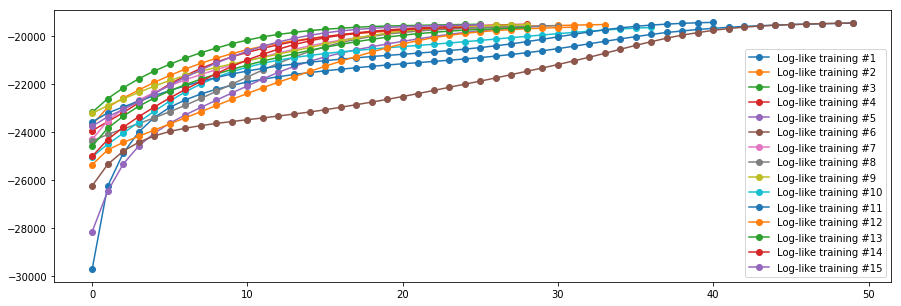

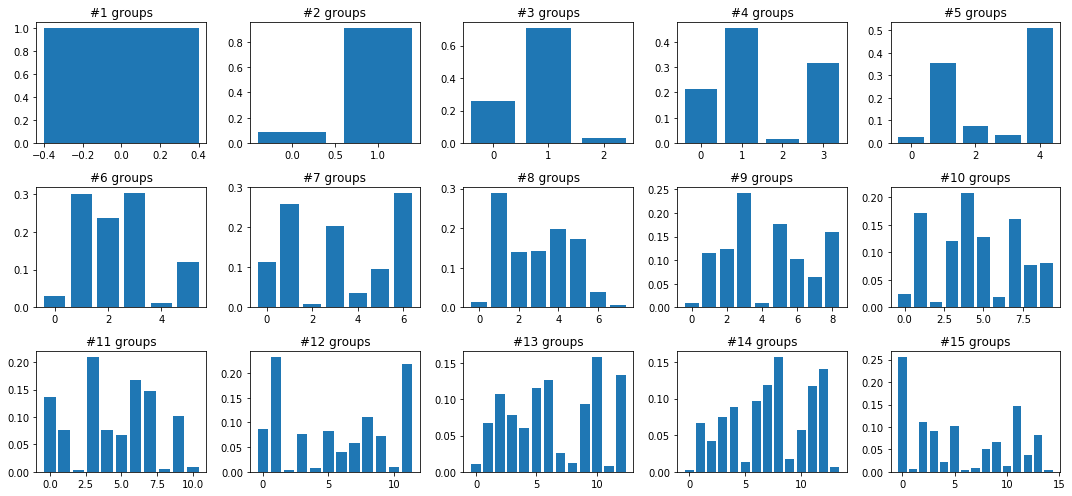

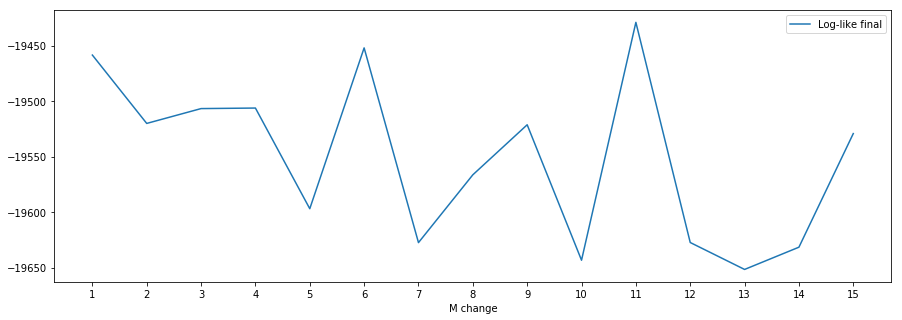

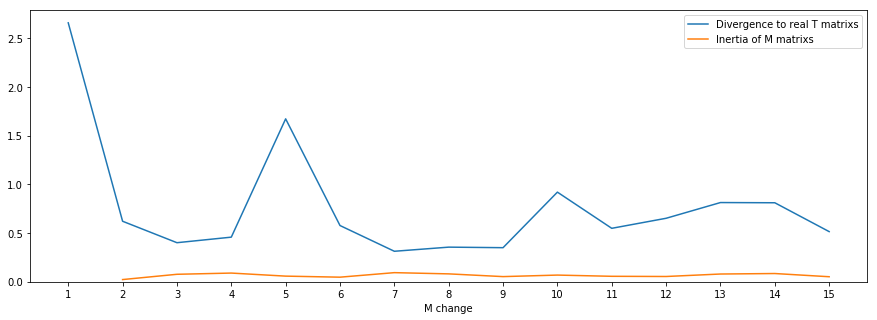

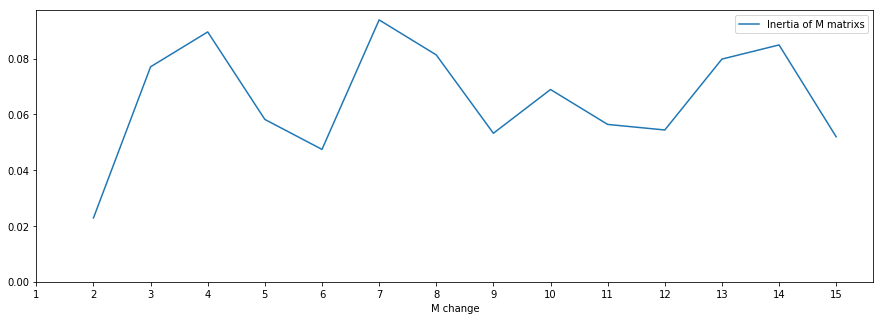

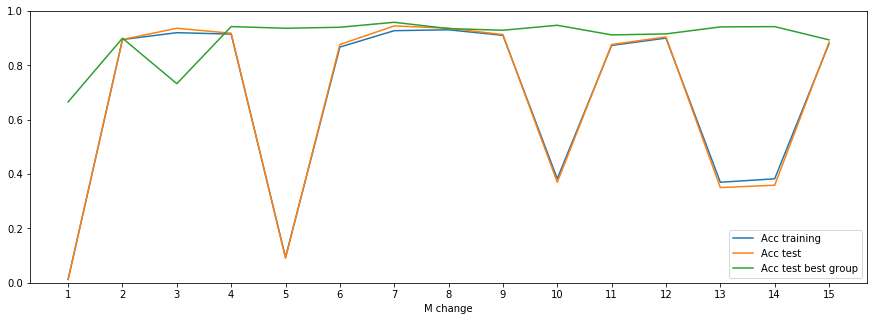

In [22]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence_Mchange,
         probGt_Mchange,
         inertia_Mchange)

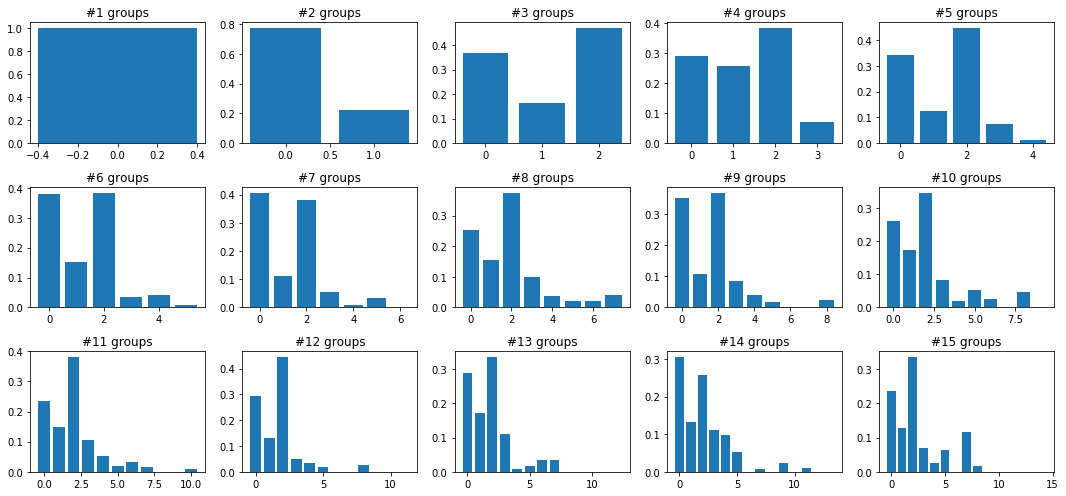

<Figure size 1080x360 with 0 Axes>

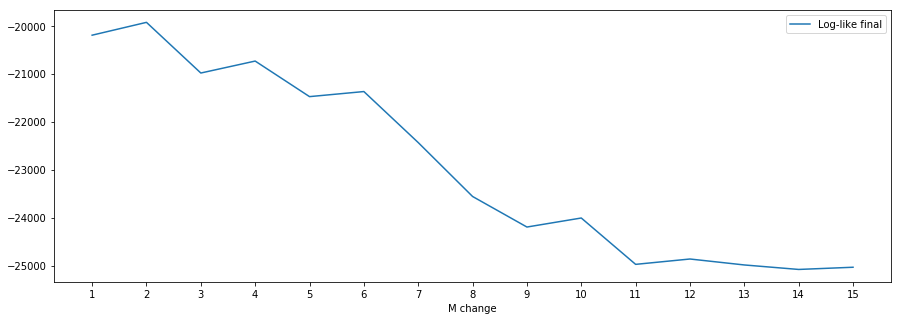

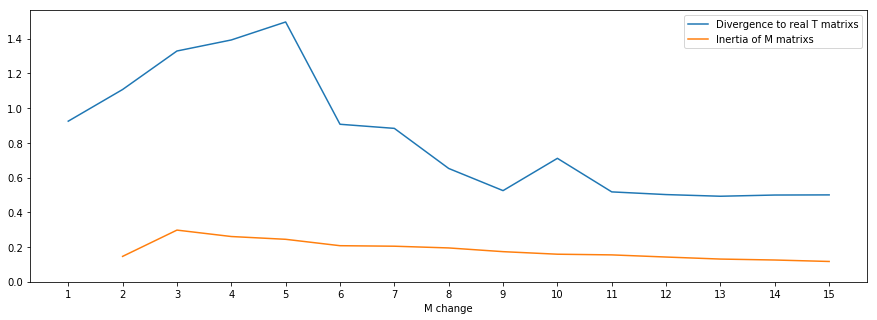

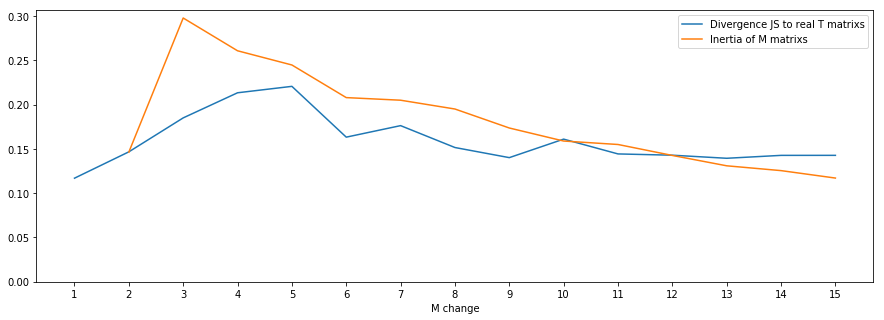

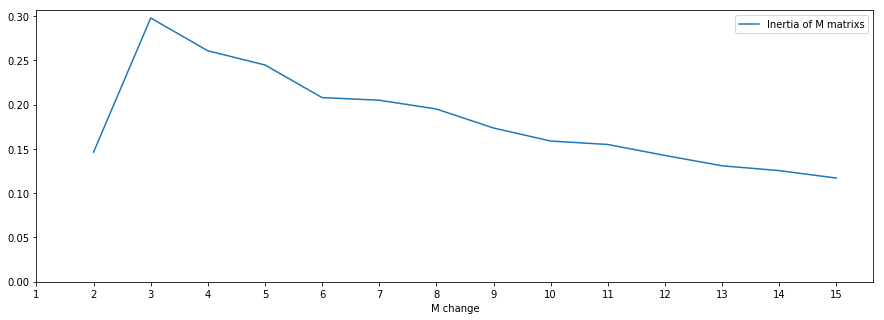

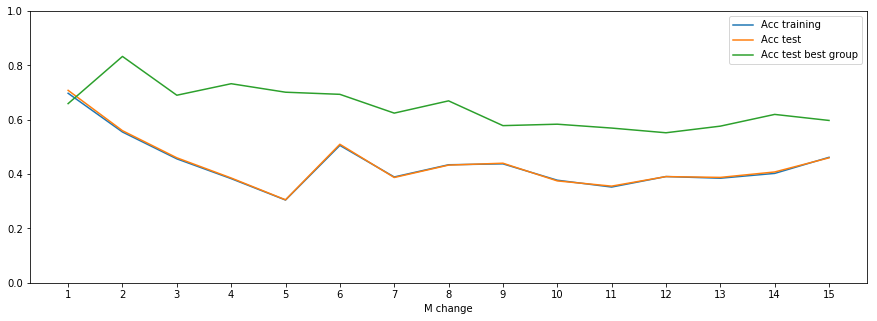

In [23]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange)

In [ ]:
#version mv_Close

In [ ]:
#best?

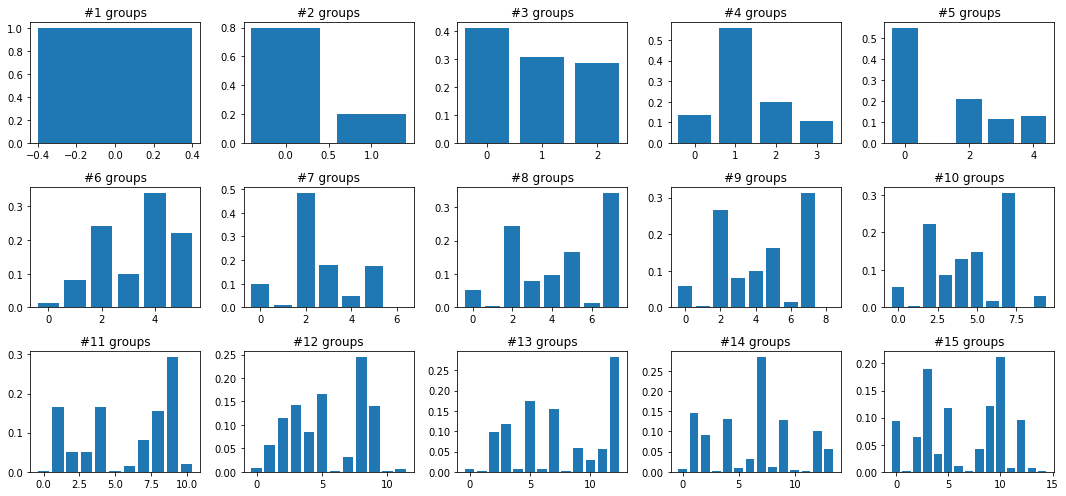

<Figure size 1080x360 with 0 Axes>

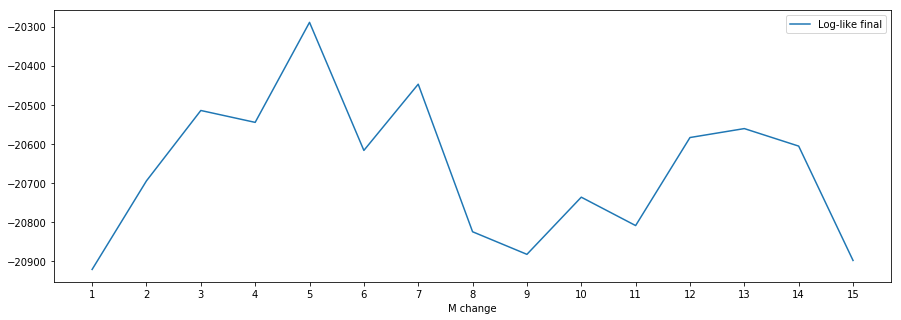

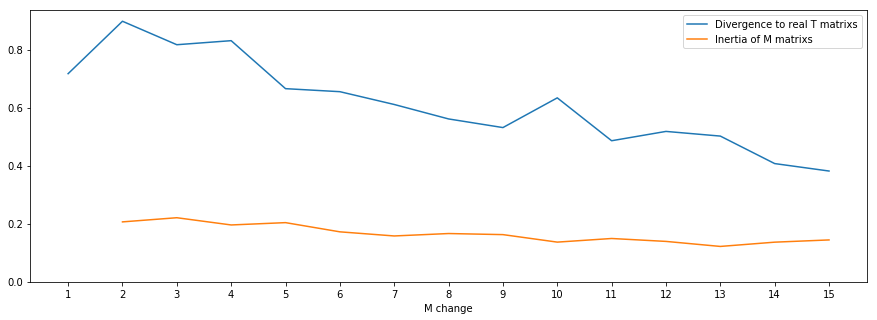

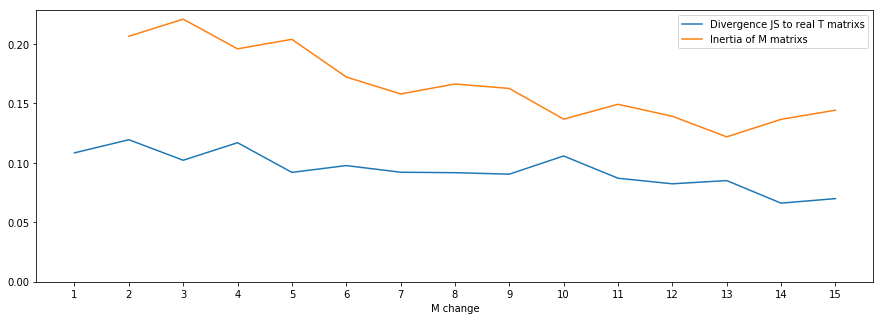

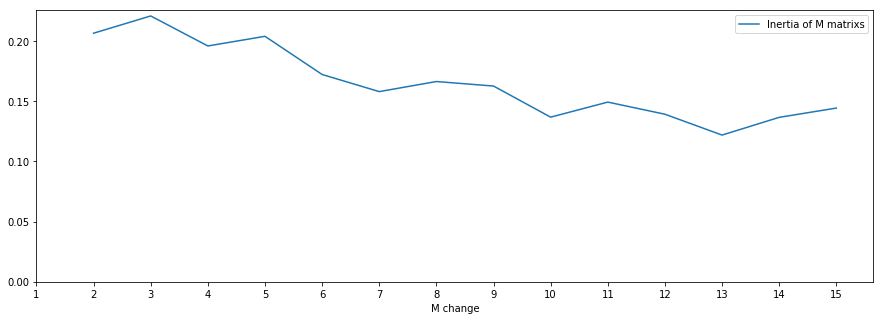

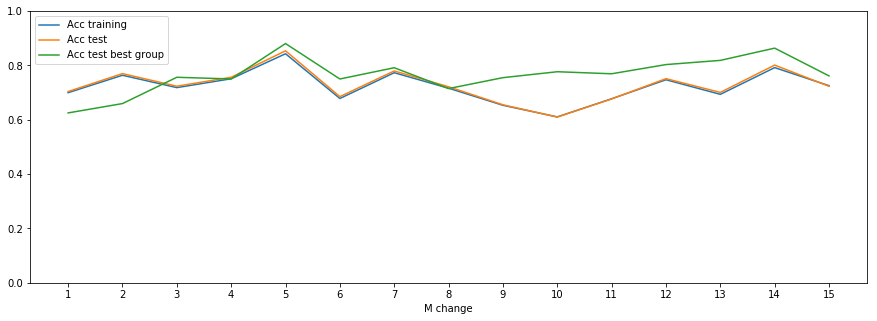

In [14]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange)

In [4]:
#T if i know T
M_values = range(1,1+len(logL_Mchange))
print(T)
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

100


#Groups  >=1 annotator  >=2 annotator  Used on annotators  \
0         1              1              1                   1   
1         2              2              2                   2   
2         3              3              3                   3   
3         4              4              4                   4   
4         5              5              4                   5   
5         6              5              5                   6   
6         7              5              5                   4   
7         8              8              8                   5   
8         9              7              6                   3   
9        10              8              7                   3   
10       11              8              6                   1   
11       12              7              6                   3   
12       13              7              6                   4   
13       14              7              7                   1   
14       15              8              7                   1   

    Used on annotators limit >=0.01  Used on annotators limit >=0.05  
0                                 1                                1  
1                                 2                                2  
2                                 3                                3  
3                                 4                                4  
4                                 5                                5  
5                                 6                                6  
6                                 7                                7  
7                                 8                                8  
8                                 9                                9  
9                                10                               10  
10                               11                                9  
11                               11                               10  
12                               13                               13  
13                               13                               11  
14                               15                               13